## Import libraries

In [1]:
!python -V

Python 3.6.10


In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
#import keras
from sklearn import preprocessing

print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)

Numpy version: 1.18.1
Pandas version: 1.0.3


In [3]:
import sklearn as sk
sk.__version__

'0.22.2.post1'

In [4]:
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from matplotlib import pyplot

In [5]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

## Import dataset

In [6]:
df=pd.read_csv('dengue data-1070801codedSM.csv')
df=df.drop(['date', 'RNA'],  axis=1)
df=df.dropna(how='any')

In [7]:
train_df, test_df = train_test_split(df, test_size=.1, 
                                         stratify=df.Severity, random_state=42)

In [8]:
train_noval_df, val_df = train_test_split(train_df, test_size=.2, 
                                         stratify=train_df.Severity, random_state=42)

In [9]:
pd.set_option('display.max_columns', train_df.shape[1])
pd.set_option('max_colwidth', 1000)

In [10]:
train_df.head()

Severity  sex  age  NS1  IgM  IgG
397         0    1   45  1.0  0.0  0.0
252         0    0   62  1.0  1.0  0.0
420         0    1   31  1.0  0.0  0.0
638         0    0   89  0.0  0.0  1.0
374         0    0   27  0.0  0.0  0.0

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 718 entries, 397 to 501
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Severity  718 non-null    int64  
 1   sex       718 non-null    int64  
 2   age       718 non-null    int64  
 3   NS1       718 non-null    float64
 4   IgM       718 non-null    float64
 5   IgG       718 non-null    float64
dtypes: float64(3), int64(3)
memory usage: 39.3 KB


## Data preprocessing piprlines
Prepare the data to a format that can be fit into scikit learn algorithms

**Transform data in a pipeline** 

 
For many machine learning algorithms, gradient descent is the preferred or even the only optimization method to learn the model parameters. Gradient descent is highly sensitive to feature scaling.

In [12]:
def PreprocessData (raw_df):
    ndarray=raw_df.values
    Label=ndarray[:,0]
    Features=raw_df.drop(['Severity'], axis=1)
    Features['age']=Features['age']/100
    scaleFeatures=Features.values
    #minmax_scale=preprocessing.MinMaxScaler(feature_range=(0,1))
    #scaleFeatures=minmax_scale.fit_transform(Features)
    
    return scaleFeatures, Label
    #return Features, Label

In [13]:
train_Features, train_Label=PreprocessData(train_df)
test_Features, test_Label=PreprocessData(test_df)

In [14]:
train_noval_Features, train_noval_Label=PreprocessData(train_noval_df)
val_Features, val_Label=PreprocessData(val_df)


In [15]:
np.random.seed(10)

In [16]:
val_Features.shape

(144, 5)

## Fitting classifiers

In [17]:
import shap
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import learning_curve, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, balanced_accuracy_score
import numpy as np
import scipy.stats as stats

In [18]:
train_df['Severity'].value_counts()

0    594
1    124
Name: Severity, dtype: int64

This is an unbalanced dataset(i.e., the number of positive and negative cases are not the same), and we'll use recall as our metric to optimise the model performance.

**_Assessing learning curve using the model default settings_**  
Tuning the model hyper-parameters are always difficult, so a good starting point is to see how the Scikit-learn default settings for the model performs, i.e., to see if it overfits or underfits, or is just right. This will give a good indication as to the direction of tuning. 

In [19]:
def plot_learning_curves(model, X, y):

    train_sizes, train_scores, val_scores = learning_curve(model, X, y, cv=5, scoring='roc_auc',
                                                           random_state=42, n_jobs=-1)
    plt.plot(train_sizes, np.mean(train_scores, axis=1), "o-", label="training scores")
    plt.plot(train_sizes, np.mean(val_scores, axis=1), "o-", label="x-val scores")
    plt.legend(fontsize=14).get_frame().set_facecolor('white')
    plt.xlabel("Training set size")
    plt.ylabel("Average_precision")
    plt.title('{} learning curve'.format(model.__class__.__name__))

In [20]:
def plot_roc_curve(fpr, tpr, auc, model=None):
    if model == None:
        title = None
    elif isinstance(model, str):
        title = model
    else:
        title = model.__class__.__name__
#    title = None if model == None else model.__class__.__name__
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, linewidth=2, label='auc: {}'.format(auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-.01, 1.01, -.01, 1.01])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend(fontsize=14).get_frame().set_facecolor('white')
    plt.title('{} - ROC Curve'.format(title))

In [21]:
def plot_precision_recall_curve(fpr, tpr, ap, model=None):
    if model == None:
        title = None
    elif isinstance(model, str):
        title = model
    else:
        title = model.__class__.__name__
#    title = None if model == None else model.__class__.__name__
    plt.figure(figsize=(8, 8))
    plt.plot(recall, precision, linewidth=2, label='average_precision: {}'.format(ap))
    plt.plot([0, 1], [0.1, 0.1], 'k--')
    plt.axis([-.01, 1.01, -.01, 1.01])
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.legend(fontsize=14).get_frame().set_facecolor('white')
    plt.title('{} - PR Curve'.format(title))

In [22]:
from sklearn.metrics import precision_recall_curve, make_scorer, auc, average_precision_score

### Logistic Regression
Our first model is logistic regression

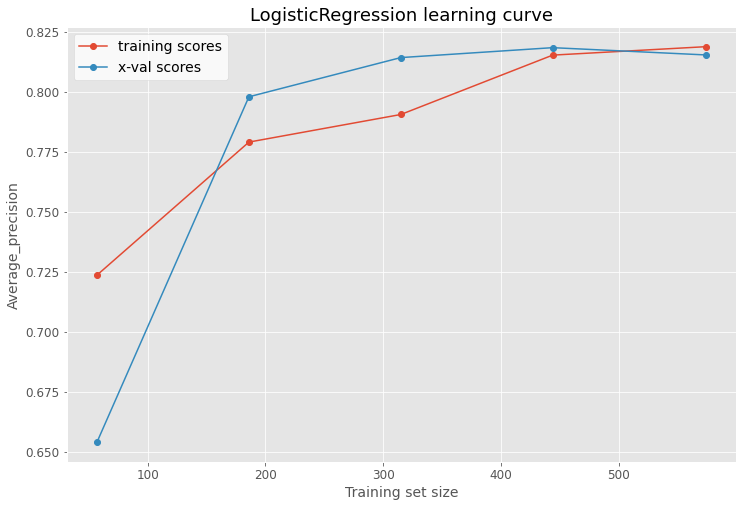

In [23]:
lr_clf = LogisticRegression(n_jobs = -1, 
                           class_weight='balanced'
                           )
plot_learning_curves(lr_clf, train_Features, train_df['Severity'])

Let's see if we can squeeze some more performance out by optimising C.

In [24]:
param_grid = {
        'C': [0.01, 0.1, 1, 10, 100, 1000],
   'class_weight': ['balanced', None]
    }
lr_clf = LogisticRegression(random_state=42)
#scorings ={'precision', 'recall', 'roc_auc'}
#scoring = {make_scorer(auc)}
#make_scorer(accuracy_score)
grid_search = GridSearchCV(lr_clf, param_grid=param_grid, return_train_score=True,
                                cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(train_Features, train_df['Severity'])

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'class_weight': ['balanced', None]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

In [25]:
cv_rlt = grid_search.cv_results_
pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

X-val scores  Train scores                                   Params
0       0.818964      0.821653          {'C': 10, 'class_weight': None}
1       0.818350      0.822159         {'C': 100, 'class_weight': None}
2       0.818350      0.822185        {'C': 1000, 'class_weight': None}
3       0.817306      0.820682  {'C': 1000, 'class_weight': 'balanced'}
4       0.817239      0.820665   {'C': 100, 'class_weight': 'balanced'}
5       0.816789      0.818569           {'C': 1, 'class_weight': None}
6       0.816711      0.820567    {'C': 10, 'class_weight': 'balanced'}
7       0.815395      0.818801     {'C': 1, 'class_weight': 'balanced'}
8       0.800860      0.806208   {'C': 0.1, 'class_weight': 'balanced'}
9       0.795823      0.800048         {'C': 0.1, 'class_weight': None}
10      0.781377      0.789455  {'C': 0.01, 'class_weight': 'balanced'}
11      0.775889      0.785464        {'C': 0.01, 'class_weight': None}

Looks like C=1000 is our best value.

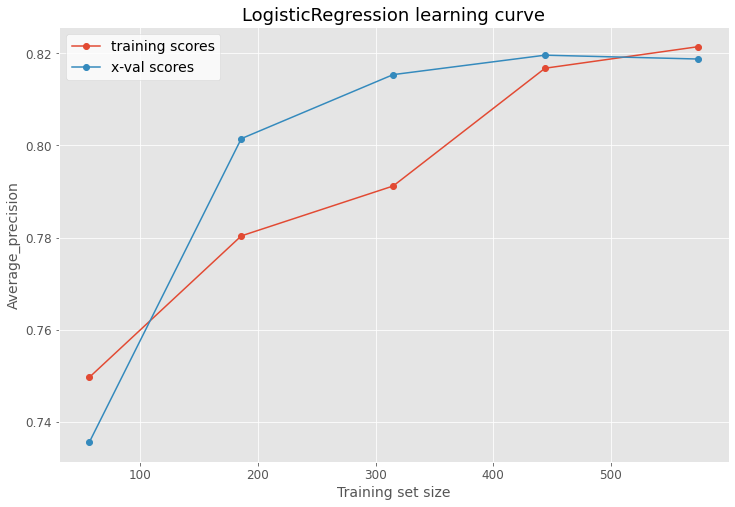

In [26]:
lr_clf = grid_search.best_estimator_

plot_learning_curves(lr_clf, train_Features, train_df['Severity'])

In [27]:
with open('20200225lr_clf_final_round.pkl', 'wb') as f:
    pickle.dump(lr_clf, f)

### Random Forests classifier
Random forests classifier is an ensemble tree-based model that reduces the variance of the predictors.

_plot the learning curve to find out where the default model is at_

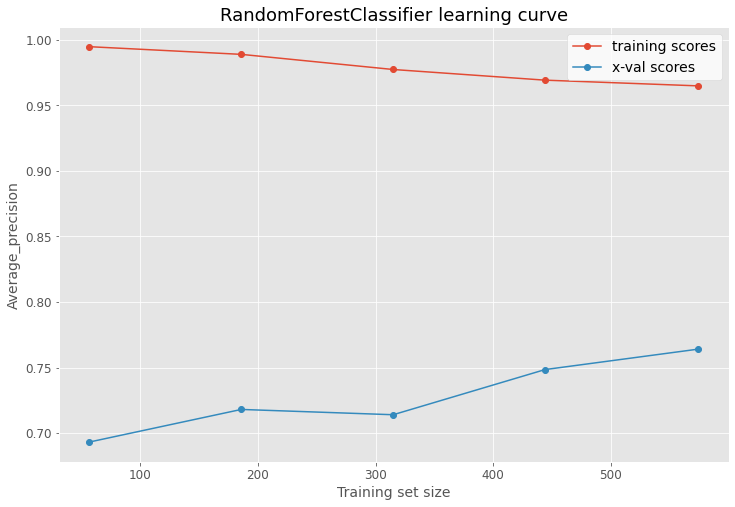

In [28]:
rf_clf = RandomForestClassifier(random_state=42, 
                              class_weight='balanced'
                               )
plot_learning_curves(rf_clf, train_Features, train_df['Severity'])

This is a typical overfitting curve. The default Random Forests classifier needs to be constrained. We'll use a randomised search to optimise hyperparameters

In [29]:
param_distribs = {
        'n_estimators': stats.randint(low=1, high=50),
        'max_features': ['auto', 'log2'],
        'max_depth': stats.randint(low=2, high=100),
        'min_samples_split': stats.randint(low=2, high=100), 
        'min_samples_leaf': stats.randint(low=2, high=100),
        'class_weight': ['balanced', None]
    }
#rf_clf = RandomForestClassifier(random_state=42)
rnd_search = RandomizedSearchCV(rf_clf, param_distributions=param_distribs, return_train_score=True,
                                n_iter=100, cv=5, scoring='roc_auc', random_state=42, n_jobs=-1)
rnd_search.fit(train_Features, train_df['Severity'])

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
         

In [30]:
cv_rlt = rnd_search.cv_results_
rf_clf = rnd_search.best_estimator_

pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

X-val scores  Train scores  \
0       0.818617      0.870089   
1       0.816172      0.886700   
2       0.815024      0.848527   
3       0.814575      0.859386   
4       0.813677      0.832286   
..           ...           ...   
95      0.739168      0.764660   
96      0.738926      0.757674   
97      0.738143      0.761213   
98      0.732721      0.749899   
99      0.727428      0.754075   

                                                                                                                                        Params  
0    {'class_weight': 'balanced', 'max_depth': 34, 'max_features': 'auto', 'min_samples_leaf': 6, 'min_samples_split': 42, 'n_estimators': 28}  
1    {'class_weight': 'balanced', 'max_depth': 95, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 17, 'n_estimators': 26}  
2   {'class_weight': 'balanced', 'max_depth': 31, 'max_features': 'auto', 'min_samples_leaf': 18, 'min_samples_split': 64, 'n_estimators': 19}  
3          {'class_weight': None, 'max_depth': 40, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 57, 'n_estimators': 17}  
4    {'class_weight': 'balanced', 'max_depth': 9, 'max_features': 'auto', 'min_samples_leaf': 36, 'min_samples_split': 79, 'n_estimators': 17}  
..                                                                                                                                         ...  
95        {'class_weight': None, 'max_depth': 76, 'max_features': 'log2', 'min_samples_leaf': 93, 'min_samples_split': 90, 'n_estimators': 39}  
96         {'class_weight': None, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 94, 'min_samples_split': 64, 'n_estimators': 18}  
97        {'class_weight': None, 'max_depth': 22, 'max_features': 'log2', 'min_samples_leaf': 98, 'min_samples_split': 29, 'n_estimators': 47}  
98         {'class_weight': None, 'max_depth': 88, 'max_features': 'auto', 'min_samples_leaf': 93, 'min_samples_split': 99, 'n_estimators': 2}  
99          {'class_weight': None, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 97, 'min_samples_split': 2, 'n_estimators': 5}  

[100 rows x 3 columns]

As suspected, the best parameters have set constraints on the depth of the tree, mininum samples on the split nodes and leaf nodes.

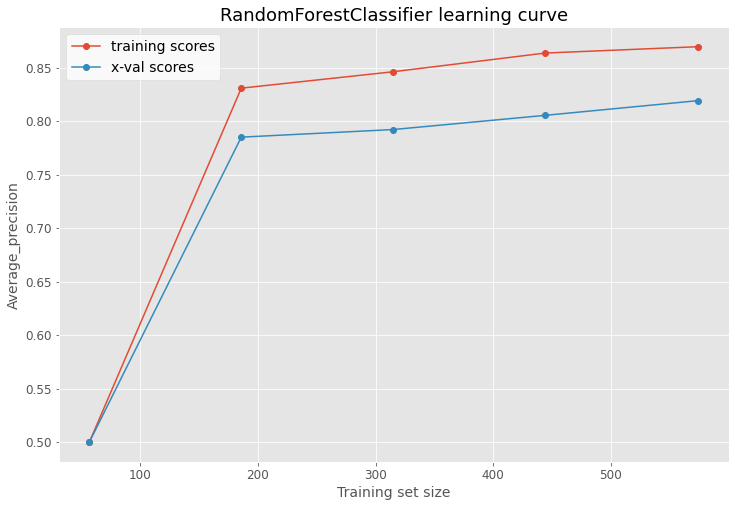

In [31]:
plot_learning_curves(rf_clf, train_Features, train_df['Severity'])

In [32]:
#rf_clf = rnd_search.best_estimator_
rf_clf.fit(train_Features, train_df['Severity'], )
with open('20200225rf_clf_final_round.pkl', 'wb') as f:
    pickle.dump(rf_clf, f)

The learning curve of the best Random Forests model suggests that the performance of the model might continue to increase with more traning data.

### Gradient boosting classifier
Gradient boosting classifier is an ensemble tree-based model that reduces the bias of the predictors.

_plot the learning curve to find out where the default model is at_

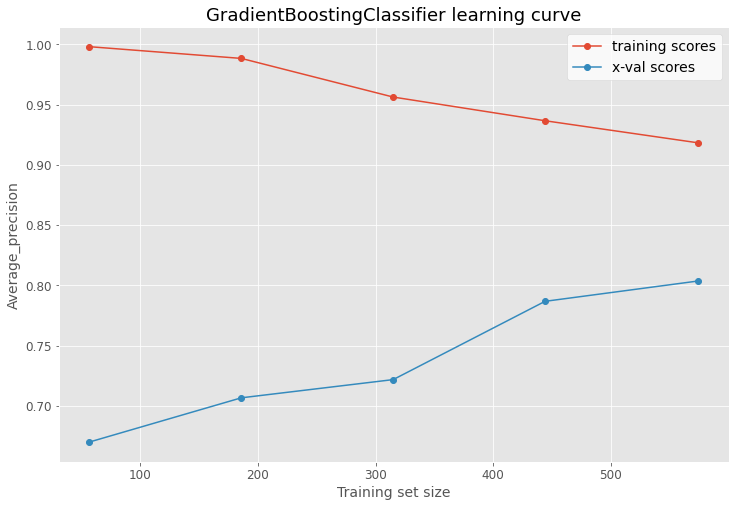

In [33]:
plot_learning_curves(GradientBoostingClassifier(random_state=42), train_Features, train_df['Severity'])

The learning curve of the GBM might be a little underfitting. Maybe reducing regularization of the model could lead to better performance. We'll use a randomised search to optimise hyperparameters.

In [34]:
param_distribs = {
        'n_estimators': stats.randint(low=80, high=200),
        'max_depth': stats.randint(low=3, high=50),
        'min_samples_split': stats.randint(low=2, high=100), 
        'min_samples_leaf': stats.randint(low=2, high=100)
    }
rnd_search = RandomizedSearchCV(GradientBoostingClassifier(random_state=42), 
                                param_distributions=param_distribs, return_train_score=True,
                                n_iter=100, cv=5, scoring='roc_auc', random_state=42, n_jobs=-1)
# this will take a long time
rnd_search.fit(train_Features, train_df['Severity'])

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                    

In [35]:
cv_rlt = rnd_search.cv_results_
gbm_clf = rnd_search.best_estimator_
pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

X-val scores  Train scores  \
0       0.814079      0.860575   
1       0.812466      0.854072   
2       0.812158      0.865003   
3       0.811658      0.859051   
4       0.811256      0.890228   
..           ...           ...   
95      0.767978      0.967342   
96      0.766117      0.965672   
97      0.763343      0.969680   
98      0.762962      0.971254   
99      0.750064      0.971512   

                                                                                     Params  
0   {'max_depth': 27, 'min_samples_leaf': 96, 'min_samples_split': 55, 'n_estimators': 137}  
1    {'max_depth': 11, 'min_samples_leaf': 91, 'min_samples_split': 54, 'n_estimators': 81}  
2   {'max_depth': 32, 'min_samples_leaf': 98, 'min_samples_split': 29, 'n_estimators': 190}  
3   {'max_depth': 18, 'min_samples_leaf': 98, 'min_samples_split': 74, 'n_estimators': 138}  
4   {'max_depth': 27, 'min_samples_leaf': 51, 'min_samples_split': 24, 'n_estimators': 110}  
..                                                                                      ...  
95   {'max_depth': 21, 'min_samples_leaf': 5, 'min_samples_split': 36, 'n_estimators': 143}  
96   {'max_depth': 21, 'min_samples_leaf': 3, 'min_samples_split': 54, 'n_estimators': 123}  
97     {'max_depth': 42, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 85}  
98   {'max_depth': 35, 'min_samples_leaf': 2, 'min_samples_split': 28, 'n_estimators': 141}  
99   {'max_depth': 42, 'min_samples_leaf': 2, 'min_samples_split': 12, 'n_estimators': 171}  

[100 rows x 3 columns]

We'll save the best model, retrain it on the whole dataset and save the model

In [36]:
gbm_clf = rnd_search.best_estimator_
gbm_clf.fit(train_Features, train_df['Severity'])
with open('20200225gbm_clf_final_round.pkl', 'wb') as f:
    pickle.dump(gbm_clf, f)

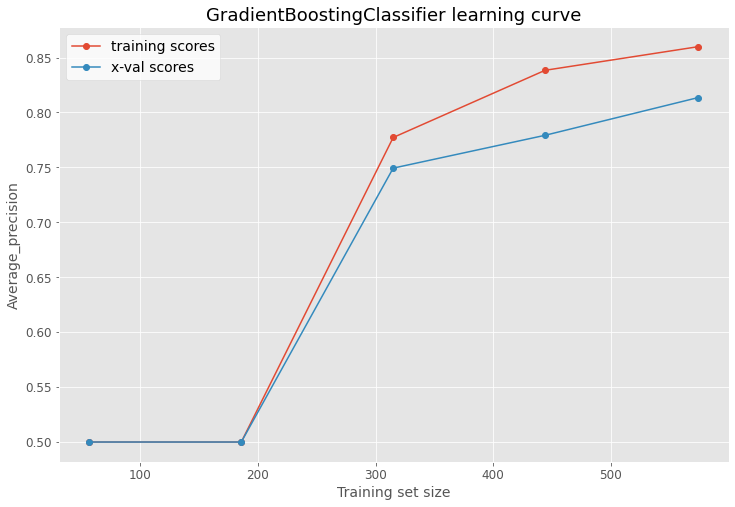

In [37]:
plot_learning_curves(gbm_clf, train_Features, train_df['Severity'])

The learning curve of the best Gradient Boosting model suggests that the performance of the model might continue to increase with more traning data.

### Support vector machine classifier
Support vector machine classifier is a powerful classifier that works best on small to medium size complex data set. Our training set is medium size to SVMs.

_plot the learning curve to find out where the default model is at_

Try Linear SVC fist

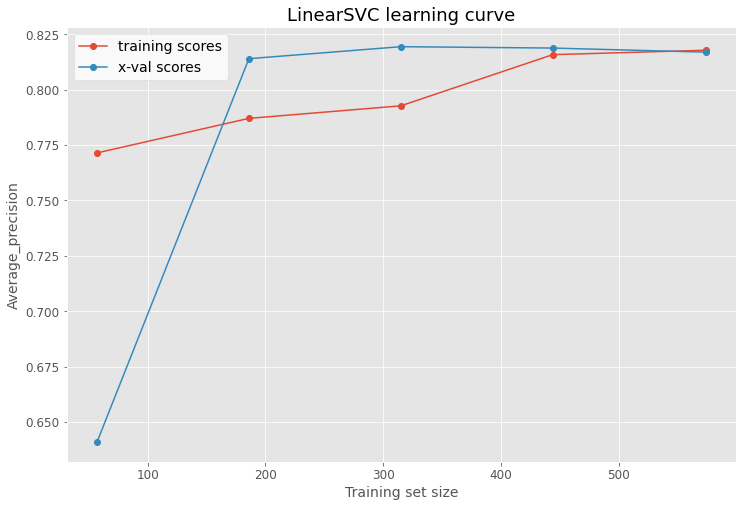

In [38]:
plot_learning_curves(LinearSVC(loss='hinge', random_state=42, class_weight= 'balanced'), train_Features, train_df['Severity'] )

Try Polynomial kernel

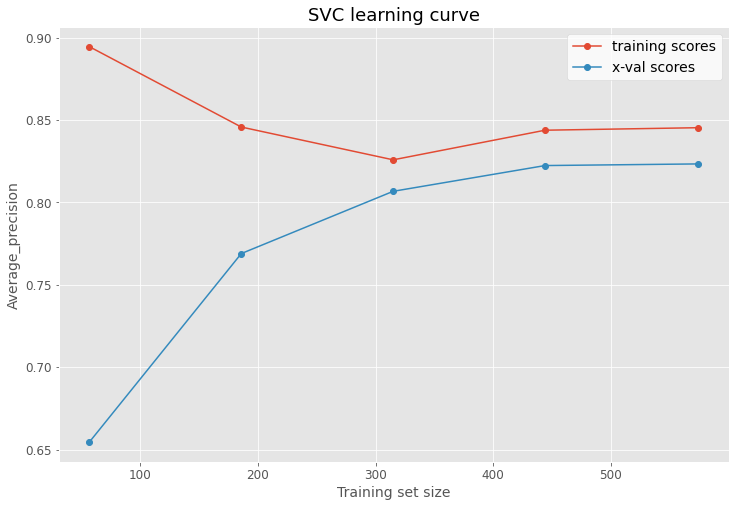

In [39]:
plot_learning_curves(SVC(kernel='poly', random_state=42,class_weight= 'balanced'), train_Features, train_df['Severity'])

Try Gaussian RBF kernel

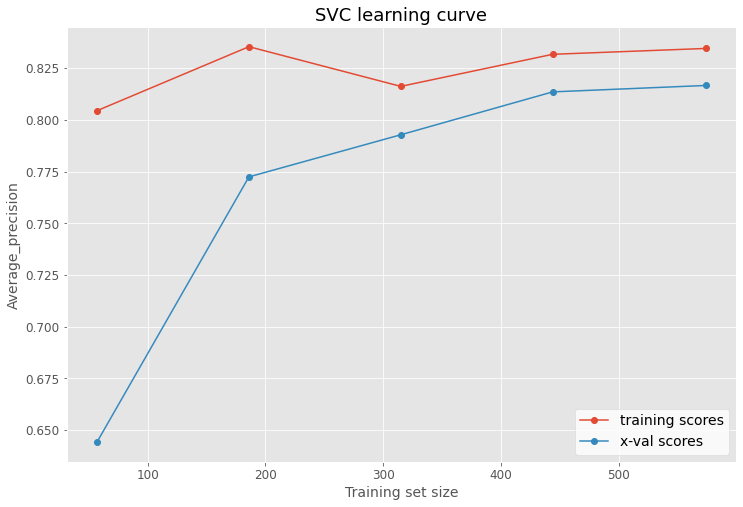

In [40]:
plot_learning_curves(SVC(random_state=42, class_weight= 'balanced'), train_Features, train_df['Severity'])

The learning curve of the Linear SVC shows sign of underfitting, and provide evidence that the data set is not linearly seperatable.  

The Polynomial SVC shows that the default settings resulting in underfitted model, however, the performance is likely to improve if the complexity of the model increases, e.g., use higher degree polynomials.  

The default settings for RBF SVC performs the best, and with a gap between the training and validation accuracies, it is likely to improve the performance by regularization.

In [41]:
rbf_gamma = [1/len(train_df.columns) * x for x in range(1, 15, 5)]
param_grid = [
    # first try Poly kernel
    ## coef0 hyper-parameter was also tested originally, however, it is taking too long
    {'kernel':['poly'], 'degree': [3, 9, 15], 'C': [1, 3, 9],  'class_weight': ['balanced', None]},
    # then try RBF kernel
    {'gamma': rbf_gamma, 'C': [1, 3, 9],  'class_weight': ['balanced', None]},
    
  ]

grid_search = GridSearchCV(SVC(probability=True, random_state=42), param_grid, cv=5,
                           scoring='roc_auc', n_jobs=-1)

# this will take a long time
grid_search.fit(train_Features, train_df['Severity'])

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [1, 3, 9], 'class_weight': ['balanced', None],
                          'degree': [3, 9, 15], 'kernel': ['poly']},
                         {'C': [1, 3, 9], 'class_weight': ['balanced', None],
                          'gamma': [0.16666666666666666, 1.0,
                                    1.8333333333333333]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [42]:
cv_rlt = grid_search.cv_results_
svc_clf = grid_search.best_estimator_

In [43]:
cv_rlt

{'mean_fit_time': array([3.96959782e-02, 2.47836294e+00, 1.91530945e+02, 4.53969955e-02,
        4.60369835e+00, 1.60890158e+02, 5.83566189e-02, 5.23930368e+00,
        2.61419697e+02, 7.43596554e-02, 1.16927505e+01, 3.09282219e+02,
        1.09910583e-01, 1.35257201e+01, 3.97965224e+02, 1.34975910e-01,
        2.21439365e+01, 4.14330760e+02, 9.16057110e-02, 8.00608158e-02,
        8.01990509e-02, 5.12100697e-02, 5.69800377e-02, 6.42156124e-02,
        8.75285625e-02, 7.81252384e-02, 7.95286655e-02, 5.63434124e-02,
        6.72219753e-02, 7.46720791e-02, 8.23346615e-02, 7.89285183e-02,
        7.83307076e-02, 6.64990425e-02, 8.00847054e-02, 8.62418175e-02]),
 'std_fit_time': array([4.11489343e-03, 3.63256715e-01, 3.10585989e+01, 8.78090189e-03,
        3.08648123e+00, 4.36272185e+01, 1.02547017e-02, 9.04211689e-01,
        8.08147752e+01, 9.31094198e-03, 7.11857332e+00, 4.48170941e+01,
        3.12838763e-02, 5.10988985e+00, 1.01524719e+02, 3.32948295e-02,
        9.35812551e+00, 1.208

In [44]:
svc_clf.fit(train_Features, train_df['Severity'])
with open('20200225svc_clf_final_round.pkl', 'wb') as f:
    pickle.dump(svc_clf, f)

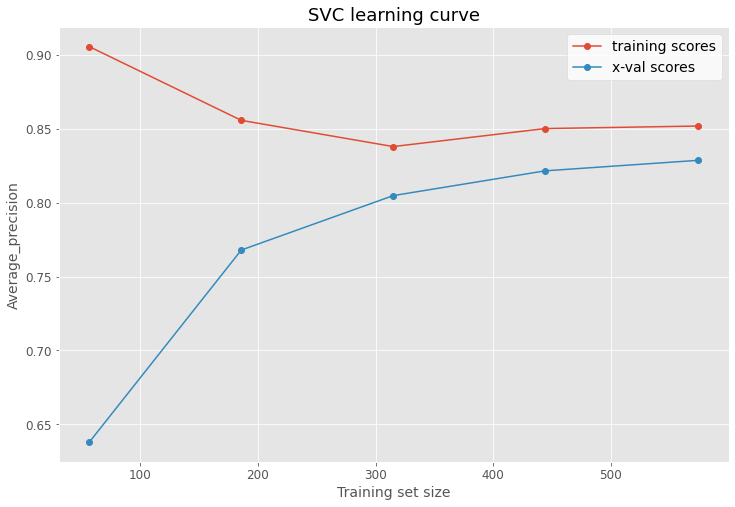

In [45]:
# best model is the default RBF kernal SVM
plot_learning_curves(svc_clf, train_Features, train_df['Severity']) 

## Compute and compare test metrics

**Compute test accuracy score**

### _Logistic Regression model_

In [46]:
# Import model and retrain
with open('20200225lr_clf_final_round.pkl', 'rb') as f:
    lr_clf = pickle.load(f)
lr_clf.fit(train_Features, train_df['Severity'])

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy scores

In [47]:
accu_lr = accuracy_score(test_df['Severity'], lr_clf.predict(test_Features))

In [48]:
accu_lr

0.85

In [49]:
from sklearn.metrics import balanced_accuracy_score
balance_accu_lr=balanced_accuracy_score(test_df['Severity'], lr_clf.predict(test_Features))
balance_accu_lr

0.5714285714285714

In [50]:
pd.crosstab(test_df['Severity'], lr_clf.predict(test_Features))

col_0      0  1
Severity       
0         66  0
1         12  2

ROC and AUC

In [51]:
pred_proba_lr = lr_clf.predict_proba(test_Features)

In [52]:
fpr, tpr, _ = roc_curve(test_df['Severity'], pred_proba_lr[:, 1])
auc_lr = roc_auc_score(test_df['Severity'], pred_proba_lr[:, 1])

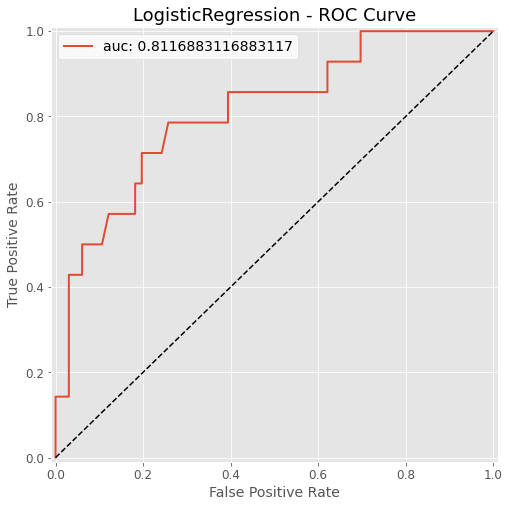

In [53]:
plot_roc_curve(fpr, tpr, auc_lr, lr_clf)

f1=0.250 auc_lr=0.5511 ap_lr=0.5652


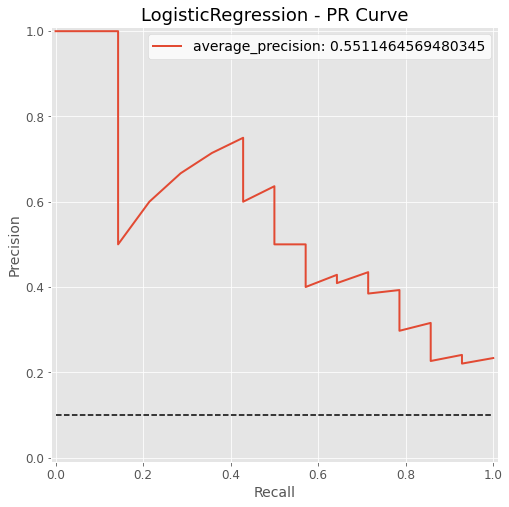

In [54]:
# predict probabilities
pred_proba_lr = lr_clf.predict_proba(test_Features)
# keep probabilities for the positive outcome only
pred_proba_lr = pred_proba_lr[:, 1]
# predict class values
yhat = lr_clf.predict(test_Features)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_Label, pred_proba_lr)
# calculate F1 score
f1 = f1_score(test_Label, yhat)
# calculate precision-recall AUC
auc_lr_pr=auc(recall, precision)
# calculate average precision score
ap_lr_pr = average_precision_score(test_Label, pred_proba_lr)
print('f1=%.3f auc_lr=%.4f ap_lr=%.4f' % (f1, auc_lr_pr, ap_lr_pr))

plot_precision_recall_curve(recall, precision, auc_lr_pr, lr_clf)

### _Random forests model_

In [55]:
# Import model and retrain
with open('20200225rf_clf_final_round.pkl', 'rb') as f:
    rf_clf = pickle.load(f)
rf_clf.fit(train_Features, train_df['Severity'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=34, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=42,
                       min_weight_fraction_leaf=0.0, n_estimators=28,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Accuracy scores

In [56]:
accu_rf = accuracy_score(test_df['Severity'], rf_clf.predict(test_Features))

In [57]:
accu_rf

0.75

In [58]:
balance_accu_rf=balanced_accuracy_score(test_df['Severity'], rf_clf.predict(test_Features))
balance_accu_rf

0.7640692640692641

In [59]:
pd.crosstab(test_df['Severity'], rf_clf.predict(test_Features))

col_0      0   1
Severity        
0         49  17
1          3  11

ROC and AUC

In [60]:
pred_proba_rf = rf_clf.predict_proba(test_Features)

In [61]:
fpr, tpr, _ = roc_curve(test_df['Severity'], pred_proba_rf[:, 1])
auc_rf = roc_auc_score(test_df['Severity'], pred_proba_rf[:, 1])

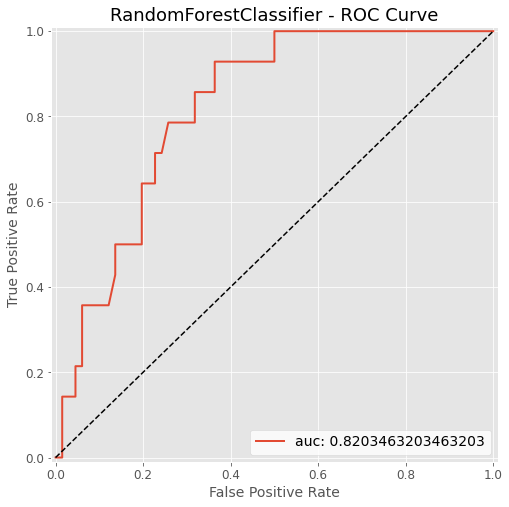

In [62]:
plot_roc_curve(fpr, tpr, auc_rf, rf_clf)

f1=0.524 auc_rf=0.3888 ap_rf=0.4516


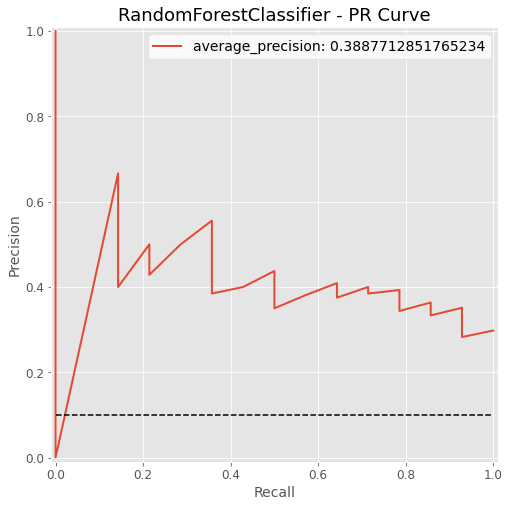

In [63]:
# predict probabilities
pred_proba_rf = rf_clf.predict_proba(test_Features)
# keep probabilities for the positive outcome only
pred_proba_rf = pred_proba_rf[:, 1]
# predict class values
yhat = rf_clf.predict(test_Features)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_Label, pred_proba_rf)
# calculate F1 score
f1 = f1_score(test_Label, yhat)
# calculate precision-recall AUC
auc_rf_pr=auc(recall, precision)
# calculate average precision score
ap_rf_pr = average_precision_score(test_Label, pred_proba_rf)
print('f1=%.3f auc_rf=%.4f ap_rf=%.4f' % (f1, auc_rf_pr, ap_rf_pr))

plot_precision_recall_curve(recall, precision, auc_rf_pr, rf_clf)

### _Gradient boosting machine model_

In [64]:
# Import model and retrain
with open('20200225gbm_clf_final_round.pkl', 'rb') as f:
    gbm_clf = pickle.load(f)
gbm_clf.fit(train_Features, train_df['Severity'])

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=27,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=96, min_samples_split=55,
                           min_weight_fraction_leaf=0.0, n_estimators=137,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Accuracy scores

In [65]:
accu_gbm = accuracy_score(test_df['Severity'], gbm_clf.predict(test_Features))

In [66]:
accu_gbm

0.7875

In [67]:
balance_accu_gbm=balanced_accuracy_score(test_df['Severity'], gbm_clf.predict(test_Features))
balance_accu_gbm

0.5616883116883117

In [68]:
pd.crosstab(test_df['Severity'], gbm_clf.predict(test_Features))

col_0      0  1
Severity       
0         60  6
1         11  3

ROC and AUC

In [69]:
pred_proba_gbm = gbm_clf.predict_proba(test_Features)

In [70]:
fpr, tpr, _ = roc_curve(test_df['Severity'], pred_proba_gbm[:, 1])
auc_gbm = roc_auc_score(test_df['Severity'], pred_proba_gbm[:, 1])

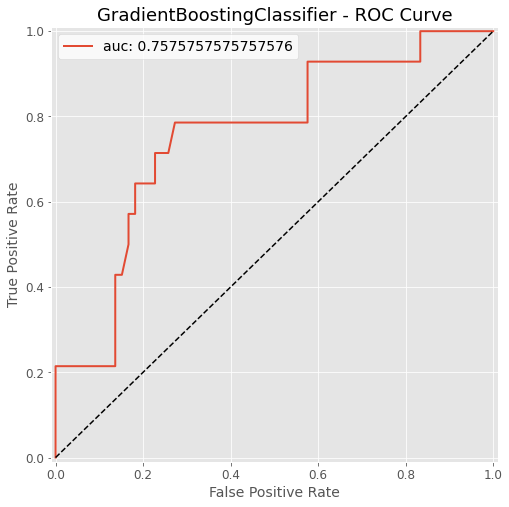

In [71]:
plot_roc_curve(fpr, tpr, auc_gbm, gbm_clf)

f1=0.261 auc_gbm=0.4725 ap_gbm=0.4940


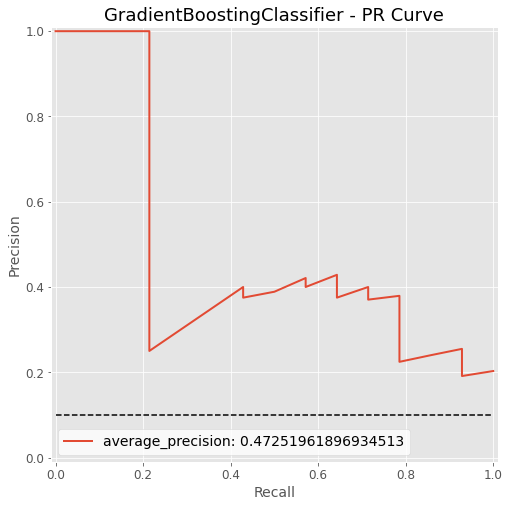

In [72]:
# predict probabilities
pred_proba_gbm = gbm_clf.predict_proba(test_Features)
# keep probabilities for the positive outcome only
pred_proba_gbm = pred_proba_gbm[:, 1]
# predict class values
yhat = gbm_clf.predict(test_Features)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_Label, pred_proba_gbm)
# calculate F1 score
f1 = f1_score(test_Label, yhat)
# calculate precision-recall AUC
auc_gbm_pr=auc(recall, precision)
# calculate average precision score
ap_gbm_pr = average_precision_score(test_Label, pred_proba_gbm)
print('f1=%.3f auc_gbm=%.4f ap_gbm=%.4f' % (f1, auc_gbm_pr, ap_gbm_pr))

plot_precision_recall_curve(recall, precision, auc_gbm_pr, gbm_clf)

### _Support vector machine model_

In [73]:
# Import model and retrain
with open('20200225svc_clf_final_round.pkl', 'rb') as f:
    svc_clf = pickle.load(f)
svc_clf.fit(train_Features, train_df['Severity'])

SVC(C=3, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

Accuracy scores

In [74]:
accu_svc = accuracy_score(test_df['Severity'], svc_clf.predict(test_Features))

In [75]:
accu_svc

0.7125

In [76]:
balance_accu_svc=balanced_accuracy_score(test_df['Severity'], svc_clf.predict(test_Features))
balance_accu_svc

0.7413419913419914

In [77]:
pd.crosstab(test_df['Severity'], svc_clf.predict(test_Features))

col_0      0   1
Severity        
0         46  20
1          3  11

ROC and AUC

In [78]:
pred_proba_svc = svc_clf.predict_proba(test_Features)

In [79]:
fpr, tpr, _ = roc_curve(test_df['Severity'], pred_proba_svc[:, 1])
auc_svc = roc_auc_score(test_df['Severity'], pred_proba_svc[:, 1])

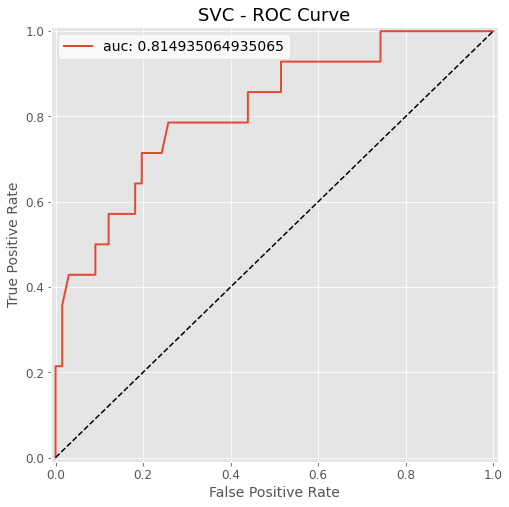

In [80]:
plot_roc_curve(fpr, tpr, auc_svc, svc_clf)

f1=0.489 auc_svc=0.5985 ap_svc=0.6050


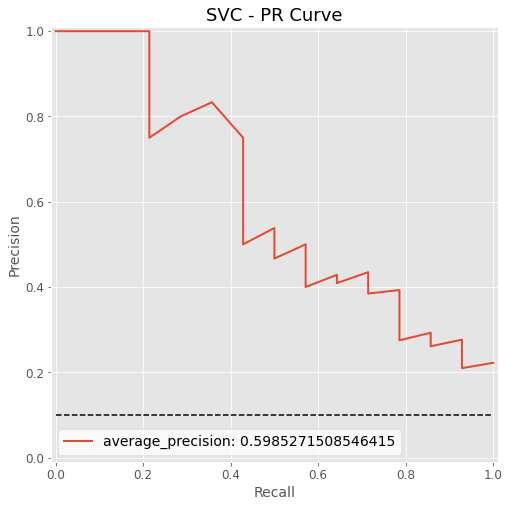

In [81]:
# predict probabilities
pred_proba_svc = svc_clf.predict_proba(test_Features)
# keep probabilities for the positive outcome only
pred_proba_svc = pred_proba_svc[:, 1]
# predict class values
yhat = svc_clf.predict(test_Features)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_Label, pred_proba_svc)
# calculate F1 score
f1 = f1_score(test_Label, yhat)
# calculate precision-recall AUC
auc_svc_pr=auc(recall, precision)
# calculate average precision score
ap_svc_pr = average_precision_score(test_Label, pred_proba_svc)
print('f1=%.3f auc_svc=%.4f ap_svc=%.4f' % (f1, auc_svc_pr, ap_svc_pr))

plot_precision_recall_curve(recall, precision, auc_svc_pr, svc_clf)

### Deep Learning

In [82]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

In [83]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Hyperparameters of deep learning

In [84]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd


import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
print("GPU Available: ", tf.test.is_gpu_available())

GPU Available:  True


In [85]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [86]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [87]:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

In [88]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


train_dataset = tf.data.Dataset.from_tensor_slices((train_noval_Features, train_noval_Label))
val_dataset = tf.data.Dataset.from_tensor_slices((val_Features, val_Label))

BATCH_SIZE = 20
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = test_dataset.batch(BATCH_SIZE)

In [89]:
unique, counts = np.unique(train_Label, return_counts=True)

In [90]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.

weight_for_0 = (1 / counts[0])*(counts.sum())/2.0 
weight_for_1 = (1 / counts[1])*(counts.sum())/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.60
Weight for class 1: 2.90


In [42]:
HP_NUM_UNITS1 = hp.HParam('num_units 1', hp.Discrete([50, 100, 150, 200])) 
HP_NUM_UNITS2 = hp.HParam('num_units 2', hp.Discrete([50, 100, 150, 200]))
HP_NUM_UNITS3 = hp.HParam('num_units 3', hp.Discrete([50, 100, 150, 200]))
HP_DROPOUT1 = hp.HParam('dropout 1', hp.Discrete([0.1, 0.3]))
HP_DROPOUT2= hp.HParam('dropout 2', hp.Discrete([0.1, 0.3]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam']))

METRIC_ACCURACY = 'ROC_AUC'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS1,HP_NUM_UNITS2, HP_NUM_UNITS3,HP_DROPOUT1, HP_DROPOUT2, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='ROC_AUC')],
  )


In [43]:
def train_test_model(hparams):
    
    
    model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS1], activation=tf.nn.relu),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT1]),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS2], activation=tf.nn.relu),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT2]),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS3], activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid),
  ])
    model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='binary_crossentropy',
      metrics=[tf.keras.metrics.AUC()]
  )

    model.fit(train_noval_Features, train_noval_Label, class_weight=class_weight,
          epochs=100, batch_size=20 ) 
    _, accuracy = model.evaluate(val_Features, val_Label)
    return accuracy

In [44]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)


# 10 fold cross-validation

In [45]:
session_num = 0
for num_units1 in HP_NUM_UNITS1.domain.values:
    for num_units2 in HP_NUM_UNITS2.domain.values:
        for num_units3 in HP_NUM_UNITS3.domain.values:
            for dropout_rate1 in HP_DROPOUT1.domain.values:
                for dropout_rate2 in HP_DROPOUT2.domain.values:
                     for optimizer in HP_OPTIMIZER.domain.values:
          
                            hparams = {
              HP_NUM_UNITS1: num_units1,
              HP_NUM_UNITS2: num_units2,
              HP_NUM_UNITS3: num_units3,
              HP_DROPOUT1: dropout_rate1,
              HP_DROPOUT2: dropout_rate2,
              #HP_L2: l2,
              HP_OPTIMIZER: optimizer
              
          }
                            run_name = "run-%d" % session_num
                            print('--- Starting trial: %s' % run_name)
                            print({h.name: hparams[h] for h in hparams})
                            run('logs/hparam_tuning/' + run_name, hparams)
                            session_num += 1

--- Starting trial: run-0
{'num_units 1': 50, 'num_units 2': 50, 'num_units 3': 50, 'dropout 1': 0.1, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6904 - auc_22: 0.5520
Epoch 2/100
574/574 [==============================] - 0s 347us/sample - loss: 0.6708 - auc_22: 0.6947
Epoch 3/100
574/574 [==============================] - 0s 358us/sample - loss: 0.6505 - auc_22: 0.7394
Epoch 4/100
574/574 [==============================] - 0s 355us/sample - loss: 0.6401 - auc_22: 0.7097
Epoch 5/100
574/574 [==============================] - 0s 348us/sample - loss: 0.6078 - auc_22: 0.7579
Epoch 6/100
574/574 [==============================] - 0s 345us/sample - loss: 0.5873 - auc_22: 0.7701
Epoch 7/100
574/574 [==============================] - 0s 355us/sample - loss: 0.5844 - auc_22: 0.7598
Epoch 8/100
574/574 [==============================] - 0s 334us/sample - loss: 0.5704 - auc_22: 0.7735
Epoch 9/100
574/

574/574 [==============================] - 0s 312us/sample - loss: 0.5446 - auc_23: 0.7969
Epoch 14/100
574/574 [==============================] - 0s 297us/sample - loss: 0.5397 - auc_23: 0.8021
Epoch 15/100
574/574 [==============================] - 0s 313us/sample - loss: 0.5562 - auc_23: 0.7845
Epoch 16/100
574/574 [==============================] - 0s 312us/sample - loss: 0.5503 - auc_23: 0.7874
Epoch 17/100
574/574 [==============================] - 0s 317us/sample - loss: 0.5420 - auc_23: 0.8044
Epoch 18/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5191 - auc_23: 0.8210
Epoch 19/100
574/574 [==============================] - 0s 338us/sample - loss: 0.5282 - auc_23: 0.8074
Epoch 20/100
574/574 [==============================] - 0s 316us/sample - loss: 0.5317 - auc_23: 0.8053
Epoch 21/100
574/574 [==============================] - 0s 311us/sample - loss: 0.5282 - auc_23: 0.8079
Epoch 22/100
574/574 [==============================] - 0s 337us/sample - los

574/574 [==============================] - 0s 328us/sample - loss: 0.5759 - auc_24: 0.7678
Epoch 27/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5502 - auc_24: 0.7975
Epoch 28/100
574/574 [==============================] - 0s 316us/sample - loss: 0.5286 - auc_24: 0.8151
Epoch 29/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5392 - auc_24: 0.8031
Epoch 30/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5580 - auc_24: 0.7853
Epoch 31/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5574 - auc_24: 0.7824
Epoch 32/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5396 - auc_24: 0.7969
Epoch 33/100
574/574 [==============================] - 0s 323us/sample - loss: 0.5379 - auc_24: 0.8031
Epoch 34/100
574/574 [==============================] - 0s 323us/sample - loss: 0.5154 - auc_24: 0.8250
Epoch 35/100
574/574 [==============================] - 0s 319us/sample - los

--- Starting trial: run-3
{'num_units 1': 50, 'num_units 2': 50, 'num_units 3': 50, 'dropout 1': 0.3, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6877 - auc_25: 0.5649
Epoch 2/100
574/574 [==============================] - 0s 350us/sample - loss: 0.6894 - auc_25: 0.5490
Epoch 3/100
574/574 [==============================] - 0s 328us/sample - loss: 0.6726 - auc_25: 0.6460
Epoch 4/100
574/574 [==============================] - 0s 338us/sample - loss: 0.6733 - auc_25: 0.6228
Epoch 5/100
574/574 [==============================] - 0s 336us/sample - loss: 0.6537 - auc_25: 0.6673
Epoch 6/100
574/574 [==============================] - 0s 331us/sample - loss: 0.6465 - auc_25: 0.6665
Epoch 7/100
574/574 [==============================] - 0s 336us/sample - loss: 0.6342 - auc_25: 0.6877
Epoch 8/100
574/574 [==============================] - 0s 331us/sample - loss: 0.6315 - auc_25: 0.6750
Epoch 9/100
574/

574/574 [==============================] - 0s 340us/sample - loss: 0.5077 - auc_25: 0.8235
Epoch 79/100
574/574 [==============================] - 0s 346us/sample - loss: 0.4979 - auc_25: 0.8291
Epoch 80/100
574/574 [==============================] - 0s 347us/sample - loss: 0.5082 - auc_25: 0.8186
Epoch 81/100
574/574 [==============================] - 0s 350us/sample - loss: 0.5053 - auc_25: 0.8242
Epoch 82/100
574/574 [==============================] - 0s 351us/sample - loss: 0.5043 - auc_25: 0.8203
Epoch 83/100
574/574 [==============================] - 0s 354us/sample - loss: 0.4932 - auc_25: 0.8340
Epoch 84/100
574/574 [==============================] - 0s 355us/sample - loss: 0.5042 - auc_25: 0.8257
Epoch 85/100
574/574 [==============================] - 0s 334us/sample - loss: 0.4979 - auc_25: 0.8249
Epoch 86/100
574/574 [==============================] - 0s 343us/sample - loss: 0.4845 - auc_25: 0.8423
Epoch 87/100
574/574 [==============================] - 0s 350us/sample - los

574/574 [==============================] - 0s 339us/sample - loss: 0.4527 - auc_26: 0.8592
Epoch 92/100
574/574 [==============================] - 0s 315us/sample - loss: 0.4499 - auc_26: 0.8590
Epoch 93/100
574/574 [==============================] - 0s 310us/sample - loss: 0.4550 - auc_26: 0.8547
Epoch 94/100
574/574 [==============================] - 0s 321us/sample - loss: 0.4530 - auc_26: 0.8600
Epoch 95/100
574/574 [==============================] - 0s 319us/sample - loss: 0.4546 - auc_26: 0.8581
Epoch 96/100
574/574 [==============================] - 0s 332us/sample - loss: 0.4558 - auc_26: 0.8561
Epoch 97/100
574/574 [==============================] - 0s 342us/sample - loss: 0.4709 - auc_26: 0.8437
Epoch 98/100
574/574 [==============================] - 0s 343us/sample - loss: 0.4576 - auc_26: 0.8535
Epoch 99/100
574/574 [==============================] - 0s 341us/sample - loss: 0.4500 - auc_26: 0.8598
Epoch 100/100
574/574 [==============================] - 0s 328us/sample - lo

--- Starting trial: run-6
{'num_units 1': 50, 'num_units 2': 50, 'num_units 3': 100, 'dropout 1': 0.3, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6928 - auc_28: 0.5275
Epoch 2/100
574/574 [==============================] - 0s 347us/sample - loss: 0.6820 - auc_28: 0.6318
Epoch 3/100
574/574 [==============================] - 0s 350us/sample - loss: 0.6674 - auc_28: 0.6793
Epoch 4/100
574/574 [==============================] - 0s 360us/sample - loss: 0.6575 - auc_28: 0.6634
Epoch 5/100
574/574 [==============================] - 0s 353us/sample - loss: 0.6380 - auc_28: 0.6948
Epoch 6/100
574/574 [==============================] - 0s 363us/sample - loss: 0.6221 - auc_28: 0.7200
Epoch 7/100
574/574 [==============================] - 0s 338us/sample - loss: 0.5885 - auc_28: 0.7724
Epoch 8/100
574/574 [==============================] - 0s 344us/sample - loss: 0.5865 - auc_28: 0.7650
Epoch 9/100
574

574/574 [==============================] - 0s 354us/sample - loss: 0.5538 - auc_29: 0.7893
Epoch 14/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5795 - auc_29: 0.7781
Epoch 15/100
574/574 [==============================] - 0s 347us/sample - loss: 0.5793 - auc_29: 0.7643
Epoch 16/100
574/574 [==============================] - 0s 348us/sample - loss: 0.5520 - auc_29: 0.7921
Epoch 17/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5581 - auc_29: 0.7852
Epoch 18/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5674 - auc_29: 0.7744
Epoch 19/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5613 - auc_29: 0.7860
Epoch 20/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5505 - auc_29: 0.7977
Epoch 21/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5662 - auc_29: 0.7741
Epoch 22/100
574/574 [==============================] - 0s 345us/sample - los

574/574 [==============================] - 0s 346us/sample - loss: 0.5124 - auc_30: 0.8207
Epoch 27/100
574/574 [==============================] - 0s 352us/sample - loss: 0.5098 - auc_30: 0.8203
Epoch 28/100
574/574 [==============================] - 0s 354us/sample - loss: 0.5186 - auc_30: 0.8154
Epoch 29/100
574/574 [==============================] - 0s 353us/sample - loss: 0.5164 - auc_30: 0.8197
Epoch 30/100
574/574 [==============================] - 0s 349us/sample - loss: 0.5039 - auc_30: 0.8266
Epoch 31/100
574/574 [==============================] - 0s 344us/sample - loss: 0.5113 - auc_30: 0.8186
Epoch 32/100
574/574 [==============================] - 0s 343us/sample - loss: 0.5027 - auc_30: 0.8268
Epoch 33/100
574/574 [==============================] - 0s 342us/sample - loss: 0.4863 - auc_30: 0.8403
Epoch 34/100
574/574 [==============================] - 0s 346us/sample - loss: 0.5009 - auc_30: 0.8246
Epoch 35/100
574/574 [==============================] - 0s 352us/sample - los

--- Starting trial: run-9
{'num_units 1': 50, 'num_units 2': 50, 'num_units 3': 150, 'dropout 1': 0.1, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6936 - auc_31: 0.5106
Epoch 2/100
574/574 [==============================] - 0s 341us/sample - loss: 0.6760 - auc_31: 0.6686
Epoch 3/100
574/574 [==============================] - 0s 350us/sample - loss: 0.6447 - auc_31: 0.7248
Epoch 4/100
574/574 [==============================] - 0s 343us/sample - loss: 0.6202 - auc_31: 0.7408
Epoch 5/100
574/574 [==============================] - 0s 342us/sample - loss: 0.6001 - auc_31: 0.7426
Epoch 6/100
574/574 [==============================] - 0s 342us/sample - loss: 0.5849 - auc_31: 0.7527
Epoch 7/100
574/574 [==============================] - 0s 354us/sample - loss: 0.5742 - auc_31: 0.7664
Epoch 8/100
574/574 [==============================] - 0s 370us/sample - loss: 0.5737 - auc_31: 0.7774
Epoch 9/100
574

574/574 [==============================] - 0s 340us/sample - loss: 0.5910 - auc_32: 0.7476
Epoch 14/100
574/574 [==============================] - 0s 343us/sample - loss: 0.5932 - auc_32: 0.7455
Epoch 15/100
574/574 [==============================] - 0s 343us/sample - loss: 0.5727 - auc_32: 0.7675
Epoch 16/100
574/574 [==============================] - 0s 346us/sample - loss: 0.5574 - auc_32: 0.7887
Epoch 17/100
574/574 [==============================] - 0s 345us/sample - loss: 0.5486 - auc_32: 0.7954
Epoch 18/100
574/574 [==============================] - 0s 338us/sample - loss: 0.5755 - auc_32: 0.7626
Epoch 19/100
574/574 [==============================] - 0s 338us/sample - loss: 0.5423 - auc_32: 0.8006
Epoch 20/100
574/574 [==============================] - 0s 342us/sample - loss: 0.5502 - auc_32: 0.7881
Epoch 21/100
574/574 [==============================] - 0s 353us/sample - loss: 0.5465 - auc_32: 0.7968
Epoch 22/100
574/574 [==============================] - 0s 353us/sample - los

574/574 [==============================] - 0s 330us/sample - loss: 0.5378 - auc_33: 0.8070
Epoch 27/100
574/574 [==============================] - 0s 339us/sample - loss: 0.5366 - auc_33: 0.8044
Epoch 28/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5489 - auc_33: 0.7916
Epoch 29/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5532 - auc_33: 0.7844
Epoch 30/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5072 - auc_33: 0.8272
Epoch 31/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5294 - auc_33: 0.8092
Epoch 32/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5331 - auc_33: 0.8021
Epoch 33/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5423 - auc_33: 0.7967
Epoch 34/100
574/574 [==============================] - 0s 346us/sample - loss: 0.5241 - auc_33: 0.8157
Epoch 35/100
574/574 [==============================] - 0s 345us/sample - los

--- Starting trial: run-12
{'num_units 1': 50, 'num_units 2': 50, 'num_units 3': 200, 'dropout 1': 0.1, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6890 - auc_34: 0.5443
Epoch 2/100
574/574 [==============================] - 0s 357us/sample - loss: 0.6587 - auc_34: 0.7201
Epoch 3/100
574/574 [==============================] - 0s 351us/sample - loss: 0.6315 - auc_34: 0.7280
Epoch 4/100
574/574 [==============================] - 0s 354us/sample - loss: 0.6091 - auc_34: 0.7370
Epoch 5/100
574/574 [==============================] - 0s 353us/sample - loss: 0.5889 - auc_34: 0.7556
Epoch 6/100
574/574 [==============================] - 0s 353us/sample - loss: 0.5796 - auc_34: 0.7587
Epoch 7/100
574/574 [==============================] - 0s 364us/sample - loss: 0.5655 - auc_34: 0.7797
Epoch 8/100
574/574 [==============================] - 0s 366us/sample - loss: 0.5617 - auc_34: 0.7824
Epoch 9/100
57

574/574 [==============================] - 0s 353us/sample - loss: 0.4875 - auc_34: 0.8339
Epoch 79/100
574/574 [==============================] - 0s 347us/sample - loss: 0.4832 - auc_34: 0.8370
Epoch 80/100
574/574 [==============================] - 0s 353us/sample - loss: 0.4734 - auc_34: 0.8444
Epoch 81/100
574/574 [==============================] - 0s 364us/sample - loss: 0.4830 - auc_34: 0.8388
Epoch 82/100
574/574 [==============================] - 0s 347us/sample - loss: 0.4807 - auc_34: 0.8370
Epoch 83/100
574/574 [==============================] - 0s 339us/sample - loss: 0.4802 - auc_34: 0.8398
Epoch 84/100
574/574 [==============================] - 0s 337us/sample - loss: 0.4768 - auc_34: 0.8435
Epoch 85/100
574/574 [==============================] - 0s 338us/sample - loss: 0.4616 - auc_34: 0.8563
Epoch 86/100
574/574 [==============================] - 0s 337us/sample - loss: 0.4710 - auc_34: 0.8467
Epoch 87/100
574/574 [==============================] - 0s 348us/sample - los

574/574 [==============================] - 0s 320us/sample - loss: 0.4724 - auc_35: 0.8474
Epoch 92/100
574/574 [==============================] - 0s 328us/sample - loss: 0.4743 - auc_35: 0.8462
Epoch 93/100
574/574 [==============================] - 0s 340us/sample - loss: 0.4658 - auc_35: 0.8477
Epoch 94/100
574/574 [==============================] - 0s 323us/sample - loss: 0.4657 - auc_35: 0.8527
Epoch 95/100
574/574 [==============================] - 0s 323us/sample - loss: 0.4554 - auc_35: 0.8588
Epoch 96/100
574/574 [==============================] - 0s 330us/sample - loss: 0.4613 - auc_35: 0.8538
Epoch 97/100
574/574 [==============================] - 0s 344us/sample - loss: 0.4729 - auc_35: 0.8479
Epoch 98/100
574/574 [==============================] - 0s 349us/sample - loss: 0.4682 - auc_35: 0.8477
Epoch 99/100
574/574 [==============================] - 0s 355us/sample - loss: 0.4772 - auc_35: 0.8396
Epoch 100/100
574/574 [==============================] - 0s 348us/sample - lo

--- Starting trial: run-15
{'num_units 1': 50, 'num_units 2': 50, 'num_units 3': 200, 'dropout 1': 0.3, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6895 - auc_37: 0.5724
Epoch 2/100
574/574 [==============================] - 0s 327us/sample - loss: 0.6756 - auc_37: 0.6371
Epoch 3/100
574/574 [==============================] - 0s 336us/sample - loss: 0.6811 - auc_37: 0.6058
Epoch 4/100
574/574 [==============================] - 0s 331us/sample - loss: 0.6631 - auc_37: 0.6468
Epoch 5/100
574/574 [==============================] - 0s 320us/sample - loss: 0.6312 - auc_37: 0.7178
Epoch 6/100
574/574 [==============================] - 0s 329us/sample - loss: 0.6226 - auc_37: 0.7157
Epoch 7/100
574/574 [==============================] - 0s 336us/sample - loss: 0.6410 - auc_37: 0.6979
Epoch 8/100
574/574 [==============================] - 0s 330us/sample - loss: 0.6109 - auc_37: 0.7344
Epoch 9/100
57

574/574 [==============================] - 0s 335us/sample - loss: 0.5387 - auc_38: 0.8039
Epoch 14/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5399 - auc_38: 0.8028
Epoch 15/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5196 - auc_38: 0.8205
Epoch 16/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5069 - auc_38: 0.8277
Epoch 17/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5367 - auc_38: 0.8034
Epoch 18/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5412 - auc_38: 0.7990
Epoch 19/100
574/574 [==============================] - 0s 338us/sample - loss: 0.5189 - auc_38: 0.8194
Epoch 20/100
574/574 [==============================] - 0s 347us/sample - loss: 0.5183 - auc_38: 0.8171
Epoch 21/100
574/574 [==============================] - 0s 343us/sample - loss: 0.5058 - auc_38: 0.8270
Epoch 22/100
574/574 [==============================] - 0s 341us/sample - los

574/574 [==============================] - 0s 353us/sample - loss: 0.5200 - auc_39: 0.8114
Epoch 26/100
574/574 [==============================] - 0s 343us/sample - loss: 0.5254 - auc_39: 0.8140
Epoch 27/100
574/574 [==============================] - 0s 354us/sample - loss: 0.5192 - auc_39: 0.8126
Epoch 28/100
574/574 [==============================] - 0s 344us/sample - loss: 0.5444 - auc_39: 0.7889
Epoch 29/100
574/574 [==============================] - 0s 347us/sample - loss: 0.5082 - auc_39: 0.8245
Epoch 30/100
574/574 [==============================] - 0s 352us/sample - loss: 0.5229 - auc_39: 0.8106
Epoch 31/100
574/574 [==============================] - 0s 353us/sample - loss: 0.5247 - auc_39: 0.8118
Epoch 32/100
574/574 [==============================] - 0s 345us/sample - loss: 0.5190 - auc_39: 0.8133
Epoch 33/100
574/574 [==============================] - 0s 349us/sample - loss: 0.5021 - auc_39: 0.8285
Epoch 34/100
574/574 [==============================] - 0s 352us/sample - los

--- Starting trial: run-18
{'num_units 1': 50, 'num_units 2': 100, 'num_units 3': 50, 'dropout 1': 0.3, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6937 - auc_40: 0.5186
Epoch 2/100
574/574 [==============================] - 0s 344us/sample - loss: 0.6759 - auc_40: 0.6519
Epoch 3/100
574/574 [==============================] - 0s 339us/sample - loss: 0.6603 - auc_40: 0.6458
Epoch 4/100
574/574 [==============================] - 0s 331us/sample - loss: 0.6297 - auc_40: 0.7343
Epoch 5/100
574/574 [==============================] - 0s 328us/sample - loss: 0.6240 - auc_40: 0.7076
Epoch 6/100
574/574 [==============================] - 0s 333us/sample - loss: 0.6005 - auc_40: 0.7326
Epoch 7/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5899 - auc_40: 0.7407
Epoch 8/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5922 - auc_40: 0.7491
Epoch 9/100
57

Epoch 78/100
574/574 [==============================] - 0s 347us/sample - loss: 0.5014 - auc_40: 0.8255
Epoch 79/100
574/574 [==============================] - 0s 352us/sample - loss: 0.4768 - auc_40: 0.8443
Epoch 80/100
574/574 [==============================] - 0s 347us/sample - loss: 0.4900 - auc_40: 0.8339
Epoch 81/100
574/574 [==============================] - 0s 332us/sample - loss: 0.4869 - auc_40: 0.8371
Epoch 82/100
574/574 [==============================] - 0s 322us/sample - loss: 0.4953 - auc_40: 0.8294
Epoch 83/100
574/574 [==============================] - 0s 317us/sample - loss: 0.4918 - auc_40: 0.8297
Epoch 84/100
574/574 [==============================] - 0s 325us/sample - loss: 0.4856 - auc_40: 0.8388
Epoch 85/100
574/574 [==============================] - 0s 330us/sample - loss: 0.4845 - auc_40: 0.8417
Epoch 86/100
574/574 [==============================] - 0s 335us/sample - loss: 0.4820 - auc_40: 0.8431
Epoch 87/100
574/574 [==============================] - 0s 331us

574/574 [==============================] - 0s 319us/sample - loss: 0.4895 - auc_41: 0.8327
Epoch 92/100
574/574 [==============================] - 0s 337us/sample - loss: 0.4816 - auc_41: 0.8420
Epoch 93/100
574/574 [==============================] - 0s 346us/sample - loss: 0.4912 - auc_41: 0.8341
Epoch 94/100
574/574 [==============================] - 0s 345us/sample - loss: 0.4747 - auc_41: 0.8459
Epoch 95/100
574/574 [==============================] - 0s 346us/sample - loss: 0.4893 - auc_41: 0.8379
Epoch 96/100
574/574 [==============================] - 0s 348us/sample - loss: 0.5025 - auc_41: 0.8189
Epoch 97/100
574/574 [==============================] - 0s 347us/sample - loss: 0.4743 - auc_41: 0.8459
Epoch 98/100
574/574 [==============================] - 0s 341us/sample - loss: 0.4966 - auc_41: 0.8313
Epoch 99/100
574/574 [==============================] - 0s 350us/sample - loss: 0.4756 - auc_41: 0.8472
Epoch 100/100
574/574 [==============================] - 0s 355us/sample - lo

--- Starting trial: run-21
{'num_units 1': 50, 'num_units 2': 100, 'num_units 3': 100, 'dropout 1': 0.1, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6855 - auc_43: 0.6074
Epoch 2/100
574/574 [==============================] - 0s 328us/sample - loss: 0.6673 - auc_43: 0.6608
Epoch 3/100
574/574 [==============================] - 0s 329us/sample - loss: 0.6376 - auc_43: 0.7340
Epoch 4/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5998 - auc_43: 0.7615
Epoch 5/100
574/574 [==============================] - 0s 340us/sample - loss: 0.6015 - auc_43: 0.7386
Epoch 6/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5744 - auc_43: 0.7702
Epoch 7/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5687 - auc_43: 0.7784
Epoch 8/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5765 - auc_43: 0.7674
Epoch 9/100
5

574/574 [==============================] - 0s 330us/sample - loss: 0.5554 - auc_44: 0.7880
Epoch 14/100
574/574 [==============================] - 0s 348us/sample - loss: 0.5633 - auc_44: 0.7830
Epoch 15/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5613 - auc_44: 0.7844
Epoch 16/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5641 - auc_44: 0.7807
Epoch 17/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5471 - auc_44: 0.7977
Epoch 18/100
574/574 [==============================] - 0s 353us/sample - loss: 0.5682 - auc_44: 0.7705
Epoch 19/100
574/574 [==============================] - 0s 344us/sample - loss: 0.5399 - auc_44: 0.8032
Epoch 20/100
574/574 [==============================] - 0s 348us/sample - loss: 0.5538 - auc_44: 0.7959
Epoch 21/100
574/574 [==============================] - 0s 361us/sample - loss: 0.5339 - auc_44: 0.8101
Epoch 22/100
574/574 [==============================] - 0s 342us/sample - los

574/574 [==============================] - 0s 300us/sample - loss: 0.5287 - auc_45: 0.8119
Epoch 27/100
574/574 [==============================] - 0s 302us/sample - loss: 0.5325 - auc_45: 0.8076
Epoch 28/100
574/574 [==============================] - 0s 310us/sample - loss: 0.5385 - auc_45: 0.8019
Epoch 29/100
574/574 [==============================] - 0s 307us/sample - loss: 0.5397 - auc_45: 0.8031
Epoch 30/100
574/574 [==============================] - 0s 282us/sample - loss: 0.5361 - auc_45: 0.8036
Epoch 31/100
574/574 [==============================] - 0s 293us/sample - loss: 0.5371 - auc_45: 0.7945
Epoch 32/100
574/574 [==============================] - 0s 287us/sample - loss: 0.5401 - auc_45: 0.7965
Epoch 33/100
574/574 [==============================] - 0s 289us/sample - loss: 0.5278 - auc_45: 0.8082
Epoch 34/100
574/574 [==============================] - 0s 287us/sample - loss: 0.5475 - auc_45: 0.7972
Epoch 35/100
574/574 [==============================] - 0s 291us/sample - los

--- Starting trial: run-24
{'num_units 1': 50, 'num_units 2': 100, 'num_units 3': 150, 'dropout 1': 0.1, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6854 - auc_46: 0.5985
Epoch 2/100
574/574 [==============================] - 0s 336us/sample - loss: 0.6481 - auc_46: 0.7361
Epoch 3/100
574/574 [==============================] - 0s 335us/sample - loss: 0.6104 - auc_46: 0.7346
Epoch 4/100
574/574 [==============================] - 0s 319us/sample - loss: 0.5872 - auc_46: 0.7594
Epoch 5/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5583 - auc_46: 0.7835
Epoch 6/100
574/574 [==============================] - 0s 342us/sample - loss: 0.5594 - auc_46: 0.7814
Epoch 7/100
574/574 [==============================] - 0s 319us/sample - loss: 0.5516 - auc_46: 0.7854
Epoch 8/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5445 - auc_46: 0.8033
Epoch 9/100
5

574/574 [==============================] - 0s 346us/sample - loss: 0.5262 - auc_47: 0.8084
Epoch 14/100
574/574 [==============================] - 0s 342us/sample - loss: 0.5461 - auc_47: 0.7876
Epoch 15/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5385 - auc_47: 0.7974
Epoch 16/100
574/574 [==============================] - 0s 334us/sample - loss: 0.5351 - auc_47: 0.7963
Epoch 17/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5129 - auc_47: 0.8247
Epoch 18/100
574/574 [==============================] - 0s 349us/sample - loss: 0.5287 - auc_47: 0.8091
Epoch 19/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5387 - auc_47: 0.7957
Epoch 20/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5375 - auc_47: 0.7989
Epoch 21/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5298 - auc_47: 0.8107
Epoch 22/100
574/574 [==============================] - 0s 333us/sample - los

574/574 [==============================] - 0s 318us/sample - loss: 0.5349 - auc_48: 0.8026
Epoch 27/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5445 - auc_48: 0.7930
Epoch 28/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5153 - auc_48: 0.8198
Epoch 29/100
574/574 [==============================] - 0s 321us/sample - loss: 0.5261 - auc_48: 0.8064
Epoch 30/100
574/574 [==============================] - 0s 349us/sample - loss: 0.5031 - auc_48: 0.8243
Epoch 31/100
574/574 [==============================] - 0s 343us/sample - loss: 0.5122 - auc_48: 0.8198
Epoch 32/100
574/574 [==============================] - 0s 341us/sample - loss: 0.5303 - auc_48: 0.8049
Epoch 33/100
574/574 [==============================] - 0s 346us/sample - loss: 0.5179 - auc_48: 0.8152
Epoch 34/100
574/574 [==============================] - 0s 347us/sample - loss: 0.5115 - auc_48: 0.8186
Epoch 35/100
574/574 [==============================] - 0s 341us/sample - los

--- Starting trial: run-27
{'num_units 1': 50, 'num_units 2': 100, 'num_units 3': 150, 'dropout 1': 0.3, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6911 - auc_49: 0.5275
Epoch 2/100
574/574 [==============================] - 0s 340us/sample - loss: 0.6714 - auc_49: 0.6343
Epoch 3/100
574/574 [==============================] - 0s 342us/sample - loss: 0.6498 - auc_49: 0.6898
Epoch 4/100
574/574 [==============================] - 0s 342us/sample - loss: 0.6238 - auc_49: 0.7108
Epoch 5/100
574/574 [==============================] - 0s 349us/sample - loss: 0.5966 - auc_49: 0.7450
Epoch 6/100
574/574 [==============================] - 0s 343us/sample - loss: 0.6095 - auc_49: 0.7419
Epoch 7/100
574/574 [==============================] - 0s 345us/sample - loss: 0.5798 - auc_49: 0.7617
Epoch 8/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5944 - auc_49: 0.7552
Epoch 9/100
5

574/574 [==============================] - 0s 335us/sample - loss: 0.5317 - auc_50: 0.8061
Epoch 14/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5453 - auc_50: 0.7926
Epoch 15/100
574/574 [==============================] - 0s 323us/sample - loss: 0.5383 - auc_50: 0.7989
Epoch 16/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5157 - auc_50: 0.8156
Epoch 17/100
574/574 [==============================] - 0s 318us/sample - loss: 0.4987 - auc_50: 0.8299
Epoch 18/100
574/574 [==============================] - 0s 305us/sample - loss: 0.5007 - auc_50: 0.8290
Epoch 19/100
574/574 [==============================] - 0s 317us/sample - loss: 0.5465 - auc_50: 0.7913
Epoch 20/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5182 - auc_50: 0.8222
Epoch 21/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5144 - auc_50: 0.8169
Epoch 22/100
574/574 [==============================] - 0s 320us/sample - los

574/574 [==============================] - 0s 329us/sample - loss: 0.5057 - auc_51: 0.8276
Epoch 27/100
574/574 [==============================] - 0s 316us/sample - loss: 0.5063 - auc_51: 0.8268
Epoch 28/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5132 - auc_51: 0.8169
Epoch 29/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5018 - auc_51: 0.8285
Epoch 30/100
574/574 [==============================] - 0s 319us/sample - loss: 0.4884 - auc_51: 0.8391
Epoch 31/100
574/574 [==============================] - 0s 323us/sample - loss: 0.5160 - auc_51: 0.8170
Epoch 32/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5121 - auc_51: 0.8165
Epoch 33/100
574/574 [==============================] - 0s 325us/sample - loss: 0.4980 - auc_51: 0.8336
Epoch 34/100
574/574 [==============================] - 0s 330us/sample - loss: 0.4943 - auc_51: 0.8353
Epoch 35/100
574/574 [==============================] - 0s 316us/sample - los

--- Starting trial: run-30
{'num_units 1': 50, 'num_units 2': 100, 'num_units 3': 200, 'dropout 1': 0.3, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6905 - auc_52: 0.5286
Epoch 2/100
574/574 [==============================] - 0s 295us/sample - loss: 0.6668 - auc_52: 0.6754
Epoch 3/100
574/574 [==============================] - 0s 300us/sample - loss: 0.6380 - auc_52: 0.7152
Epoch 4/100
574/574 [==============================] - 0s 311us/sample - loss: 0.6205 - auc_52: 0.7084
Epoch 5/100
574/574 [==============================] - 0s 322us/sample - loss: 0.6074 - auc_52: 0.7304
Epoch 6/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5856 - auc_52: 0.7450
Epoch 7/100
574/574 [==============================] - 0s 327us/sample - loss: 0.6140 - auc_52: 0.7205
Epoch 8/100
574/574 [==============================] - 0s 343us/sample - loss: 0.5858 - auc_52: 0.7516
Epoch 9/100
5

574/574 [==============================] - 0s 330us/sample - loss: 0.5950 - auc_53: 0.7581
Epoch 14/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5640 - auc_53: 0.7881
Epoch 15/100
574/574 [==============================] - 0s 320us/sample - loss: 0.5812 - auc_53: 0.7530
Epoch 16/100
574/574 [==============================] - 0s 321us/sample - loss: 0.5595 - auc_53: 0.7836
Epoch 17/100
574/574 [==============================] - 0s 342us/sample - loss: 0.5422 - auc_53: 0.7991
Epoch 18/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5472 - auc_53: 0.7932
Epoch 19/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5479 - auc_53: 0.7953
Epoch 20/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5694 - auc_53: 0.7769
Epoch 21/100
574/574 [==============================] - 0s 334us/sample - loss: 0.5197 - auc_53: 0.8183
Epoch 22/100
574/574 [==============================] - 0s 332us/sample - los

574/574 [==============================] - 0s 351us/sample - loss: 0.5329 - auc_54: 0.8033
Epoch 27/100
574/574 [==============================] - 0s 354us/sample - loss: 0.5150 - auc_54: 0.8194
Epoch 28/100
574/574 [==============================] - 0s 361us/sample - loss: 0.5263 - auc_54: 0.8028
Epoch 29/100
574/574 [==============================] - 0s 353us/sample - loss: 0.5141 - auc_54: 0.8180
Epoch 30/100
574/574 [==============================] - 0s 344us/sample - loss: 0.5253 - auc_54: 0.8073
Epoch 31/100
574/574 [==============================] - 0s 343us/sample - loss: 0.5067 - auc_54: 0.8219
Epoch 32/100
574/574 [==============================] - 0s 354us/sample - loss: 0.5072 - auc_54: 0.8242
Epoch 33/100
574/574 [==============================] - 0s 351us/sample - loss: 0.5019 - auc_54: 0.8231
Epoch 34/100
574/574 [==============================] - 0s 354us/sample - loss: 0.5108 - auc_54: 0.8186
Epoch 35/100
574/574 [==============================] - 0s 364us/sample - los

--- Starting trial: run-33
{'num_units 1': 50, 'num_units 2': 150, 'num_units 3': 50, 'dropout 1': 0.1, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6919 - auc_55: 0.5277
Epoch 2/100
574/574 [==============================] - 0s 345us/sample - loss: 0.6526 - auc_55: 0.7049
Epoch 3/100
574/574 [==============================] - 0s 338us/sample - loss: 0.6229 - auc_55: 0.7255
Epoch 4/100
574/574 [==============================] - 0s 331us/sample - loss: 0.6073 - auc_55: 0.7304
Epoch 5/100
574/574 [==============================] - 0s 344us/sample - loss: 0.6008 - auc_55: 0.7360
Epoch 6/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5885 - auc_55: 0.7555
Epoch 7/100
574/574 [==============================] - 0s 361us/sample - loss: 0.5682 - auc_55: 0.7782
Epoch 8/100
574/574 [==============================] - 0s 349us/sample - loss: 0.5711 - auc_55: 0.7740
Epoch 9/100
57

574/574 [==============================] - 0s 329us/sample - loss: 0.5675 - auc_56: 0.7834
Epoch 14/100
574/574 [==============================] - 0s 342us/sample - loss: 0.5779 - auc_56: 0.7588
Epoch 15/100
574/574 [==============================] - 0s 351us/sample - loss: 0.5383 - auc_56: 0.7995
Epoch 16/100
574/574 [==============================] - 0s 357us/sample - loss: 0.5566 - auc_56: 0.7855
Epoch 17/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5475 - auc_56: 0.7949
Epoch 18/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5577 - auc_56: 0.7881
Epoch 19/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5386 - auc_56: 0.8045
Epoch 20/100
574/574 [==============================] - 0s 358us/sample - loss: 0.5351 - auc_56: 0.8084
Epoch 21/100
574/574 [==============================] - 0s 347us/sample - loss: 0.5516 - auc_56: 0.7958
Epoch 22/100
574/574 [==============================] - 0s 339us/sample - los

574/574 [==============================] - 0s 319us/sample - loss: 0.5432 - auc_57: 0.7996
Epoch 27/100
574/574 [==============================] - 0s 311us/sample - loss: 0.5256 - auc_57: 0.8095
Epoch 28/100
574/574 [==============================] - 0s 315us/sample - loss: 0.5322 - auc_57: 0.8114
Epoch 29/100
574/574 [==============================] - 0s 321us/sample - loss: 0.5551 - auc_57: 0.7912
Epoch 30/100
574/574 [==============================] - 0s 322us/sample - loss: 0.5239 - auc_57: 0.8149
Epoch 31/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5107 - auc_57: 0.8278
Epoch 32/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5493 - auc_57: 0.7927
Epoch 33/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5365 - auc_57: 0.8019
Epoch 34/100
574/574 [==============================] - 0s 317us/sample - loss: 0.5240 - auc_57: 0.8129
Epoch 35/100
574/574 [==============================] - 0s 291us/sample - los

--- Starting trial: run-36
{'num_units 1': 50, 'num_units 2': 150, 'num_units 3': 100, 'dropout 1': 0.1, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 2s 3ms/sample - loss: 0.6922 - auc_58: 0.5340
Epoch 2/100
574/574 [==============================] - 0s 298us/sample - loss: 0.6597 - auc_58: 0.7055
Epoch 3/100
574/574 [==============================] - 0s 308us/sample - loss: 0.6221 - auc_58: 0.7439
Epoch 4/100
574/574 [==============================] - 0s 309us/sample - loss: 0.5914 - auc_58: 0.7720
Epoch 5/100
574/574 [==============================] - 0s 307us/sample - loss: 0.6011 - auc_58: 0.7313
Epoch 6/100
574/574 [==============================] - 0s 308us/sample - loss: 0.5757 - auc_58: 0.7715
Epoch 7/100
574/574 [==============================] - 0s 301us/sample - loss: 0.5636 - auc_58: 0.7653
Epoch 8/100
574/574 [==============================] - 0s 315us/sample - loss: 0.5606 - auc_58: 0.7783
Epoch 9/100
5

574/574 [==============================] - 0s 327us/sample - loss: 0.5310 - auc_59: 0.8104
Epoch 14/100
574/574 [==============================] - 0s 340us/sample - loss: 0.5449 - auc_59: 0.7964
Epoch 15/100
574/574 [==============================] - 0s 347us/sample - loss: 0.5319 - auc_59: 0.8072
Epoch 16/100
574/574 [==============================] - 0s 348us/sample - loss: 0.5293 - auc_59: 0.8076
Epoch 17/100
574/574 [==============================] - 0s 342us/sample - loss: 0.5506 - auc_59: 0.7901
Epoch 18/100
574/574 [==============================] - 0s 350us/sample - loss: 0.5142 - auc_59: 0.8231
Epoch 19/100
574/574 [==============================] - 0s 322us/sample - loss: 0.5346 - auc_59: 0.8035
Epoch 20/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5412 - auc_59: 0.7959
Epoch 21/100
574/574 [==============================] - 0s 355us/sample - loss: 0.5267 - auc_59: 0.8091
Epoch 22/100
574/574 [==============================] - 0s 351us/sample - los

574/574 [==============================] - 0s 324us/sample - loss: 0.5301 - auc_60: 0.8053
Epoch 27/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5116 - auc_60: 0.8204
Epoch 28/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5153 - auc_60: 0.8225
Epoch 29/100
574/574 [==============================] - 0s 310us/sample - loss: 0.5301 - auc_60: 0.8067
Epoch 30/100
574/574 [==============================] - 0s 305us/sample - loss: 0.5278 - auc_60: 0.8054
Epoch 31/100
574/574 [==============================] - 0s 312us/sample - loss: 0.5242 - auc_60: 0.8108
Epoch 32/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5324 - auc_60: 0.8021
Epoch 33/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5248 - auc_60: 0.8133
Epoch 34/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5122 - auc_60: 0.8227
Epoch 35/100
574/574 [==============================] - 0s 335us/sample - los

--- Starting trial: run-39
{'num_units 1': 50, 'num_units 2': 150, 'num_units 3': 100, 'dropout 1': 0.3, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 2s 3ms/sample - loss: 0.6911 - auc_61: 0.5300
Epoch 2/100
574/574 [==============================] - 0s 322us/sample - loss: 0.6572 - auc_61: 0.6908
Epoch 3/100
574/574 [==============================] - 0s 326us/sample - loss: 0.6389 - auc_61: 0.7001
Epoch 4/100
574/574 [==============================] - 0s 321us/sample - loss: 0.6467 - auc_61: 0.6786
Epoch 5/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5944 - auc_61: 0.7465
Epoch 6/100
574/574 [==============================] - 0s 323us/sample - loss: 0.5888 - auc_61: 0.7501
Epoch 7/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5825 - auc_61: 0.7680
Epoch 8/100
574/574 [==============================] - 0s 322us/sample - loss: 0.5715 - auc_61: 0.7706
Epoch 9/100
5

574/574 [==============================] - 0s 327us/sample - loss: 0.5175 - auc_62: 0.8220
Epoch 14/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5476 - auc_62: 0.7941
Epoch 15/100
574/574 [==============================] - 0s 338us/sample - loss: 0.5305 - auc_62: 0.8089
Epoch 16/100
574/574 [==============================] - 0s 340us/sample - loss: 0.5168 - auc_62: 0.8224
Epoch 17/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5345 - auc_62: 0.8060
Epoch 18/100
574/574 [==============================] - 0s 338us/sample - loss: 0.5222 - auc_62: 0.8161
Epoch 19/100
574/574 [==============================] - 0s 344us/sample - loss: 0.5151 - auc_62: 0.8192
Epoch 20/100
574/574 [==============================] - 0s 338us/sample - loss: 0.5362 - auc_62: 0.7987
Epoch 21/100
574/574 [==============================] - 0s 341us/sample - loss: 0.5145 - auc_62: 0.8208
Epoch 22/100
574/574 [==============================] - 0s 342us/sample - los

Epoch 26/100
574/574 [==============================] - 0s 363us/sample - loss: 0.5207 - auc_63: 0.8191
Epoch 27/100
574/574 [==============================] - 0s 355us/sample - loss: 0.5146 - auc_63: 0.8152
Epoch 28/100
574/574 [==============================] - 0s 362us/sample - loss: 0.5247 - auc_63: 0.8093
Epoch 29/100
574/574 [==============================] - 0s 353us/sample - loss: 0.5203 - auc_63: 0.8094
Epoch 30/100
574/574 [==============================] - 0s 359us/sample - loss: 0.4997 - auc_63: 0.8314
Epoch 31/100
574/574 [==============================] - 0s 356us/sample - loss: 0.5031 - auc_63: 0.8374
Epoch 32/100
574/574 [==============================] - 0s 354us/sample - loss: 0.4974 - auc_63: 0.8278
Epoch 33/100
574/574 [==============================] - 0s 353us/sample - loss: 0.4993 - auc_63: 0.8307
Epoch 34/100
574/574 [==============================] - 0s 349us/sample - loss: 0.5155 - auc_63: 0.8140
Epoch 35/100
574/574 [==============================] - 0s 342us

--- Starting trial: run-42
{'num_units 1': 50, 'num_units 2': 150, 'num_units 3': 150, 'dropout 1': 0.3, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.7019 - auc_64: 0.4818
Epoch 2/100
574/574 [==============================] - 0s 326us/sample - loss: 0.6793 - auc_64: 0.5801
Epoch 3/100
574/574 [==============================] - 0s 319us/sample - loss: 0.6512 - auc_64: 0.6699
Epoch 4/100
574/574 [==============================] - 0s 308us/sample - loss: 0.6269 - auc_64: 0.7000
Epoch 5/100
574/574 [==============================] - 0s 323us/sample - loss: 0.5849 - auc_64: 0.7701
Epoch 6/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5653 - auc_64: 0.7775
Epoch 7/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5890 - auc_64: 0.7566
Epoch 8/100
574/574 [==============================] - 0s 333us/sample - loss: 0.6042 - auc_64: 0.7320
Epoch 9/100
5

574/574 [==============================] - 0s 342us/sample - loss: 0.5820 - auc_65: 0.7665
Epoch 14/100
574/574 [==============================] - 0s 340us/sample - loss: 0.5770 - auc_65: 0.7628
Epoch 15/100
574/574 [==============================] - 0s 323us/sample - loss: 0.5672 - auc_65: 0.7711
Epoch 16/100
574/574 [==============================] - 0s 309us/sample - loss: 0.5543 - auc_65: 0.7932
Epoch 17/100
574/574 [==============================] - 0s 312us/sample - loss: 0.5500 - auc_65: 0.7959
Epoch 18/100
574/574 [==============================] - 0s 300us/sample - loss: 0.5712 - auc_65: 0.7676
Epoch 19/100
574/574 [==============================] - 0s 302us/sample - loss: 0.5846 - auc_65: 0.7611
Epoch 20/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5672 - auc_65: 0.7745
Epoch 21/100
574/574 [==============================] - 0s 310us/sample - loss: 0.5557 - auc_65: 0.7885
Epoch 22/100
574/574 [==============================] - 0s 311us/sample - los

574/574 [==============================] - 0s 322us/sample - loss: 0.5182 - auc_66: 0.8108
Epoch 27/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5099 - auc_66: 0.8185
Epoch 28/100
574/574 [==============================] - 0s 345us/sample - loss: 0.4820 - auc_66: 0.8435
Epoch 29/100
574/574 [==============================] - 0s 350us/sample - loss: 0.4964 - auc_66: 0.8302
Epoch 30/100
574/574 [==============================] - 0s 343us/sample - loss: 0.4955 - auc_66: 0.8307
Epoch 31/100
574/574 [==============================] - 0s 342us/sample - loss: 0.4983 - auc_66: 0.8312
Epoch 32/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5070 - auc_66: 0.8185
Epoch 33/100
574/574 [==============================] - 0s 340us/sample - loss: 0.5209 - auc_66: 0.8108
Epoch 34/100
574/574 [==============================] - 0s 342us/sample - loss: 0.4994 - auc_66: 0.8261
Epoch 35/100
574/574 [==============================] - 0s 341us/sample - los

--- Starting trial: run-45
{'num_units 1': 50, 'num_units 2': 150, 'num_units 3': 200, 'dropout 1': 0.1, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6893 - auc_67: 0.5557
Epoch 2/100
574/574 [==============================] - 0s 332us/sample - loss: 0.6622 - auc_67: 0.6983
Epoch 3/100
574/574 [==============================] - 0s 322us/sample - loss: 0.6226 - auc_67: 0.7502
Epoch 4/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5925 - auc_67: 0.7478
Epoch 5/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5642 - auc_67: 0.7801
Epoch 6/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5502 - auc_67: 0.7952
Epoch 7/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5623 - auc_67: 0.7805
Epoch 8/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5575 - auc_67: 0.7848
Epoch 9/100
5

574/574 [==============================] - 0s 316us/sample - loss: 0.5635 - auc_68: 0.7748
Epoch 14/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5405 - auc_68: 0.7999
Epoch 15/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5414 - auc_68: 0.7991
Epoch 16/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5587 - auc_68: 0.7819
Epoch 17/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5400 - auc_68: 0.8039
Epoch 18/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5402 - auc_68: 0.7963
Epoch 19/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5412 - auc_68: 0.8047
Epoch 20/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5367 - auc_68: 0.8029
Epoch 21/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5390 - auc_68: 0.7984
Epoch 22/100
574/574 [==============================] - 0s 324us/sample - los

574/574 [==============================] - 0s 324us/sample - loss: 0.5296 - auc_69: 0.8009
Epoch 27/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5344 - auc_69: 0.8005
Epoch 28/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5252 - auc_69: 0.8094
Epoch 29/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5284 - auc_69: 0.8102
Epoch 30/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5317 - auc_69: 0.8086
Epoch 31/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5248 - auc_69: 0.8128
Epoch 32/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5204 - auc_69: 0.8125
Epoch 33/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5189 - auc_69: 0.8181
Epoch 34/100
574/574 [==============================] - 0s 320us/sample - loss: 0.5373 - auc_69: 0.7981
Epoch 35/100
574/574 [==============================] - 0s 337us/sample - los

--- Starting trial: run-48
{'num_units 1': 50, 'num_units 2': 200, 'num_units 3': 50, 'dropout 1': 0.1, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6805 - auc_70: 0.6125
Epoch 2/100
574/574 [==============================] - 0s 308us/sample - loss: 0.6456 - auc_70: 0.7251
Epoch 3/100
574/574 [==============================] - 0s 317us/sample - loss: 0.6139 - auc_70: 0.7492
Epoch 4/100
574/574 [==============================] - 0s 312us/sample - loss: 0.6015 - auc_70: 0.7493
Epoch 5/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5791 - auc_70: 0.7653
Epoch 6/100
574/574 [==============================] - 0s 340us/sample - loss: 0.5568 - auc_70: 0.7911
Epoch 7/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5799 - auc_70: 0.7561
Epoch 8/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5573 - auc_70: 0.7819
Epoch 9/100
57

574/574 [==============================] - 0s 320us/sample - loss: 0.5409 - auc_71: 0.8011
Epoch 14/100
574/574 [==============================] - 0s 347us/sample - loss: 0.5311 - auc_71: 0.8112
Epoch 15/100
574/574 [==============================] - 0s 338us/sample - loss: 0.5225 - auc_71: 0.8180
Epoch 16/100
574/574 [==============================] - 0s 350us/sample - loss: 0.5491 - auc_71: 0.7962
Epoch 17/100
574/574 [==============================] - 0s 360us/sample - loss: 0.5138 - auc_71: 0.8242
Epoch 18/100
574/574 [==============================] - 0s 359us/sample - loss: 0.5061 - auc_71: 0.8264
Epoch 19/100
574/574 [==============================] - 0s 346us/sample - loss: 0.5023 - auc_71: 0.8305
Epoch 20/100
574/574 [==============================] - 0s 342us/sample - loss: 0.5290 - auc_71: 0.8068
Epoch 21/100
574/574 [==============================] - 0s 348us/sample - loss: 0.5323 - auc_71: 0.8048
Epoch 22/100
574/574 [==============================] - 0s 359us/sample - los

574/574 [==============================] - 0s 322us/sample - loss: 0.5290 - auc_72: 0.8076
Epoch 27/100
574/574 [==============================] - 0s 320us/sample - loss: 0.5403 - auc_72: 0.7992
Epoch 28/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5217 - auc_72: 0.8149
Epoch 29/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5248 - auc_72: 0.8070
Epoch 30/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5434 - auc_72: 0.7976
Epoch 31/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5358 - auc_72: 0.7995
Epoch 32/100
574/574 [==============================] - 0s 321us/sample - loss: 0.5103 - auc_72: 0.8256
Epoch 33/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5546 - auc_72: 0.7788
Epoch 34/100
574/574 [==============================] - 0s 353us/sample - loss: 0.5182 - auc_72: 0.8126
Epoch 35/100
574/574 [==============================] - 0s 345us/sample - los

--- Starting trial: run-51
{'num_units 1': 50, 'num_units 2': 200, 'num_units 3': 50, 'dropout 1': 0.3, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6847 - auc_73: 0.5898
Epoch 2/100
574/574 [==============================] - 0s 323us/sample - loss: 0.6634 - auc_73: 0.6728
Epoch 3/100
574/574 [==============================] - 0s 310us/sample - loss: 0.6420 - auc_73: 0.7022
Epoch 4/100
574/574 [==============================] - 0s 314us/sample - loss: 0.6084 - auc_73: 0.7426
Epoch 5/100
574/574 [==============================] - 0s 334us/sample - loss: 0.6321 - auc_73: 0.6765
Epoch 6/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5947 - auc_73: 0.7443
Epoch 7/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5892 - auc_73: 0.7576
Epoch 8/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5877 - auc_73: 0.7501
Epoch 9/100
57

574/574 [==============================] - 0s 327us/sample - loss: 0.5369 - auc_74: 0.8034
Epoch 14/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5278 - auc_74: 0.8054
Epoch 15/100
574/574 [==============================] - 0s 314us/sample - loss: 0.5216 - auc_74: 0.8178
Epoch 16/100
574/574 [==============================] - 0s 341us/sample - loss: 0.5480 - auc_74: 0.7878
Epoch 17/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5248 - auc_74: 0.8101
Epoch 18/100
574/574 [==============================] - 0s 345us/sample - loss: 0.5201 - auc_74: 0.8170
Epoch 19/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5076 - auc_74: 0.8311
Epoch 20/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5187 - auc_74: 0.8129
Epoch 21/100
574/574 [==============================] - 0s 334us/sample - loss: 0.5126 - auc_74: 0.8165
Epoch 22/100
574/574 [==============================] - 0s 325us/sample - los

574/574 [==============================] - 0s 346us/sample - loss: 0.5125 - auc_75: 0.8168
Epoch 27/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5027 - auc_75: 0.8300
Epoch 28/100
574/574 [==============================] - 0s 345us/sample - loss: 0.5075 - auc_75: 0.8217
Epoch 29/100
574/574 [==============================] - 0s 351us/sample - loss: 0.5170 - auc_75: 0.8130
Epoch 30/100
574/574 [==============================] - 0s 351us/sample - loss: 0.5021 - auc_75: 0.8287
Epoch 31/100
574/574 [==============================] - 0s 347us/sample - loss: 0.5080 - auc_75: 0.8198
Epoch 32/100
574/574 [==============================] - 0s 351us/sample - loss: 0.5048 - auc_75: 0.8225
Epoch 33/100
574/574 [==============================] - 0s 350us/sample - loss: 0.5038 - auc_75: 0.8219
Epoch 34/100
574/574 [==============================] - 0s 344us/sample - loss: 0.5029 - auc_75: 0.8233
Epoch 35/100
574/574 [==============================] - 0s 343us/sample - los

--- Starting trial: run-54
{'num_units 1': 50, 'num_units 2': 200, 'num_units 3': 100, 'dropout 1': 0.3, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 2s 3ms/sample - loss: 0.6917 - auc_76: 0.5291
Epoch 2/100
574/574 [==============================] - 0s 364us/sample - loss: 0.6700 - auc_76: 0.6628
Epoch 3/100
574/574 [==============================] - 0s 362us/sample - loss: 0.6308 - auc_76: 0.7319
Epoch 4/100
574/574 [==============================] - 0s 361us/sample - loss: 0.6134 - auc_76: 0.7297
Epoch 5/100
574/574 [==============================] - 0s 357us/sample - loss: 0.5951 - auc_76: 0.7456
Epoch 6/100
574/574 [==============================] - 0s 358us/sample - loss: 0.5810 - auc_76: 0.7630
Epoch 7/100
574/574 [==============================] - 0s 347us/sample - loss: 0.5778 - auc_76: 0.7662
Epoch 8/100
574/574 [==============================] - 0s 343us/sample - loss: 0.5926 - auc_76: 0.7512
Epoch 9/100
5

574/574 [==============================] - 0s 328us/sample - loss: 0.5678 - auc_77: 0.7748
Epoch 13/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5678 - auc_77: 0.7712
Epoch 14/100
574/574 [==============================] - 0s 319us/sample - loss: 0.5372 - auc_77: 0.8057
Epoch 15/100
574/574 [==============================] - 0s 318us/sample - loss: 0.5464 - auc_77: 0.7915
Epoch 16/100
574/574 [==============================] - 0s 310us/sample - loss: 0.5503 - auc_77: 0.7871
Epoch 17/100
574/574 [==============================] - 0s 341us/sample - loss: 0.5489 - auc_77: 0.7943
Epoch 18/100
574/574 [==============================] - 0s 353us/sample - loss: 0.5416 - auc_77: 0.7932
Epoch 19/100
574/574 [==============================] - 0s 340us/sample - loss: 0.5704 - auc_77: 0.7757
Epoch 20/100
574/574 [==============================] - 0s 343us/sample - loss: 0.5588 - auc_77: 0.7748
Epoch 21/100
574/574 [==============================] - 0s 342us/sample - los

574/574 [==============================] - 0s 321us/sample - loss: 0.5197 - auc_78: 0.8062
Epoch 26/100
574/574 [==============================] - 0s 319us/sample - loss: 0.5200 - auc_78: 0.8110
Epoch 27/100
574/574 [==============================] - 0s 319us/sample - loss: 0.5126 - auc_78: 0.8165
Epoch 28/100
574/574 [==============================] - 0s 314us/sample - loss: 0.5268 - auc_78: 0.8084
Epoch 29/100
574/574 [==============================] - 0s 327us/sample - loss: 0.4988 - auc_78: 0.8287
Epoch 30/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5209 - auc_78: 0.8099
Epoch 31/100
574/574 [==============================] - 0s 313us/sample - loss: 0.4891 - auc_78: 0.8366
Epoch 32/100
574/574 [==============================] - 0s 339us/sample - loss: 0.4798 - auc_78: 0.8424
Epoch 33/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5001 - auc_78: 0.8275
Epoch 34/100
574/574 [==============================] - 0s 333us/sample - los

--- Starting trial: run-57
{'num_units 1': 50, 'num_units 2': 200, 'num_units 3': 150, 'dropout 1': 0.1, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6894 - auc_79: 0.5590
Epoch 2/100
574/574 [==============================] - 0s 330us/sample - loss: 0.6447 - auc_79: 0.7116
Epoch 3/100
574/574 [==============================] - 0s 324us/sample - loss: 0.6027 - auc_79: 0.7514
Epoch 4/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5951 - auc_79: 0.7493
Epoch 5/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5655 - auc_79: 0.7789
Epoch 6/100
574/574 [==============================] - 0s 309us/sample - loss: 0.5494 - auc_79: 0.7931
Epoch 7/100
574/574 [==============================] - 0s 321us/sample - loss: 0.5565 - auc_79: 0.7926
Epoch 8/100
574/574 [==============================] - 0s 322us/sample - loss: 0.5633 - auc_79: 0.7877
Epoch 9/100
5

574/574 [==============================] - 0s 324us/sample - loss: 0.5602 - auc_80: 0.7864
Epoch 14/100
574/574 [==============================] - 0s 322us/sample - loss: 0.5596 - auc_80: 0.7840
Epoch 15/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5563 - auc_80: 0.7902
Epoch 16/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5444 - auc_80: 0.7934
Epoch 17/100
574/574 [==============================] - 0s 323us/sample - loss: 0.5830 - auc_80: 0.7702
Epoch 18/100
574/574 [==============================] - 0s 339us/sample - loss: 0.5602 - auc_80: 0.7827
Epoch 19/100
574/574 [==============================] - 0s 341us/sample - loss: 0.5476 - auc_80: 0.7997
Epoch 20/100
574/574 [==============================] - 0s 341us/sample - loss: 0.5475 - auc_80: 0.7918
Epoch 21/100
574/574 [==============================] - 0s 340us/sample - loss: 0.5607 - auc_80: 0.7852
Epoch 22/100
574/574 [==============================] - 0s 355us/sample - los

574/574 [==============================] - 0s 339us/sample - loss: 0.5415 - auc_81: 0.7952
Epoch 27/100
574/574 [==============================] - 0s 350us/sample - loss: 0.5330 - auc_81: 0.8055
Epoch 28/100
574/574 [==============================] - 0s 307us/sample - loss: 0.5264 - auc_81: 0.8067
Epoch 29/100
574/574 [==============================] - 0s 313us/sample - loss: 0.5193 - auc_81: 0.8130
Epoch 30/100
574/574 [==============================] - 0s 320us/sample - loss: 0.5195 - auc_81: 0.8133
Epoch 31/100
574/574 [==============================] - 0s 315us/sample - loss: 0.5267 - auc_81: 0.8053
Epoch 32/100
574/574 [==============================] - 0s 347us/sample - loss: 0.5263 - auc_81: 0.8078
Epoch 33/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5143 - auc_81: 0.8163
Epoch 34/100
574/574 [==============================] - 0s 334us/sample - loss: 0.5090 - auc_81: 0.8202
Epoch 35/100
574/574 [==============================] - 0s 333us/sample - los

--- Starting trial: run-60
{'num_units 1': 50, 'num_units 2': 200, 'num_units 3': 200, 'dropout 1': 0.1, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6876 - auc_82: 0.5743
Epoch 2/100
574/574 [==============================] - 0s 340us/sample - loss: 0.6681 - auc_82: 0.6315
Epoch 3/100
574/574 [==============================] - 0s 343us/sample - loss: 0.6211 - auc_82: 0.7421
Epoch 4/100
574/574 [==============================] - 0s 339us/sample - loss: 0.5873 - auc_82: 0.7644
Epoch 5/100
574/574 [==============================] - 0s 341us/sample - loss: 0.5865 - auc_82: 0.7476
Epoch 6/100
574/574 [==============================] - 0s 344us/sample - loss: 0.5563 - auc_82: 0.7880
Epoch 7/100
574/574 [==============================] - 0s 347us/sample - loss: 0.5416 - auc_82: 0.7955
Epoch 8/100
574/574 [==============================] - 0s 340us/sample - loss: 0.5344 - auc_82: 0.8001
Epoch 9/100
5

574/574 [==============================] - 0s 340us/sample - loss: 0.4565 - auc_82: 0.8533
Epoch 79/100
574/574 [==============================] - 0s 347us/sample - loss: 0.4552 - auc_82: 0.8521
Epoch 80/100
574/574 [==============================] - 0s 344us/sample - loss: 0.4510 - auc_82: 0.8565
Epoch 81/100
574/574 [==============================] - 0s 333us/sample - loss: 0.4502 - auc_82: 0.8622
Epoch 82/100
574/574 [==============================] - 0s 312us/sample - loss: 0.4505 - auc_82: 0.8558
Epoch 83/100
574/574 [==============================] - 0s 333us/sample - loss: 0.4513 - auc_82: 0.8560
Epoch 84/100
574/574 [==============================] - 0s 342us/sample - loss: 0.4467 - auc_82: 0.8591
Epoch 85/100
574/574 [==============================] - 0s 338us/sample - loss: 0.4448 - auc_82: 0.8569
Epoch 86/100
574/574 [==============================] - 0s 336us/sample - loss: 0.4454 - auc_82: 0.8597
Epoch 87/100
574/574 [==============================] - 0s 334us/sample - los

574/574 [==============================] - 0s 338us/sample - loss: 0.4596 - auc_83: 0.8533
Epoch 92/100
574/574 [==============================] - 0s 340us/sample - loss: 0.4429 - auc_83: 0.8673
Epoch 93/100
574/574 [==============================] - 0s 341us/sample - loss: 0.4567 - auc_83: 0.8574
Epoch 94/100
574/574 [==============================] - 0s 343us/sample - loss: 0.4540 - auc_83: 0.8586
Epoch 95/100
574/574 [==============================] - 0s 341us/sample - loss: 0.4722 - auc_83: 0.8470
Epoch 96/100
574/574 [==============================] - 0s 346us/sample - loss: 0.4632 - auc_83: 0.8531
Epoch 97/100
574/574 [==============================] - 0s 344us/sample - loss: 0.4505 - auc_83: 0.8599
Epoch 98/100
574/574 [==============================] - 0s 345us/sample - loss: 0.4766 - auc_83: 0.8396
Epoch 99/100
574/574 [==============================] - 0s 341us/sample - loss: 0.4773 - auc_83: 0.8424
Epoch 100/100
574/574 [==============================] - 0s 357us/sample - lo

--- Starting trial: run-63
{'num_units 1': 50, 'num_units 2': 200, 'num_units 3': 200, 'dropout 1': 0.3, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 2s 3ms/sample - loss: 0.6930 - auc_85: 0.5848
Epoch 2/100
574/574 [==============================] - 0s 336us/sample - loss: 0.6753 - auc_85: 0.6221
Epoch 3/100
574/574 [==============================] - 0s 335us/sample - loss: 0.6418 - auc_85: 0.7036
Epoch 4/100
574/574 [==============================] - 0s 329us/sample - loss: 0.6343 - auc_85: 0.6885
Epoch 5/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5859 - auc_85: 0.7510
Epoch 6/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5946 - auc_85: 0.7503
Epoch 7/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5789 - auc_85: 0.7584
Epoch 8/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5596 - auc_85: 0.7835
Epoch 9/100
5

574/574 [==============================] - 0s 324us/sample - loss: 0.5360 - auc_86: 0.8034
Epoch 14/100
574/574 [==============================] - 0s 312us/sample - loss: 0.5237 - auc_86: 0.8147
Epoch 15/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5275 - auc_86: 0.8142
Epoch 16/100
574/574 [==============================] - 0s 343us/sample - loss: 0.5269 - auc_86: 0.8117
Epoch 17/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5138 - auc_86: 0.8207
Epoch 18/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5333 - auc_86: 0.8069
Epoch 19/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5149 - auc_86: 0.8244
Epoch 20/100
574/574 [==============================] - 0s 321us/sample - loss: 0.5159 - auc_86: 0.8178
Epoch 21/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5241 - auc_86: 0.8126
Epoch 22/100
574/574 [==============================] - 0s 327us/sample - los

574/574 [==============================] - 0s 319us/sample - loss: 0.5265 - auc_87: 0.8069
Epoch 27/100
574/574 [==============================] - 0s 315us/sample - loss: 0.5120 - auc_87: 0.8197
Epoch 28/100
574/574 [==============================] - 0s 315us/sample - loss: 0.5138 - auc_87: 0.8224
Epoch 29/100
574/574 [==============================] - 0s 307us/sample - loss: 0.5130 - auc_87: 0.8239
Epoch 30/100
574/574 [==============================] - 0s 314us/sample - loss: 0.5090 - auc_87: 0.8212
Epoch 31/100
574/574 [==============================] - 0s 313us/sample - loss: 0.5130 - auc_87: 0.8220
Epoch 32/100
574/574 [==============================] - 0s 322us/sample - loss: 0.5225 - auc_87: 0.8103
Epoch 33/100
574/574 [==============================] - 0s 334us/sample - loss: 0.4980 - auc_87: 0.8319
Epoch 34/100
574/574 [==============================] - 0s 344us/sample - loss: 0.5094 - auc_87: 0.8226
Epoch 35/100
574/574 [==============================] - 0s 336us/sample - los

--- Starting trial: run-66
{'num_units 1': 100, 'num_units 2': 50, 'num_units 3': 50, 'dropout 1': 0.3, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6940 - auc_88: 0.4980
Epoch 2/100
574/574 [==============================] - 0s 322us/sample - loss: 0.6813 - auc_88: 0.6334
Epoch 3/100
574/574 [==============================] - 0s 320us/sample - loss: 0.6604 - auc_88: 0.7067
Epoch 4/100
574/574 [==============================] - 0s 319us/sample - loss: 0.6493 - auc_88: 0.6686
Epoch 5/100
574/574 [==============================] - 0s 307us/sample - loss: 0.6275 - auc_88: 0.7070
Epoch 6/100
574/574 [==============================] - 0s 315us/sample - loss: 0.6013 - auc_88: 0.7379
Epoch 7/100
574/574 [==============================] - 0s 304us/sample - loss: 0.6011 - auc_88: 0.7396
Epoch 8/100
574/574 [==============================] - 0s 308us/sample - loss: 0.5648 - auc_88: 0.7862
Epoch 9/100
57

574/574 [==============================] - 0s 276us/sample - loss: 0.5490 - auc_89: 0.7920
Epoch 14/100
574/574 [==============================] - 0s 282us/sample - loss: 0.5713 - auc_89: 0.7822
Epoch 15/100
574/574 [==============================] - 0s 281us/sample - loss: 0.5774 - auc_89: 0.7685
Epoch 16/100
574/574 [==============================] - 0s 313us/sample - loss: 0.5617 - auc_89: 0.7819
Epoch 17/100
574/574 [==============================] - 0s 286us/sample - loss: 0.5559 - auc_89: 0.7810
Epoch 18/100
574/574 [==============================] - 0s 306us/sample - loss: 0.5529 - auc_89: 0.7875
Epoch 19/100
574/574 [==============================] - 0s 292us/sample - loss: 0.5623 - auc_89: 0.7811
Epoch 20/100
574/574 [==============================] - 0s 297us/sample - loss: 0.5359 - auc_89: 0.8102
Epoch 21/100
574/574 [==============================] - 0s 281us/sample - loss: 0.5420 - auc_89: 0.7960
Epoch 22/100
574/574 [==============================] - 0s 301us/sample - los

574/574 [==============================] - 0s 341us/sample - loss: 0.5025 - auc_90: 0.8244
Epoch 27/100
574/574 [==============================] - 0s 338us/sample - loss: 0.4944 - auc_90: 0.8330
Epoch 28/100
574/574 [==============================] - 0s 316us/sample - loss: 0.5074 - auc_90: 0.8236
Epoch 29/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5114 - auc_90: 0.8203
Epoch 30/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5067 - auc_90: 0.8211
Epoch 31/100
574/574 [==============================] - 0s 355us/sample - loss: 0.5073 - auc_90: 0.8206
Epoch 32/100
574/574 [==============================] - 0s 332us/sample - loss: 0.4909 - auc_90: 0.8359
Epoch 33/100
574/574 [==============================] - 0s 338us/sample - loss: 0.4949 - auc_90: 0.8304
Epoch 34/100
574/574 [==============================] - 0s 336us/sample - loss: 0.4953 - auc_90: 0.8337
Epoch 35/100
574/574 [==============================] - 0s 323us/sample - los

--- Starting trial: run-69
{'num_units 1': 100, 'num_units 2': 50, 'num_units 3': 100, 'dropout 1': 0.1, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6888 - auc_91: 0.5644
Epoch 2/100
574/574 [==============================] - 0s 332us/sample - loss: 0.6736 - auc_91: 0.6716
Epoch 3/100
574/574 [==============================] - 0s 344us/sample - loss: 0.6369 - auc_91: 0.7377
Epoch 4/100
574/574 [==============================] - 0s 345us/sample - loss: 0.6026 - auc_91: 0.7655
Epoch 5/100
574/574 [==============================] - 0s 343us/sample - loss: 0.5701 - auc_91: 0.7789
Epoch 6/100
574/574 [==============================] - 0s 342us/sample - loss: 0.5864 - auc_91: 0.7621
Epoch 7/100
574/574 [==============================] - 0s 340us/sample - loss: 0.5632 - auc_91: 0.7836
Epoch 8/100
574/574 [==============================] - 0s 350us/sample - loss: 0.5651 - auc_91: 0.7798
Epoch 9/100
5

574/574 [==============================] - 0s 329us/sample - loss: 0.5711 - auc_92: 0.7728
Epoch 14/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5550 - auc_92: 0.7910
Epoch 15/100
574/574 [==============================] - 0s 308us/sample - loss: 0.5380 - auc_92: 0.8027
Epoch 16/100
574/574 [==============================] - 0s 302us/sample - loss: 0.5245 - auc_92: 0.8139
Epoch 17/100
574/574 [==============================] - 0s 310us/sample - loss: 0.5417 - auc_92: 0.8001
Epoch 18/100
574/574 [==============================] - 0s 315us/sample - loss: 0.5421 - auc_92: 0.8009
Epoch 19/100
574/574 [==============================] - 0s 319us/sample - loss: 0.5446 - auc_92: 0.7940
Epoch 20/100
574/574 [==============================] - 0s 299us/sample - loss: 0.5196 - auc_92: 0.8207
Epoch 21/100
574/574 [==============================] - 0s 274us/sample - loss: 0.5485 - auc_92: 0.7912
Epoch 22/100
574/574 [==============================] - 0s 308us/sample - los

574/574 [==============================] - 0s 350us/sample - loss: 0.5105 - auc_93: 0.8267
Epoch 27/100
574/574 [==============================] - 0s 342us/sample - loss: 0.5387 - auc_93: 0.8005
Epoch 28/100
574/574 [==============================] - 0s 347us/sample - loss: 0.5209 - auc_93: 0.8194
Epoch 29/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5251 - auc_93: 0.8091
Epoch 30/100
574/574 [==============================] - 0s 313us/sample - loss: 0.5416 - auc_93: 0.7935
Epoch 31/100
574/574 [==============================] - 0s 320us/sample - loss: 0.5177 - auc_93: 0.8226
Epoch 32/100
574/574 [==============================] - 0s 308us/sample - loss: 0.5223 - auc_93: 0.8120
Epoch 33/100
574/574 [==============================] - 0s 310us/sample - loss: 0.5408 - auc_93: 0.8102
Epoch 34/100
574/574 [==============================] - 0s 319us/sample - loss: 0.5222 - auc_93: 0.8110
Epoch 35/100
574/574 [==============================] - 0s 348us/sample - los

--- Starting trial: run-72
{'num_units 1': 100, 'num_units 2': 50, 'num_units 3': 150, 'dropout 1': 0.1, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6848 - auc_94: 0.5829
Epoch 2/100
574/574 [==============================] - 0s 305us/sample - loss: 0.6625 - auc_94: 0.6714
Epoch 3/100
574/574 [==============================] - 0s 304us/sample - loss: 0.6280 - auc_94: 0.7149
Epoch 4/100
574/574 [==============================] - 0s 295us/sample - loss: 0.6009 - auc_94: 0.7305
Epoch 5/100
574/574 [==============================] - 0s 302us/sample - loss: 0.5680 - auc_94: 0.7816
Epoch 6/100
574/574 [==============================] - 0s 318us/sample - loss: 0.5639 - auc_94: 0.7783
Epoch 7/100
574/574 [==============================] - 0s 339us/sample - loss: 0.5515 - auc_94: 0.7839
Epoch 8/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5595 - auc_94: 0.7731
Epoch 9/100
5

574/574 [==============================] - 0s 329us/sample - loss: 0.5383 - auc_95: 0.8009
Epoch 14/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5459 - auc_95: 0.7899
Epoch 15/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5254 - auc_95: 0.8101
Epoch 16/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5150 - auc_95: 0.8216
Epoch 17/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5179 - auc_95: 0.8189
Epoch 18/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5462 - auc_95: 0.7886
Epoch 19/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5128 - auc_95: 0.8205
Epoch 20/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5167 - auc_95: 0.8174
Epoch 21/100
574/574 [==============================] - 0s 318us/sample - loss: 0.5214 - auc_95: 0.8115
Epoch 22/100
574/574 [==============================] - 0s 329us/sample - los

574/574 [==============================] - 0s 337us/sample - loss: 0.5347 - auc_96: 0.8054
Epoch 27/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5240 - auc_96: 0.8110
Epoch 28/100
574/574 [==============================] - 0s 338us/sample - loss: 0.5325 - auc_96: 0.8061
Epoch 29/100
574/574 [==============================] - 0s 343us/sample - loss: 0.5231 - auc_96: 0.8144
Epoch 30/100
574/574 [==============================] - 0s 322us/sample - loss: 0.5259 - auc_96: 0.8079
Epoch 31/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5198 - auc_96: 0.8193
Epoch 32/100
574/574 [==============================] - 0s 329us/sample - loss: 0.4963 - auc_96: 0.8348
Epoch 33/100
574/574 [==============================] - 0s 317us/sample - loss: 0.5190 - auc_96: 0.8153
Epoch 34/100
574/574 [==============================] - 0s 357us/sample - loss: 0.5309 - auc_96: 0.8096
Epoch 35/100
574/574 [==============================] - 0s 348us/sample - los

--- Starting trial: run-75
{'num_units 1': 100, 'num_units 2': 50, 'num_units 3': 150, 'dropout 1': 0.3, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 1ms/sample - loss: 0.6920 - auc_97: 0.5418
Epoch 2/100
574/574 [==============================] - 0s 323us/sample - loss: 0.6806 - auc_97: 0.6560
Epoch 3/100
574/574 [==============================] - 0s 329us/sample - loss: 0.6725 - auc_97: 0.6334
Epoch 4/100
574/574 [==============================] - 0s 331us/sample - loss: 0.6510 - auc_97: 0.6820
Epoch 5/100
574/574 [==============================] - 0s 328us/sample - loss: 0.6134 - auc_97: 0.7234
Epoch 6/100
574/574 [==============================] - 0s 315us/sample - loss: 0.6021 - auc_97: 0.7348
Epoch 7/100
574/574 [==============================] - 0s 304us/sample - loss: 0.5733 - auc_97: 0.7644
Epoch 8/100
574/574 [==============================] - 0s 300us/sample - loss: 0.5700 - auc_97: 0.7730
Epoch 9/100
5

574/574 [==============================] - 0s 331us/sample - loss: 0.5279 - auc_98: 0.8091
Epoch 14/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5161 - auc_98: 0.8198
Epoch 15/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5180 - auc_98: 0.8191
Epoch 16/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5242 - auc_98: 0.8130
Epoch 17/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5258 - auc_98: 0.8093
Epoch 18/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5116 - auc_98: 0.8195
Epoch 19/100
574/574 [==============================] - 0s 347us/sample - loss: 0.5063 - auc_98: 0.8215
Epoch 20/100
574/574 [==============================] - 0s 345us/sample - loss: 0.5197 - auc_98: 0.8108
Epoch 21/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5060 - auc_98: 0.8204
Epoch 22/100
574/574 [==============================] - 0s 340us/sample - los

574/574 [==============================] - 0s 316us/sample - loss: 0.5020 - auc_99: 0.8246
Epoch 27/100
574/574 [==============================] - 0s 340us/sample - loss: 0.5074 - auc_99: 0.8205
Epoch 28/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5156 - auc_99: 0.8134
Epoch 29/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5287 - auc_99: 0.8025
Epoch 30/100
574/574 [==============================] - 0s 336us/sample - loss: 0.4981 - auc_99: 0.8280
Epoch 31/100
574/574 [==============================] - 0s 325us/sample - loss: 0.4918 - auc_99: 0.8352
Epoch 32/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5064 - auc_99: 0.8214
Epoch 33/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5083 - auc_99: 0.8242
Epoch 34/100
574/574 [==============================] - 0s 312us/sample - loss: 0.5002 - auc_99: 0.8238
Epoch 35/100
574/574 [==============================] - 0s 326us/sample - los

--- Starting trial: run-78
{'num_units 1': 100, 'num_units 2': 50, 'num_units 3': 200, 'dropout 1': 0.3, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6901 - auc_100: 0.5487
Epoch 2/100
574/574 [==============================] - 0s 338us/sample - loss: 0.6765 - auc_100: 0.6466
Epoch 3/100
574/574 [==============================] - 0s 332us/sample - loss: 0.6596 - auc_100: 0.6780
Epoch 4/100
574/574 [==============================] - 0s 329us/sample - loss: 0.6334 - auc_100: 0.7175
Epoch 5/100
574/574 [==============================] - 0s 340us/sample - loss: 0.6007 - auc_100: 0.7466
Epoch 6/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5613 - auc_100: 0.7815
Epoch 7/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5754 - auc_100: 0.7702
Epoch 8/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5660 - auc_100: 0.7727
Epoch

Epoch 12/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5531 - auc_101: 0.7914
Epoch 13/100
574/574 [==============================] - 0s 310us/sample - loss: 0.5524 - auc_101: 0.7930
Epoch 14/100
574/574 [==============================] - 0s 310us/sample - loss: 0.5429 - auc_101: 0.7961
Epoch 15/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5408 - auc_101: 0.8046
Epoch 16/100
574/574 [==============================] - 0s 322us/sample - loss: 0.5414 - auc_101: 0.8012
Epoch 17/100
574/574 [==============================] - 0s 321us/sample - loss: 0.5557 - auc_101: 0.7884
Epoch 18/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5403 - auc_101: 0.7988
Epoch 19/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5515 - auc_101: 0.7916
Epoch 20/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5295 - auc_101: 0.8084
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 325us/sample - loss: 0.4783 - auc_101: 0.8416
Epoch 91/100
574/574 [==============================] - 0s 332us/sample - loss: 0.4680 - auc_101: 0.8465
Epoch 92/100
574/574 [==============================] - 0s 324us/sample - loss: 0.4814 - auc_101: 0.8359
Epoch 93/100
574/574 [==============================] - 0s 309us/sample - loss: 0.4685 - auc_101: 0.8513
Epoch 94/100
574/574 [==============================] - 0s 327us/sample - loss: 0.4897 - auc_101: 0.8335
Epoch 95/100
574/574 [==============================] - 0s 328us/sample - loss: 0.4875 - auc_101: 0.8278
Epoch 96/100
574/574 [==============================] - 0s 313us/sample - loss: 0.4779 - auc_101: 0.8450
Epoch 97/100
574/574 [==============================] - 0s 327us/sample - loss: 0.4672 - auc_101: 0.8465
Epoch 98/100
574/574 [==============================] - 0s 328us/sample - loss: 0.4717 - auc_101: 0.8440
Epoch 99/100
574/574 [==============================] - 0s 318us/sam

Epoch 25/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5017 - auc_102: 0.8280
Epoch 26/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5016 - auc_102: 0.8255
Epoch 27/100
574/574 [==============================] - 0s 339us/sample - loss: 0.5073 - auc_102: 0.8187
Epoch 28/100
574/574 [==============================] - 0s 324us/sample - loss: 0.4973 - auc_102: 0.8281
Epoch 29/100
574/574 [==============================] - 0s 322us/sample - loss: 0.4902 - auc_102: 0.8331
Epoch 30/100
574/574 [==============================] - 0s 337us/sample - loss: 0.4917 - auc_102: 0.8337
Epoch 31/100
574/574 [==============================] - 0s 328us/sample - loss: 0.4931 - auc_102: 0.8326
Epoch 32/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5014 - auc_102: 0.8270
Epoch 33/100
574/574 [==============================] - 0s 335us/sample - loss: 0.4920 - auc_102: 0.8344
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-81
{'num_units 1': 100, 'num_units 2': 100, 'num_units 3': 50, 'dropout 1': 0.1, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6917 - auc_103: 0.5417
Epoch 2/100
574/574 [==============================] - 0s 314us/sample - loss: 0.6688 - auc_103: 0.6846
Epoch 3/100
574/574 [==============================] - 0s 313us/sample - loss: 0.6526 - auc_103: 0.6822
Epoch 4/100
574/574 [==============================] - 0s 331us/sample - loss: 0.6094 - auc_103: 0.7545
Epoch 5/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5909 - auc_103: 0.7613
Epoch 6/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5872 - auc_103: 0.7625
Epoch 7/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5572 - auc_103: 0.7860
Epoch 8/100
574/574 [==============================] - 0s 354us/sample - loss: 0.5579 - auc_103: 0.7892
Epoch

574/574 [==============================] - 0s 356us/sample - loss: 0.5611 - auc_104: 0.7836
Epoch 12/100
574/574 [==============================] - 0s 344us/sample - loss: 0.5507 - auc_104: 0.7841
Epoch 13/100
574/574 [==============================] - 0s 347us/sample - loss: 0.5546 - auc_104: 0.7885
Epoch 14/100
574/574 [==============================] - 0s 347us/sample - loss: 0.5326 - auc_104: 0.8087
Epoch 15/100
574/574 [==============================] - 0s 349us/sample - loss: 0.5603 - auc_104: 0.7791
Epoch 16/100
574/574 [==============================] - 0s 349us/sample - loss: 0.5379 - auc_104: 0.8011
Epoch 17/100
574/574 [==============================] - 0s 351us/sample - loss: 0.5378 - auc_104: 0.8019
Epoch 18/100
574/574 [==============================] - 0s 354us/sample - loss: 0.5482 - auc_104: 0.7908
Epoch 19/100
574/574 [==============================] - 0s 349us/sample - loss: 0.5145 - auc_104: 0.8203
Epoch 20/100
574/574 [==============================] - 0s 342us/sam

Epoch 23/100
574/574 [==============================] - 0s 349us/sample - loss: 0.5140 - auc_105: 0.8244
Epoch 24/100
574/574 [==============================] - 0s 321us/sample - loss: 0.5381 - auc_105: 0.8004
Epoch 25/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5398 - auc_105: 0.8001
Epoch 26/100
574/574 [==============================] - 0s 351us/sample - loss: 0.5255 - auc_105: 0.8143
Epoch 27/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5164 - auc_105: 0.8215
Epoch 28/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5141 - auc_105: 0.8180
Epoch 29/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5267 - auc_105: 0.8080
Epoch 30/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5312 - auc_105: 0.8066
Epoch 31/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5206 - auc_105: 0.8177
Epoch 32/100
574/574 [==============================] -

--- Starting trial: run-84
{'num_units 1': 100, 'num_units 2': 100, 'num_units 3': 100, 'dropout 1': 0.1, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6863 - auc_106: 0.5719
Epoch 2/100
574/574 [==============================] - 0s 338us/sample - loss: 0.6590 - auc_106: 0.6908
Epoch 3/100
574/574 [==============================] - 0s 345us/sample - loss: 0.6222 - auc_106: 0.7396
Epoch 4/100
574/574 [==============================] - 0s 347us/sample - loss: 0.5963 - auc_106: 0.7572
Epoch 5/100
574/574 [==============================] - 0s 347us/sample - loss: 0.5754 - auc_106: 0.7768
Epoch 6/100
574/574 [==============================] - 0s 353us/sample - loss: 0.5788 - auc_106: 0.7557
Epoch 7/100
574/574 [==============================] - 0s 342us/sample - loss: 0.5595 - auc_106: 0.7856
Epoch 8/100
574/574 [==============================] - 0s 352us/sample - loss: 0.5512 - auc_106: 0.7931
Epoc

Epoch 12/100
574/574 [==============================] - 0s 350us/sample - loss: 0.5325 - auc_107: 0.8032
Epoch 13/100
574/574 [==============================] - 0s 347us/sample - loss: 0.5508 - auc_107: 0.7895
Epoch 14/100
574/574 [==============================] - 0s 352us/sample - loss: 0.5277 - auc_107: 0.8126
Epoch 15/100
574/574 [==============================] - 0s 356us/sample - loss: 0.5265 - auc_107: 0.8109
Epoch 16/100
574/574 [==============================] - 0s 320us/sample - loss: 0.5147 - auc_107: 0.8223
Epoch 17/100
574/574 [==============================] - 0s 315us/sample - loss: 0.5304 - auc_107: 0.8042
Epoch 18/100
574/574 [==============================] - 0s 305us/sample - loss: 0.5212 - auc_107: 0.8159
Epoch 19/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5226 - auc_107: 0.8173
Epoch 20/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5274 - auc_107: 0.8072
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 336us/sample - loss: 0.4476 - auc_107: 0.8617
Epoch 91/100
574/574 [==============================] - 0s 330us/sample - loss: 0.4524 - auc_107: 0.8556
Epoch 92/100
574/574 [==============================] - 0s 333us/sample - loss: 0.4475 - auc_107: 0.8597
Epoch 93/100
574/574 [==============================] - 0s 325us/sample - loss: 0.4444 - auc_107: 0.8633
Epoch 94/100
574/574 [==============================] - 0s 337us/sample - loss: 0.4738 - auc_107: 0.8460
Epoch 95/100
574/574 [==============================] - 0s 332us/sample - loss: 0.4526 - auc_107: 0.8542
Epoch 96/100
574/574 [==============================] - 0s 330us/sample - loss: 0.4463 - auc_107: 0.8623
Epoch 97/100
574/574 [==============================] - 0s 328us/sample - loss: 0.4542 - auc_107: 0.8556
Epoch 98/100
574/574 [==============================] - 0s 325us/sample - loss: 0.4439 - auc_107: 0.8646
Epoch 99/100
574/574 [==============================] - 0s 339us/sam

--- Starting trial: run-87
{'num_units 1': 100, 'num_units 2': 100, 'num_units 3': 100, 'dropout 1': 0.3, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6927 - auc_109: 0.5193
Epoch 2/100
574/574 [==============================] - 0s 322us/sample - loss: 0.6827 - auc_109: 0.6042
Epoch 3/100
574/574 [==============================] - 0s 313us/sample - loss: 0.6635 - auc_109: 0.6467
Epoch 4/100
574/574 [==============================] - 0s 322us/sample - loss: 0.6360 - auc_109: 0.7125
Epoch 5/100
574/574 [==============================] - 0s 320us/sample - loss: 0.6114 - auc_109: 0.7261
Epoch 6/100
574/574 [==============================] - 0s 304us/sample - loss: 0.5964 - auc_109: 0.7401
Epoch 7/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5963 - auc_109: 0.7405
Epoch 8/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5766 - auc_109: 0.7682
Epoc

Epoch 12/100
574/574 [==============================] - 0s 319us/sample - loss: 0.5065 - auc_110: 0.8254
Epoch 13/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5206 - auc_110: 0.8141
Epoch 14/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5374 - auc_110: 0.7974
Epoch 15/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5186 - auc_110: 0.8161
Epoch 16/100
574/574 [==============================] - 0s 323us/sample - loss: 0.5159 - auc_110: 0.8187
Epoch 17/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5210 - auc_110: 0.8137
Epoch 18/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5235 - auc_110: 0.8066
Epoch 19/100
574/574 [==============================] - 0s 322us/sample - loss: 0.5296 - auc_110: 0.8077
Epoch 20/100
574/574 [==============================] - 0s 313us/sample - loss: 0.5316 - auc_110: 0.8028
Epoch 21/100
574/574 [==============================] -

Epoch 24/100
574/574 [==============================] - 0s 346us/sample - loss: 0.5125 - auc_111: 0.8212
Epoch 25/100
574/574 [==============================] - 0s 339us/sample - loss: 0.5034 - auc_111: 0.8229
Epoch 26/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5109 - auc_111: 0.8156
Epoch 27/100
574/574 [==============================] - 0s 314us/sample - loss: 0.5107 - auc_111: 0.8142
Epoch 28/100
574/574 [==============================] - 0s 343us/sample - loss: 0.5020 - auc_111: 0.8242
Epoch 29/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5066 - auc_111: 0.8253
Epoch 30/100
574/574 [==============================] - 0s 339us/sample - loss: 0.5052 - auc_111: 0.8192
Epoch 31/100
574/574 [==============================] - 0s 329us/sample - loss: 0.4956 - auc_111: 0.8318
Epoch 32/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5105 - auc_111: 0.8132
Epoch 33/100
574/574 [==============================] -

--- Starting trial: run-90
{'num_units 1': 100, 'num_units 2': 100, 'num_units 3': 150, 'dropout 1': 0.3, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6939 - auc_112: 0.5100
Epoch 2/100
574/574 [==============================] - 0s 347us/sample - loss: 0.6687 - auc_112: 0.6634
Epoch 3/100
574/574 [==============================] - 0s 325us/sample - loss: 0.6283 - auc_112: 0.7114
Epoch 4/100
574/574 [==============================] - 0s 344us/sample - loss: 0.6185 - auc_112: 0.7041
Epoch 5/100
574/574 [==============================] - 0s 345us/sample - loss: 0.5930 - auc_112: 0.7390
Epoch 6/100
574/574 [==============================] - 0s 342us/sample - loss: 0.5550 - auc_112: 0.8023
Epoch 7/100
574/574 [==============================] - 0s 341us/sample - loss: 0.5657 - auc_112: 0.7698
Epoch 8/100
574/574 [==============================] - 0s 344us/sample - loss: 0.5698 - auc_112: 0.7760
Epoc

Epoch 12/100
574/574 [==============================] - 0s 352us/sample - loss: 0.5632 - auc_113: 0.7807
Epoch 13/100
574/574 [==============================] - 0s 352us/sample - loss: 0.5666 - auc_113: 0.7739
Epoch 14/100
574/574 [==============================] - 0s 334us/sample - loss: 0.5506 - auc_113: 0.7864
Epoch 15/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5579 - auc_113: 0.7784
Epoch 16/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5350 - auc_113: 0.8101
Epoch 17/100
574/574 [==============================] - 0s 351us/sample - loss: 0.5313 - auc_113: 0.8057
Epoch 18/100
574/574 [==============================] - 0s 347us/sample - loss: 0.5270 - auc_113: 0.8139
Epoch 19/100
574/574 [==============================] - 0s 354us/sample - loss: 0.5429 - auc_113: 0.7925
Epoch 20/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5380 - auc_113: 0.8016
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 336us/sample - loss: 0.4839 - auc_113: 0.8384
Epoch 91/100
574/574 [==============================] - 0s 340us/sample - loss: 0.4834 - auc_113: 0.8376
Epoch 92/100
574/574 [==============================] - 0s 323us/sample - loss: 0.4647 - auc_113: 0.8503
Epoch 93/100
574/574 [==============================] - 0s 331us/sample - loss: 0.4788 - auc_113: 0.8405
Epoch 94/100
574/574 [==============================] - 0s 340us/sample - loss: 0.4795 - auc_113: 0.8379
Epoch 95/100
574/574 [==============================] - 0s 338us/sample - loss: 0.4600 - auc_113: 0.8541
Epoch 96/100
574/574 [==============================] - 0s 335us/sample - loss: 0.4839 - auc_113: 0.8364
Epoch 97/100
574/574 [==============================] - 0s 333us/sample - loss: 0.4675 - auc_113: 0.8480
Epoch 98/100
574/574 [==============================] - 0s 324us/sample - loss: 0.4648 - auc_113: 0.8483
Epoch 99/100
574/574 [==============================] - 0s 317us/sam

Epoch 25/100
574/574 [==============================] - 0s 329us/sample - loss: 0.4934 - auc_114: 0.8310
Epoch 26/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5007 - auc_114: 0.8229
Epoch 27/100
574/574 [==============================] - 0s 335us/sample - loss: 0.4858 - auc_114: 0.8337
Epoch 28/100
574/574 [==============================] - 0s 330us/sample - loss: 0.4858 - auc_114: 0.8377
Epoch 29/100
574/574 [==============================] - 0s 333us/sample - loss: 0.4806 - auc_114: 0.8386
Epoch 30/100
574/574 [==============================] - 0s 326us/sample - loss: 0.4812 - auc_114: 0.8376
Epoch 31/100
574/574 [==============================] - 0s 339us/sample - loss: 0.4891 - auc_114: 0.8337
Epoch 32/100
574/574 [==============================] - 0s 300us/sample - loss: 0.4774 - auc_114: 0.8428
Epoch 33/100
574/574 [==============================] - 0s 319us/sample - loss: 0.5033 - auc_114: 0.8169
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-93
{'num_units 1': 100, 'num_units 2': 100, 'num_units 3': 200, 'dropout 1': 0.1, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 1ms/sample - loss: 0.6865 - auc_115: 0.5889
Epoch 2/100
574/574 [==============================] - 0s 311us/sample - loss: 0.6622 - auc_115: 0.6659
Epoch 3/100
574/574 [==============================] - 0s 322us/sample - loss: 0.6298 - auc_115: 0.7098
Epoch 4/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5831 - auc_115: 0.7694
Epoch 5/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5892 - auc_115: 0.7571
Epoch 6/100
574/574 [==============================] - 0s 317us/sample - loss: 0.5794 - auc_115: 0.7587
Epoch 7/100
574/574 [==============================] - 0s 314us/sample - loss: 0.5603 - auc_115: 0.7731
Epoch 8/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5531 - auc_115: 0.7925
Epoc

574/574 [==============================] - 0s 331us/sample - loss: 0.5310 - auc_116: 0.8107
Epoch 12/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5523 - auc_116: 0.7862
Epoch 13/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5519 - auc_116: 0.7887
Epoch 14/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5540 - auc_116: 0.7809
Epoch 15/100
574/574 [==============================] - 0s 323us/sample - loss: 0.5252 - auc_116: 0.8152
Epoch 16/100
574/574 [==============================] - 0s 345us/sample - loss: 0.5234 - auc_116: 0.8138
Epoch 17/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5293 - auc_116: 0.8113
Epoch 18/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5651 - auc_116: 0.7772
Epoch 19/100
574/574 [==============================] - 0s 317us/sample - loss: 0.5355 - auc_116: 0.7981
Epoch 20/100
574/574 [==============================] - 0s 338us/sam

Epoch 24/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5229 - auc_117: 0.8149
Epoch 25/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5216 - auc_117: 0.8122
Epoch 26/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5271 - auc_117: 0.8126
Epoch 27/100
574/574 [==============================] - 0s 353us/sample - loss: 0.5131 - auc_117: 0.8248
Epoch 28/100
574/574 [==============================] - 0s 354us/sample - loss: 0.5328 - auc_117: 0.8033
Epoch 29/100
574/574 [==============================] - 0s 353us/sample - loss: 0.5187 - auc_117: 0.8128
Epoch 30/100
574/574 [==============================] - 0s 357us/sample - loss: 0.5301 - auc_117: 0.8046
Epoch 31/100
574/574 [==============================] - 0s 363us/sample - loss: 0.5029 - auc_117: 0.8275
Epoch 32/100
574/574 [==============================] - 0s 361us/sample - loss: 0.5397 - auc_117: 0.7995
Epoch 33/100
574/574 [==============================] -

--- Starting trial: run-96
{'num_units 1': 100, 'num_units 2': 150, 'num_units 3': 50, 'dropout 1': 0.1, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6813 - auc_118: 0.5973
Epoch 2/100
574/574 [==============================] - 0s 316us/sample - loss: 0.6551 - auc_118: 0.6730
Epoch 3/100
574/574 [==============================] - 0s 322us/sample - loss: 0.6110 - auc_118: 0.7705
Epoch 4/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5794 - auc_118: 0.7724
Epoch 5/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5641 - auc_118: 0.7766
Epoch 6/100
574/574 [==============================] - 0s 334us/sample - loss: 0.5502 - auc_118: 0.7906
Epoch 7/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5474 - auc_118: 0.7968
Epoch 8/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5332 - auc_118: 0.8053
Epoch

Epoch 12/100
574/574 [==============================] - 0s 339us/sample - loss: 0.5469 - auc_119: 0.7975
Epoch 13/100
574/574 [==============================] - 0s 345us/sample - loss: 0.5259 - auc_119: 0.8128
Epoch 14/100
574/574 [==============================] - 0s 344us/sample - loss: 0.5105 - auc_119: 0.8328
Epoch 15/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5186 - auc_119: 0.8149
Epoch 16/100
574/574 [==============================] - 0s 323us/sample - loss: 0.5403 - auc_119: 0.7953
Epoch 17/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5306 - auc_119: 0.8052
Epoch 18/100
574/574 [==============================] - 0s 346us/sample - loss: 0.5252 - auc_119: 0.8118
Epoch 19/100
574/574 [==============================] - 0s 334us/sample - loss: 0.5100 - auc_119: 0.8230
Epoch 20/100
574/574 [==============================] - 0s 322us/sample - loss: 0.5039 - auc_119: 0.8294
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 339us/sample - loss: 0.4661 - auc_119: 0.8443
Epoch 91/100
574/574 [==============================] - 0s 359us/sample - loss: 0.4536 - auc_119: 0.8564
Epoch 92/100
574/574 [==============================] - 0s 347us/sample - loss: 0.4593 - auc_119: 0.8513
Epoch 93/100
574/574 [==============================] - 0s 359us/sample - loss: 0.4565 - auc_119: 0.8558
Epoch 94/100
574/574 [==============================] - 0s 368us/sample - loss: 0.4669 - auc_119: 0.8483
Epoch 95/100
574/574 [==============================] - 0s 344us/sample - loss: 0.4608 - auc_119: 0.8544
Epoch 96/100
574/574 [==============================] - 0s 335us/sample - loss: 0.4492 - auc_119: 0.8611
Epoch 97/100
574/574 [==============================] - 0s 314us/sample - loss: 0.4594 - auc_119: 0.8506
Epoch 98/100
574/574 [==============================] - 0s 334us/sample - loss: 0.4576 - auc_119: 0.8562
Epoch 99/100
574/574 [==============================] - 0s 318us/sam

Epoch 25/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5003 - auc_120: 0.8307
Epoch 26/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5196 - auc_120: 0.8134
Epoch 27/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5270 - auc_120: 0.8105
Epoch 28/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5073 - auc_120: 0.8198
Epoch 29/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5218 - auc_120: 0.8111
Epoch 30/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5220 - auc_120: 0.8079
Epoch 31/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5105 - auc_120: 0.8216
Epoch 32/100
574/574 [==============================] - 0s 332us/sample - loss: 0.4965 - auc_120: 0.8302
Epoch 33/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5238 - auc_120: 0.8082
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-99
{'num_units 1': 100, 'num_units 2': 150, 'num_units 3': 50, 'dropout 1': 0.3, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6859 - auc_121: 0.5562
Epoch 2/100
574/574 [==============================] - 0s 334us/sample - loss: 0.6646 - auc_121: 0.6752
Epoch 3/100
574/574 [==============================] - 0s 343us/sample - loss: 0.6279 - auc_121: 0.7278
Epoch 4/100
574/574 [==============================] - 0s 330us/sample - loss: 0.6153 - auc_121: 0.7250
Epoch 5/100
574/574 [==============================] - 0s 345us/sample - loss: 0.6012 - auc_121: 0.7423
Epoch 6/100
574/574 [==============================] - 0s 345us/sample - loss: 0.5984 - auc_121: 0.7386
Epoch 7/100
574/574 [==============================] - 0s 348us/sample - loss: 0.5799 - auc_121: 0.7623
Epoch 8/100
574/574 [==============================] - 0s 342us/sample - loss: 0.5620 - auc_121: 0.7914
Epoch

574/574 [==============================] - 0s 336us/sample - loss: 0.5246 - auc_122: 0.8127
Epoch 12/100
574/574 [==============================] - 0s 338us/sample - loss: 0.5265 - auc_122: 0.8096
Epoch 13/100
574/574 [==============================] - 0s 345us/sample - loss: 0.5082 - auc_122: 0.8239
Epoch 14/100
574/574 [==============================] - 0s 334us/sample - loss: 0.5157 - auc_122: 0.8167
Epoch 15/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5189 - auc_122: 0.8119
Epoch 16/100
574/574 [==============================] - 0s 345us/sample - loss: 0.5057 - auc_122: 0.8238
Epoch 17/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5147 - auc_122: 0.8199
Epoch 18/100
574/574 [==============================] - 0s 346us/sample - loss: 0.5021 - auc_122: 0.8238
Epoch 19/100
574/574 [==============================] - 0s 342us/sample - loss: 0.5205 - auc_122: 0.8130
Epoch 20/100
574/574 [==============================] - 0s 336us/sam

Epoch 24/100
574/574 [==============================] - 0s 323us/sample - loss: 0.5117 - auc_123: 0.8148
Epoch 25/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5134 - auc_123: 0.8122
Epoch 26/100
574/574 [==============================] - 0s 318us/sample - loss: 0.5163 - auc_123: 0.8143
Epoch 27/100
574/574 [==============================] - 0s 322us/sample - loss: 0.5075 - auc_123: 0.8214
Epoch 28/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5009 - auc_123: 0.8253
Epoch 29/100
574/574 [==============================] - 0s 323us/sample - loss: 0.5064 - auc_123: 0.8196
Epoch 30/100
574/574 [==============================] - 0s 330us/sample - loss: 0.4972 - auc_123: 0.8315
Epoch 31/100
574/574 [==============================] - 0s 324us/sample - loss: 0.4940 - auc_123: 0.8305
Epoch 32/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5008 - auc_123: 0.8271
Epoch 33/100
574/574 [==============================] -

--- Starting trial: run-102
{'num_units 1': 100, 'num_units 2': 150, 'num_units 3': 100, 'dropout 1': 0.3, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6879 - auc_124: 0.5651
Epoch 2/100
574/574 [==============================] - 0s 329us/sample - loss: 0.6609 - auc_124: 0.6833
Epoch 3/100
574/574 [==============================] - 0s 344us/sample - loss: 0.6236 - auc_124: 0.7260
Epoch 4/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5845 - auc_124: 0.7555
Epoch 5/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5816 - auc_124: 0.7622
Epoch 6/100
574/574 [==============================] - 0s 331us/sample - loss: 0.6071 - auc_124: 0.7367
Epoch 7/100
574/574 [==============================] - 0s 338us/sample - loss: 0.5704 - auc_124: 0.7656
Epoch 8/100
574/574 [==============================] - 0s 348us/sample - loss: 0.5615 - auc_124: 0.7801
Epo

Epoch 12/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5372 - auc_125: 0.8014
Epoch 13/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5572 - auc_125: 0.7800
Epoch 14/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5374 - auc_125: 0.8006
Epoch 15/100
574/574 [==============================] - 0s 342us/sample - loss: 0.5487 - auc_125: 0.7896
Epoch 16/100
574/574 [==============================] - 0s 347us/sample - loss: 0.5241 - auc_125: 0.8106
Epoch 17/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5214 - auc_125: 0.8192
Epoch 18/100
574/574 [==============================] - 0s 346us/sample - loss: 0.5218 - auc_125: 0.8113
Epoch 19/100
574/574 [==============================] - 0s 363us/sample - loss: 0.5294 - auc_125: 0.8077
Epoch 20/100
574/574 [==============================] - 0s 348us/sample - loss: 0.5298 - auc_125: 0.8112
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 338us/sample - loss: 0.4675 - auc_125: 0.8530
Epoch 91/100
574/574 [==============================] - 0s 333us/sample - loss: 0.4744 - auc_125: 0.8408
Epoch 92/100
574/574 [==============================] - 0s 337us/sample - loss: 0.4688 - auc_125: 0.8486
Epoch 93/100
574/574 [==============================] - 0s 316us/sample - loss: 0.4695 - auc_125: 0.8457
Epoch 94/100
574/574 [==============================] - 0s 341us/sample - loss: 0.4888 - auc_125: 0.8298
Epoch 95/100
574/574 [==============================] - 0s 343us/sample - loss: 0.4768 - auc_125: 0.8402
Epoch 96/100
574/574 [==============================] - 0s 344us/sample - loss: 0.4675 - auc_125: 0.8495
Epoch 97/100
574/574 [==============================] - 0s 351us/sample - loss: 0.4719 - auc_125: 0.8426
Epoch 98/100
574/574 [==============================] - 0s 353us/sample - loss: 0.4670 - auc_125: 0.8509
Epoch 99/100
574/574 [==============================] - 0s 344us/sam

Epoch 25/100
574/574 [==============================] - 0s 323us/sample - loss: 0.4861 - auc_126: 0.8415
Epoch 26/100
574/574 [==============================] - 0s 331us/sample - loss: 0.4916 - auc_126: 0.8307
Epoch 27/100
574/574 [==============================] - 0s 338us/sample - loss: 0.5002 - auc_126: 0.8264
Epoch 28/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5000 - auc_126: 0.8255
Epoch 29/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5015 - auc_126: 0.8251
Epoch 30/100
574/574 [==============================] - 0s 322us/sample - loss: 0.4755 - auc_126: 0.8488
Epoch 31/100
574/574 [==============================] - 0s 317us/sample - loss: 0.5037 - auc_126: 0.8235
Epoch 32/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5007 - auc_126: 0.8259
Epoch 33/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5022 - auc_126: 0.8217
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-105
{'num_units 1': 100, 'num_units 2': 150, 'num_units 3': 150, 'dropout 1': 0.1, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6814 - auc_127: 0.6043
Epoch 2/100
574/574 [==============================] - 0s 307us/sample - loss: 0.6535 - auc_127: 0.6943
Epoch 3/100
574/574 [==============================] - 0s 327us/sample - loss: 0.6165 - auc_127: 0.7226
Epoch 4/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5802 - auc_127: 0.7713
Epoch 5/100
574/574 [==============================] - 0s 320us/sample - loss: 0.5807 - auc_127: 0.7580
Epoch 6/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5536 - auc_127: 0.7890
Epoch 7/100
574/574 [==============================] - 0s 346us/sample - loss: 0.5498 - auc_127: 0.7927
Epoch 8/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5436 - auc_127: 0.7939
Epo

Epoch 12/100
574/574 [==============================] - 0s 315us/sample - loss: 0.5342 - auc_128: 0.8092
Epoch 13/100
574/574 [==============================] - 0s 318us/sample - loss: 0.5626 - auc_128: 0.7817
Epoch 14/100
574/574 [==============================] - 0s 312us/sample - loss: 0.5492 - auc_128: 0.7944
Epoch 15/100
574/574 [==============================] - 0s 309us/sample - loss: 0.5300 - auc_128: 0.8192
Epoch 16/100
574/574 [==============================] - 0s 313us/sample - loss: 0.5451 - auc_128: 0.8001
Epoch 17/100
574/574 [==============================] - 0s 322us/sample - loss: 0.5394 - auc_128: 0.7994
Epoch 18/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5348 - auc_128: 0.8047
Epoch 19/100
574/574 [==============================] - 0s 321us/sample - loss: 0.5089 - auc_128: 0.8277
Epoch 20/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5102 - auc_128: 0.8217
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 334us/sample - loss: 0.4630 - auc_128: 0.8597
Epoch 91/100
574/574 [==============================] - 0s 320us/sample - loss: 0.4684 - auc_128: 0.8504
Epoch 92/100
574/574 [==============================] - 0s 312us/sample - loss: 0.4563 - auc_128: 0.8558
Epoch 93/100
574/574 [==============================] - 0s 318us/sample - loss: 0.4709 - auc_128: 0.8441
Epoch 94/100
574/574 [==============================] - 0s 320us/sample - loss: 0.4579 - auc_128: 0.8549
Epoch 95/100
574/574 [==============================] - 0s 326us/sample - loss: 0.4637 - auc_128: 0.8492
Epoch 96/100
574/574 [==============================] - 0s 328us/sample - loss: 0.4775 - auc_128: 0.8447
Epoch 97/100
574/574 [==============================] - 0s 328us/sample - loss: 0.4522 - auc_128: 0.8593
Epoch 98/100
574/574 [==============================] - 0s 329us/sample - loss: 0.4654 - auc_128: 0.8485
Epoch 99/100
574/574 [==============================] - 0s 330us/sam

Epoch 25/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5193 - auc_129: 0.8112
Epoch 26/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5318 - auc_129: 0.8042
Epoch 27/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5220 - auc_129: 0.8159
Epoch 28/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5280 - auc_129: 0.8084
Epoch 29/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5289 - auc_129: 0.8049
Epoch 30/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5170 - auc_129: 0.8175
Epoch 31/100
574/574 [==============================] - 0s 339us/sample - loss: 0.5036 - auc_129: 0.8240
Epoch 32/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5102 - auc_129: 0.8213
Epoch 33/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5143 - auc_129: 0.8158
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-108
{'num_units 1': 100, 'num_units 2': 150, 'num_units 3': 200, 'dropout 1': 0.1, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6835 - auc_130: 0.5980
Epoch 2/100
574/574 [==============================] - 0s 358us/sample - loss: 0.6489 - auc_130: 0.6835
Epoch 3/100
574/574 [==============================] - 0s 358us/sample - loss: 0.5988 - auc_130: 0.7544
Epoch 4/100
574/574 [==============================] - 0s 361us/sample - loss: 0.5685 - auc_130: 0.7805
Epoch 5/100
574/574 [==============================] - 0s 356us/sample - loss: 0.5858 - auc_130: 0.7621
Epoch 6/100
574/574 [==============================] - 0s 355us/sample - loss: 0.5537 - auc_130: 0.7937
Epoch 7/100
574/574 [==============================] - 0s 354us/sample - loss: 0.5417 - auc_130: 0.7977
Epoch 8/100
574/574 [==============================] - 0s 351us/sample - loss: 0.5500 - auc_130: 0.7905
Epo

Epoch 12/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5285 - auc_131: 0.8060
Epoch 13/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5330 - auc_131: 0.8038
Epoch 14/100
574/574 [==============================] - 0s 339us/sample - loss: 0.5194 - auc_131: 0.8142
Epoch 15/100
574/574 [==============================] - 0s 340us/sample - loss: 0.5112 - auc_131: 0.8222
Epoch 16/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5218 - auc_131: 0.8119
Epoch 17/100
574/574 [==============================] - 0s 351us/sample - loss: 0.5122 - auc_131: 0.8177
Epoch 18/100
574/574 [==============================] - 0s 328us/sample - loss: 0.4999 - auc_131: 0.8302
Epoch 19/100
574/574 [==============================] - 0s 325us/sample - loss: 0.4966 - auc_131: 0.8338
Epoch 20/100
574/574 [==============================] - 0s 316us/sample - loss: 0.4986 - auc_131: 0.8311
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 325us/sample - loss: 0.4516 - auc_131: 0.8578
Epoch 91/100
574/574 [==============================] - 0s 326us/sample - loss: 0.4635 - auc_131: 0.8495
Epoch 92/100
574/574 [==============================] - 0s 326us/sample - loss: 0.4415 - auc_131: 0.8657
Epoch 93/100
574/574 [==============================] - 0s 320us/sample - loss: 0.4403 - auc_131: 0.8669
Epoch 94/100
574/574 [==============================] - 0s 327us/sample - loss: 0.4639 - auc_131: 0.8511
Epoch 95/100
574/574 [==============================] - 0s 326us/sample - loss: 0.4472 - auc_131: 0.8635
Epoch 96/100
574/574 [==============================] - 0s 317us/sample - loss: 0.4660 - auc_131: 0.8507
Epoch 97/100
574/574 [==============================] - 0s 320us/sample - loss: 0.4594 - auc_131: 0.8512
Epoch 98/100
574/574 [==============================] - 0s 323us/sample - loss: 0.4597 - auc_131: 0.8533
Epoch 99/100
574/574 [==============================] - 0s 332us/sam

Epoch 25/100
574/574 [==============================] - 0s 313us/sample - loss: 0.4999 - auc_132: 0.8288
Epoch 26/100
574/574 [==============================] - 0s 341us/sample - loss: 0.5339 - auc_132: 0.7969
Epoch 27/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5043 - auc_132: 0.8215
Epoch 28/100
574/574 [==============================] - 0s 353us/sample - loss: 0.5068 - auc_132: 0.8262
Epoch 29/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5168 - auc_132: 0.8135
Epoch 30/100
574/574 [==============================] - 0s 311us/sample - loss: 0.5057 - auc_132: 0.8259
Epoch 31/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5027 - auc_132: 0.8296
Epoch 32/100
574/574 [==============================] - 0s 332us/sample - loss: 0.4927 - auc_132: 0.8318
Epoch 33/100
574/574 [==============================] - 0s 346us/sample - loss: 0.4950 - auc_132: 0.8306
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-111
{'num_units 1': 100, 'num_units 2': 150, 'num_units 3': 200, 'dropout 1': 0.3, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6900 - auc_133: 0.5265
Epoch 2/100
574/574 [==============================] - 0s 319us/sample - loss: 0.6703 - auc_133: 0.6292
Epoch 3/100
574/574 [==============================] - 0s 318us/sample - loss: 0.6430 - auc_133: 0.6688
Epoch 4/100
574/574 [==============================] - 0s 321us/sample - loss: 0.5990 - auc_133: 0.7395
Epoch 5/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5849 - auc_133: 0.7534
Epoch 6/100
574/574 [==============================] - 0s 344us/sample - loss: 0.5775 - auc_133: 0.7682
Epoch 7/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5559 - auc_133: 0.7859
Epoch 8/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5764 - auc_133: 0.7672
Epo

Epoch 12/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5296 - auc_134: 0.8094
Epoch 13/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5094 - auc_134: 0.8236
Epoch 14/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5058 - auc_134: 0.8270
Epoch 15/100
574/574 [==============================] - 0s 298us/sample - loss: 0.5166 - auc_134: 0.8161
Epoch 16/100
574/574 [==============================] - 0s 304us/sample - loss: 0.5177 - auc_134: 0.8135
Epoch 17/100
574/574 [==============================] - 0s 299us/sample - loss: 0.5108 - auc_134: 0.8170
Epoch 18/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5041 - auc_134: 0.8257
Epoch 19/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5080 - auc_134: 0.8201
Epoch 20/100
574/574 [==============================] - 0s 329us/sample - loss: 0.4994 - auc_134: 0.8250
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 329us/sample - loss: 0.4512 - auc_134: 0.8572
Epoch 91/100
574/574 [==============================] - 0s 332us/sample - loss: 0.4495 - auc_134: 0.8587
Epoch 92/100
574/574 [==============================] - 0s 339us/sample - loss: 0.4519 - auc_134: 0.8564
Epoch 93/100
574/574 [==============================] - 0s 336us/sample - loss: 0.4511 - auc_134: 0.8576
Epoch 94/100
574/574 [==============================] - 0s 337us/sample - loss: 0.4495 - auc_134: 0.8577
Epoch 95/100
574/574 [==============================] - 0s 336us/sample - loss: 0.4581 - auc_134: 0.8497
Epoch 96/100
574/574 [==============================] - 0s 341us/sample - loss: 0.4498 - auc_134: 0.8593
Epoch 97/100
574/574 [==============================] - 0s 339us/sample - loss: 0.4601 - auc_134: 0.8527
Epoch 98/100
574/574 [==============================] - 0s 340us/sample - loss: 0.4489 - auc_134: 0.8601
Epoch 99/100
574/574 [==============================] - 0s 325us/sam

574/574 [==============================] - 0s 353us/sample - loss: 0.4717 - auc_135: 0.8448
144/1 [=====================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Epoch 35/100
574/574 [==============================] - 0s 336us/sample - loss: 0.4956 - auc_136: 0.8250
Epoch 36/100
574/574 [==============================] - 0s 336us/sample - loss: 0.4991 - auc_136: 0.8291
Epoch 37/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5037 - auc_136: 0.8292
Epoch 38/100
574/574 [==============================] - 0s 341us/sample - loss: 0.5018 - auc_136: 0.8235
Epoch 39/100
574/574 [==============================] - 0s 360us/sample - loss: 0.5020 - auc_136: 0.8231
Epoch 40/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5045 - auc_136: 0.8204
Epoch 41/100
574/574 [==============================] - 0s 326us/sample - loss: 0.4930 - auc_136: 0.8305
Epoch 42/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5091 - auc_136: 0.8181
Epoch 43/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5111 - auc_136: 0.8135
Epoch 44/100
574/574 [==============================] -

--- Starting trial: run-115
{'num_units 1': 100, 'num_units 2': 200, 'num_units 3': 50, 'dropout 1': 0.3, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6919 - auc_137: 0.5269
Epoch 2/100
574/574 [==============================] - 0s 364us/sample - loss: 0.6756 - auc_137: 0.6328
Epoch 3/100
574/574 [==============================] - 0s 360us/sample - loss: 0.6506 - auc_137: 0.6909
Epoch 4/100
574/574 [==============================] - 0s 350us/sample - loss: 0.6244 - auc_137: 0.7211
Epoch 5/100
574/574 [==============================] - 0s 362us/sample - loss: 0.5713 - auc_137: 0.7897
Epoch 6/100
574/574 [==============================] - 0s 349us/sample - loss: 0.5771 - auc_137: 0.7620
Epoch 7/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5836 - auc_137: 0.7526
Epoch 8/100
574/574 [==============================] - 0s 355us/sample - loss: 0.5543 - auc_137: 0.7873
Epoc

Epoch 11/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5314 - auc_138: 0.8053
Epoch 12/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5395 - auc_138: 0.7980
Epoch 13/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5104 - auc_138: 0.8273
Epoch 14/100
574/574 [==============================] - 0s 319us/sample - loss: 0.5280 - auc_138: 0.8093
Epoch 15/100
574/574 [==============================] - 0s 311us/sample - loss: 0.5139 - auc_138: 0.8202
Epoch 16/100
574/574 [==============================] - 0s 313us/sample - loss: 0.5055 - auc_138: 0.8271
Epoch 17/100
574/574 [==============================] - 0s 308us/sample - loss: 0.5145 - auc_138: 0.8184
Epoch 18/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5052 - auc_138: 0.8259
Epoch 19/100
574/574 [==============================] - 0s 323us/sample - loss: 0.5017 - auc_138: 0.8276
Epoch 20/100
574/574 [==============================] -

574/574 [==============================] - 0s 323us/sample - loss: 0.4565 - auc_138: 0.8557
Epoch 90/100
574/574 [==============================] - 0s 326us/sample - loss: 0.4700 - auc_138: 0.8476
Epoch 91/100
574/574 [==============================] - 0s 334us/sample - loss: 0.4384 - auc_138: 0.8655
Epoch 92/100
574/574 [==============================] - 0s 328us/sample - loss: 0.4516 - auc_138: 0.8609
Epoch 93/100
574/574 [==============================] - 0s 336us/sample - loss: 0.4338 - auc_138: 0.8677
Epoch 94/100
574/574 [==============================] - 0s 315us/sample - loss: 0.4340 - auc_138: 0.8704
Epoch 95/100
574/574 [==============================] - 0s 330us/sample - loss: 0.4382 - auc_138: 0.8667
Epoch 96/100
574/574 [==============================] - 0s 320us/sample - loss: 0.4354 - auc_138: 0.8682
Epoch 97/100
574/574 [==============================] - 0s 335us/sample - loss: 0.4409 - auc_138: 0.8635
Epoch 98/100
574/574 [==============================] - 0s 334us/sam

Epoch 24/100
574/574 [==============================] - 0s 303us/sample - loss: 0.5111 - auc_139: 0.8177
Epoch 25/100
574/574 [==============================] - 0s 305us/sample - loss: 0.5159 - auc_139: 0.8138
Epoch 26/100
574/574 [==============================] - 0s 346us/sample - loss: 0.4918 - auc_139: 0.8339
Epoch 27/100
574/574 [==============================] - 0s 328us/sample - loss: 0.4816 - auc_139: 0.8381
Epoch 28/100
574/574 [==============================] - 0s 323us/sample - loss: 0.4971 - auc_139: 0.8288
Epoch 29/100
574/574 [==============================] - 0s 316us/sample - loss: 0.4913 - auc_139: 0.8336
Epoch 30/100
574/574 [==============================] - 0s 341us/sample - loss: 0.4984 - auc_139: 0.8262
Epoch 31/100
574/574 [==============================] - 0s 347us/sample - loss: 0.5019 - auc_139: 0.8196
Epoch 32/100
574/574 [==============================] - 0s 345us/sample - loss: 0.4868 - auc_139: 0.8333
Epoch 33/100
574/574 [==============================] -

--- Starting trial: run-118
{'num_units 1': 100, 'num_units 2': 200, 'num_units 3': 100, 'dropout 1': 0.3, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6837 - auc_140: 0.6118
Epoch 2/100
574/574 [==============================] - 0s 324us/sample - loss: 0.6691 - auc_140: 0.6460
Epoch 3/100
574/574 [==============================] - 0s 330us/sample - loss: 0.6295 - auc_140: 0.7186
Epoch 4/100
574/574 [==============================] - 0s 314us/sample - loss: 0.6033 - auc_140: 0.7360
Epoch 5/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5867 - auc_140: 0.7557
Epoch 6/100
574/574 [==============================] - 0s 320us/sample - loss: 0.5750 - auc_140: 0.7660
Epoch 7/100
574/574 [==============================] - 0s 317us/sample - loss: 0.5396 - auc_140: 0.8010
Epoch 8/100
574/574 [==============================] - 0s 316us/sample - loss: 0.5579 - auc_140: 0.7789
Epo

Epoch 12/100
574/574 [==============================] - 0s 366us/sample - loss: 0.5400 - auc_141: 0.7965
Epoch 13/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5327 - auc_141: 0.8110
Epoch 14/100
574/574 [==============================] - 0s 342us/sample - loss: 0.5336 - auc_141: 0.8016
Epoch 15/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5187 - auc_141: 0.8202
Epoch 16/100
574/574 [==============================] - 0s 339us/sample - loss: 0.5649 - auc_141: 0.7786
Epoch 17/100
574/574 [==============================] - 0s 351us/sample - loss: 0.5593 - auc_141: 0.7838
Epoch 18/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5322 - auc_141: 0.8120
Epoch 19/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5352 - auc_141: 0.7985
Epoch 20/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5391 - auc_141: 0.7959
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 335us/sample - loss: 0.4509 - auc_141: 0.8587
Epoch 91/100
574/574 [==============================] - 0s 336us/sample - loss: 0.4735 - auc_141: 0.8460
Epoch 92/100
574/574 [==============================] - 0s 333us/sample - loss: 0.4892 - auc_141: 0.8339
Epoch 93/100
574/574 [==============================] - 0s 332us/sample - loss: 0.4850 - auc_141: 0.8353
Epoch 94/100
574/574 [==============================] - 0s 328us/sample - loss: 0.4652 - auc_141: 0.8492
Epoch 95/100
574/574 [==============================] - 0s 331us/sample - loss: 0.4553 - auc_141: 0.8577
Epoch 96/100
574/574 [==============================] - 0s 339us/sample - loss: 0.4775 - auc_141: 0.8432
Epoch 97/100
574/574 [==============================] - 0s 333us/sample - loss: 0.4840 - auc_141: 0.8403
Epoch 98/100
574/574 [==============================] - 0s 330us/sample - loss: 0.4855 - auc_141: 0.8359
Epoch 99/100
574/574 [==============================] - 0s 323us/sam

Epoch 25/100
574/574 [==============================] - 0s 342us/sample - loss: 0.5051 - auc_142: 0.8247
Epoch 26/100
574/574 [==============================] - 0s 353us/sample - loss: 0.5096 - auc_142: 0.8194
Epoch 27/100
574/574 [==============================] - 0s 336us/sample - loss: 0.4959 - auc_142: 0.8266
Epoch 28/100
574/574 [==============================] - 0s 346us/sample - loss: 0.4987 - auc_142: 0.8251
Epoch 29/100
574/574 [==============================] - 0s 353us/sample - loss: 0.4912 - auc_142: 0.8340
Epoch 30/100
574/574 [==============================] - 0s 331us/sample - loss: 0.4923 - auc_142: 0.8306
Epoch 31/100
574/574 [==============================] - 0s 329us/sample - loss: 0.4765 - auc_142: 0.8447
Epoch 32/100
574/574 [==============================] - 0s 345us/sample - loss: 0.4882 - auc_142: 0.8333
Epoch 33/100
574/574 [==============================] - 0s 354us/sample - loss: 0.4837 - auc_142: 0.8381
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-121
{'num_units 1': 100, 'num_units 2': 200, 'num_units 3': 150, 'dropout 1': 0.1, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6875 - auc_143: 0.5526
Epoch 2/100
574/574 [==============================] - 0s 324us/sample - loss: 0.6576 - auc_143: 0.6497
Epoch 3/100
574/574 [==============================] - 0s 307us/sample - loss: 0.6136 - auc_143: 0.7286
Epoch 4/100
574/574 [==============================] - 0s 298us/sample - loss: 0.5896 - auc_143: 0.7589
Epoch 5/100
574/574 [==============================] - 0s 322us/sample - loss: 0.5736 - auc_143: 0.7731
Epoch 6/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5459 - auc_143: 0.7967
Epoch 7/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5688 - auc_143: 0.7794
Epoch 8/100
574/574 [==============================] - 0s 341us/sample - loss: 0.5644 - auc_143: 0.7748
Epo

Epoch 12/100
574/574 [==============================] - 0s 340us/sample - loss: 0.5423 - auc_144: 0.7971
Epoch 13/100
574/574 [==============================] - 0s 346us/sample - loss: 0.5309 - auc_144: 0.8066
Epoch 14/100
574/574 [==============================] - 0s 347us/sample - loss: 0.5387 - auc_144: 0.7946
Epoch 15/100
574/574 [==============================] - 0s 350us/sample - loss: 0.5463 - auc_144: 0.7935
Epoch 16/100
574/574 [==============================] - 0s 350us/sample - loss: 0.5314 - auc_144: 0.8053
Epoch 17/100
574/574 [==============================] - 0s 353us/sample - loss: 0.5333 - auc_144: 0.8041
Epoch 18/100
574/574 [==============================] - 0s 348us/sample - loss: 0.5391 - auc_144: 0.8045
Epoch 19/100
574/574 [==============================] - 0s 350us/sample - loss: 0.5179 - auc_144: 0.8135
Epoch 20/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5315 - auc_144: 0.8039
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 321us/sample - loss: 0.4742 - auc_144: 0.8422
Epoch 91/100
574/574 [==============================] - 0s 321us/sample - loss: 0.4719 - auc_144: 0.8474
Epoch 92/100
574/574 [==============================] - 0s 328us/sample - loss: 0.4660 - auc_144: 0.8528
Epoch 93/100
574/574 [==============================] - 0s 332us/sample - loss: 0.4494 - auc_144: 0.8639
Epoch 94/100
574/574 [==============================] - 0s 310us/sample - loss: 0.4592 - auc_144: 0.8509
Epoch 95/100
574/574 [==============================] - 0s 338us/sample - loss: 0.4555 - auc_144: 0.8554
Epoch 96/100
574/574 [==============================] - 0s 330us/sample - loss: 0.4470 - auc_144: 0.8613
Epoch 97/100
574/574 [==============================] - 0s 327us/sample - loss: 0.4684 - auc_144: 0.8517
Epoch 98/100
574/574 [==============================] - 0s 330us/sample - loss: 0.4680 - auc_144: 0.8486
Epoch 99/100
574/574 [==============================] - 0s 323us/sam

Epoch 25/100
574/574 [==============================] - 0s 343us/sample - loss: 0.5237 - auc_145: 0.8070
Epoch 26/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5226 - auc_145: 0.8127
Epoch 27/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5164 - auc_145: 0.8201
Epoch 28/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5176 - auc_145: 0.8160
Epoch 29/100
574/574 [==============================] - 0s 326us/sample - loss: 0.4920 - auc_145: 0.8368
Epoch 30/100
574/574 [==============================] - 0s 317us/sample - loss: 0.5235 - auc_145: 0.8068
Epoch 31/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5124 - auc_145: 0.8207
Epoch 32/100
574/574 [==============================] - 0s 333us/sample - loss: 0.4862 - auc_145: 0.8394
Epoch 33/100
574/574 [==============================] - 0s 310us/sample - loss: 0.5035 - auc_145: 0.8275
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-124
{'num_units 1': 100, 'num_units 2': 200, 'num_units 3': 200, 'dropout 1': 0.1, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6818 - auc_146: 0.6226
Epoch 2/100
574/574 [==============================] - 0s 323us/sample - loss: 0.6341 - auc_146: 0.7262
Epoch 3/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5689 - auc_146: 0.7759
Epoch 4/100
574/574 [==============================] - 0s 323us/sample - loss: 0.5476 - auc_146: 0.7969
Epoch 5/100
574/574 [==============================] - 0s 304us/sample - loss: 0.5789 - auc_146: 0.7639
Epoch 6/100
574/574 [==============================] - 0s 305us/sample - loss: 0.5400 - auc_146: 0.8020
Epoch 7/100
574/574 [==============================] - 0s 300us/sample - loss: 0.5446 - auc_146: 0.7968
Epoch 8/100
574/574 [==============================] - 0s 302us/sample - loss: 0.5313 - auc_146: 0.8112
Epo

Epoch 12/100
574/574 [==============================] - 0s 345us/sample - loss: 0.5304 - auc_147: 0.8067
Epoch 13/100
574/574 [==============================] - 0s 345us/sample - loss: 0.5177 - auc_147: 0.8176
Epoch 14/100
574/574 [==============================] - 0s 344us/sample - loss: 0.5313 - auc_147: 0.8013
Epoch 15/100
574/574 [==============================] - 0s 351us/sample - loss: 0.5218 - auc_147: 0.8120
Epoch 16/100
574/574 [==============================] - 0s 359us/sample - loss: 0.5160 - auc_147: 0.8201
Epoch 17/100
574/574 [==============================] - 0s 343us/sample - loss: 0.5215 - auc_147: 0.8102
Epoch 18/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5204 - auc_147: 0.8106
Epoch 19/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5162 - auc_147: 0.8213
Epoch 20/100
574/574 [==============================] - 0s 338us/sample - loss: 0.5051 - auc_147: 0.8222
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 350us/sample - loss: 0.4597 - auc_147: 0.8508
Epoch 91/100
574/574 [==============================] - 0s 349us/sample - loss: 0.4484 - auc_147: 0.8605
Epoch 92/100
574/574 [==============================] - 0s 344us/sample - loss: 0.4630 - auc_147: 0.8458
Epoch 93/100
574/574 [==============================] - 0s 338us/sample - loss: 0.4482 - auc_147: 0.8590
Epoch 94/100
574/574 [==============================] - 0s 337us/sample - loss: 0.4459 - auc_147: 0.8640
Epoch 95/100
574/574 [==============================] - 0s 342us/sample - loss: 0.4585 - auc_147: 0.8510
Epoch 96/100
574/574 [==============================] - 0s 333us/sample - loss: 0.4553 - auc_147: 0.8561
Epoch 97/100
574/574 [==============================] - 0s 342us/sample - loss: 0.4396 - auc_147: 0.8682
Epoch 98/100
574/574 [==============================] - 0s 317us/sample - loss: 0.4369 - auc_147: 0.8693
Epoch 99/100
574/574 [==============================] - 0s 334us/sam

Epoch 25/100
574/574 [==============================] - 0s 318us/sample - loss: 0.5059 - auc_148: 0.8297
Epoch 26/100
574/574 [==============================] - 0s 313us/sample - loss: 0.5371 - auc_148: 0.7938
Epoch 27/100
574/574 [==============================] - 0s 323us/sample - loss: 0.5040 - auc_148: 0.8268
Epoch 28/100
574/574 [==============================] - 0s 326us/sample - loss: 0.4959 - auc_148: 0.8295
Epoch 29/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5054 - auc_148: 0.8293
Epoch 30/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5081 - auc_148: 0.8196
Epoch 31/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5048 - auc_148: 0.8182
Epoch 32/100
574/574 [==============================] - 0s 337us/sample - loss: 0.4976 - auc_148: 0.8232
Epoch 33/100
574/574 [==============================] - 0s 322us/sample - loss: 0.5028 - auc_148: 0.8226
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-127
{'num_units 1': 100, 'num_units 2': 200, 'num_units 3': 200, 'dropout 1': 0.3, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6954 - auc_149: 0.4988
Epoch 2/100
574/574 [==============================] - 0s 329us/sample - loss: 0.6685 - auc_149: 0.6607
Epoch 3/100
574/574 [==============================] - 0s 325us/sample - loss: 0.6220 - auc_149: 0.7206
Epoch 4/100
574/574 [==============================] - 0s 327us/sample - loss: 0.6147 - auc_149: 0.7140
Epoch 5/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5988 - auc_149: 0.7373
Epoch 6/100
574/574 [==============================] - 0s 339us/sample - loss: 0.5617 - auc_149: 0.7788
Epoch 7/100
574/574 [==============================] - 0s 315us/sample - loss: 0.5784 - auc_149: 0.7619
Epoch 8/100
574/574 [==============================] - 0s 316us/sample - loss: 0.5535 - auc_149: 0.7870
Epo

574/574 [==============================] - 0s 348us/sample - loss: 0.5267 - auc_150: 0.8138
Epoch 12/100
574/574 [==============================] - 0s 339us/sample - loss: 0.5211 - auc_150: 0.8194
Epoch 13/100
574/574 [==============================] - 0s 340us/sample - loss: 0.5310 - auc_150: 0.8096
Epoch 14/100
574/574 [==============================] - 0s 343us/sample - loss: 0.5230 - auc_150: 0.8142
Epoch 15/100
574/574 [==============================] - 0s 348us/sample - loss: 0.5290 - auc_150: 0.8101
Epoch 16/100
574/574 [==============================] - 0s 342us/sample - loss: 0.5087 - auc_150: 0.8284
Epoch 17/100
574/574 [==============================] - 0s 352us/sample - loss: 0.5160 - auc_150: 0.8185
Epoch 18/100
574/574 [==============================] - 0s 344us/sample - loss: 0.5236 - auc_150: 0.8106
Epoch 19/100
574/574 [==============================] - 0s 340us/sample - loss: 0.5076 - auc_150: 0.8252
Epoch 20/100
574/574 [==============================] - 0s 330us/sam

Epoch 24/100
574/574 [==============================] - 0s 332us/sample - loss: 0.4912 - auc_151: 0.8382
Epoch 25/100
574/574 [==============================] - 0s 342us/sample - loss: 0.5037 - auc_151: 0.8257
Epoch 26/100
574/574 [==============================] - 0s 341us/sample - loss: 0.5057 - auc_151: 0.8207
Epoch 27/100
574/574 [==============================] - 0s 347us/sample - loss: 0.5070 - auc_151: 0.8245
Epoch 28/100
574/574 [==============================] - 0s 348us/sample - loss: 0.4873 - auc_151: 0.8376
Epoch 29/100
574/574 [==============================] - 0s 339us/sample - loss: 0.5090 - auc_151: 0.8193
Epoch 30/100
574/574 [==============================] - 0s 338us/sample - loss: 0.4996 - auc_151: 0.8266
Epoch 31/100
574/574 [==============================] - 0s 346us/sample - loss: 0.4946 - auc_151: 0.8300
Epoch 32/100
574/574 [==============================] - 0s 343us/sample - loss: 0.5039 - auc_151: 0.8223
Epoch 33/100
574/574 [==============================] -

--- Starting trial: run-130
{'num_units 1': 150, 'num_units 2': 50, 'num_units 3': 50, 'dropout 1': 0.3, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6851 - auc_152: 0.5755
Epoch 2/100
574/574 [==============================] - 0s 332us/sample - loss: 0.6684 - auc_152: 0.6566
Epoch 3/100
574/574 [==============================] - 0s 317us/sample - loss: 0.6431 - auc_152: 0.7208
Epoch 4/100
574/574 [==============================] - 0s 319us/sample - loss: 0.6084 - auc_152: 0.7532
Epoch 5/100
574/574 [==============================] - 0s 320us/sample - loss: 0.6106 - auc_152: 0.7425
Epoch 6/100
574/574 [==============================] - 0s 321us/sample - loss: 0.5640 - auc_152: 0.7918
Epoch 7/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5664 - auc_152: 0.7816
Epoch 8/100
574/574 [==============================] - 0s 310us/sample - loss: 0.5373 - auc_152: 0.8115
Epoch

Epoch 12/100
574/574 [==============================] - 0s 304us/sample - loss: 0.5478 - auc_153: 0.7930
Epoch 13/100
574/574 [==============================] - 0s 315us/sample - loss: 0.5557 - auc_153: 0.7845
Epoch 14/100
574/574 [==============================] - 0s 323us/sample - loss: 0.5446 - auc_153: 0.7956
Epoch 15/100
574/574 [==============================] - 0s 322us/sample - loss: 0.5442 - auc_153: 0.7949
Epoch 16/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5341 - auc_153: 0.8057
Epoch 17/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5416 - auc_153: 0.7957
Epoch 18/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5363 - auc_153: 0.8112
Epoch 19/100
574/574 [==============================] - 0s 306us/sample - loss: 0.5424 - auc_153: 0.7995
Epoch 20/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5229 - auc_153: 0.8147
Epoch 21/100
574/574 [==============================] -

Epoch 24/100
574/574 [==============================] - 0s 334us/sample - loss: 0.5142 - auc_154: 0.8154
Epoch 25/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5008 - auc_154: 0.8291
Epoch 26/100
574/574 [==============================] - 0s 328us/sample - loss: 0.4946 - auc_154: 0.8304
Epoch 27/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5033 - auc_154: 0.8211
Epoch 28/100
574/574 [==============================] - 0s 337us/sample - loss: 0.4898 - auc_154: 0.8367
Epoch 29/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5008 - auc_154: 0.8252
Epoch 30/100
574/574 [==============================] - 0s 330us/sample - loss: 0.4910 - auc_154: 0.8346
Epoch 31/100
574/574 [==============================] - 0s 328us/sample - loss: 0.4899 - auc_154: 0.8288
Epoch 32/100
574/574 [==============================] - 0s 328us/sample - loss: 0.4904 - auc_154: 0.8299
Epoch 33/100
574/574 [==============================] -

--- Starting trial: run-133
{'num_units 1': 150, 'num_units 2': 50, 'num_units 3': 100, 'dropout 1': 0.1, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6931 - auc_155: 0.5310
Epoch 2/100
574/574 [==============================] - 0s 334us/sample - loss: 0.6690 - auc_155: 0.6862
Epoch 3/100
574/574 [==============================] - 0s 349us/sample - loss: 0.6487 - auc_155: 0.6971
Epoch 4/100
574/574 [==============================] - 0s 340us/sample - loss: 0.6148 - auc_155: 0.7336
Epoch 5/100
574/574 [==============================] - 0s 343us/sample - loss: 0.6059 - auc_155: 0.7384
Epoch 6/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5785 - auc_155: 0.7671
Epoch 7/100
574/574 [==============================] - 0s 352us/sample - loss: 0.5700 - auc_155: 0.7748
Epoch 8/100
574/574 [==============================] - 0s 350us/sample - loss: 0.5584 - auc_155: 0.7854
Epoc

574/574 [==============================] - 0s 325us/sample - loss: 0.5534 - auc_156: 0.7846
Epoch 12/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5226 - auc_156: 0.8168
Epoch 13/100
574/574 [==============================] - 0s 311us/sample - loss: 0.5295 - auc_156: 0.8131
Epoch 14/100
574/574 [==============================] - 0s 314us/sample - loss: 0.5514 - auc_156: 0.7958
Epoch 15/100
574/574 [==============================] - 0s 322us/sample - loss: 0.5244 - auc_156: 0.8109
Epoch 16/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5341 - auc_156: 0.8046
Epoch 17/100
574/574 [==============================] - 0s 311us/sample - loss: 0.5318 - auc_156: 0.8038
Epoch 18/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5078 - auc_156: 0.8257
Epoch 19/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5322 - auc_156: 0.8080
Epoch 20/100
574/574 [==============================] - 0s 326us/sam

Epoch 24/100
574/574 [==============================] - 0s 343us/sample - loss: 0.5441 - auc_157: 0.7951
Epoch 25/100
574/574 [==============================] - 0s 351us/sample - loss: 0.5108 - auc_157: 0.8247
Epoch 26/100
574/574 [==============================] - 0s 357us/sample - loss: 0.5310 - auc_157: 0.8024
Epoch 27/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5147 - auc_157: 0.8194
Epoch 28/100
574/574 [==============================] - 0s 353us/sample - loss: 0.5297 - auc_157: 0.8031
Epoch 29/100
574/574 [==============================] - 0s 347us/sample - loss: 0.5180 - auc_157: 0.8121
Epoch 30/100
574/574 [==============================] - 0s 353us/sample - loss: 0.5280 - auc_157: 0.8100
Epoch 31/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5274 - auc_157: 0.8050s - loss: 0.5253 - auc_157: 0.7
Epoch 32/100
574/574 [==============================] - 0s 323us/sample - loss: 0.5235 - auc_157: 0.8093
Epoch 33/100
574/574 [==

--- Starting trial: run-136
{'num_units 1': 150, 'num_units 2': 50, 'num_units 3': 150, 'dropout 1': 0.1, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6898 - auc_158: 0.5647
Epoch 2/100
574/574 [==============================] - 0s 326us/sample - loss: 0.6601 - auc_158: 0.7227
Epoch 3/100
574/574 [==============================] - 0s 339us/sample - loss: 0.6259 - auc_158: 0.7342
Epoch 4/100
574/574 [==============================] - 0s 327us/sample - loss: 0.6056 - auc_158: 0.7372
Epoch 5/100
574/574 [==============================] - 0s 323us/sample - loss: 0.5747 - auc_158: 0.7717
Epoch 6/100
574/574 [==============================] - 0s 334us/sample - loss: 0.5482 - auc_158: 0.7974
Epoch 7/100
574/574 [==============================] - 0s 334us/sample - loss: 0.5485 - auc_158: 0.7938
Epoch 8/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5658 - auc_158: 0.7690
Epoc

Epoch 12/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5344 - auc_159: 0.8044
Epoch 13/100
574/574 [==============================] - 0s 344us/sample - loss: 0.5373 - auc_159: 0.8076
Epoch 14/100
574/574 [==============================] - 0s 350us/sample - loss: 0.5283 - auc_159: 0.8132
Epoch 15/100
574/574 [==============================] - 0s 341us/sample - loss: 0.5231 - auc_159: 0.8125
Epoch 16/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5217 - auc_159: 0.8158
Epoch 17/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5151 - auc_159: 0.8202
Epoch 18/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5229 - auc_159: 0.8120
Epoch 19/100
574/574 [==============================] - 0s 343us/sample - loss: 0.5194 - auc_159: 0.8151
Epoch 20/100
574/574 [==============================] - 0s 353us/sample - loss: 0.5368 - auc_159: 0.8001
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 316us/sample - loss: 0.4703 - auc_159: 0.8453
Epoch 91/100
574/574 [==============================] - 0s 327us/sample - loss: 0.4599 - auc_159: 0.8508
Epoch 92/100
574/574 [==============================] - 0s 328us/sample - loss: 0.4638 - auc_159: 0.8497
Epoch 93/100
574/574 [==============================] - 0s 333us/sample - loss: 0.4534 - auc_159: 0.8574
Epoch 94/100
574/574 [==============================] - 0s 328us/sample - loss: 0.4719 - auc_159: 0.8427
Epoch 95/100
574/574 [==============================] - 0s 325us/sample - loss: 0.4560 - auc_159: 0.8578
Epoch 96/100
574/574 [==============================] - 0s 328us/sample - loss: 0.4611 - auc_159: 0.8504
Epoch 97/100
574/574 [==============================] - 0s 322us/sample - loss: 0.4564 - auc_159: 0.8532
Epoch 98/100
574/574 [==============================] - 0s 316us/sample - loss: 0.4641 - auc_159: 0.8479
Epoch 99/100
574/574 [==============================] - 0s 313us/sam

Epoch 25/100
574/574 [==============================] - 0s 320us/sample - loss: 0.5122 - auc_160: 0.8211
Epoch 26/100
574/574 [==============================] - 0s 315us/sample - loss: 0.5072 - auc_160: 0.8263
Epoch 27/100
574/574 [==============================] - 0s 299us/sample - loss: 0.5049 - auc_160: 0.8252
Epoch 28/100
574/574 [==============================] - 0s 345us/sample - loss: 0.5078 - auc_160: 0.8204
Epoch 29/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5141 - auc_160: 0.8166
Epoch 30/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5200 - auc_160: 0.8106
Epoch 31/100
574/574 [==============================] - 0s 322us/sample - loss: 0.5045 - auc_160: 0.8245
Epoch 32/100
574/574 [==============================] - 0s 346us/sample - loss: 0.5332 - auc_160: 0.7987
Epoch 33/100
574/574 [==============================] - 0s 345us/sample - loss: 0.4937 - auc_160: 0.8322
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-139
{'num_units 1': 150, 'num_units 2': 50, 'num_units 3': 150, 'dropout 1': 0.3, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6933 - auc_161: 0.5162
Epoch 2/100
574/574 [==============================] - 0s 334us/sample - loss: 0.6698 - auc_161: 0.6867
Epoch 3/100
574/574 [==============================] - 0s 334us/sample - loss: 0.6543 - auc_161: 0.6542
Epoch 4/100
574/574 [==============================] - 0s 337us/sample - loss: 0.6276 - auc_161: 0.7196
Epoch 5/100
574/574 [==============================] - 0s 333us/sample - loss: 0.6021 - auc_161: 0.7409
Epoch 6/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5863 - auc_161: 0.7583
Epoch 7/100
574/574 [==============================] - 0s 331us/sample - loss: 0.6037 - auc_161: 0.7377
Epoch 8/100
574/574 [==============================] - 0s 318us/sample - loss: 0.5495 - auc_161: 0.7994
Epoc

Epoch 12/100
574/574 [==============================] - 0s 353us/sample - loss: 0.5167 - auc_162: 0.8212
Epoch 13/100
574/574 [==============================] - 0s 363us/sample - loss: 0.5178 - auc_162: 0.8146
Epoch 14/100
574/574 [==============================] - 0s 363us/sample - loss: 0.5191 - auc_162: 0.8126
Epoch 15/100
574/574 [==============================] - 0s 359us/sample - loss: 0.5132 - auc_162: 0.8214
Epoch 16/100
574/574 [==============================] - 0s 362us/sample - loss: 0.5151 - auc_162: 0.8199
Epoch 17/100
574/574 [==============================] - 0s 363us/sample - loss: 0.5196 - auc_162: 0.8158
Epoch 18/100
574/574 [==============================] - 0s 354us/sample - loss: 0.4973 - auc_162: 0.8281
Epoch 19/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5086 - auc_162: 0.8215
Epoch 20/100
574/574 [==============================] - 0s 322us/sample - loss: 0.5140 - auc_162: 0.8188
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 340us/sample - loss: 0.4586 - auc_162: 0.8520
Epoch 91/100
574/574 [==============================] - 0s 335us/sample - loss: 0.4500 - auc_162: 0.8585
Epoch 92/100
574/574 [==============================] - 0s 336us/sample - loss: 0.4551 - auc_162: 0.8552
Epoch 93/100
574/574 [==============================] - 0s 332us/sample - loss: 0.4516 - auc_162: 0.8560
Epoch 94/100
574/574 [==============================] - 0s 337us/sample - loss: 0.4655 - auc_162: 0.8462
Epoch 95/100
574/574 [==============================] - 0s 330us/sample - loss: 0.4456 - auc_162: 0.8596
Epoch 96/100
574/574 [==============================] - 0s 323us/sample - loss: 0.4447 - auc_162: 0.8604
Epoch 97/100
574/574 [==============================] - 0s 313us/sample - loss: 0.4607 - auc_162: 0.8486
Epoch 98/100
574/574 [==============================] - 0s 355us/sample - loss: 0.4540 - auc_162: 0.8554
Epoch 99/100
574/574 [==============================] - 0s 339us/sam

Epoch 25/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5039 - auc_163: 0.8272
Epoch 26/100
574/574 [==============================] - 0s 321us/sample - loss: 0.5038 - auc_163: 0.8226
Epoch 27/100
574/574 [==============================] - 0s 333us/sample - loss: 0.4964 - auc_163: 0.8326
Epoch 28/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5075 - auc_163: 0.8193
Epoch 29/100
574/574 [==============================] - 0s 309us/sample - loss: 0.4975 - auc_163: 0.8301
Epoch 30/100
574/574 [==============================] - 0s 320us/sample - loss: 0.5133 - auc_163: 0.8154
Epoch 31/100
574/574 [==============================] - 0s 324us/sample - loss: 0.4915 - auc_163: 0.8322
Epoch 32/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5048 - auc_163: 0.8234
Epoch 33/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5029 - auc_163: 0.8250
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-142
{'num_units 1': 150, 'num_units 2': 50, 'num_units 3': 200, 'dropout 1': 0.3, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6895 - auc_164: 0.5565
Epoch 2/100
574/574 [==============================] - 0s 311us/sample - loss: 0.6795 - auc_164: 0.6120
Epoch 3/100
574/574 [==============================] - 0s 308us/sample - loss: 0.6523 - auc_164: 0.6894
Epoch 4/100
574/574 [==============================] - 0s 292us/sample - loss: 0.6265 - auc_164: 0.7200
Epoch 5/100
574/574 [==============================] - 0s 311us/sample - loss: 0.5949 - auc_164: 0.7504
Epoch 6/100
574/574 [==============================] - 0s 279us/sample - loss: 0.5897 - auc_164: 0.7493
Epoch 7/100
574/574 [==============================] - 0s 310us/sample - loss: 0.5683 - auc_164: 0.7781
Epoch 8/100
574/574 [==============================] - 0s 281us/sample - loss: 0.5555 - auc_164: 0.7872
Epoc

Epoch 12/100
574/574 [==============================] - 0s 318us/sample - loss: 0.5557 - auc_165: 0.7804
Epoch 13/100
574/574 [==============================] - 0s 320us/sample - loss: 0.5485 - auc_165: 0.7931
Epoch 14/100
574/574 [==============================] - 0s 334us/sample - loss: 0.5473 - auc_165: 0.7913
Epoch 15/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5484 - auc_165: 0.7905
Epoch 16/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5323 - auc_165: 0.8042
Epoch 17/100
574/574 [==============================] - 0s 315us/sample - loss: 0.5431 - auc_165: 0.7937
Epoch 18/100
574/574 [==============================] - 0s 304us/sample - loss: 0.5364 - auc_165: 0.7955
Epoch 19/100
574/574 [==============================] - 0s 304us/sample - loss: 0.5414 - auc_165: 0.8019
Epoch 20/100
574/574 [==============================] - 0s 315us/sample - loss: 0.5348 - auc_165: 0.8028
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 325us/sample - loss: 0.4652 - auc_165: 0.8498
Epoch 91/100
574/574 [==============================] - 0s 318us/sample - loss: 0.4664 - auc_165: 0.8517
Epoch 92/100
574/574 [==============================] - 0s 331us/sample - loss: 0.4772 - auc_165: 0.8394
Epoch 93/100
574/574 [==============================] - 0s 333us/sample - loss: 0.4608 - auc_165: 0.8524
Epoch 94/100
574/574 [==============================] - 0s 331us/sample - loss: 0.4750 - auc_165: 0.8421
Epoch 95/100
574/574 [==============================] - 0s 324us/sample - loss: 0.4629 - auc_165: 0.8512
Epoch 96/100
574/574 [==============================] - 0s 321us/sample - loss: 0.4691 - auc_165: 0.8507
Epoch 97/100
574/574 [==============================] - 0s 330us/sample - loss: 0.4691 - auc_165: 0.8463
Epoch 98/100
574/574 [==============================] - 0s 330us/sample - loss: 0.4727 - auc_165: 0.8440
Epoch 99/100
574/574 [==============================] - 0s 319us/sam

Epoch 25/100
574/574 [==============================] - 0s 320us/sample - loss: 0.5035 - auc_166: 0.8230
Epoch 26/100
574/574 [==============================] - 0s 300us/sample - loss: 0.5096 - auc_166: 0.8189
Epoch 27/100
574/574 [==============================] - 0s 307us/sample - loss: 0.5010 - auc_166: 0.8241
Epoch 28/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5053 - auc_166: 0.8202
Epoch 29/100
574/574 [==============================] - 0s 339us/sample - loss: 0.4868 - auc_166: 0.8372
Epoch 30/100
574/574 [==============================] - 0s 318us/sample - loss: 0.4834 - auc_166: 0.8411
Epoch 31/100
574/574 [==============================] - 0s 332us/sample - loss: 0.4895 - auc_166: 0.8326
Epoch 32/100
574/574 [==============================] - 0s 327us/sample - loss: 0.4978 - auc_166: 0.8279
Epoch 33/100
574/574 [==============================] - 0s 323us/sample - loss: 0.4925 - auc_166: 0.8297
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-145
{'num_units 1': 150, 'num_units 2': 100, 'num_units 3': 50, 'dropout 1': 0.1, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6806 - auc_167: 0.6439
Epoch 2/100
574/574 [==============================] - 0s 353us/sample - loss: 0.6552 - auc_167: 0.7200
Epoch 3/100
574/574 [==============================] - 0s 339us/sample - loss: 0.6176 - auc_167: 0.7558
Epoch 4/100
574/574 [==============================] - 0s 342us/sample - loss: 0.5912 - auc_167: 0.7532
Epoch 5/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5656 - auc_167: 0.7815
Epoch 6/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5616 - auc_167: 0.7855
Epoch 7/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5579 - auc_167: 0.7860
Epoch 8/100
574/574 [==============================] - 0s 350us/sample - loss: 0.5518 - auc_167: 0.7916
Epoc

Epoch 12/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5242 - auc_168: 0.8158
Epoch 13/100
574/574 [==============================] - 0s 334us/sample - loss: 0.5581 - auc_168: 0.7846
Epoch 14/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5414 - auc_168: 0.7980
Epoch 15/100
574/574 [==============================] - 0s 321us/sample - loss: 0.5247 - auc_168: 0.8131
Epoch 16/100
574/574 [==============================] - 0s 334us/sample - loss: 0.5265 - auc_168: 0.8112
Epoch 17/100
574/574 [==============================] - 0s 321us/sample - loss: 0.5190 - auc_168: 0.8173
Epoch 18/100
574/574 [==============================] - 0s 318us/sample - loss: 0.5381 - auc_168: 0.8017
Epoch 19/100
574/574 [==============================] - 0s 301us/sample - loss: 0.5331 - auc_168: 0.8058
Epoch 20/100
574/574 [==============================] - 0s 312us/sample - loss: 0.5360 - auc_168: 0.8018
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 331us/sample - loss: 0.4665 - auc_168: 0.8509
Epoch 91/100
574/574 [==============================] - 0s 329us/sample - loss: 0.4632 - auc_168: 0.8531
Epoch 92/100
574/574 [==============================] - 0s 344us/sample - loss: 0.4570 - auc_168: 0.8537
Epoch 93/100
574/574 [==============================] - 0s 334us/sample - loss: 0.4542 - auc_168: 0.8596
Epoch 94/100
574/574 [==============================] - 0s 330us/sample - loss: 0.4591 - auc_168: 0.8560
Epoch 95/100
574/574 [==============================] - 0s 329us/sample - loss: 0.4556 - auc_168: 0.8547
Epoch 96/100
574/574 [==============================] - 0s 322us/sample - loss: 0.4661 - auc_168: 0.8471
Epoch 97/100
574/574 [==============================] - 0s 293us/sample - loss: 0.4493 - auc_168: 0.8602
Epoch 98/100
574/574 [==============================] - 0s 316us/sample - loss: 0.4703 - auc_168: 0.8442
Epoch 99/100
574/574 [==============================] - 0s 318us/sam

Epoch 25/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5080 - auc_169: 0.8233
Epoch 26/100
574/574 [==============================] - 0s 305us/sample - loss: 0.5136 - auc_169: 0.8161
Epoch 27/100
574/574 [==============================] - 0s 308us/sample - loss: 0.5207 - auc_169: 0.8115
Epoch 28/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5148 - auc_169: 0.8143
Epoch 29/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5119 - auc_169: 0.8170
Epoch 30/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5226 - auc_169: 0.8106
Epoch 31/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5178 - auc_169: 0.8145
Epoch 32/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5099 - auc_169: 0.8193
Epoch 33/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5147 - auc_169: 0.8157
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-148
{'num_units 1': 150, 'num_units 2': 100, 'num_units 3': 100, 'dropout 1': 0.1, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6803 - auc_170: 0.6078
Epoch 2/100
574/574 [==============================] - 0s 335us/sample - loss: 0.6433 - auc_170: 0.7298
Epoch 3/100
574/574 [==============================] - 0s 332us/sample - loss: 0.6028 - auc_170: 0.7473
Epoch 4/100
574/574 [==============================] - 0s 345us/sample - loss: 0.5715 - auc_170: 0.7741
Epoch 5/100
574/574 [==============================] - 0s 349us/sample - loss: 0.5550 - auc_170: 0.7935
Epoch 6/100
574/574 [==============================] - 0s 320us/sample - loss: 0.5491 - auc_170: 0.7967
Epoch 7/100
574/574 [==============================] - 0s 318us/sample - loss: 0.5354 - auc_170: 0.8132
Epoch 8/100
574/574 [==============================] - 0s 334us/sample - loss: 0.5540 - auc_170: 0.7896
Epo

Epoch 12/100
574/574 [==============================] - 0s 348us/sample - loss: 0.5384 - auc_171: 0.8010
Epoch 13/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5431 - auc_171: 0.7959
Epoch 14/100
574/574 [==============================] - 0s 360us/sample - loss: 0.5496 - auc_171: 0.7855
Epoch 15/100
574/574 [==============================] - 0s 345us/sample - loss: 0.5215 - auc_171: 0.8178
Epoch 16/100
574/574 [==============================] - 0s 348us/sample - loss: 0.5038 - auc_171: 0.8316
Epoch 17/100
574/574 [==============================] - 0s 364us/sample - loss: 0.5116 - auc_171: 0.8239
Epoch 18/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5254 - auc_171: 0.8106
Epoch 19/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5075 - auc_171: 0.8232
Epoch 20/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5194 - auc_171: 0.8145
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 333us/sample - loss: 0.4714 - auc_171: 0.8447
Epoch 91/100
574/574 [==============================] - 0s 326us/sample - loss: 0.4698 - auc_171: 0.8449
Epoch 92/100
574/574 [==============================] - 0s 314us/sample - loss: 0.4577 - auc_171: 0.8518
Epoch 93/100
574/574 [==============================] - 0s 333us/sample - loss: 0.4454 - auc_171: 0.8633
Epoch 94/100
574/574 [==============================] - 0s 324us/sample - loss: 0.4619 - auc_171: 0.8495
Epoch 95/100
574/574 [==============================] - 0s 318us/sample - loss: 0.4558 - auc_171: 0.8579
Epoch 96/100
574/574 [==============================] - 0s 330us/sample - loss: 0.4421 - auc_171: 0.8672
Epoch 97/100
574/574 [==============================] - 0s 323us/sample - loss: 0.4540 - auc_171: 0.8567
Epoch 98/100
574/574 [==============================] - 0s 331us/sample - loss: 0.4721 - auc_171: 0.8425
Epoch 99/100
574/574 [==============================] - 0s 334us/sam

Epoch 25/100
574/574 [==============================] - 0s 319us/sample - loss: 0.5177 - auc_172: 0.8129
Epoch 26/100
574/574 [==============================] - 0s 322us/sample - loss: 0.5140 - auc_172: 0.8172
Epoch 27/100
574/574 [==============================] - 0s 321us/sample - loss: 0.5091 - auc_172: 0.8209
Epoch 28/100
574/574 [==============================] - 0s 319us/sample - loss: 0.5300 - auc_172: 0.8036
Epoch 29/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5113 - auc_172: 0.8200
Epoch 30/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5010 - auc_172: 0.8280
Epoch 31/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5171 - auc_172: 0.8121
Epoch 32/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5176 - auc_172: 0.8121
Epoch 33/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5039 - auc_172: 0.8246
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-151
{'num_units 1': 150, 'num_units 2': 100, 'num_units 3': 100, 'dropout 1': 0.3, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6827 - auc_173: 0.6345
Epoch 2/100
574/574 [==============================] - 0s 346us/sample - loss: 0.6634 - auc_173: 0.6844
Epoch 3/100
574/574 [==============================] - 0s 346us/sample - loss: 0.6200 - auc_173: 0.7532
Epoch 4/100
574/574 [==============================] - 0s 356us/sample - loss: 0.5929 - auc_173: 0.7608
Epoch 5/100
574/574 [==============================] - 0s 355us/sample - loss: 0.5845 - auc_173: 0.7556
Epoch 6/100
574/574 [==============================] - 0s 350us/sample - loss: 0.5738 - auc_173: 0.7669
Epoch 7/100
574/574 [==============================] - 0s 353us/sample - loss: 0.5531 - auc_173: 0.7903
Epoch 8/100
574/574 [==============================] - 0s 368us/sample - loss: 0.5436 - auc_173: 0.7985
Epo

Epoch 12/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5274 - auc_174: 0.8138
Epoch 13/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5355 - auc_174: 0.8047
Epoch 14/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5216 - auc_174: 0.8191
Epoch 15/100
574/574 [==============================] - 0s 338us/sample - loss: 0.5244 - auc_174: 0.8127
Epoch 16/100
574/574 [==============================] - 0s 339us/sample - loss: 0.5156 - auc_174: 0.8209
Epoch 17/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5130 - auc_174: 0.8192
Epoch 18/100
574/574 [==============================] - 0s 334us/sample - loss: 0.5234 - auc_174: 0.8098
Epoch 19/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5108 - auc_174: 0.8186
Epoch 20/100
574/574 [==============================] - 0s 329us/sample - loss: 0.4975 - auc_174: 0.8295
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 336us/sample - loss: 0.4523 - auc_174: 0.8597
Epoch 91/100
574/574 [==============================] - 0s 333us/sample - loss: 0.4444 - auc_174: 0.8659
Epoch 92/100
574/574 [==============================] - 0s 324us/sample - loss: 0.4472 - auc_174: 0.8591
Epoch 93/100
574/574 [==============================] - 0s 337us/sample - loss: 0.4441 - auc_174: 0.8621
Epoch 94/100
574/574 [==============================] - 0s 331us/sample - loss: 0.4482 - auc_174: 0.8618
Epoch 95/100
574/574 [==============================] - 0s 331us/sample - loss: 0.4495 - auc_174: 0.8537
Epoch 96/100
574/574 [==============================] - 0s 303us/sample - loss: 0.4507 - auc_174: 0.8556
Epoch 97/100
574/574 [==============================] - 0s 334us/sample - loss: 0.4424 - auc_174: 0.8639
Epoch 98/100
574/574 [==============================] - 0s 334us/sample - loss: 0.4511 - auc_174: 0.8530
Epoch 99/100
574/574 [==============================] - 0s 339us/sam

Epoch 25/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5279 - auc_175: 0.8063
Epoch 26/100
574/574 [==============================] - 0s 321us/sample - loss: 0.4926 - auc_175: 0.8341
Epoch 27/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5183 - auc_175: 0.8188
Epoch 28/100
574/574 [==============================] - 0s 325us/sample - loss: 0.4906 - auc_175: 0.8372
Epoch 29/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5007 - auc_175: 0.8295
Epoch 30/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5066 - auc_175: 0.8252
Epoch 31/100
574/574 [==============================] - 0s 308us/sample - loss: 0.5023 - auc_175: 0.8222
Epoch 32/100
574/574 [==============================] - 0s 341us/sample - loss: 0.5001 - auc_175: 0.8275
Epoch 33/100
574/574 [==============================] - 0s 334us/sample - loss: 0.4877 - auc_175: 0.8403
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-154
{'num_units 1': 150, 'num_units 2': 100, 'num_units 3': 150, 'dropout 1': 0.3, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6852 - auc_176: 0.5704
Epoch 2/100
574/574 [==============================] - 0s 327us/sample - loss: 0.6594 - auc_176: 0.6653
Epoch 3/100
574/574 [==============================] - 0s 316us/sample - loss: 0.6070 - auc_176: 0.7596
Epoch 4/100
574/574 [==============================] - 0s 319us/sample - loss: 0.6037 - auc_176: 0.7372
Epoch 5/100
574/574 [==============================] - 0s 315us/sample - loss: 0.5854 - auc_176: 0.7587
Epoch 6/100
574/574 [==============================] - 0s 312us/sample - loss: 0.5705 - auc_176: 0.7728
Epoch 7/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5589 - auc_176: 0.7789
Epoch 8/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5524 - auc_176: 0.7932
Epo

Epoch 12/100
574/574 [==============================] - 0s 340us/sample - loss: 0.5448 - auc_177: 0.7957
Epoch 13/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5392 - auc_177: 0.8063
Epoch 14/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5722 - auc_177: 0.7768
Epoch 15/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5258 - auc_177: 0.8132
Epoch 16/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5360 - auc_177: 0.7978
Epoch 17/100
574/574 [==============================] - 0s 322us/sample - loss: 0.5484 - auc_177: 0.7928
Epoch 18/100
574/574 [==============================] - 0s 309us/sample - loss: 0.5503 - auc_177: 0.7958
Epoch 19/100
574/574 [==============================] - 0s 305us/sample - loss: 0.5088 - auc_177: 0.8285
Epoch 20/100
574/574 [==============================] - 0s 306us/sample - loss: 0.5402 - auc_177: 0.7972
Epoch 21/100
574/574 [==============================] -

Epoch 24/100
574/574 [==============================] - 0s 317us/sample - loss: 0.4953 - auc_178: 0.8304
Epoch 25/100
574/574 [==============================] - 0s 337us/sample - loss: 0.4923 - auc_178: 0.8312
Epoch 26/100
574/574 [==============================] - 0s 317us/sample - loss: 0.4935 - auc_178: 0.8290
Epoch 27/100
574/574 [==============================] - 0s 309us/sample - loss: 0.5014 - auc_178: 0.8246
Epoch 28/100
574/574 [==============================] - 0s 320us/sample - loss: 0.4951 - auc_178: 0.8294
Epoch 29/100
574/574 [==============================] - 0s 316us/sample - loss: 0.4800 - auc_178: 0.8400
Epoch 30/100
574/574 [==============================] - 0s 330us/sample - loss: 0.4888 - auc_178: 0.8341
Epoch 31/100
574/574 [==============================] - 0s 331us/sample - loss: 0.4974 - auc_178: 0.8274
Epoch 32/100
574/574 [==============================] - 0s 316us/sample - loss: 0.4904 - auc_178: 0.8322
Epoch 33/100
574/574 [==============================] -

--- Starting trial: run-157
{'num_units 1': 150, 'num_units 2': 100, 'num_units 3': 200, 'dropout 1': 0.1, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6885 - auc_179: 0.5541
Epoch 2/100
574/574 [==============================] - 0s 324us/sample - loss: 0.6570 - auc_179: 0.7121
Epoch 3/100
574/574 [==============================] - 0s 318us/sample - loss: 0.6225 - auc_179: 0.7194
Epoch 4/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5799 - auc_179: 0.7647
Epoch 5/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5401 - auc_179: 0.8121
Epoch 6/100
574/574 [==============================] - 0s 317us/sample - loss: 0.5560 - auc_179: 0.7884
Epoch 7/100
574/574 [==============================] - 0s 317us/sample - loss: 0.5547 - auc_179: 0.7886
Epoch 8/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5403 - auc_179: 0.8046
Epo

Epoch 12/100
574/574 [==============================] - 0s 317us/sample - loss: 0.5382 - auc_180: 0.7995
Epoch 13/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5384 - auc_180: 0.8031
Epoch 14/100
574/574 [==============================] - 0s 320us/sample - loss: 0.5225 - auc_180: 0.8154
Epoch 15/100
574/574 [==============================] - 0s 317us/sample - loss: 0.5405 - auc_180: 0.8002
Epoch 16/100
574/574 [==============================] - 0s 323us/sample - loss: 0.5332 - auc_180: 0.8035
Epoch 17/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5232 - auc_180: 0.8129
Epoch 18/100
574/574 [==============================] - 0s 322us/sample - loss: 0.5333 - auc_180: 0.8050
Epoch 19/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5340 - auc_180: 0.8003
Epoch 20/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5078 - auc_180: 0.8238
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 327us/sample - loss: 0.4931 - auc_180: 0.8379
Epoch 91/100
574/574 [==============================] - 0s 320us/sample - loss: 0.4920 - auc_180: 0.8379
Epoch 92/100
574/574 [==============================] - 0s 326us/sample - loss: 0.4709 - auc_180: 0.8459
Epoch 93/100
574/574 [==============================] - 0s 333us/sample - loss: 0.4586 - auc_180: 0.8555
Epoch 94/100
574/574 [==============================] - 0s 328us/sample - loss: 0.4607 - auc_180: 0.8540
Epoch 95/100
574/574 [==============================] - 0s 305us/sample - loss: 0.4569 - auc_180: 0.8530
Epoch 96/100
574/574 [==============================] - 0s 327us/sample - loss: 0.4681 - auc_180: 0.8461
Epoch 97/100
574/574 [==============================] - 0s 323us/sample - loss: 0.4675 - auc_180: 0.8495
Epoch 98/100
574/574 [==============================] - 0s 308us/sample - loss: 0.4689 - auc_180: 0.8458
Epoch 99/100
574/574 [==============================] - 0s 324us/sam

Epoch 25/100
574/574 [==============================] - 0s 297us/sample - loss: 0.5142 - auc_181: 0.8186
Epoch 26/100
574/574 [==============================] - 0s 317us/sample - loss: 0.5124 - auc_181: 0.8218
Epoch 27/100
574/574 [==============================] - 0s 310us/sample - loss: 0.5216 - auc_181: 0.8100
Epoch 28/100
574/574 [==============================] - 0s 315us/sample - loss: 0.4978 - auc_181: 0.8285
Epoch 29/100
574/574 [==============================] - 0s 309us/sample - loss: 0.5058 - auc_181: 0.8217
Epoch 30/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5263 - auc_181: 0.8072
Epoch 31/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5264 - auc_181: 0.8103
Epoch 32/100
574/574 [==============================] - 0s 323us/sample - loss: 0.5280 - auc_181: 0.8032
Epoch 33/100
574/574 [==============================] - 0s 300us/sample - loss: 0.4813 - auc_181: 0.8431
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-160
{'num_units 1': 150, 'num_units 2': 150, 'num_units 3': 50, 'dropout 1': 0.1, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6865 - auc_182: 0.5683
Epoch 2/100
574/574 [==============================] - 0s 333us/sample - loss: 0.6490 - auc_182: 0.7028
Epoch 3/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5938 - auc_182: 0.7768
Epoch 4/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5752 - auc_182: 0.7709
Epoch 5/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5757 - auc_182: 0.7685
Epoch 6/100
574/574 [==============================] - 0s 317us/sample - loss: 0.5491 - auc_182: 0.7967
Epoch 7/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5425 - auc_182: 0.7994
Epoch 8/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5323 - auc_182: 0.8153
Epoc

Epoch 12/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5318 - auc_183: 0.8093
Epoch 13/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5044 - auc_183: 0.8267
Epoch 14/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5060 - auc_183: 0.8274
Epoch 15/100
574/574 [==============================] - 0s 338us/sample - loss: 0.5166 - auc_183: 0.8193
Epoch 16/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5072 - auc_183: 0.8252
Epoch 17/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5092 - auc_183: 0.8250
Epoch 18/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5011 - auc_183: 0.8296
Epoch 19/100
574/574 [==============================] - 0s 334us/sample - loss: 0.5023 - auc_183: 0.8272
Epoch 20/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5098 - auc_183: 0.8204
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 336us/sample - loss: 0.4518 - auc_183: 0.8568
Epoch 91/100
574/574 [==============================] - 0s 333us/sample - loss: 0.4437 - auc_183: 0.8644
Epoch 92/100
574/574 [==============================] - 0s 378us/sample - loss: 0.4507 - auc_183: 0.8528
Epoch 93/100
574/574 [==============================] - 0s 346us/sample - loss: 0.4368 - auc_183: 0.8685
Epoch 94/100
574/574 [==============================] - 0s 354us/sample - loss: 0.4516 - auc_183: 0.8561
Epoch 95/100
574/574 [==============================] - 0s 332us/sample - loss: 0.4500 - auc_183: 0.8595
Epoch 96/100
574/574 [==============================] - 0s 342us/sample - loss: 0.4573 - auc_183: 0.8537
Epoch 97/100
574/574 [==============================] - 0s 350us/sample - loss: 0.4623 - auc_183: 0.8496
Epoch 98/100
574/574 [==============================] - 0s 347us/sample - loss: 0.4757 - auc_183: 0.8417
Epoch 99/100
574/574 [==============================] - 0s 338us/sam

Epoch 25/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5088 - auc_184: 0.8185
Epoch 26/100
574/574 [==============================] - 0s 339us/sample - loss: 0.5045 - auc_184: 0.8236
Epoch 27/100
574/574 [==============================] - 0s 352us/sample - loss: 0.5173 - auc_184: 0.8131
Epoch 28/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5182 - auc_184: 0.8132
Epoch 29/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5095 - auc_184: 0.8163
Epoch 30/100
574/574 [==============================] - 0s 338us/sample - loss: 0.4921 - auc_184: 0.8363
Epoch 31/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5045 - auc_184: 0.8233
Epoch 32/100
574/574 [==============================] - 0s 343us/sample - loss: 0.4924 - auc_184: 0.8332
Epoch 33/100
574/574 [==============================] - 0s 349us/sample - loss: 0.5110 - auc_184: 0.8165
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-163
{'num_units 1': 150, 'num_units 2': 150, 'num_units 3': 50, 'dropout 1': 0.3, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6903 - auc_185: 0.5376
Epoch 2/100
574/574 [==============================] - 0s 330us/sample - loss: 0.6596 - auc_185: 0.6702
Epoch 3/100
574/574 [==============================] - 0s 338us/sample - loss: 0.6286 - auc_185: 0.7241
Epoch 4/100
574/574 [==============================] - 0s 337us/sample - loss: 0.6023 - auc_185: 0.7345
Epoch 5/100
574/574 [==============================] - 0s 343us/sample - loss: 0.5775 - auc_185: 0.7704
Epoch 6/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5739 - auc_185: 0.7685
Epoch 7/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5650 - auc_185: 0.7741
Epoch 8/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5442 - auc_185: 0.7991
Epoc

574/574 [==============================] - 0s 338us/sample - loss: 0.5175 - auc_186: 0.8180
Epoch 12/100
574/574 [==============================] - 0s 321us/sample - loss: 0.5232 - auc_186: 0.8121
Epoch 13/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5144 - auc_186: 0.8173
Epoch 14/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5123 - auc_186: 0.8196
Epoch 15/100
574/574 [==============================] - 0s 317us/sample - loss: 0.5189 - auc_186: 0.8139
Epoch 16/100
574/574 [==============================] - 0s 323us/sample - loss: 0.5300 - auc_186: 0.8026
Epoch 17/100
574/574 [==============================] - 0s 322us/sample - loss: 0.5065 - auc_186: 0.8239
Epoch 18/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5019 - auc_186: 0.8249
Epoch 19/100
574/574 [==============================] - 0s 300us/sample - loss: 0.5018 - auc_186: 0.8255
Epoch 20/100
574/574 [==============================] - 0s 300us/sam

Epoch 24/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5012 - auc_187: 0.8272
Epoch 25/100
574/574 [==============================] - 0s 341us/sample - loss: 0.4857 - auc_187: 0.8387
Epoch 26/100
574/574 [==============================] - 0s 346us/sample - loss: 0.5111 - auc_187: 0.8167
Epoch 27/100
574/574 [==============================] - 0s 332us/sample - loss: 0.4979 - auc_187: 0.8261
Epoch 28/100
574/574 [==============================] - 0s 308us/sample - loss: 0.4899 - auc_187: 0.8353
Epoch 29/100
574/574 [==============================] - 0s 300us/sample - loss: 0.4990 - auc_187: 0.8296
Epoch 30/100
574/574 [==============================] - 0s 300us/sample - loss: 0.4980 - auc_187: 0.8318
Epoch 31/100
574/574 [==============================] - 0s 326us/sample - loss: 0.4960 - auc_187: 0.8282
Epoch 32/100
574/574 [==============================] - 0s 329us/sample - loss: 0.4921 - auc_187: 0.8321
Epoch 33/100
574/574 [==============================] -

--- Starting trial: run-166
{'num_units 1': 150, 'num_units 2': 150, 'num_units 3': 100, 'dropout 1': 0.3, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6896 - auc_188: 0.5348
Epoch 2/100
574/574 [==============================] - 0s 338us/sample - loss: 0.6633 - auc_188: 0.6811
Epoch 3/100
574/574 [==============================] - 0s 330us/sample - loss: 0.6261 - auc_188: 0.7234
Epoch 4/100
574/574 [==============================] - 0s 357us/sample - loss: 0.5915 - auc_188: 0.7514
Epoch 5/100
574/574 [==============================] - 0s 342us/sample - loss: 0.5604 - auc_188: 0.7883
Epoch 6/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5526 - auc_188: 0.7912
Epoch 7/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5580 - auc_188: 0.7811
Epoch 8/100
574/574 [==============================] - 0s 321us/sample - loss: 0.5736 - auc_188: 0.7617
Epo

Epoch 12/100
574/574 [==============================] - 0s 319us/sample - loss: 0.5461 - auc_189: 0.7936
Epoch 13/100
574/574 [==============================] - 0s 309us/sample - loss: 0.5593 - auc_189: 0.7765
Epoch 14/100
574/574 [==============================] - 0s 300us/sample - loss: 0.5189 - auc_189: 0.8195
Epoch 15/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5516 - auc_189: 0.7845
Epoch 16/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5037 - auc_189: 0.8349
Epoch 17/100
574/574 [==============================] - 0s 310us/sample - loss: 0.5415 - auc_189: 0.7981
Epoch 18/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5260 - auc_189: 0.8096
Epoch 19/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5369 - auc_189: 0.8015
Epoch 20/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5318 - auc_189: 0.8053
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 331us/sample - loss: 0.4580 - auc_189: 0.8541
Epoch 91/100
574/574 [==============================] - 0s 332us/sample - loss: 0.4746 - auc_189: 0.8463
Epoch 92/100
574/574 [==============================] - 0s 324us/sample - loss: 0.4725 - auc_189: 0.8430
Epoch 93/100
574/574 [==============================] - 0s 323us/sample - loss: 0.4779 - auc_189: 0.8411
Epoch 94/100
574/574 [==============================] - 0s 324us/sample - loss: 0.4656 - auc_189: 0.8489
Epoch 95/100
574/574 [==============================] - 0s 326us/sample - loss: 0.4748 - auc_189: 0.8436
Epoch 96/100
574/574 [==============================] - 0s 333us/sample - loss: 0.4771 - auc_189: 0.8383
Epoch 97/100
574/574 [==============================] - 0s 333us/sample - loss: 0.4614 - auc_189: 0.8527
Epoch 98/100
574/574 [==============================] - 0s 324us/sample - loss: 0.4528 - auc_189: 0.8598
Epoch 99/100
574/574 [==============================] - 0s 332us/sam

Epoch 25/100
574/574 [==============================] - 0s 317us/sample - loss: 0.4939 - auc_190: 0.8276
Epoch 26/100
574/574 [==============================] - 0s 329us/sample - loss: 0.4960 - auc_190: 0.8299
Epoch 27/100
574/574 [==============================] - 0s 327us/sample - loss: 0.4981 - auc_190: 0.8267
Epoch 28/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5062 - auc_190: 0.8192
Epoch 29/100
574/574 [==============================] - 0s 336us/sample - loss: 0.4867 - auc_190: 0.8353
Epoch 30/100
574/574 [==============================] - 0s 332us/sample - loss: 0.4893 - auc_190: 0.8310
Epoch 31/100
574/574 [==============================] - 0s 329us/sample - loss: 0.4841 - auc_190: 0.8380
Epoch 32/100
574/574 [==============================] - 0s 327us/sample - loss: 0.4869 - auc_190: 0.8344
Epoch 33/100
574/574 [==============================] - 0s 323us/sample - loss: 0.4790 - auc_190: 0.8384
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-169
{'num_units 1': 150, 'num_units 2': 150, 'num_units 3': 150, 'dropout 1': 0.1, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6894 - auc_191: 0.5670
Epoch 2/100
574/574 [==============================] - 0s 319us/sample - loss: 0.6520 - auc_191: 0.6928
Epoch 3/100
574/574 [==============================] - 0s 330us/sample - loss: 0.6088 - auc_191: 0.7383
Epoch 4/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5704 - auc_191: 0.7791
Epoch 5/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5562 - auc_191: 0.7978
Epoch 6/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5646 - auc_191: 0.7786
Epoch 7/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5520 - auc_191: 0.7917
Epoch 8/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5846 - auc_191: 0.7646
Epo

Epoch 12/100
574/574 [==============================] - 0s 316us/sample - loss: 0.5486 - auc_192: 0.7895
Epoch 13/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5386 - auc_192: 0.7993
Epoch 14/100
574/574 [==============================] - 0s 361us/sample - loss: 0.5459 - auc_192: 0.7945
Epoch 15/100
574/574 [==============================] - 0s 369us/sample - loss: 0.5437 - auc_192: 0.7942
Epoch 16/100
574/574 [==============================] - 0s 352us/sample - loss: 0.5561 - auc_192: 0.7833
Epoch 17/100
574/574 [==============================] - 0s 360us/sample - loss: 0.5215 - auc_192: 0.8179s - loss: 0.5399 - auc_192: 0.811
Epoch 18/100
574/574 [==============================] - 0s 357us/sample - loss: 0.5309 - auc_192: 0.8062
Epoch 19/100
574/574 [==============================] - 0s 360us/sample - loss: 0.5238 - auc_192: 0.8127
Epoch 20/100
574/574 [==============================] - 0s 343us/sample - loss: 0.5060 - auc_192: 0.8255
Epoch 21/100
574/574 [

Epoch 24/100
574/574 [==============================] - 0s 354us/sample - loss: 0.5149 - auc_193: 0.8162
Epoch 25/100
574/574 [==============================] - 0s 366us/sample - loss: 0.5134 - auc_193: 0.8184
Epoch 26/100
574/574 [==============================] - 0s 352us/sample - loss: 0.5003 - auc_193: 0.8328
Epoch 27/100
574/574 [==============================] - 0s 354us/sample - loss: 0.5123 - auc_193: 0.8209
Epoch 28/100
574/574 [==============================] - 0s 355us/sample - loss: 0.5035 - auc_193: 0.8290
Epoch 29/100
574/574 [==============================] - 0s 369us/sample - loss: 0.4876 - auc_193: 0.8421
Epoch 30/100
574/574 [==============================] - 0s 357us/sample - loss: 0.5000 - auc_193: 0.8251
Epoch 31/100
574/574 [==============================] - 0s 357us/sample - loss: 0.5130 - auc_193: 0.8187
Epoch 32/100
574/574 [==============================] - 0s 347us/sample - loss: 0.5106 - auc_193: 0.8188
Epoch 33/100
574/574 [==============================] -

--- Starting trial: run-172
{'num_units 1': 150, 'num_units 2': 150, 'num_units 3': 200, 'dropout 1': 0.1, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6742 - auc_194: 0.6440
Epoch 2/100
574/574 [==============================] - 0s 327us/sample - loss: 0.6306 - auc_194: 0.7202
Epoch 3/100
574/574 [==============================] - 0s 334us/sample - loss: 0.5793 - auc_194: 0.7749
Epoch 4/100
574/574 [==============================] - 0s 341us/sample - loss: 0.5707 - auc_194: 0.7785
Epoch 5/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5605 - auc_194: 0.7820
Epoch 6/100
574/574 [==============================] - 0s 311us/sample - loss: 0.5439 - auc_194: 0.8019
Epoch 7/100
574/574 [==============================] - 0s 306us/sample - loss: 0.5306 - auc_194: 0.8114
Epoch 8/100
574/574 [==============================] - 0s 314us/sample - loss: 0.5334 - auc_194: 0.8072
Epo

Epoch 12/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5287 - auc_195: 0.8070
Epoch 13/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5109 - auc_195: 0.8209
Epoch 14/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5206 - auc_195: 0.8176
Epoch 15/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5190 - auc_195: 0.8154
Epoch 16/100
574/574 [==============================] - 0s 339us/sample - loss: 0.5178 - auc_195: 0.8152
Epoch 17/100
574/574 [==============================] - 0s 322us/sample - loss: 0.5042 - auc_195: 0.8262
Epoch 18/100
574/574 [==============================] - 0s 329us/sample - loss: 0.4995 - auc_195: 0.8319
Epoch 19/100
574/574 [==============================] - 0s 338us/sample - loss: 0.5142 - auc_195: 0.8161
Epoch 20/100
574/574 [==============================] - 0s 320us/sample - loss: 0.4979 - auc_195: 0.8309
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 307us/sample - loss: 0.4523 - auc_195: 0.8529
Epoch 91/100
574/574 [==============================] - 0s 328us/sample - loss: 0.4580 - auc_195: 0.8558
Epoch 92/100
574/574 [==============================] - 0s 329us/sample - loss: 0.4579 - auc_195: 0.8527
Epoch 93/100
574/574 [==============================] - 0s 327us/sample - loss: 0.4455 - auc_195: 0.8609
Epoch 94/100
574/574 [==============================] - 0s 318us/sample - loss: 0.4607 - auc_195: 0.8512
Epoch 95/100
574/574 [==============================] - 0s 327us/sample - loss: 0.4617 - auc_195: 0.8558
Epoch 96/100
574/574 [==============================] - 0s 330us/sample - loss: 0.4445 - auc_195: 0.8603
Epoch 97/100
574/574 [==============================] - 0s 326us/sample - loss: 0.4316 - auc_195: 0.8713
Epoch 98/100
574/574 [==============================] - 0s 328us/sample - loss: 0.4410 - auc_195: 0.8638
Epoch 99/100
574/574 [==============================] - 0s 334us/sam

Epoch 25/100
574/574 [==============================] - 0s 321us/sample - loss: 0.5233 - auc_196: 0.8117
Epoch 26/100
574/574 [==============================] - 0s 317us/sample - loss: 0.5009 - auc_196: 0.8280
Epoch 27/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5118 - auc_196: 0.8180
Epoch 28/100
574/574 [==============================] - 0s 320us/sample - loss: 0.5019 - auc_196: 0.8266
Epoch 29/100
574/574 [==============================] - 0s 301us/sample - loss: 0.5235 - auc_196: 0.8059
Epoch 30/100
574/574 [==============================] - 0s 299us/sample - loss: 0.4977 - auc_196: 0.8280
Epoch 31/100
574/574 [==============================] - 0s 323us/sample - loss: 0.4920 - auc_196: 0.8331
Epoch 32/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5045 - auc_196: 0.8223
Epoch 33/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5143 - auc_196: 0.8182
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-175
{'num_units 1': 150, 'num_units 2': 150, 'num_units 3': 200, 'dropout 1': 0.3, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6957 - auc_197: 0.5401
Epoch 2/100
574/574 [==============================] - 0s 341us/sample - loss: 0.6480 - auc_197: 0.7295
Epoch 3/100
574/574 [==============================] - 0s 332us/sample - loss: 0.6173 - auc_197: 0.7163
Epoch 4/100
574/574 [==============================] - 0s 343us/sample - loss: 0.5976 - auc_197: 0.7438
Epoch 5/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5815 - auc_197: 0.7618
Epoch 6/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5762 - auc_197: 0.7779
Epoch 7/100
574/574 [==============================] - 0s 321us/sample - loss: 0.5557 - auc_197: 0.7859
Epoch 8/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5669 - auc_197: 0.7788
Epo

Epoch 12/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5191 - auc_198: 0.8162
Epoch 13/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5207 - auc_198: 0.8163
Epoch 14/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5227 - auc_198: 0.8098
Epoch 15/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5119 - auc_198: 0.8205
Epoch 16/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5131 - auc_198: 0.8194
Epoch 17/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5093 - auc_198: 0.8203
Epoch 18/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5039 - auc_198: 0.8260
Epoch 19/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5143 - auc_198: 0.8115
Epoch 20/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5105 - auc_198: 0.8189
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 327us/sample - loss: 0.4477 - auc_198: 0.8608
Epoch 91/100
574/574 [==============================] - 0s 306us/sample - loss: 0.4561 - auc_198: 0.8528
Epoch 92/100
574/574 [==============================] - 0s 325us/sample - loss: 0.4524 - auc_198: 0.8552
Epoch 93/100
574/574 [==============================] - 0s 331us/sample - loss: 0.4448 - auc_198: 0.8608
Epoch 94/100
574/574 [==============================] - 0s 331us/sample - loss: 0.4536 - auc_198: 0.8557
Epoch 95/100
574/574 [==============================] - 0s 329us/sample - loss: 0.4446 - auc_198: 0.8646
Epoch 96/100
574/574 [==============================] - 0s 321us/sample - loss: 0.4655 - auc_198: 0.8449
Epoch 97/100
574/574 [==============================] - 0s 333us/sample - loss: 0.4564 - auc_198: 0.8551
Epoch 98/100
574/574 [==============================] - 0s 338us/sample - loss: 0.4576 - auc_198: 0.8528
Epoch 99/100
574/574 [==============================] - 0s 333us/sam

Epoch 25/100
574/574 [==============================] - 0s 346us/sample - loss: 0.4908 - auc_199: 0.8355
Epoch 26/100
574/574 [==============================] - 0s 339us/sample - loss: 0.5055 - auc_199: 0.8191
Epoch 27/100
574/574 [==============================] - 0s 328us/sample - loss: 0.4991 - auc_199: 0.8301
Epoch 28/100
574/574 [==============================] - 0s 349us/sample - loss: 0.4974 - auc_199: 0.8299
Epoch 29/100
574/574 [==============================] - 0s 340us/sample - loss: 0.4991 - auc_199: 0.8237
Epoch 30/100
574/574 [==============================] - 0s 338us/sample - loss: 0.4955 - auc_199: 0.8274
Epoch 31/100
574/574 [==============================] - 0s 340us/sample - loss: 0.4833 - auc_199: 0.8378
Epoch 32/100
574/574 [==============================] - 0s 326us/sample - loss: 0.4889 - auc_199: 0.8353
Epoch 33/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5014 - auc_199: 0.8245
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-178
{'num_units 1': 150, 'num_units 2': 200, 'num_units 3': 50, 'dropout 1': 0.3, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 1ms/sample - loss: 0.6837 - auc_200: 0.5797
Epoch 2/100
574/574 [==============================] - 0s 318us/sample - loss: 0.6473 - auc_200: 0.6974
Epoch 3/100
574/574 [==============================] - 0s 323us/sample - loss: 0.6017 - auc_200: 0.7391
Epoch 4/100
574/574 [==============================] - 0s 310us/sample - loss: 0.5796 - auc_200: 0.7572
Epoch 5/100
574/574 [==============================] - 0s 315us/sample - loss: 0.5741 - auc_200: 0.7760
Epoch 6/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5777 - auc_200: 0.7604
Epoch 7/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5638 - auc_200: 0.7804
Epoch 8/100
574/574 [==============================] - 0s 334us/sample - loss: 0.5367 - auc_200: 0.8041
Epoc

Epoch 12/100
574/574 [==============================] - 0s 346us/sample - loss: 0.5591 - auc_201: 0.7819
Epoch 13/100
574/574 [==============================] - 0s 355us/sample - loss: 0.5452 - auc_201: 0.7978
Epoch 14/100
574/574 [==============================] - 0s 344us/sample - loss: 0.5234 - auc_201: 0.8139
Epoch 15/100
574/574 [==============================] - 0s 355us/sample - loss: 0.5405 - auc_201: 0.8010
Epoch 16/100
574/574 [==============================] - 0s 346us/sample - loss: 0.5317 - auc_201: 0.8069
Epoch 17/100
574/574 [==============================] - 0s 346us/sample - loss: 0.5208 - auc_201: 0.8154
Epoch 18/100
574/574 [==============================] - 0s 352us/sample - loss: 0.5416 - auc_201: 0.7971
Epoch 19/100
574/574 [==============================] - 0s 347us/sample - loss: 0.5139 - auc_201: 0.8194
Epoch 20/100
574/574 [==============================] - 0s 346us/sample - loss: 0.5236 - auc_201: 0.8147
Epoch 21/100
574/574 [==============================] -

Epoch 24/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5073 - auc_202: 0.8192
Epoch 25/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5026 - auc_202: 0.8235
Epoch 26/100
574/574 [==============================] - 0s 338us/sample - loss: 0.4946 - auc_202: 0.8299
Epoch 27/100
574/574 [==============================] - 0s 334us/sample - loss: 0.4991 - auc_202: 0.8264
Epoch 28/100
574/574 [==============================] - 0s 326us/sample - loss: 0.4863 - auc_202: 0.8362
Epoch 29/100
574/574 [==============================] - 0s 333us/sample - loss: 0.4952 - auc_202: 0.8293
Epoch 30/100
574/574 [==============================] - 0s 330us/sample - loss: 0.4883 - auc_202: 0.8368
Epoch 31/100
574/574 [==============================] - 0s 340us/sample - loss: 0.4859 - auc_202: 0.8372
Epoch 32/100
574/574 [==============================] - 0s 320us/sample - loss: 0.4793 - auc_202: 0.8411
Epoch 33/100
574/574 [==============================] -

--- Starting trial: run-181
{'num_units 1': 150, 'num_units 2': 200, 'num_units 3': 100, 'dropout 1': 0.1, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6788 - auc_203: 0.6171
Epoch 2/100
574/574 [==============================] - 0s 307us/sample - loss: 0.6344 - auc_203: 0.7160
Epoch 3/100
574/574 [==============================] - 0s 323us/sample - loss: 0.5928 - auc_203: 0.7595
Epoch 4/100
574/574 [==============================] - 0s 310us/sample - loss: 0.5625 - auc_203: 0.7809
Epoch 5/100
574/574 [==============================] - 0s 312us/sample - loss: 0.5548 - auc_203: 0.7848
Epoch 6/100
574/574 [==============================] - 0s 318us/sample - loss: 0.5715 - auc_203: 0.7778
Epoch 7/100
574/574 [==============================] - 0s 312us/sample - loss: 0.5416 - auc_203: 0.8018
Epoch 8/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5432 - auc_203: 0.7952
Epo

Epoch 11/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5548 - auc_204: 0.7817
Epoch 12/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5387 - auc_204: 0.8014
Epoch 13/100
574/574 [==============================] - 0s 348us/sample - loss: 0.5364 - auc_204: 0.7992
Epoch 14/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5213 - auc_204: 0.8164s - loss: 0.5288 - auc_204: 0.81
Epoch 15/100
574/574 [==============================] - 0s 319us/sample - loss: 0.5182 - auc_204: 0.8164
Epoch 16/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5387 - auc_204: 0.7966
Epoch 17/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5319 - auc_204: 0.8021
Epoch 18/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5137 - auc_204: 0.8165
Epoch 19/100
574/574 [==============================] - 0s 319us/sample - loss: 0.5241 - auc_204: 0.8070
Epoch 20/100
574/574 [=

Epoch 23/100
574/574 [==============================] - 0s 332us/sample - loss: 0.4994 - auc_205: 0.8287
Epoch 24/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5322 - auc_205: 0.8041
Epoch 25/100
574/574 [==============================] - 0s 323us/sample - loss: 0.5070 - auc_205: 0.8226
Epoch 26/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5099 - auc_205: 0.8174
Epoch 27/100
574/574 [==============================] - 0s 338us/sample - loss: 0.5287 - auc_205: 0.8041
Epoch 28/100
574/574 [==============================] - 0s 320us/sample - loss: 0.5065 - auc_205: 0.8258
Epoch 29/100
574/574 [==============================] - 0s 302us/sample - loss: 0.5135 - auc_205: 0.8175
Epoch 30/100
574/574 [==============================] - 0s 311us/sample - loss: 0.5230 - auc_205: 0.8058
Epoch 31/100
574/574 [==============================] - 0s 305us/sample - loss: 0.4972 - auc_205: 0.8319
Epoch 32/100
574/574 [==============================] -

--- Starting trial: run-184
{'num_units 1': 150, 'num_units 2': 200, 'num_units 3': 150, 'dropout 1': 0.1, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6842 - auc_206: 0.5804
Epoch 2/100
574/574 [==============================] - 0s 330us/sample - loss: 0.6309 - auc_206: 0.7287
Epoch 3/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5896 - auc_206: 0.7639
Epoch 4/100
574/574 [==============================] - 0s 321us/sample - loss: 0.5748 - auc_206: 0.7681
Epoch 5/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5484 - auc_206: 0.7893
Epoch 6/100
574/574 [==============================] - 0s 314us/sample - loss: 0.5449 - auc_206: 0.7975
Epoch 7/100
574/574 [==============================] - 0s 319us/sample - loss: 0.5475 - auc_206: 0.7916
Epoch 8/100
574/574 [==============================] - 0s 343us/sample - loss: 0.5553 - auc_206: 0.7848
Epo

Epoch 12/100
574/574 [==============================] - 0s 320us/sample - loss: 0.5165 - auc_207: 0.8150
Epoch 13/100
574/574 [==============================] - 0s 305us/sample - loss: 0.5173 - auc_207: 0.8161
Epoch 14/100
574/574 [==============================] - 0s 354us/sample - loss: 0.5043 - auc_207: 0.8269
Epoch 15/100
574/574 [==============================] - 0s 365us/sample - loss: 0.5105 - auc_207: 0.8202
Epoch 16/100
574/574 [==============================] - 0s 363us/sample - loss: 0.5164 - auc_207: 0.8156
Epoch 17/100
574/574 [==============================] - 0s 343us/sample - loss: 0.5212 - auc_207: 0.8113
Epoch 18/100
574/574 [==============================] - 0s 352us/sample - loss: 0.5043 - auc_207: 0.8265
Epoch 19/100
574/574 [==============================] - 0s 349us/sample - loss: 0.5096 - auc_207: 0.8210
Epoch 20/100
574/574 [==============================] - 0s 350us/sample - loss: 0.5077 - auc_207: 0.8189
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 331us/sample - loss: 0.4709 - auc_207: 0.8406
Epoch 91/100
574/574 [==============================] - 0s 333us/sample - loss: 0.4607 - auc_207: 0.8504
Epoch 92/100
574/574 [==============================] - 0s 326us/sample - loss: 0.4568 - auc_207: 0.8515
Epoch 93/100
574/574 [==============================] - 0s 326us/sample - loss: 0.4642 - auc_207: 0.8496
Epoch 94/100
574/574 [==============================] - 0s 312us/sample - loss: 0.4472 - auc_207: 0.8576
Epoch 95/100
574/574 [==============================] - 0s 333us/sample - loss: 0.4706 - auc_207: 0.8519
Epoch 96/100
574/574 [==============================] - 0s 317us/sample - loss: 0.4473 - auc_207: 0.8649
Epoch 97/100
574/574 [==============================] - 0s 325us/sample - loss: 0.4628 - auc_207: 0.8491
Epoch 98/100
574/574 [==============================] - 0s 319us/sample - loss: 0.4402 - auc_207: 0.8636
Epoch 99/100
574/574 [==============================] - 0s 318us/sam

Epoch 25/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5120 - auc_208: 0.8140
Epoch 26/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5218 - auc_208: 0.8075
Epoch 27/100
574/574 [==============================] - 0s 326us/sample - loss: 0.4875 - auc_208: 0.8377
Epoch 28/100
574/574 [==============================] - 0s 322us/sample - loss: 0.5065 - auc_208: 0.8185
Epoch 29/100
574/574 [==============================] - 0s 309us/sample - loss: 0.4855 - auc_208: 0.8419
Epoch 30/100
574/574 [==============================] - 0s 305us/sample - loss: 0.5067 - auc_208: 0.8226
Epoch 31/100
574/574 [==============================] - 0s 301us/sample - loss: 0.5013 - auc_208: 0.8214
Epoch 32/100
574/574 [==============================] - 0s 325us/sample - loss: 0.4933 - auc_208: 0.8299
Epoch 33/100
574/574 [==============================] - 0s 326us/sample - loss: 0.4900 - auc_208: 0.8315
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-187
{'num_units 1': 150, 'num_units 2': 200, 'num_units 3': 150, 'dropout 1': 0.3, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6898 - auc_209: 0.5415
Epoch 2/100
574/574 [==============================] - 0s 329us/sample - loss: 0.6531 - auc_209: 0.6766
Epoch 3/100
574/574 [==============================] - 0s 330us/sample - loss: 0.6139 - auc_209: 0.7288
Epoch 4/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5892 - auc_209: 0.7463
Epoch 5/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5744 - auc_209: 0.7654
Epoch 6/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5625 - auc_209: 0.7839
Epoch 7/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5659 - auc_209: 0.7727
Epoch 8/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5641 - auc_209: 0.7781
Epo

Epoch 12/100
574/574 [==============================] - 0s 334us/sample - loss: 0.5151 - auc_210: 0.8204
Epoch 13/100
574/574 [==============================] - 0s 314us/sample - loss: 0.5146 - auc_210: 0.8165
Epoch 14/100
574/574 [==============================] - 0s 342us/sample - loss: 0.5309 - auc_210: 0.8045
Epoch 15/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5111 - auc_210: 0.8185
Epoch 16/100
574/574 [==============================] - 0s 321us/sample - loss: 0.5135 - auc_210: 0.8175
Epoch 17/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5047 - auc_210: 0.8271
Epoch 18/100
574/574 [==============================] - 0s 311us/sample - loss: 0.5072 - auc_210: 0.8206
Epoch 19/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5113 - auc_210: 0.8180
Epoch 20/100
574/574 [==============================] - 0s 329us/sample - loss: 0.4893 - auc_210: 0.8337
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 328us/sample - loss: 0.4524 - auc_210: 0.8576
Epoch 91/100
574/574 [==============================] - 0s 323us/sample - loss: 0.4520 - auc_210: 0.8606
Epoch 92/100
574/574 [==============================] - 0s 337us/sample - loss: 0.4502 - auc_210: 0.8581
Epoch 93/100
574/574 [==============================] - 0s 333us/sample - loss: 0.4584 - auc_210: 0.8516
Epoch 94/100
574/574 [==============================] - 0s 324us/sample - loss: 0.4477 - auc_210: 0.8597
Epoch 95/100
574/574 [==============================] - 0s 332us/sample - loss: 0.4528 - auc_210: 0.8552
Epoch 96/100
574/574 [==============================] - 0s 324us/sample - loss: 0.4467 - auc_210: 0.8596
Epoch 97/100
574/574 [==============================] - 0s 337us/sample - loss: 0.4616 - auc_210: 0.8500
Epoch 98/100
574/574 [==============================] - 0s 342us/sample - loss: 0.4449 - auc_210: 0.8627
Epoch 99/100
574/574 [==============================] - 0s 345us/sam

Epoch 25/100
574/574 [==============================] - 0s 324us/sample - loss: 0.4837 - auc_211: 0.8375
Epoch 26/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5085 - auc_211: 0.8168
Epoch 27/100
574/574 [==============================] - 0s 324us/sample - loss: 0.4975 - auc_211: 0.8292
Epoch 28/100
574/574 [==============================] - 0s 339us/sample - loss: 0.4774 - auc_211: 0.8461
Epoch 29/100
574/574 [==============================] - 0s 342us/sample - loss: 0.5159 - auc_211: 0.8099
Epoch 30/100
574/574 [==============================] - 0s 332us/sample - loss: 0.4957 - auc_211: 0.8247
Epoch 31/100
574/574 [==============================] - 0s 323us/sample - loss: 0.4789 - auc_211: 0.8392
Epoch 32/100
574/574 [==============================] - 0s 312us/sample - loss: 0.5213 - auc_211: 0.8072
Epoch 33/100
574/574 [==============================] - 0s 320us/sample - loss: 0.4935 - auc_211: 0.8346
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-190
{'num_units 1': 150, 'num_units 2': 200, 'num_units 3': 200, 'dropout 1': 0.3, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 3s 5ms/sample - loss: 0.6821 - auc_212: 0.6374
Epoch 2/100
574/574 [==============================] - 0s 308us/sample - loss: 0.6509 - auc_212: 0.6659
Epoch 3/100
574/574 [==============================] - 0s 307us/sample - loss: 0.5990 - auc_212: 0.7521
Epoch 4/100
574/574 [==============================] - 0s 316us/sample - loss: 0.5845 - auc_212: 0.7592
Epoch 5/100
574/574 [==============================] - 0s 339us/sample - loss: 0.5528 - auc_212: 0.7888
Epoch 6/100
574/574 [==============================] - 0s 340us/sample - loss: 0.5643 - auc_212: 0.7748
Epoch 7/100
574/574 [==============================] - 0s 341us/sample - loss: 0.5498 - auc_212: 0.7906
Epoch 8/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5267 - auc_212: 0.8112
Epo

574/574 [==============================] - 0s 345us/sample - loss: 0.5552 - auc_213: 0.7856s - loss: 0.5651 - auc_213: 0.784
Epoch 12/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5346 - auc_213: 0.8074
Epoch 13/100
574/574 [==============================] - 0s 341us/sample - loss: 0.5373 - auc_213: 0.8013
Epoch 14/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5256 - auc_213: 0.8025
Epoch 15/100
574/574 [==============================] - 0s 344us/sample - loss: 0.5559 - auc_213: 0.7804
Epoch 16/100
574/574 [==============================] - 0s 339us/sample - loss: 0.5225 - auc_213: 0.8117
Epoch 17/100
574/574 [==============================] - 0s 339us/sample - loss: 0.5231 - auc_213: 0.8112
Epoch 18/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5224 - auc_213: 0.8142
Epoch 19/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5097 - auc_213: 0.8187
Epoch 20/100
574/574 [=============

Epoch 23/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5020 - auc_214: 0.8267
Epoch 24/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5128 - auc_214: 0.8154
Epoch 25/100
574/574 [==============================] - 0s 315us/sample - loss: 0.4987 - auc_214: 0.8313
Epoch 26/100
574/574 [==============================] - 0s 323us/sample - loss: 0.5011 - auc_214: 0.8285
Epoch 27/100
574/574 [==============================] - 0s 300us/sample - loss: 0.5064 - auc_214: 0.8265
Epoch 28/100
574/574 [==============================] - 0s 304us/sample - loss: 0.4975 - auc_214: 0.8283
Epoch 29/100
574/574 [==============================] - 0s 312us/sample - loss: 0.5181 - auc_214: 0.8130
Epoch 30/100
574/574 [==============================] - 0s 293us/sample - loss: 0.5082 - auc_214: 0.8223
Epoch 31/100
574/574 [==============================] - 0s 290us/sample - loss: 0.5089 - auc_214: 0.8193
Epoch 32/100
574/574 [==============================] -

--- Starting trial: run-193
{'num_units 1': 200, 'num_units 2': 50, 'num_units 3': 50, 'dropout 1': 0.1, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6807 - auc_215: 0.6121
Epoch 2/100
574/574 [==============================] - 0s 318us/sample - loss: 0.6626 - auc_215: 0.6958
Epoch 3/100
574/574 [==============================] - 0s 316us/sample - loss: 0.6425 - auc_215: 0.7024
Epoch 4/100
574/574 [==============================] - 0s 329us/sample - loss: 0.6185 - auc_215: 0.7358
Epoch 5/100
574/574 [==============================] - 0s 319us/sample - loss: 0.5746 - auc_215: 0.7906
Epoch 6/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5840 - auc_215: 0.7551
Epoch 7/100
574/574 [==============================] - 0s 331us/sample - loss: 0.6076 - auc_215: 0.7331
Epoch 8/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5480 - auc_215: 0.8007
Epoch

Epoch 12/100
574/574 [==============================] - 0s 322us/sample - loss: 0.5626 - auc_216: 0.7749
Epoch 13/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5464 - auc_216: 0.8094
Epoch 14/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5339 - auc_216: 0.8102
Epoch 15/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5378 - auc_216: 0.8033
Epoch 16/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5176 - auc_216: 0.8235
Epoch 17/100
574/574 [==============================] - 0s 318us/sample - loss: 0.5206 - auc_216: 0.8169
Epoch 18/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5420 - auc_216: 0.7925
Epoch 19/100
574/574 [==============================] - 0s 348us/sample - loss: 0.5308 - auc_216: 0.8068
Epoch 20/100
574/574 [==============================] - 0s 314us/sample - loss: 0.5212 - auc_216: 0.8119
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 337us/sample - loss: 0.4523 - auc_216: 0.8605
Epoch 91/100
574/574 [==============================] - 0s 324us/sample - loss: 0.4620 - auc_216: 0.8566
Epoch 92/100
574/574 [==============================] - 0s 313us/sample - loss: 0.4705 - auc_216: 0.8473
Epoch 93/100
574/574 [==============================] - 0s 290us/sample - loss: 0.4712 - auc_216: 0.8478
Epoch 94/100
574/574 [==============================] - 0s 281us/sample - loss: 0.4681 - auc_216: 0.8497
Epoch 95/100
574/574 [==============================] - 0s 275us/sample - loss: 0.4719 - auc_216: 0.8505
Epoch 96/100
574/574 [==============================] - 0s 293us/sample - loss: 0.4604 - auc_216: 0.8538
Epoch 97/100
574/574 [==============================] - 0s 300us/sample - loss: 0.4604 - auc_216: 0.8540
Epoch 98/100
574/574 [==============================] - 0s 307us/sample - loss: 0.4582 - auc_216: 0.8559
Epoch 99/100
574/574 [==============================] - 0s 296us/sam

--- Starting trial: run-196
{'num_units 1': 200, 'num_units 2': 50, 'num_units 3': 100, 'dropout 1': 0.1, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6883 - auc_218: 0.5633
Epoch 2/100
574/574 [==============================] - 0s 322us/sample - loss: 0.6631 - auc_218: 0.6991
Epoch 3/100
574/574 [==============================] - 0s 319us/sample - loss: 0.6218 - auc_218: 0.7566
Epoch 4/100
574/574 [==============================] - 0s 339us/sample - loss: 0.5860 - auc_218: 0.7570
Epoch 5/100
574/574 [==============================] - 0s 334us/sample - loss: 0.5442 - auc_218: 0.8032
Epoch 6/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5560 - auc_218: 0.7800
Epoch 7/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5721 - auc_218: 0.7670
Epoch 8/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5392 - auc_218: 0.8044
Epoc

Epoch 12/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5521 - auc_219: 0.7902
Epoch 13/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5392 - auc_219: 0.8049
Epoch 14/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5242 - auc_219: 0.8151
Epoch 15/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5255 - auc_219: 0.8119
Epoch 16/100
574/574 [==============================] - 0s 310us/sample - loss: 0.5293 - auc_219: 0.8083
Epoch 17/100
574/574 [==============================] - 0s 320us/sample - loss: 0.5384 - auc_219: 0.8038
Epoch 18/100
574/574 [==============================] - 0s 309us/sample - loss: 0.5128 - auc_219: 0.8198
Epoch 19/100
574/574 [==============================] - 0s 334us/sample - loss: 0.4889 - auc_219: 0.8419
Epoch 20/100
574/574 [==============================] - 0s 304us/sample - loss: 0.5089 - auc_219: 0.8231
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 327us/sample - loss: 0.5039 - auc_219: 0.8275
Epoch 91/100
574/574 [==============================] - 0s 325us/sample - loss: 0.4605 - auc_219: 0.8530
Epoch 92/100
574/574 [==============================] - 0s 317us/sample - loss: 0.4744 - auc_219: 0.8397
Epoch 93/100
574/574 [==============================] - 0s 323us/sample - loss: 0.4744 - auc_219: 0.8386
Epoch 94/100
574/574 [==============================] - 0s 329us/sample - loss: 0.4656 - auc_219: 0.8446
Epoch 95/100
574/574 [==============================] - 0s 329us/sample - loss: 0.4572 - auc_219: 0.8523
Epoch 96/100
574/574 [==============================] - 0s 321us/sample - loss: 0.4726 - auc_219: 0.8453
Epoch 97/100
574/574 [==============================] - 0s 314us/sample - loss: 0.4543 - auc_219: 0.8531
Epoch 98/100
574/574 [==============================] - 0s 320us/sample - loss: 0.4525 - auc_219: 0.8530
Epoch 99/100
574/574 [==============================] - 0s 326us/sam

Epoch 25/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5111 - auc_220: 0.8211
Epoch 26/100
574/574 [==============================] - 0s 315us/sample - loss: 0.5160 - auc_220: 0.8131
Epoch 27/100
574/574 [==============================] - 0s 295us/sample - loss: 0.5162 - auc_220: 0.8157
Epoch 28/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5086 - auc_220: 0.8218
Epoch 29/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5018 - auc_220: 0.8256
Epoch 30/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5074 - auc_220: 0.8211
Epoch 31/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5101 - auc_220: 0.8205
Epoch 32/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5173 - auc_220: 0.8106
Epoch 33/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5083 - auc_220: 0.8199
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-199
{'num_units 1': 200, 'num_units 2': 50, 'num_units 3': 100, 'dropout 1': 0.3, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6914 - auc_221: 0.5250
Epoch 2/100
574/574 [==============================] - 0s 323us/sample - loss: 0.6729 - auc_221: 0.6514
Epoch 3/100
574/574 [==============================] - 0s 319us/sample - loss: 0.6498 - auc_221: 0.6850
Epoch 4/100
574/574 [==============================] - 0s 311us/sample - loss: 0.6132 - auc_221: 0.7364
Epoch 5/100
574/574 [==============================] - 0s 320us/sample - loss: 0.5978 - auc_221: 0.7456
Epoch 6/100
574/574 [==============================] - 0s 301us/sample - loss: 0.5979 - auc_221: 0.7403
Epoch 7/100
574/574 [==============================] - 0s 322us/sample - loss: 0.5786 - auc_221: 0.7539
Epoch 8/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5703 - auc_221: 0.7757
Epoc

Epoch 12/100
574/574 [==============================] - 0s 323us/sample - loss: 0.5188 - auc_222: 0.8246
Epoch 13/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5289 - auc_222: 0.8067
Epoch 14/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5181 - auc_222: 0.8180
Epoch 15/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5129 - auc_222: 0.8186
Epoch 16/100
574/574 [==============================] - 0s 321us/sample - loss: 0.5066 - auc_222: 0.8287
Epoch 17/100
574/574 [==============================] - 0s 310us/sample - loss: 0.5102 - auc_222: 0.8243
Epoch 18/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5177 - auc_222: 0.8155
Epoch 19/100
574/574 [==============================] - 0s 315us/sample - loss: 0.5311 - auc_222: 0.8046
Epoch 20/100
574/574 [==============================] - 0s 302us/sample - loss: 0.5156 - auc_222: 0.8142
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 306us/sample - loss: 0.4673 - auc_222: 0.8495
Epoch 91/100
574/574 [==============================] - 0s 337us/sample - loss: 0.4556 - auc_222: 0.8572
Epoch 92/100
574/574 [==============================] - 0s 328us/sample - loss: 0.4524 - auc_222: 0.8579
Epoch 93/100
574/574 [==============================] - 0s 321us/sample - loss: 0.4442 - auc_222: 0.8670
Epoch 94/100
574/574 [==============================] - 0s 324us/sample - loss: 0.4553 - auc_222: 0.8544
Epoch 95/100
574/574 [==============================] - 0s 313us/sample - loss: 0.4444 - auc_222: 0.8653
Epoch 96/100
574/574 [==============================] - 0s 320us/sample - loss: 0.4581 - auc_222: 0.8504
Epoch 97/100
574/574 [==============================] - 0s 315us/sample - loss: 0.4685 - auc_222: 0.8434
Epoch 98/100
574/574 [==============================] - 0s 316us/sample - loss: 0.4426 - auc_222: 0.8629
Epoch 99/100
574/574 [==============================] - 0s 347us/sam

Epoch 25/100
574/574 [==============================] - 0s 340us/sample - loss: 0.5086 - auc_223: 0.8212
Epoch 26/100
574/574 [==============================] - 0s 343us/sample - loss: 0.5178 - auc_223: 0.8123
Epoch 27/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5023 - auc_223: 0.8263
Epoch 28/100
574/574 [==============================] - 0s 332us/sample - loss: 0.4889 - auc_223: 0.8375
Epoch 29/100
574/574 [==============================] - 0s 318us/sample - loss: 0.4943 - auc_223: 0.8323
Epoch 30/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5005 - auc_223: 0.8283
Epoch 31/100
574/574 [==============================] - 0s 321us/sample - loss: 0.4940 - auc_223: 0.8293
Epoch 32/100
574/574 [==============================] - 0s 339us/sample - loss: 0.4953 - auc_223: 0.8301
Epoch 33/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5033 - auc_223: 0.8198
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-202
{'num_units 1': 200, 'num_units 2': 50, 'num_units 3': 150, 'dropout 1': 0.3, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6859 - auc_224: 0.6193
Epoch 2/100
574/574 [==============================] - 0s 355us/sample - loss: 0.6574 - auc_224: 0.7091
Epoch 3/100
574/574 [==============================] - 0s 355us/sample - loss: 0.6243 - auc_224: 0.7352
Epoch 4/100
574/574 [==============================] - 0s 359us/sample - loss: 0.6032 - auc_224: 0.7394
Epoch 5/100
574/574 [==============================] - 0s 356us/sample - loss: 0.5804 - auc_224: 0.7703
Epoch 6/100
574/574 [==============================] - 0s 353us/sample - loss: 0.5725 - auc_224: 0.7792
Epoch 7/100
574/574 [==============================] - 0s 321us/sample - loss: 0.5765 - auc_224: 0.7630
Epoch 8/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5537 - auc_224: 0.7897
Epoc

Epoch 12/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5367 - auc_225: 0.8041
Epoch 13/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5472 - auc_225: 0.7990
Epoch 14/100
574/574 [==============================] - 0s 321us/sample - loss: 0.5470 - auc_225: 0.7933
Epoch 15/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5286 - auc_225: 0.8124
Epoch 16/100
574/574 [==============================] - 0s 322us/sample - loss: 0.5386 - auc_225: 0.8041
Epoch 17/100
574/574 [==============================] - 0s 314us/sample - loss: 0.5195 - auc_225: 0.8175
Epoch 18/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5320 - auc_225: 0.8047
Epoch 19/100
574/574 [==============================] - 0s 317us/sample - loss: 0.5267 - auc_225: 0.8079
Epoch 20/100
574/574 [==============================] - 0s 319us/sample - loss: 0.5102 - auc_225: 0.8237
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 314us/sample - loss: 0.4657 - auc_225: 0.8498
Epoch 91/100
574/574 [==============================] - 0s 324us/sample - loss: 0.4722 - auc_225: 0.8434
Epoch 92/100
574/574 [==============================] - 0s 321us/sample - loss: 0.4700 - auc_225: 0.8459
Epoch 93/100
574/574 [==============================] - 0s 321us/sample - loss: 0.4746 - auc_225: 0.8415
Epoch 94/100
574/574 [==============================] - 0s 320us/sample - loss: 0.4734 - auc_225: 0.8425
Epoch 95/100
574/574 [==============================] - 0s 326us/sample - loss: 0.4720 - auc_225: 0.8447
Epoch 96/100
574/574 [==============================] - 0s 325us/sample - loss: 0.4667 - auc_225: 0.8481
Epoch 97/100
574/574 [==============================] - 0s 314us/sample - loss: 0.4702 - auc_225: 0.8437
Epoch 98/100
574/574 [==============================] - 0s 316us/sample - loss: 0.4688 - auc_225: 0.8477
Epoch 99/100
574/574 [==============================] - 0s 326us/sam

Epoch 25/100
574/574 [==============================] - 0s 306us/sample - loss: 0.4907 - auc_226: 0.8327
Epoch 26/100
574/574 [==============================] - 0s 298us/sample - loss: 0.4983 - auc_226: 0.8292
Epoch 27/100
574/574 [==============================] - 0s 299us/sample - loss: 0.4988 - auc_226: 0.8304
Epoch 28/100
574/574 [==============================] - 0s 289us/sample - loss: 0.5076 - auc_226: 0.8235
Epoch 29/100
574/574 [==============================] - 0s 293us/sample - loss: 0.4998 - auc_226: 0.8285
Epoch 30/100
574/574 [==============================] - 0s 300us/sample - loss: 0.4922 - auc_226: 0.8303
Epoch 31/100
574/574 [==============================] - 0s 291us/sample - loss: 0.5053 - auc_226: 0.8190
Epoch 32/100
574/574 [==============================] - 0s 300us/sample - loss: 0.4857 - auc_226: 0.8347
Epoch 33/100
574/574 [==============================] - 0s 293us/sample - loss: 0.4869 - auc_226: 0.8348
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-205
{'num_units 1': 200, 'num_units 2': 50, 'num_units 3': 200, 'dropout 1': 0.1, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6847 - auc_227: 0.6298
Epoch 2/100
574/574 [==============================] - 0s 334us/sample - loss: 0.6547 - auc_227: 0.7273
Epoch 3/100
574/574 [==============================] - 0s 334us/sample - loss: 0.6100 - auc_227: 0.7431
Epoch 4/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5841 - auc_227: 0.7636
Epoch 5/100
574/574 [==============================] - 0s 323us/sample - loss: 0.5935 - auc_227: 0.7439
Epoch 6/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5579 - auc_227: 0.7921
Epoch 7/100
574/574 [==============================] - 0s 318us/sample - loss: 0.5796 - auc_227: 0.7648
Epoch 8/100
574/574 [==============================] - 0s 317us/sample - loss: 0.5602 - auc_227: 0.7836
Epoc

Epoch 12/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5404 - auc_228: 0.7969
Epoch 13/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5177 - auc_228: 0.8174
Epoch 14/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5268 - auc_228: 0.8100
Epoch 15/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5536 - auc_228: 0.7897
Epoch 16/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5215 - auc_228: 0.8152
Epoch 17/100
574/574 [==============================] - 0s 316us/sample - loss: 0.5328 - auc_228: 0.8051
Epoch 18/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5233 - auc_228: 0.8144
Epoch 19/100
574/574 [==============================] - 0s 356us/sample - loss: 0.5274 - auc_228: 0.8167
Epoch 20/100
574/574 [==============================] - 0s 339us/sample - loss: 0.5250 - auc_228: 0.8120
Epoch 21/100
574/574 [==============================] -

Epoch 24/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5228 - auc_229: 0.8110
Epoch 25/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5109 - auc_229: 0.8221
Epoch 26/100
574/574 [==============================] - 0s 325us/sample - loss: 0.4993 - auc_229: 0.8325
Epoch 27/100
574/574 [==============================] - 0s 321us/sample - loss: 0.5244 - auc_229: 0.8089
Epoch 28/100
574/574 [==============================] - 0s 339us/sample - loss: 0.5128 - auc_229: 0.8222
Epoch 29/100
574/574 [==============================] - 0s 334us/sample - loss: 0.5131 - auc_229: 0.8203
Epoch 30/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5076 - auc_229: 0.8212
Epoch 31/100
574/574 [==============================] - 0s 339us/sample - loss: 0.5199 - auc_229: 0.8117
Epoch 32/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5012 - auc_229: 0.8264
Epoch 33/100
574/574 [==============================] -

--- Starting trial: run-208
{'num_units 1': 200, 'num_units 2': 100, 'num_units 3': 50, 'dropout 1': 0.1, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6787 - auc_230: 0.6188
Epoch 2/100
574/574 [==============================] - 0s 336us/sample - loss: 0.6364 - auc_230: 0.7384
Epoch 3/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5910 - auc_230: 0.7813
Epoch 4/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5931 - auc_230: 0.7459
Epoch 5/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5507 - auc_230: 0.7956
Epoch 6/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5367 - auc_230: 0.8091
Epoch 7/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5477 - auc_230: 0.7923
Epoch 8/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5387 - auc_230: 0.8015
Epoc

Epoch 12/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5327 - auc_231: 0.8095
Epoch 13/100
574/574 [==============================] - 0s 319us/sample - loss: 0.5131 - auc_231: 0.8238
Epoch 14/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5387 - auc_231: 0.8022
Epoch 15/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5196 - auc_231: 0.8216
Epoch 16/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5266 - auc_231: 0.8109
Epoch 17/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5448 - auc_231: 0.7966
Epoch 18/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5248 - auc_231: 0.8104
Epoch 19/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5211 - auc_231: 0.8158
Epoch 20/100
574/574 [==============================] - 0s 322us/sample - loss: 0.5087 - auc_231: 0.8236
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 306us/sample - loss: 0.4427 - auc_231: 0.8647
Epoch 91/100
574/574 [==============================] - 0s 327us/sample - loss: 0.4744 - auc_231: 0.8449
Epoch 92/100
574/574 [==============================] - 0s 329us/sample - loss: 0.4609 - auc_231: 0.8485
Epoch 93/100
574/574 [==============================] - 0s 326us/sample - loss: 0.4481 - auc_231: 0.8616
Epoch 94/100
574/574 [==============================] - 0s 321us/sample - loss: 0.4469 - auc_231: 0.8595
Epoch 95/100
574/574 [==============================] - 0s 328us/sample - loss: 0.4651 - auc_231: 0.8465
Epoch 96/100
574/574 [==============================] - 0s 330us/sample - loss: 0.4522 - auc_231: 0.8545
Epoch 97/100
574/574 [==============================] - 0s 325us/sample - loss: 0.4591 - auc_231: 0.8505
Epoch 98/100
574/574 [==============================] - 0s 324us/sample - loss: 0.4453 - auc_231: 0.8609
Epoch 99/100
574/574 [==============================] - 0s 312us/sam

Epoch 25/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5281 - auc_232: 0.8041
Epoch 26/100
574/574 [==============================] - 0s 323us/sample - loss: 0.5015 - auc_232: 0.8303
Epoch 27/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5020 - auc_232: 0.8282
Epoch 28/100
574/574 [==============================] - 0s 314us/sample - loss: 0.5185 - auc_232: 0.8116
Epoch 29/100
574/574 [==============================] - 0s 314us/sample - loss: 0.5054 - auc_232: 0.8226
Epoch 30/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5165 - auc_232: 0.8166
Epoch 31/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5008 - auc_232: 0.8247
Epoch 32/100
574/574 [==============================] - 0s 321us/sample - loss: 0.5026 - auc_232: 0.8228
Epoch 33/100
574/574 [==============================] - 0s 325us/sample - loss: 0.4974 - auc_232: 0.8299
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-211
{'num_units 1': 200, 'num_units 2': 100, 'num_units 3': 50, 'dropout 1': 0.3, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6874 - auc_233: 0.5569
Epoch 2/100
574/574 [==============================] - 0s 334us/sample - loss: 0.6560 - auc_233: 0.6920
Epoch 3/100
574/574 [==============================] - 0s 330us/sample - loss: 0.6452 - auc_233: 0.6535
Epoch 4/100
574/574 [==============================] - 0s 321us/sample - loss: 0.6002 - auc_233: 0.7514
Epoch 5/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5715 - auc_233: 0.7748
Epoch 6/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5723 - auc_233: 0.7737
Epoch 7/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5756 - auc_233: 0.7700
Epoch 8/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5769 - auc_233: 0.7693
Epoc

Epoch 12/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5337 - auc_234: 0.8071
Epoch 13/100
574/574 [==============================] - 0s 321us/sample - loss: 0.5144 - auc_234: 0.8237
Epoch 14/100
574/574 [==============================] - 0s 321us/sample - loss: 0.5294 - auc_234: 0.8017
Epoch 15/100
574/574 [==============================] - 0s 334us/sample - loss: 0.5213 - auc_234: 0.8102
Epoch 16/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5194 - auc_234: 0.8094
Epoch 17/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5077 - auc_234: 0.8194
Epoch 18/100
574/574 [==============================] - 0s 342us/sample - loss: 0.4988 - auc_234: 0.8301
Epoch 19/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5023 - auc_234: 0.8291
Epoch 20/100
574/574 [==============================] - 0s 329us/sample - loss: 0.4990 - auc_234: 0.8268
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 337us/sample - loss: 0.4365 - auc_234: 0.8670
Epoch 91/100
574/574 [==============================] - 0s 343us/sample - loss: 0.4447 - auc_234: 0.8604
Epoch 92/100
574/574 [==============================] - 0s 331us/sample - loss: 0.4626 - auc_234: 0.8511
Epoch 93/100
574/574 [==============================] - 0s 329us/sample - loss: 0.4472 - auc_234: 0.8644
Epoch 94/100
574/574 [==============================] - 0s 340us/sample - loss: 0.4482 - auc_234: 0.8586
Epoch 95/100
574/574 [==============================] - 0s 350us/sample - loss: 0.4475 - auc_234: 0.8604
Epoch 96/100
574/574 [==============================] - 0s 365us/sample - loss: 0.4334 - auc_234: 0.8714
Epoch 97/100
574/574 [==============================] - 0s 350us/sample - loss: 0.4232 - auc_234: 0.8749
Epoch 98/100
574/574 [==============================] - 0s 367us/sample - loss: 0.4387 - auc_234: 0.8674
Epoch 99/100
574/574 [==============================] - 0s 352us/sam

Epoch 25/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5060 - auc_235: 0.8226
Epoch 26/100
574/574 [==============================] - 0s 329us/sample - loss: 0.4884 - auc_235: 0.8358
Epoch 27/100
574/574 [==============================] - 0s 335us/sample - loss: 0.4925 - auc_235: 0.8291
Epoch 28/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5016 - auc_235: 0.8214
Epoch 29/100
574/574 [==============================] - 0s 332us/sample - loss: 0.4898 - auc_235: 0.8328
Epoch 30/100
574/574 [==============================] - 0s 336us/sample - loss: 0.4849 - auc_235: 0.8380
Epoch 31/100
574/574 [==============================] - 0s 318us/sample - loss: 0.4940 - auc_235: 0.8293
Epoch 32/100
574/574 [==============================] - 0s 327us/sample - loss: 0.4698 - auc_235: 0.8485
Epoch 33/100
574/574 [==============================] - 0s 310us/sample - loss: 0.4784 - auc_235: 0.8402
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-214
{'num_units 1': 200, 'num_units 2': 100, 'num_units 3': 100, 'dropout 1': 0.3, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6877 - auc_236: 0.5865
Epoch 2/100
574/574 [==============================] - 0s 327us/sample - loss: 0.6657 - auc_236: 0.6523
Epoch 3/100
574/574 [==============================] - 0s 326us/sample - loss: 0.6077 - auc_236: 0.7761
Epoch 4/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5788 - auc_236: 0.7628
Epoch 5/100
574/574 [==============================] - 0s 338us/sample - loss: 0.5760 - auc_236: 0.7652
Epoch 6/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5698 - auc_236: 0.7809
Epoch 7/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5422 - auc_236: 0.7984
Epoch 8/100
574/574 [==============================] - 0s 340us/sample - loss: 0.5569 - auc_236: 0.7870
Epo

Epoch 12/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5405 - auc_237: 0.8006
Epoch 13/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5343 - auc_237: 0.8025
Epoch 14/100
574/574 [==============================] - 0s 339us/sample - loss: 0.5557 - auc_237: 0.7842
Epoch 15/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5283 - auc_237: 0.8122
Epoch 16/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5162 - auc_237: 0.8208
Epoch 17/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5304 - auc_237: 0.8069
Epoch 18/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5297 - auc_237: 0.8106
Epoch 19/100
574/574 [==============================] - 0s 315us/sample - loss: 0.5445 - auc_237: 0.7936
Epoch 20/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5272 - auc_237: 0.8129
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 309us/sample - loss: 0.4739 - auc_237: 0.8387
Epoch 91/100
574/574 [==============================] - 0s 307us/sample - loss: 0.4725 - auc_237: 0.8443
Epoch 92/100
574/574 [==============================] - 0s 310us/sample - loss: 0.4665 - auc_237: 0.8458
Epoch 93/100
574/574 [==============================] - 0s 324us/sample - loss: 0.4526 - auc_237: 0.8585
Epoch 94/100
574/574 [==============================] - 0s 320us/sample - loss: 0.4480 - auc_237: 0.8590
Epoch 95/100
574/574 [==============================] - 0s 334us/sample - loss: 0.4546 - auc_237: 0.8578
Epoch 96/100
574/574 [==============================] - 0s 336us/sample - loss: 0.4628 - auc_237: 0.8497
Epoch 97/100
574/574 [==============================] - 0s 340us/sample - loss: 0.4592 - auc_237: 0.8575
Epoch 98/100
574/574 [==============================] - 0s 323us/sample - loss: 0.4551 - auc_237: 0.8577
Epoch 99/100
574/574 [==============================] - 0s 319us/sam

Epoch 25/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5258 - auc_238: 0.8063
Epoch 26/100
574/574 [==============================] - 0s 327us/sample - loss: 0.4912 - auc_238: 0.8324
Epoch 27/100
574/574 [==============================] - 0s 327us/sample - loss: 0.4896 - auc_238: 0.8348
Epoch 28/100
574/574 [==============================] - 0s 338us/sample - loss: 0.4857 - auc_238: 0.8381
Epoch 29/100
574/574 [==============================] - 0s 343us/sample - loss: 0.4878 - auc_238: 0.8340
Epoch 30/100
574/574 [==============================] - 0s 341us/sample - loss: 0.4768 - auc_238: 0.8402
Epoch 31/100
574/574 [==============================] - 0s 334us/sample - loss: 0.4927 - auc_238: 0.8354
Epoch 32/100
574/574 [==============================] - 0s 325us/sample - loss: 0.4836 - auc_238: 0.8337
Epoch 33/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5012 - auc_238: 0.8212
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-217
{'num_units 1': 200, 'num_units 2': 100, 'num_units 3': 150, 'dropout 1': 0.1, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6887 - auc_239: 0.5713
Epoch 2/100
574/574 [==============================] - 0s 326us/sample - loss: 0.6638 - auc_239: 0.6585
Epoch 3/100
574/574 [==============================] - 0s 330us/sample - loss: 0.6280 - auc_239: 0.7141
Epoch 4/100
574/574 [==============================] - 0s 338us/sample - loss: 0.5892 - auc_239: 0.7468
Epoch 5/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5594 - auc_239: 0.7930
Epoch 6/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5576 - auc_239: 0.7866
Epoch 7/100
574/574 [==============================] - 0s 321us/sample - loss: 0.5702 - auc_239: 0.7715
Epoch 8/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5328 - auc_239: 0.8104
Epo

Epoch 12/100
574/574 [==============================] - 0s 334us/sample - loss: 0.5258 - auc_240: 0.8107
Epoch 13/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5388 - auc_240: 0.8033
Epoch 14/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5227 - auc_240: 0.8134
Epoch 15/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5288 - auc_240: 0.8075
Epoch 16/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5400 - auc_240: 0.7966
Epoch 17/100
574/574 [==============================] - 0s 323us/sample - loss: 0.5292 - auc_240: 0.8025
Epoch 18/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5370 - auc_240: 0.8038
Epoch 19/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5257 - auc_240: 0.8034
Epoch 20/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5046 - auc_240: 0.8264
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 315us/sample - loss: 0.4533 - auc_240: 0.8605
Epoch 91/100
574/574 [==============================] - 0s 342us/sample - loss: 0.4432 - auc_240: 0.8630
Epoch 92/100
574/574 [==============================] - 0s 359us/sample - loss: 0.4738 - auc_240: 0.8420
Epoch 93/100
574/574 [==============================] - 0s 338us/sample - loss: 0.4528 - auc_240: 0.8577
Epoch 94/100
574/574 [==============================] - 0s 354us/sample - loss: 0.4562 - auc_240: 0.8521
Epoch 95/100
574/574 [==============================] - 0s 332us/sample - loss: 0.4556 - auc_240: 0.8586
Epoch 96/100
574/574 [==============================] - 0s 338us/sample - loss: 0.4596 - auc_240: 0.8527
Epoch 97/100
574/574 [==============================] - 0s 334us/sample - loss: 0.4413 - auc_240: 0.8660
Epoch 98/100
574/574 [==============================] - 0s 330us/sample - loss: 0.4384 - auc_240: 0.8639
Epoch 99/100
574/574 [==============================] - 0s 338us/sam

Epoch 25/100
574/574 [==============================] - 0s 356us/sample - loss: 0.5207 - auc_241: 0.8081
Epoch 26/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5043 - auc_241: 0.8265
Epoch 27/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5065 - auc_241: 0.8188
Epoch 28/100
574/574 [==============================] - 0s 341us/sample - loss: 0.4974 - auc_241: 0.8259
Epoch 29/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5148 - auc_241: 0.8179
Epoch 30/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5032 - auc_241: 0.8216
Epoch 31/100
574/574 [==============================] - 0s 321us/sample - loss: 0.5068 - auc_241: 0.8193
Epoch 32/100
574/574 [==============================] - 0s 325us/sample - loss: 0.4969 - auc_241: 0.8320
Epoch 33/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5223 - auc_241: 0.8115
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-220
{'num_units 1': 200, 'num_units 2': 100, 'num_units 3': 200, 'dropout 1': 0.1, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6817 - auc_242: 0.6052
Epoch 2/100
574/574 [==============================] - 0s 315us/sample - loss: 0.6426 - auc_242: 0.7041
Epoch 3/100
574/574 [==============================] - 0s 322us/sample - loss: 0.5992 - auc_242: 0.7477
Epoch 4/100
574/574 [==============================] - 0s 322us/sample - loss: 0.5689 - auc_242: 0.7781
Epoch 5/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5567 - auc_242: 0.7887
Epoch 6/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5515 - auc_242: 0.7956
Epoch 7/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5489 - auc_242: 0.7914
Epoch 8/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5303 - auc_242: 0.8102
Epo

Epoch 12/100
574/574 [==============================] - 0s 323us/sample - loss: 0.5313 - auc_243: 0.8081
Epoch 13/100
574/574 [==============================] - 0s 320us/sample - loss: 0.5143 - auc_243: 0.8207
Epoch 14/100
574/574 [==============================] - 0s 320us/sample - loss: 0.5341 - auc_243: 0.8070
Epoch 15/100
574/574 [==============================] - 0s 322us/sample - loss: 0.5175 - auc_243: 0.8184
Epoch 16/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5171 - auc_243: 0.8191
Epoch 17/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5112 - auc_243: 0.8226
Epoch 18/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5218 - auc_243: 0.8138
Epoch 19/100
574/574 [==============================] - 0s 323us/sample - loss: 0.5042 - auc_243: 0.8260
Epoch 20/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5071 - auc_243: 0.8247
Epoch 21/100
574/574 [==============================] -

Epoch 24/100
574/574 [==============================] - 0s 314us/sample - loss: 0.5217 - auc_244: 0.8120
Epoch 25/100
574/574 [==============================] - 0s 309us/sample - loss: 0.5048 - auc_244: 0.8290
Epoch 26/100
574/574 [==============================] - 0s 314us/sample - loss: 0.5318 - auc_244: 0.7967
Epoch 27/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5121 - auc_244: 0.8173
Epoch 28/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5154 - auc_244: 0.8159
Epoch 29/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5096 - auc_244: 0.8204
Epoch 30/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5169 - auc_244: 0.8144
Epoch 31/100
574/574 [==============================] - 0s 327us/sample - loss: 0.4960 - auc_244: 0.8283
Epoch 32/100
574/574 [==============================] - 0s 331us/sample - loss: 0.4890 - auc_244: 0.8341
Epoch 33/100
574/574 [==============================] -

--- Starting trial: run-223
{'num_units 1': 200, 'num_units 2': 100, 'num_units 3': 200, 'dropout 1': 0.3, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6964 - auc_245: 0.5092
Epoch 2/100
574/574 [==============================] - 0s 324us/sample - loss: 0.6741 - auc_245: 0.6227
Epoch 3/100
574/574 [==============================] - 0s 319us/sample - loss: 0.6537 - auc_245: 0.6821
Epoch 4/100
574/574 [==============================] - 0s 320us/sample - loss: 0.6149 - auc_245: 0.7302
Epoch 5/100
574/574 [==============================] - 0s 303us/sample - loss: 0.6104 - auc_245: 0.7298
Epoch 6/100
574/574 [==============================] - 0s 319us/sample - loss: 0.6002 - auc_245: 0.7404
Epoch 7/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5752 - auc_245: 0.7699
Epoch 8/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5557 - auc_245: 0.7846
Epo

Epoch 12/100
574/574 [==============================] - 0s 338us/sample - loss: 0.5272 - auc_246: 0.8099
Epoch 13/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5197 - auc_246: 0.8156
Epoch 14/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5211 - auc_246: 0.8182
Epoch 15/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5210 - auc_246: 0.8132
Epoch 16/100
574/574 [==============================] - 0s 317us/sample - loss: 0.5155 - auc_246: 0.8156
Epoch 17/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5275 - auc_246: 0.8009
Epoch 18/100
574/574 [==============================] - 0s 330us/sample - loss: 0.4990 - auc_246: 0.8313
Epoch 19/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5021 - auc_246: 0.8278
Epoch 20/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5166 - auc_246: 0.8149
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 345us/sample - loss: 0.4469 - auc_246: 0.8612
Epoch 91/100
574/574 [==============================] - 0s 336us/sample - loss: 0.4389 - auc_246: 0.8660
Epoch 92/100
574/574 [==============================] - 0s 337us/sample - loss: 0.4555 - auc_246: 0.8573s - loss: 0.4430 - auc_246: 0.867
Epoch 93/100
574/574 [==============================] - 0s 329us/sample - loss: 0.4477 - auc_246: 0.8588
Epoch 94/100
574/574 [==============================] - 0s 325us/sample - loss: 0.4586 - auc_246: 0.8541
Epoch 95/100
574/574 [==============================] - 0s 331us/sample - loss: 0.4537 - auc_246: 0.8549
Epoch 96/100
574/574 [==============================] - 0s 328us/sample - loss: 0.4566 - auc_246: 0.8578
Epoch 97/100
574/574 [==============================] - 0s 324us/sample - loss: 0.4395 - auc_246: 0.8623
Epoch 98/100
574/574 [==============================] - 0s 321us/sample - loss: 0.4403 - auc_246: 0.8665
Epoch 99/100
574/574 [=============

--- Starting trial: run-226
{'num_units 1': 200, 'num_units 2': 150, 'num_units 3': 50, 'dropout 1': 0.3, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6904 - auc_248: 0.5499
Epoch 2/100
574/574 [==============================] - 0s 338us/sample - loss: 0.6581 - auc_248: 0.6857
Epoch 3/100
574/574 [==============================] - 0s 344us/sample - loss: 0.6179 - auc_248: 0.7304
Epoch 4/100
574/574 [==============================] - 0s 338us/sample - loss: 0.5833 - auc_248: 0.7574
Epoch 5/100
574/574 [==============================] - 0s 345us/sample - loss: 0.5559 - auc_248: 0.7838
Epoch 6/100
574/574 [==============================] - 0s 342us/sample - loss: 0.5604 - auc_248: 0.7759
Epoch 7/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5496 - auc_248: 0.7949
Epoch 8/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5385 - auc_248: 0.8011
Epoc

Epoch 12/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5585 - auc_249: 0.7760
Epoch 13/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5508 - auc_249: 0.7912
Epoch 14/100
574/574 [==============================] - 0s 338us/sample - loss: 0.5380 - auc_249: 0.8060
Epoch 15/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5406 - auc_249: 0.8006
Epoch 16/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5292 - auc_249: 0.8063
Epoch 17/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5441 - auc_249: 0.7958
Epoch 18/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5378 - auc_249: 0.8035
Epoch 19/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5404 - auc_249: 0.7933
Epoch 20/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5202 - auc_249: 0.8108
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 306us/sample - loss: 0.4573 - auc_249: 0.8543
Epoch 91/100
574/574 [==============================] - 0s 307us/sample - loss: 0.4752 - auc_249: 0.8380
Epoch 92/100
574/574 [==============================] - 0s 305us/sample - loss: 0.4614 - auc_249: 0.8541
Epoch 93/100
574/574 [==============================] - 0s 305us/sample - loss: 0.4691 - auc_249: 0.8459
Epoch 94/100
574/574 [==============================] - 0s 333us/sample - loss: 0.4712 - auc_249: 0.8460
Epoch 95/100
574/574 [==============================] - 0s 331us/sample - loss: 0.4510 - auc_249: 0.8608
Epoch 96/100
574/574 [==============================] - 0s 321us/sample - loss: 0.4665 - auc_249: 0.8479
Epoch 97/100
574/574 [==============================] - 0s 312us/sample - loss: 0.4591 - auc_249: 0.8543
Epoch 98/100
574/574 [==============================] - 0s 328us/sample - loss: 0.4669 - auc_249: 0.8456
Epoch 99/100
574/574 [==============================] - 0s 334us/sam

Epoch 25/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5035 - auc_250: 0.8221
Epoch 26/100
574/574 [==============================] - 0s 332us/sample - loss: 0.4897 - auc_250: 0.8310
Epoch 27/100
574/574 [==============================] - 0s 315us/sample - loss: 0.4910 - auc_250: 0.8322
Epoch 28/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5119 - auc_250: 0.8140
Epoch 29/100
574/574 [==============================] - 0s 334us/sample - loss: 0.4999 - auc_250: 0.8239
Epoch 30/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5028 - auc_250: 0.8288
Epoch 31/100
574/574 [==============================] - 0s 324us/sample - loss: 0.4884 - auc_250: 0.8362
Epoch 32/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5061 - auc_250: 0.8210
Epoch 33/100
574/574 [==============================] - 0s 328us/sample - loss: 0.4989 - auc_250: 0.8224
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-229
{'num_units 1': 200, 'num_units 2': 150, 'num_units 3': 100, 'dropout 1': 0.1, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6786 - auc_251: 0.6125
Epoch 2/100
574/574 [==============================] - 0s 329us/sample - loss: 0.6353 - auc_251: 0.7269
Epoch 3/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5971 - auc_251: 0.7489
Epoch 4/100
574/574 [==============================] - 0s 338us/sample - loss: 0.5746 - auc_251: 0.7668
Epoch 5/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5658 - auc_251: 0.7873
Epoch 6/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5363 - auc_251: 0.8051
Epoch 7/100
574/574 [==============================] - 0s 321us/sample - loss: 0.5391 - auc_251: 0.8025
Epoch 8/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5314 - auc_251: 0.8061
Epo

Epoch 12/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5596 - auc_252: 0.7811
Epoch 13/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5341 - auc_252: 0.8126
Epoch 14/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5200 - auc_252: 0.8168
Epoch 15/100
574/574 [==============================] - 0s 302us/sample - loss: 0.5353 - auc_252: 0.8050
Epoch 16/100
574/574 [==============================] - 0s 308us/sample - loss: 0.5173 - auc_252: 0.8199
Epoch 17/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5087 - auc_252: 0.8239
Epoch 18/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5049 - auc_252: 0.8278
Epoch 19/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5129 - auc_252: 0.8225
Epoch 20/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5126 - auc_252: 0.8175
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 328us/sample - loss: 0.4719 - auc_252: 0.8449
Epoch 91/100
574/574 [==============================] - 0s 332us/sample - loss: 0.4810 - auc_252: 0.8374
Epoch 92/100
574/574 [==============================] - 0s 324us/sample - loss: 0.4601 - auc_252: 0.8549
Epoch 93/100
574/574 [==============================] - 0s 323us/sample - loss: 0.4528 - auc_252: 0.8572
Epoch 94/100
574/574 [==============================] - 0s 332us/sample - loss: 0.4597 - auc_252: 0.8543
Epoch 95/100
574/574 [==============================] - 0s 323us/sample - loss: 0.4510 - auc_252: 0.8576
Epoch 96/100
574/574 [==============================] - 0s 320us/sample - loss: 0.4669 - auc_252: 0.8543
Epoch 97/100
574/574 [==============================] - 0s 319us/sample - loss: 0.4755 - auc_252: 0.8464
Epoch 98/100
574/574 [==============================] - 0s 322us/sample - loss: 0.4528 - auc_252: 0.8581
Epoch 99/100
574/574 [==============================] - 0s 333us/sam

Epoch 25/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5061 - auc_253: 0.8239
Epoch 26/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5139 - auc_253: 0.8199
Epoch 27/100
574/574 [==============================] - 0s 333us/sample - loss: 0.4987 - auc_253: 0.8296
Epoch 28/100
574/574 [==============================] - 0s 332us/sample - loss: 0.4975 - auc_253: 0.8314
Epoch 29/100
574/574 [==============================] - 0s 321us/sample - loss: 0.4970 - auc_253: 0.8292
Epoch 30/100
574/574 [==============================] - 0s 334us/sample - loss: 0.4988 - auc_253: 0.8285
Epoch 31/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5004 - auc_253: 0.8284
Epoch 32/100
574/574 [==============================] - 0s 323us/sample - loss: 0.5043 - auc_253: 0.8256
Epoch 33/100
574/574 [==============================] - 0s 315us/sample - loss: 0.5028 - auc_253: 0.8226
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-232
{'num_units 1': 200, 'num_units 2': 150, 'num_units 3': 150, 'dropout 1': 0.1, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6778 - auc_254: 0.6489
Epoch 2/100
574/574 [==============================] - 0s 337us/sample - loss: 0.6200 - auc_254: 0.7660
Epoch 3/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5861 - auc_254: 0.7547
Epoch 4/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5409 - auc_254: 0.8042
Epoch 5/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5433 - auc_254: 0.7983
Epoch 6/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5464 - auc_254: 0.7927
Epoch 7/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5511 - auc_254: 0.7920
Epoch 8/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5477 - auc_254: 0.7940
Epo

Epoch 12/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5264 - auc_255: 0.8128
Epoch 13/100
574/574 [==============================] - 0s 338us/sample - loss: 0.5368 - auc_255: 0.7977
Epoch 14/100
574/574 [==============================] - 0s 339us/sample - loss: 0.5191 - auc_255: 0.8162
Epoch 15/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5222 - auc_255: 0.8097
Epoch 16/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5150 - auc_255: 0.8199
Epoch 17/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5083 - auc_255: 0.8232
Epoch 18/100
574/574 [==============================] - 0s 342us/sample - loss: 0.5026 - auc_255: 0.8291
Epoch 19/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5201 - auc_255: 0.8069
Epoch 20/100
574/574 [==============================] - 0s 324us/sample - loss: 0.4873 - auc_255: 0.8396
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 322us/sample - loss: 0.4545 - auc_255: 0.8575
Epoch 91/100
574/574 [==============================] - 0s 330us/sample - loss: 0.4395 - auc_255: 0.8680
Epoch 92/100
574/574 [==============================] - 0s 328us/sample - loss: 0.4498 - auc_255: 0.8550
Epoch 93/100
574/574 [==============================] - 0s 327us/sample - loss: 0.4536 - auc_255: 0.8529
Epoch 94/100
574/574 [==============================] - 0s 327us/sample - loss: 0.4420 - auc_255: 0.8610
Epoch 95/100
574/574 [==============================] - 0s 332us/sample - loss: 0.4461 - auc_255: 0.8591
Epoch 96/100
574/574 [==============================] - 0s 327us/sample - loss: 0.4502 - auc_255: 0.8607
Epoch 97/100
574/574 [==============================] - 0s 330us/sample - loss: 0.4620 - auc_255: 0.8486
Epoch 98/100
574/574 [==============================] - 0s 329us/sample - loss: 0.4630 - auc_255: 0.8533
Epoch 99/100
574/574 [==============================] - 0s 313us/sam

Epoch 25/100
574/574 [==============================] - 0s 327us/sample - loss: 0.4894 - auc_256: 0.8384
Epoch 26/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5076 - auc_256: 0.8208
Epoch 27/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5198 - auc_256: 0.8093
Epoch 28/100
574/574 [==============================] - 0s 331us/sample - loss: 0.4827 - auc_256: 0.8427
Epoch 29/100
574/574 [==============================] - 0s 330us/sample - loss: 0.4865 - auc_256: 0.8357
Epoch 30/100
574/574 [==============================] - 0s 329us/sample - loss: 0.4958 - auc_256: 0.8297
Epoch 31/100
574/574 [==============================] - 0s 332us/sample - loss: 0.4865 - auc_256: 0.8330
Epoch 32/100
574/574 [==============================] - 0s 333us/sample - loss: 0.4931 - auc_256: 0.8298
Epoch 33/100
574/574 [==============================] - 0s 310us/sample - loss: 0.4873 - auc_256: 0.8352
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-235
{'num_units 1': 200, 'num_units 2': 150, 'num_units 3': 150, 'dropout 1': 0.3, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 1ms/sample - loss: 0.6900 - auc_257: 0.5530
Epoch 2/100
574/574 [==============================] - 0s 302us/sample - loss: 0.6690 - auc_257: 0.6385
Epoch 3/100
574/574 [==============================] - 0s 305us/sample - loss: 0.6129 - auc_257: 0.7614
Epoch 4/100
574/574 [==============================] - 0s 298us/sample - loss: 0.5975 - auc_257: 0.7408
Epoch 5/100
574/574 [==============================] - 0s 320us/sample - loss: 0.5634 - auc_257: 0.7805
Epoch 6/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5585 - auc_257: 0.7825
Epoch 7/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5496 - auc_257: 0.7961
Epoch 8/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5511 - auc_257: 0.7867
Epo

Epoch 12/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5048 - auc_258: 0.8267
Epoch 13/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5379 - auc_258: 0.7991
Epoch 14/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5056 - auc_258: 0.8340
Epoch 15/100
574/574 [==============================] - 0s 340us/sample - loss: 0.5262 - auc_258: 0.8100
Epoch 16/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5158 - auc_258: 0.8207
Epoch 17/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5084 - auc_258: 0.8232
Epoch 18/100
574/574 [==============================] - 0s 305us/sample - loss: 0.4896 - auc_258: 0.8337
Epoch 19/100
574/574 [==============================] - 0s 318us/sample - loss: 0.5032 - auc_258: 0.8215
Epoch 20/100
574/574 [==============================] - 0s 323us/sample - loss: 0.4875 - auc_258: 0.8374
Epoch 21/100
574/574 [==============================] -

Epoch 24/100
574/574 [==============================] - 0s 334us/sample - loss: 0.4933 - auc_259: 0.8290
Epoch 25/100
574/574 [==============================] - 0s 327us/sample - loss: 0.4989 - auc_259: 0.8266
Epoch 26/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5051 - auc_259: 0.8198
Epoch 27/100
574/574 [==============================] - 0s 328us/sample - loss: 0.4936 - auc_259: 0.8314
Epoch 28/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5030 - auc_259: 0.8192
Epoch 29/100
574/574 [==============================] - 0s 325us/sample - loss: 0.4828 - auc_259: 0.8396
Epoch 30/100
574/574 [==============================] - 0s 334us/sample - loss: 0.4714 - auc_259: 0.8464
Epoch 31/100
574/574 [==============================] - 0s 330us/sample - loss: 0.4762 - auc_259: 0.8424
Epoch 32/100
574/574 [==============================] - 0s 340us/sample - loss: 0.4827 - auc_259: 0.8377
Epoch 33/100
574/574 [==============================] -

--- Starting trial: run-238
{'num_units 1': 200, 'num_units 2': 150, 'num_units 3': 200, 'dropout 1': 0.3, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6832 - auc_260: 0.5956
Epoch 2/100
574/574 [==============================] - 0s 339us/sample - loss: 0.6499 - auc_260: 0.6767
Epoch 3/100
574/574 [==============================] - 0s 340us/sample - loss: 0.6118 - auc_260: 0.7274
Epoch 4/100
574/574 [==============================] - 0s 339us/sample - loss: 0.5771 - auc_260: 0.7673
Epoch 5/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5757 - auc_260: 0.7754
Epoch 6/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5610 - auc_260: 0.7814
Epoch 7/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5530 - auc_260: 0.7847
Epoch 8/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5598 - auc_260: 0.7839
Epo

Epoch 12/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5454 - auc_261: 0.7928
Epoch 13/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5218 - auc_261: 0.8135
Epoch 14/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5394 - auc_261: 0.8008
Epoch 15/100
574/574 [==============================] - 0s 313us/sample - loss: 0.5209 - auc_261: 0.8166
Epoch 16/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5379 - auc_261: 0.7990
Epoch 17/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5236 - auc_261: 0.8205
Epoch 18/100
574/574 [==============================] - 0s 310us/sample - loss: 0.5415 - auc_261: 0.7948
Epoch 19/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5175 - auc_261: 0.8153
Epoch 20/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5201 - auc_261: 0.8125
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 339us/sample - loss: 0.4749 - auc_261: 0.8425
Epoch 91/100
574/574 [==============================] - 0s 331us/sample - loss: 0.4579 - auc_261: 0.8519
Epoch 92/100
574/574 [==============================] - 0s 334us/sample - loss: 0.4548 - auc_261: 0.8553
Epoch 93/100
574/574 [==============================] - 0s 336us/sample - loss: 0.4482 - auc_261: 0.8614
Epoch 94/100
574/574 [==============================] - 0s 343us/sample - loss: 0.4633 - auc_261: 0.8487
Epoch 95/100
574/574 [==============================] - 0s 329us/sample - loss: 0.4716 - auc_261: 0.8417
Epoch 96/100
574/574 [==============================] - 0s 331us/sample - loss: 0.4840 - auc_261: 0.8409
Epoch 97/100
574/574 [==============================] - 0s 329us/sample - loss: 0.4696 - auc_261: 0.8477
Epoch 98/100
574/574 [==============================] - 0s 325us/sample - loss: 0.4688 - auc_261: 0.8429
Epoch 99/100
574/574 [==============================] - 0s 322us/sam

Epoch 25/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5054 - auc_262: 0.8201
Epoch 26/100
574/574 [==============================] - 0s 341us/sample - loss: 0.5044 - auc_262: 0.8212
Epoch 27/100
574/574 [==============================] - 0s 321us/sample - loss: 0.5006 - auc_262: 0.8235
Epoch 28/100
574/574 [==============================] - 0s 330us/sample - loss: 0.4886 - auc_262: 0.8303
Epoch 29/100
574/574 [==============================] - 0s 342us/sample - loss: 0.4819 - auc_262: 0.8369
Epoch 30/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5004 - auc_262: 0.8227
Epoch 31/100
574/574 [==============================] - 0s 335us/sample - loss: 0.4911 - auc_262: 0.8331
Epoch 32/100
574/574 [==============================] - 0s 339us/sample - loss: 0.4748 - auc_262: 0.8419
Epoch 33/100
574/574 [==============================] - 0s 342us/sample - loss: 0.4797 - auc_262: 0.8377
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-241
{'num_units 1': 200, 'num_units 2': 200, 'num_units 3': 50, 'dropout 1': 0.1, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6859 - auc_263: 0.5511
Epoch 2/100
574/574 [==============================] - 0s 332us/sample - loss: 0.6444 - auc_263: 0.7107
Epoch 3/100
574/574 [==============================] - 0s 334us/sample - loss: 0.6065 - auc_263: 0.7352
Epoch 4/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5656 - auc_263: 0.7891
Epoch 5/100
574/574 [==============================] - 0s 334us/sample - loss: 0.5619 - auc_263: 0.7765
Epoch 6/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5265 - auc_263: 0.8174
Epoch 7/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5419 - auc_263: 0.7954
Epoch 8/100
574/574 [==============================] - 0s 341us/sample - loss: 0.5414 - auc_263: 0.7947
Epoc

Epoch 12/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5466 - auc_264: 0.7929
Epoch 13/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5324 - auc_264: 0.8082
Epoch 14/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5262 - auc_264: 0.8123
Epoch 15/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5294 - auc_264: 0.8079
Epoch 16/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5249 - auc_264: 0.8108
Epoch 17/100
574/574 [==============================] - 0s 317us/sample - loss: 0.5129 - auc_264: 0.8253
Epoch 18/100
574/574 [==============================] - 0s 312us/sample - loss: 0.5429 - auc_264: 0.7906
Epoch 19/100
574/574 [==============================] - 0s 320us/sample - loss: 0.5132 - auc_264: 0.8241
Epoch 20/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5209 - auc_264: 0.8113
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 332us/sample - loss: 0.4788 - auc_264: 0.8401
Epoch 91/100
574/574 [==============================] - 0s 330us/sample - loss: 0.4672 - auc_264: 0.8487
Epoch 92/100
574/574 [==============================] - 0s 320us/sample - loss: 0.4559 - auc_264: 0.8576
Epoch 93/100
574/574 [==============================] - 0s 321us/sample - loss: 0.4594 - auc_264: 0.8526
Epoch 94/100
574/574 [==============================] - 0s 329us/sample - loss: 0.4588 - auc_264: 0.8535
Epoch 95/100
574/574 [==============================] - 0s 340us/sample - loss: 0.4452 - auc_264: 0.8590
Epoch 96/100
574/574 [==============================] - 0s 345us/sample - loss: 0.4589 - auc_264: 0.8500
Epoch 97/100
574/574 [==============================] - 0s 348us/sample - loss: 0.4703 - auc_264: 0.8399
Epoch 98/100
574/574 [==============================] - 0s 334us/sample - loss: 0.4445 - auc_264: 0.8575
Epoch 99/100
574/574 [==============================] - 0s 343us/sam

Epoch 25/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5281 - auc_265: 0.8143
Epoch 26/100
574/574 [==============================] - 0s 296us/sample - loss: 0.5190 - auc_265: 0.8119
Epoch 27/100
574/574 [==============================] - 0s 314us/sample - loss: 0.5187 - auc_265: 0.8110
Epoch 28/100
574/574 [==============================] - 0s 322us/sample - loss: 0.5156 - auc_265: 0.8131
Epoch 29/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5111 - auc_265: 0.8191
Epoch 30/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5243 - auc_265: 0.8058
Epoch 31/100
574/574 [==============================] - 0s 336us/sample - loss: 0.4943 - auc_265: 0.8331
Epoch 32/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5033 - auc_265: 0.8241
Epoch 33/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5111 - auc_265: 0.8166
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-244
{'num_units 1': 200, 'num_units 2': 200, 'num_units 3': 100, 'dropout 1': 0.1, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6787 - auc_266: 0.5950
Epoch 2/100
574/574 [==============================] - 0s 318us/sample - loss: 0.6227 - auc_266: 0.7543
Epoch 3/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5768 - auc_266: 0.7713
Epoch 4/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5565 - auc_266: 0.7861
Epoch 5/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5584 - auc_266: 0.7811
Epoch 6/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5392 - auc_266: 0.7991
Epoch 7/100
574/574 [==============================] - 0s 326us/sample - loss: 0.5385 - auc_266: 0.8063
Epoch 8/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5417 - auc_266: 0.7977
Epo

Epoch 12/100
574/574 [==============================] - 0s 349us/sample - loss: 0.5171 - auc_267: 0.8200
Epoch 13/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5087 - auc_267: 0.8216
Epoch 14/100
574/574 [==============================] - 0s 339us/sample - loss: 0.5268 - auc_267: 0.8110
Epoch 15/100
574/574 [==============================] - 0s 334us/sample - loss: 0.5111 - auc_267: 0.8204
Epoch 16/100
574/574 [==============================] - 0s 341us/sample - loss: 0.5371 - auc_267: 0.7972
Epoch 17/100
574/574 [==============================] - 0s 341us/sample - loss: 0.5057 - auc_267: 0.8240
Epoch 18/100
574/574 [==============================] - 0s 348us/sample - loss: 0.5412 - auc_267: 0.7928
Epoch 19/100
574/574 [==============================] - 0s 325us/sample - loss: 0.5058 - auc_267: 0.8267
Epoch 20/100
574/574 [==============================] - 0s 322us/sample - loss: 0.5055 - auc_267: 0.8254
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 347us/sample - loss: 0.4616 - auc_267: 0.8494
Epoch 91/100
574/574 [==============================] - 0s 327us/sample - loss: 0.4621 - auc_267: 0.8462
Epoch 92/100
574/574 [==============================] - 0s 298us/sample - loss: 0.4623 - auc_267: 0.8484
Epoch 93/100
574/574 [==============================] - 0s 352us/sample - loss: 0.4521 - auc_267: 0.8593
Epoch 94/100
574/574 [==============================] - 0s 311us/sample - loss: 0.4549 - auc_267: 0.8555
Epoch 95/100
574/574 [==============================] - 0s 343us/sample - loss: 0.4654 - auc_267: 0.8493
Epoch 96/100
574/574 [==============================] - 0s 331us/sample - loss: 0.4517 - auc_267: 0.8550
Epoch 97/100
574/574 [==============================] - 0s 334us/sample - loss: 0.4484 - auc_267: 0.8596
Epoch 98/100
574/574 [==============================] - 0s 331us/sample - loss: 0.4510 - auc_267: 0.8565
Epoch 99/100
574/574 [==============================] - 0s 342us/sam

Epoch 25/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5038 - auc_268: 0.8283
Epoch 26/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5106 - auc_268: 0.8225
Epoch 27/100
574/574 [==============================] - 0s 329us/sample - loss: 0.4892 - auc_268: 0.8349
Epoch 28/100
574/574 [==============================] - 0s 319us/sample - loss: 0.5082 - auc_268: 0.8191
Epoch 29/100
574/574 [==============================] - 0s 322us/sample - loss: 0.4937 - auc_268: 0.8321
Epoch 30/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5072 - auc_268: 0.8209
Epoch 31/100
574/574 [==============================] - 0s 333us/sample - loss: 0.4894 - auc_268: 0.8330
Epoch 32/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5088 - auc_268: 0.8243
Epoch 33/100
574/574 [==============================] - 0s 329us/sample - loss: 0.4946 - auc_268: 0.8301
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-247
{'num_units 1': 200, 'num_units 2': 200, 'num_units 3': 100, 'dropout 1': 0.3, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6815 - auc_269: 0.5912
Epoch 2/100
574/574 [==============================] - 0s 323us/sample - loss: 0.6440 - auc_269: 0.7137
Epoch 3/100
574/574 [==============================] - 0s 326us/sample - loss: 0.6112 - auc_269: 0.7242
Epoch 4/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5770 - auc_269: 0.7655
Epoch 5/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5851 - auc_269: 0.7647
Epoch 6/100
574/574 [==============================] - 0s 338us/sample - loss: 0.5620 - auc_269: 0.7798
Epoch 7/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5449 - auc_269: 0.7992
Epoch 8/100
574/574 [==============================] - 0s 334us/sample - loss: 0.5513 - auc_269: 0.7884
Epo

Epoch 12/100
574/574 [==============================] - 0s 307us/sample - loss: 0.5178 - auc_270: 0.8180
Epoch 13/100
574/574 [==============================] - 0s 314us/sample - loss: 0.5021 - auc_270: 0.8286
Epoch 14/100
574/574 [==============================] - 0s 323us/sample - loss: 0.5082 - auc_270: 0.8201
Epoch 15/100
574/574 [==============================] - 0s 310us/sample - loss: 0.4961 - auc_270: 0.8292
Epoch 16/100
574/574 [==============================] - 0s 310us/sample - loss: 0.4955 - auc_270: 0.8311
Epoch 17/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5096 - auc_270: 0.8162
Epoch 18/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5177 - auc_270: 0.8098
Epoch 19/100
574/574 [==============================] - 0s 340us/sample - loss: 0.4836 - auc_270: 0.8387
Epoch 20/100
574/574 [==============================] - 0s 343us/sample - loss: 0.4938 - auc_270: 0.8284
Epoch 21/100
574/574 [==============================] -

574/574 [==============================] - 0s 333us/sample - loss: 0.4467 - auc_270: 0.8597
Epoch 91/100
574/574 [==============================] - 0s 296us/sample - loss: 0.4427 - auc_270: 0.8601
Epoch 92/100
574/574 [==============================] - 0s 324us/sample - loss: 0.4351 - auc_270: 0.8681
Epoch 93/100
574/574 [==============================] - 0s 339us/sample - loss: 0.4484 - auc_270: 0.8619
Epoch 94/100
574/574 [==============================] - 0s 336us/sample - loss: 0.4437 - auc_270: 0.8612
Epoch 95/100
574/574 [==============================] - 0s 321us/sample - loss: 0.4433 - auc_270: 0.8606
Epoch 96/100
574/574 [==============================] - 0s 333us/sample - loss: 0.4420 - auc_270: 0.8599
Epoch 97/100
574/574 [==============================] - 0s 340us/sample - loss: 0.4418 - auc_270: 0.8626
Epoch 98/100
574/574 [==============================] - 0s 333us/sample - loss: 0.4504 - auc_270: 0.8554
Epoch 99/100
574/574 [==============================] - 0s 317us/sam

Epoch 25/100
574/574 [==============================] - 0s 331us/sample - loss: 0.4893 - auc_271: 0.8367
Epoch 26/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5077 - auc_271: 0.8175
Epoch 27/100
574/574 [==============================] - 0s 343us/sample - loss: 0.5026 - auc_271: 0.8227
Epoch 28/100
574/574 [==============================] - 0s 353us/sample - loss: 0.4885 - auc_271: 0.8353
Epoch 29/100
574/574 [==============================] - 0s 346us/sample - loss: 0.5022 - auc_271: 0.8226
Epoch 30/100
574/574 [==============================] - 0s 334us/sample - loss: 0.4893 - auc_271: 0.8319
Epoch 31/100
574/574 [==============================] - 0s 332us/sample - loss: 0.4867 - auc_271: 0.8364
Epoch 32/100
574/574 [==============================] - 0s 319us/sample - loss: 0.4774 - auc_271: 0.8429
Epoch 33/100
574/574 [==============================] - 0s 338us/sample - loss: 0.4741 - auc_271: 0.8424
Epoch 34/100
574/574 [==============================] -

--- Starting trial: run-250
{'num_units 1': 200, 'num_units 2': 200, 'num_units 3': 150, 'dropout 1': 0.3, 'dropout 2': 0.1, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6888 - auc_272: 0.5581
Epoch 2/100
574/574 [==============================] - 0s 329us/sample - loss: 0.6491 - auc_272: 0.6857
Epoch 3/100
574/574 [==============================] - 0s 331us/sample - loss: 0.6199 - auc_272: 0.7189
Epoch 4/100
574/574 [==============================] - 0s 323us/sample - loss: 0.5788 - auc_272: 0.7673
Epoch 5/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5785 - auc_272: 0.7670
Epoch 6/100
574/574 [==============================] - 0s 324us/sample - loss: 0.5444 - auc_272: 0.8043
Epoch 7/100
574/574 [==============================] - 0s 317us/sample - loss: 0.5414 - auc_272: 0.7994
Epoch 8/100
574/574 [==============================] - 0s 313us/sample - loss: 0.5352 - auc_272: 0.8068
Epo

574/574 [==============================] - 0s 341us/sample - loss: 0.5339 - auc_273: 0.7992
Epoch 12/100
574/574 [==============================] - 0s 344us/sample - loss: 0.5354 - auc_273: 0.8043
Epoch 13/100
574/574 [==============================] - 0s 343us/sample - loss: 0.5361 - auc_273: 0.8079
Epoch 14/100
574/574 [==============================] - 0s 345us/sample - loss: 0.5472 - auc_273: 0.7933
Epoch 15/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5271 - auc_273: 0.8227
Epoch 16/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5442 - auc_273: 0.7905
Epoch 17/100
574/574 [==============================] - 0s 336us/sample - loss: 0.5155 - auc_273: 0.8127
Epoch 18/100
574/574 [==============================] - 0s 342us/sample - loss: 0.5210 - auc_273: 0.8104
Epoch 19/100
574/574 [==============================] - 0s 343us/sample - loss: 0.5071 - auc_273: 0.8305
Epoch 20/100
574/574 [==============================] - 0s 339us/sam

Epoch 24/100
574/574 [==============================] - 0s 316us/sample - loss: 0.4786 - auc_274: 0.8411
Epoch 25/100
574/574 [==============================] - 0s 331us/sample - loss: 0.4858 - auc_274: 0.8355
Epoch 26/100
574/574 [==============================] - 0s 339us/sample - loss: 0.4829 - auc_274: 0.8356
Epoch 27/100
574/574 [==============================] - 0s 340us/sample - loss: 0.4746 - auc_274: 0.8446
Epoch 28/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5052 - auc_274: 0.8165
Epoch 29/100
574/574 [==============================] - 0s 335us/sample - loss: 0.4824 - auc_274: 0.8412
Epoch 30/100
574/574 [==============================] - 0s 329us/sample - loss: 0.4914 - auc_274: 0.8409
Epoch 31/100
574/574 [==============================] - 0s 322us/sample - loss: 0.4963 - auc_274: 0.8341
Epoch 32/100
574/574 [==============================] - 0s 328us/sample - loss: 0.4881 - auc_274: 0.8341
Epoch 33/100
574/574 [==============================] -

--- Starting trial: run-253
{'num_units 1': 200, 'num_units 2': 200, 'num_units 3': 200, 'dropout 1': 0.1, 'dropout 2': 0.3, 'optimizer': 'adam'}
Train on 574 samples
Epoch 1/100
574/574 [==============================] - 1s 2ms/sample - loss: 0.6861 - auc_275: 0.5620
Epoch 2/100
574/574 [==============================] - 0s 339us/sample - loss: 0.6240 - auc_275: 0.7312
Epoch 3/100
574/574 [==============================] - 0s 334us/sample - loss: 0.5737 - auc_275: 0.7811
Epoch 4/100
574/574 [==============================] - 0s 338us/sample - loss: 0.5768 - auc_275: 0.7712
Epoch 5/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5599 - auc_275: 0.7793
Epoch 6/100
574/574 [==============================] - 0s 327us/sample - loss: 0.5446 - auc_275: 0.8011
Epoch 7/100
574/574 [==============================] - 0s 338us/sample - loss: 0.5357 - auc_275: 0.8054
Epoch 8/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5515 - auc_275: 0.7914
Epo

574/574 [==============================] - 0s 346us/sample - loss: 0.5388 - auc_276: 0.7977
Epoch 12/100
574/574 [==============================] - 0s 338us/sample - loss: 0.5304 - auc_276: 0.8078
Epoch 13/100
574/574 [==============================] - 0s 348us/sample - loss: 0.5277 - auc_276: 0.8067
Epoch 14/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5340 - auc_276: 0.8010
Epoch 15/100
574/574 [==============================] - 0s 332us/sample - loss: 0.5337 - auc_276: 0.8023
Epoch 16/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5324 - auc_276: 0.7966
Epoch 17/100
574/574 [==============================] - 0s 328us/sample - loss: 0.5165 - auc_276: 0.8174
Epoch 18/100
574/574 [==============================] - 0s 329us/sample - loss: 0.5047 - auc_276: 0.8247
Epoch 19/100
574/574 [==============================] - 0s 331us/sample - loss: 0.5148 - auc_276: 0.8162
Epoch 20/100
574/574 [==============================] - 0s 329us/sam

Epoch 24/100
574/574 [==============================] - 0s 333us/sample - loss: 0.5199 - auc_277: 0.8109
Epoch 25/100
574/574 [==============================] - 0s 334us/sample - loss: 0.5154 - auc_277: 0.8156
Epoch 26/100
574/574 [==============================] - 0s 335us/sample - loss: 0.5039 - auc_277: 0.8235
Epoch 27/100
574/574 [==============================] - 0s 321us/sample - loss: 0.4940 - auc_277: 0.8338
Epoch 28/100
574/574 [==============================] - 0s 340us/sample - loss: 0.5220 - auc_277: 0.8148
Epoch 29/100
574/574 [==============================] - 0s 339us/sample - loss: 0.4988 - auc_277: 0.8287
Epoch 30/100
574/574 [==============================] - 0s 337us/sample - loss: 0.5079 - auc_277: 0.8206
Epoch 31/100
574/574 [==============================] - 0s 330us/sample - loss: 0.5086 - auc_277: 0.8207
Epoch 32/100
574/574 [==============================] - 0s 317us/sample - loss: 0.5033 - auc_277: 0.8243
Epoch 33/100
574/574 [==============================] -

In [48]:
%tensorboard --logdir logs/hparam_tuning --reload_multifile=true

Reusing TensorBoard on port 6006 (pid 5732), started 16:24:48 ago. (Use '!kill 5732' to kill it.)

# NL model evaluation

In [91]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

file = tf.keras.utils

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(200, activation='relu', input_shape=(train_Features.shape[-1],)),
      keras.layers.Dropout(0.3),
      keras.layers.Dense(150, activation='relu'),
      keras.layers.Dropout(0.3),
      keras.layers.Dense(150, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid')])
      
      
  model.compile(
      optimizer=keras.optimizers.Adam(),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.AUC()]
  )

  return model

model = make_model()
model.summary()

initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
unique, counts = np.unique(train_Label, return_counts=True)
weight_for_0 = (1 / counts[0])*(counts.sum())/2.0 
weight_for_1 = (1 / counts[1])*(counts.sum())/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}


print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_model.fit(
    train_Features,
    train_Label,
    batch_size=20,
    epochs=400,
    validation_data=(test_Features, test_Label),
    # The class weights go here
    class_weight=class_weight) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               1200      
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               30150     
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 151       
Total params: 54,151
Trainable params: 54,151
Non-trainable params: 0
____________________________________________________

718/718 [==============================] - 0s 396us/sample - loss: 0.4853 - auc_1: 0.8406 - val_loss: 0.5095 - val_auc_1: 0.8463
Epoch 51/400
718/718 [==============================] - 0s 397us/sample - loss: 0.5003 - auc_1: 0.8275 - val_loss: 0.5342 - val_auc_1: 0.8404
Epoch 52/400
718/718 [==============================] - 0s 393us/sample - loss: 0.4931 - auc_1: 0.8313 - val_loss: 0.4969 - val_auc_1: 0.8436
Epoch 53/400
718/718 [==============================] - 0s 392us/sample - loss: 0.4712 - auc_1: 0.8496 - val_loss: 0.4972 - val_auc_1: 0.8496
Epoch 54/400
718/718 [==============================] - 0s 392us/sample - loss: 0.4728 - auc_1: 0.8479 - val_loss: 0.4887 - val_auc_1: 0.8458
Epoch 55/400
718/718 [==============================] - 0s 391us/sample - loss: 0.4745 - auc_1: 0.8457 - val_loss: 0.4965 - val_auc_1: 0.8555
Epoch 56/400
718/718 [==============================] - 0s 362us/sample - loss: 0.4796 - auc_1: 0.8437 - val_loss: 0.5156 - val_auc_1: 0.8366
Epoch 57/400
718/71

Epoch 108/400
718/718 [==============================] - 0s 376us/sample - loss: 0.4716 - auc_1: 0.8448 - val_loss: 0.4764 - val_auc_1: 0.8490
Epoch 109/400
718/718 [==============================] - 0s 363us/sample - loss: 0.4606 - auc_1: 0.8512 - val_loss: 0.5084 - val_auc_1: 0.8452
Epoch 110/400
718/718 [==============================] - 0s 403us/sample - loss: 0.4635 - auc_1: 0.8523 - val_loss: 0.5107 - val_auc_1: 0.8398
Epoch 111/400
718/718 [==============================] - 0s 395us/sample - loss: 0.4780 - auc_1: 0.8393 - val_loss: 0.4894 - val_auc_1: 0.8506
Epoch 112/400
718/718 [==============================] - 0s 396us/sample - loss: 0.4546 - auc_1: 0.8583 - val_loss: 0.5074 - val_auc_1: 0.8442
Epoch 113/400
718/718 [==============================] - 0s 397us/sample - loss: 0.4655 - auc_1: 0.8492 - val_loss: 0.4711 - val_auc_1: 0.8571
Epoch 114/400
718/718 [==============================] - 0s 397us/sample - loss: 0.4655 - auc_1: 0.8500 - val_loss: 0.4844 - val_auc_1: 0.8577

718/718 [==============================] - 0s 375us/sample - loss: 0.4622 - auc_1: 0.8543 - val_loss: 0.5001 - val_auc_1: 0.8512
Epoch 166/400
718/718 [==============================] - 0s 349us/sample - loss: 0.4615 - auc_1: 0.8500 - val_loss: 0.4790 - val_auc_1: 0.8501
Epoch 167/400
718/718 [==============================] - 0s 371us/sample - loss: 0.4569 - auc_1: 0.8588 - val_loss: 0.4730 - val_auc_1: 0.8539
Epoch 168/400
718/718 [==============================] - 0s 387us/sample - loss: 0.4495 - auc_1: 0.8615 - val_loss: 0.4755 - val_auc_1: 0.8555
Epoch 169/400
718/718 [==============================] - 0s 381us/sample - loss: 0.4350 - auc_1: 0.8645 - val_loss: 0.4675 - val_auc_1: 0.8571
Epoch 170/400
718/718 [==============================] - 0s 384us/sample - loss: 0.4375 - auc_1: 0.8667 - val_loss: 0.4806 - val_auc_1: 0.8566
Epoch 171/400
718/718 [==============================] - 0s 366us/sample - loss: 0.4476 - auc_1: 0.8598 - val_loss: 0.4670 - val_auc_1: 0.8566
Epoch 172/400

718/718 [==============================] - 0s 388us/sample - loss: 0.4594 - auc_1: 0.8509 - val_loss: 0.4653 - val_auc_1: 0.8609
Epoch 223/400
718/718 [==============================] - 0s 392us/sample - loss: 0.4612 - auc_1: 0.8506 - val_loss: 0.5174 - val_auc_1: 0.8377
Epoch 224/400
718/718 [==============================] - 0s 392us/sample - loss: 0.4449 - auc_1: 0.8601 - val_loss: 0.5025 - val_auc_1: 0.8447
Epoch 225/400
718/718 [==============================] - 0s 404us/sample - loss: 0.4474 - auc_1: 0.8645 - val_loss: 0.4907 - val_auc_1: 0.8442
Epoch 226/400
718/718 [==============================] - 0s 401us/sample - loss: 0.4379 - auc_1: 0.8688 - val_loss: 0.4665 - val_auc_1: 0.8566
Epoch 227/400
718/718 [==============================] - 0s 392us/sample - loss: 0.4456 - auc_1: 0.8626 - val_loss: 0.4557 - val_auc_1: 0.8609
Epoch 228/400
718/718 [==============================] - 0s 407us/sample - loss: 0.4567 - auc_1: 0.8538 - val_loss: 0.4816 - val_auc_1: 0.8598
Epoch 229/400

718/718 [==============================] - 0s 381us/sample - loss: 0.4300 - auc_1: 0.8687 - val_loss: 0.6034 - val_auc_1: 0.8295
Epoch 280/400
718/718 [==============================] - 0s 388us/sample - loss: 0.4195 - auc_1: 0.8757 - val_loss: 0.6793 - val_auc_1: 0.8317
Epoch 281/400
718/718 [==============================] - 0s 386us/sample - loss: 0.4507 - auc_1: 0.8613 - val_loss: 0.4653 - val_auc_1: 0.8534
Epoch 282/400
718/718 [==============================] - 0s 378us/sample - loss: 0.4331 - auc_1: 0.8717 - val_loss: 0.5083 - val_auc_1: 0.8295
Epoch 283/400
718/718 [==============================] - 0s 381us/sample - loss: 0.4381 - auc_1: 0.8655 - val_loss: 0.4984 - val_auc_1: 0.8371
Epoch 284/400
718/718 [==============================] - 0s 374us/sample - loss: 0.4381 - auc_1: 0.8658 - val_loss: 0.4838 - val_auc_1: 0.8350
Epoch 285/400
718/718 [==============================] - 0s 387us/sample - loss: 0.4340 - auc_1: 0.8696 - val_loss: 0.4663 - val_auc_1: 0.8561
Epoch 286/400

718/718 [==============================] - 0s 382us/sample - loss: 0.4235 - auc_1: 0.8757 - val_loss: 0.4984 - val_auc_1: 0.8501
Epoch 337/400
718/718 [==============================] - 0s 375us/sample - loss: 0.4363 - auc_1: 0.8685 - val_loss: 0.4666 - val_auc_1: 0.8528
Epoch 338/400
718/718 [==============================] - 0s 394us/sample - loss: 0.4596 - auc_1: 0.8530 - val_loss: 0.4529 - val_auc_1: 0.8555
Epoch 339/400
718/718 [==============================] - 0s 378us/sample - loss: 0.4222 - auc_1: 0.8769 - val_loss: 0.4993 - val_auc_1: 0.8328
Epoch 340/400
718/718 [==============================] - 0s 375us/sample - loss: 0.4301 - auc_1: 0.8698 - val_loss: 0.5126 - val_auc_1: 0.8350
Epoch 341/400
718/718 [==============================] - 0s 374us/sample - loss: 0.4276 - auc_1: 0.8714 - val_loss: 0.6318 - val_auc_1: 0.8306
Epoch 342/400
718/718 [==============================] - 0s 379us/sample - loss: 0.4259 - auc_1: 0.8709 - val_loss: 0.6115 - val_auc_1: 0.8317
Epoch 343/400

718/718 [==============================] - 0s 375us/sample - loss: 0.4207 - auc_1: 0.8773 - val_loss: 0.5089 - val_auc_1: 0.8366
Epoch 394/400
718/718 [==============================] - 0s 379us/sample - loss: 0.4219 - auc_1: 0.8762 - val_loss: 0.5853 - val_auc_1: 0.8333
Epoch 395/400
718/718 [==============================] - 0s 363us/sample - loss: 0.4536 - auc_1: 0.8664 - val_loss: 0.4671 - val_auc_1: 0.8544
Epoch 396/400
718/718 [==============================] - 0s 366us/sample - loss: 0.4177 - auc_1: 0.8796 - val_loss: 0.4792 - val_auc_1: 0.8479
Epoch 397/400
718/718 [==============================] - 0s 363us/sample - loss: 0.4344 - auc_1: 0.8683 - val_loss: 0.4508 - val_auc_1: 0.8604
Epoch 398/400
718/718 [==============================] - 0s 373us/sample - loss: 0.4265 - auc_1: 0.8773 - val_loss: 0.4488 - val_auc_1: 0.8593
Epoch 399/400
718/718 [==============================] - 0s 394us/sample - loss: 0.4335 - auc_1: 0.8693 - val_loss: 0.4745 - val_auc_1: 0.8512
Epoch 400/400

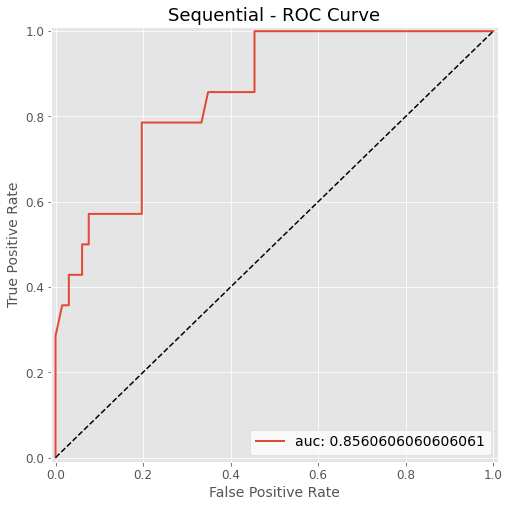

In [92]:
test_probability=weighted_model.predict(test_Features)

from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr, tpr, _ = roc_curve(test_df['Severity'], test_probability)
auc_NL = roc_auc_score(test_df['Severity'], test_probability)
plot_roc_curve(fpr, tpr, auc_NL, model)

test_class=weighted_model.predict_classes(test_Features)

pd.crosstab(test_df['Severity'], test_class[:,0])

test_probability=weighted_model.predict(test_Features)

In [93]:
scores=weighted_model.evaluate(test_Features, test_Label, verbose=0)

In [94]:
from sklearn.metrics import accuracy_score

accu_NL=accuracy_score(test_Label, test_class)

accu_NL

0.65

In [95]:
balance_accu_NL=balanced_accuracy_score(test_Label, test_class)
balance_accu_NL

0.7316017316017316

f1=0.462 auc_NL=0.6480 ap=0.6500


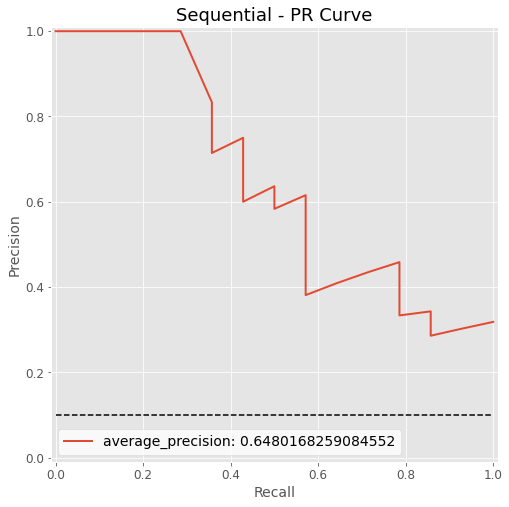

In [96]:
test_reshape=np.reshape(test_probability, test_probability.shape[0])

pd.crosstab(test_Label, test_reshape,
           rownames=['lable'], colnames=['prediction'])

# predict probabilities
test_probability=weighted_model.predict(test_Features)
pred_proba_NL = np.reshape(test_probability, test_probability.shape[0])
# keep probabilities for the positive outcome only
#pred_proba_NL = pred_proba_NL[:, 1]
# predict class values
yhat = weighted_model.predict_classes(test_Features)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_Label, pred_proba_NL)
# calculate F1 score
f1 = f1_score(test_Label, yhat)
# calculate precision-recall AUC
auc_NL_pr=auc(recall, precision)
# calculate average precision score
ap_NL_pr = average_precision_score(test_Label, pred_proba_NL)
print('f1=%.3f auc_NL=%.4f ap=%.4f' % (f1, auc_NL_pr, ap_NL_pr))

plot_precision_recall_curve(recall, precision, auc_NL_pr, weighted_model)

In [99]:
# Predict probability for all methods
df_pred=pd.DataFrame()
df_pred['Severity']=test_Label
df_pred['lr']=lr_clf.predict_proba(test_Features)[:, 1]
df_pred['rf']=rf_clf.predict_proba(test_Features)[:, 1]
df_pred['gbm']=gbm_clf.predict_proba(test_Features)[:, 1]
df_pred['svc']=svc_clf.predict_proba(test_Features)[:, 1]
df_pred['NL']=weighted_model.predict(test_Features)
df_pred.to_csv('20200508pred.csv')

In [100]:
df_pred

Severity        lr        rf       gbm       svc            NL
0        0.0  0.225086  0.485778  0.160394  0.148428  5.488982e-01
1        0.0  0.059690  0.217881  0.051793  0.144435  8.191109e-01
2        0.0  0.372717  0.724221  0.534227  0.362692  7.092863e-01
3        0.0  0.160059  0.270408  0.180466  0.140237  2.600697e-01
4        0.0  0.048463  0.215034  0.087188  0.042560  5.990267e-06
..       ...       ...       ...       ...       ...           ...
75       0.0  0.012098  0.047497  0.009952  0.033059  8.940697e-08
76       0.0  0.412729  0.799834  0.507239  0.415846  8.519977e-01
77       1.0  0.594685  0.805426  0.582473  0.780582  9.546201e-01
78       0.0  0.001696  0.038177  0.013287  0.021612  0.000000e+00
79       1.0  0.053760  0.320646  0.057791  0.073873  4.565726e-01

[80 rows x 6 columns]

# Deep learning 10-fold cross validation test

In [101]:
from sklearn.model_selection import StratifiedKFold
import numpy

In [102]:
seed = 7
numpy.random.seed(seed)

In [103]:
X, Y=PreprocessData(df)

In [114]:
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scores_NL=[]
roc_auc_NL=[]
f1_NL=[]
auc_NL_pr_all=[]
ap_NL_pr_all=[]
for train, test in kfold.split(X, Y):
   # create model
    model = tf.keras.Sequential([
      tf.keras.layers.Dense(200, activation='relu', input_shape=(train_Features.shape[-1],)),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(150, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(150, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')])

    model.compile(
      optimizer=tf.keras.optimizers.Adam(),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.AUC()]
    )
    unique, counts=numpy.unique(Y[train], return_counts=True)
    severe=counts[1]
    mild=counts[0]
    weight_for_0 = (1 / counts[0])*(counts.sum())/2.0 
    weight_for_1 = (1 / counts[1])*(counts.sum())/2.0

    class_weight = {0: weight_for_0, 1: weight_for_1}
    
    
    # Fit the model
    model.fit(X[train],Y[train], 
          epochs=400, batch_size=20, class_weight=class_weight, verbose=2)
    
    
    scores = model.evaluate(X[test], Y[test], verbose=0)[1]
    test_probability=model.predict(X[test])
    pred_proba_NL = np.reshape(test_probability,test_probability.shape[0])
    yhat = model.predict_classes(X[test])
    
    accu_NL = balanced_accuracy_score(Y[test], model.predict_classes(X[test]))
    auc_NL = roc_auc_score(Y[test],  pred_proba_NL)
    # calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(Y[test], pred_proba_NL)
    # calculate F1 score
    f1 = f1_score(Y[test], yhat)
    # calculate precision-recall AUC
    auc_NL_pr=auc(recall, precision)
    # calculate average precision score
    ap_NL_pr= average_precision_score(Y[test], pred_proba_NL)
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    #print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))
    scores_NL.append(accu_NL)
    roc_auc_NL.append(auc_NL)
    f1_NL.append( f1)
    auc_NL_pr_all.append(auc_NL_pr)
    ap_NL_pr_all.append(ap_NL_pr)

Train on 718 samples
Epoch 1/400
718/718 - 1s - loss: 0.6786 - auc_13: 0.6003
Epoch 2/400
718/718 - 0s - loss: 0.6279 - auc_13: 0.7010
Epoch 3/400
718/718 - 0s - loss: 0.5848 - auc_13: 0.7623
Epoch 4/400
718/718 - 0s - loss: 0.5834 - auc_13: 0.7644
Epoch 5/400
718/718 - 0s - loss: 0.5643 - auc_13: 0.7826
Epoch 6/400
718/718 - 0s - loss: 0.5370 - auc_13: 0.8085
Epoch 7/400
718/718 - 0s - loss: 0.5314 - auc_13: 0.8084
Epoch 8/400
718/718 - 0s - loss: 0.5382 - auc_13: 0.8012
Epoch 9/400
718/718 - 0s - loss: 0.5334 - auc_13: 0.8020
Epoch 10/400
718/718 - 0s - loss: 0.5332 - auc_13: 0.8004
Epoch 11/400
718/718 - 0s - loss: 0.5302 - auc_13: 0.8083
Epoch 12/400
718/718 - 0s - loss: 0.5254 - auc_13: 0.8162
Epoch 13/400
718/718 - 0s - loss: 0.5244 - auc_13: 0.8109
Epoch 14/400
718/718 - 0s - loss: 0.5261 - auc_13: 0.8103
Epoch 15/400
718/718 - 0s - loss: 0.5277 - auc_13: 0.8091
Epoch 16/400
718/718 - 0s - loss: 0.5309 - auc_13: 0.8115
Epoch 17/400
718/718 - 0s - loss: 0.5219 - auc_13: 0.8149
Ep

Epoch 142/400
718/718 - 0s - loss: 0.4544 - auc_13: 0.8556
Epoch 143/400
718/718 - 0s - loss: 0.4629 - auc_13: 0.8573
Epoch 144/400
718/718 - 0s - loss: 0.4585 - auc_13: 0.8539
Epoch 145/400
718/718 - 0s - loss: 0.4478 - auc_13: 0.8597
Epoch 146/400
718/718 - 0s - loss: 0.4482 - auc_13: 0.8593
Epoch 147/400
718/718 - 0s - loss: 0.4526 - auc_13: 0.8546
Epoch 148/400
718/718 - 0s - loss: 0.4626 - auc_13: 0.8557
Epoch 149/400
718/718 - 0s - loss: 0.4587 - auc_13: 0.8513
Epoch 150/400
718/718 - 0s - loss: 0.4498 - auc_13: 0.8605
Epoch 151/400
718/718 - 0s - loss: 0.4370 - auc_13: 0.8706
Epoch 152/400
718/718 - 0s - loss: 0.4465 - auc_13: 0.8624
Epoch 153/400
718/718 - 0s - loss: 0.4357 - auc_13: 0.8662
Epoch 154/400
718/718 - 0s - loss: 0.4688 - auc_13: 0.8559
Epoch 155/400
718/718 - 0s - loss: 0.4687 - auc_13: 0.8475
Epoch 156/400
718/718 - 0s - loss: 0.4551 - auc_13: 0.8557
Epoch 157/400
718/718 - 0s - loss: 0.4447 - auc_13: 0.8656
Epoch 158/400
718/718 - 0s - loss: 0.4663 - auc_13: 0.84

Epoch 281/400
718/718 - 0s - loss: 0.4327 - auc_13: 0.8679
Epoch 282/400
718/718 - 0s - loss: 0.4387 - auc_13: 0.8636
Epoch 283/400
718/718 - 0s - loss: 0.4567 - auc_13: 0.8690
Epoch 284/400
718/718 - 0s - loss: 0.4356 - auc_13: 0.8727
Epoch 285/400
718/718 - 0s - loss: 0.4506 - auc_13: 0.8580
Epoch 286/400
718/718 - 0s - loss: 0.4387 - auc_13: 0.8634
Epoch 287/400
718/718 - 0s - loss: 0.4317 - auc_13: 0.8733
Epoch 288/400
718/718 - 0s - loss: 0.4271 - auc_13: 0.8755
Epoch 289/400
718/718 - 0s - loss: 0.4406 - auc_13: 0.8656
Epoch 290/400
718/718 - 0s - loss: 0.4345 - auc_13: 0.8707
Epoch 291/400
718/718 - 0s - loss: 0.4447 - auc_13: 0.8597
Epoch 292/400
718/718 - 0s - loss: 0.4432 - auc_13: 0.8666
Epoch 293/400
718/718 - 0s - loss: 0.4333 - auc_13: 0.8722
Epoch 294/400
718/718 - 0s - loss: 0.4428 - auc_13: 0.8607
Epoch 295/400
718/718 - 0s - loss: 0.4427 - auc_13: 0.8654
Epoch 296/400
718/718 - 0s - loss: 0.4367 - auc_13: 0.8690
Epoch 297/400
718/718 - 0s - loss: 0.4391 - auc_13: 0.86

Epoch 20/400
718/718 - 0s - loss: 0.5243 - auc_14: 0.8167
Epoch 21/400
718/718 - 0s - loss: 0.5155 - auc_14: 0.8191
Epoch 22/400
718/718 - 0s - loss: 0.5021 - auc_14: 0.8320
Epoch 23/400
718/718 - 0s - loss: 0.5078 - auc_14: 0.8258
Epoch 24/400
718/718 - 0s - loss: 0.5431 - auc_14: 0.8002
Epoch 25/400
718/718 - 0s - loss: 0.5110 - auc_14: 0.8245
Epoch 26/400
718/718 - 0s - loss: 0.5042 - auc_14: 0.8294
Epoch 27/400
718/718 - 0s - loss: 0.4941 - auc_14: 0.8411
Epoch 28/400
718/718 - 0s - loss: 0.5053 - auc_14: 0.8256
Epoch 29/400
718/718 - 0s - loss: 0.5129 - auc_14: 0.8235
Epoch 30/400
718/718 - 0s - loss: 0.4983 - auc_14: 0.8321
Epoch 31/400
718/718 - 0s - loss: 0.4895 - auc_14: 0.8414
Epoch 32/400
718/718 - 0s - loss: 0.4997 - auc_14: 0.8321
Epoch 33/400
718/718 - 0s - loss: 0.5060 - auc_14: 0.8262
Epoch 34/400
718/718 - 0s - loss: 0.5103 - auc_14: 0.8207
Epoch 35/400
718/718 - 0s - loss: 0.4965 - auc_14: 0.8329
Epoch 36/400
718/718 - 0s - loss: 0.4942 - auc_14: 0.8345
Epoch 37/400
7

718/718 - 0s - loss: 0.4493 - auc_14: 0.8564
Epoch 161/400
718/718 - 0s - loss: 0.4615 - auc_14: 0.8486
Epoch 162/400
718/718 - 0s - loss: 0.4408 - auc_14: 0.8639
Epoch 163/400
718/718 - 0s - loss: 0.4475 - auc_14: 0.8608
Epoch 164/400
718/718 - 0s - loss: 0.4374 - auc_14: 0.8648
Epoch 165/400
718/718 - 0s - loss: 0.4470 - auc_14: 0.8590
Epoch 166/400
718/718 - 0s - loss: 0.4575 - auc_14: 0.8522
Epoch 167/400
718/718 - 0s - loss: 0.4602 - auc_14: 0.8547
Epoch 168/400
718/718 - 0s - loss: 0.4364 - auc_14: 0.8676
Epoch 169/400
718/718 - 0s - loss: 0.4473 - auc_14: 0.8642
Epoch 170/400
718/718 - 0s - loss: 0.4286 - auc_14: 0.8744
Epoch 171/400
718/718 - 0s - loss: 0.4570 - auc_14: 0.8596
Epoch 172/400
718/718 - 0s - loss: 0.4460 - auc_14: 0.8610
Epoch 173/400
718/718 - 0s - loss: 0.4486 - auc_14: 0.8629
Epoch 174/400
718/718 - 0s - loss: 0.4424 - auc_14: 0.8694
Epoch 175/400
718/718 - 0s - loss: 0.4272 - auc_14: 0.8781
Epoch 176/400
718/718 - 0s - loss: 0.4699 - auc_14: 0.8465
Epoch 177/4

718/718 - 0s - loss: 0.4325 - auc_14: 0.8698
Epoch 300/400
718/718 - 0s - loss: 0.4341 - auc_14: 0.8708
Epoch 301/400
718/718 - 0s - loss: 0.4250 - auc_14: 0.8778
Epoch 302/400
718/718 - 0s - loss: 0.4403 - auc_14: 0.8676
Epoch 303/400
718/718 - 0s - loss: 0.4249 - auc_14: 0.8741
Epoch 304/400
718/718 - 0s - loss: 0.4323 - auc_14: 0.8686
Epoch 305/400
718/718 - 0s - loss: 0.4184 - auc_14: 0.8770
Epoch 306/400
718/718 - 0s - loss: 0.4328 - auc_14: 0.8694
Epoch 307/400
718/718 - 0s - loss: 0.4340 - auc_14: 0.8691
Epoch 308/400
718/718 - 0s - loss: 0.4286 - auc_14: 0.8725
Epoch 309/400
718/718 - 0s - loss: 0.4239 - auc_14: 0.8725
Epoch 310/400
718/718 - 0s - loss: 0.4188 - auc_14: 0.8740
Epoch 311/400
718/718 - 0s - loss: 0.4214 - auc_14: 0.8761
Epoch 312/400
718/718 - 0s - loss: 0.4332 - auc_14: 0.8710
Epoch 313/400
718/718 - 0s - loss: 0.4388 - auc_14: 0.8683
Epoch 314/400
718/718 - 0s - loss: 0.4435 - auc_14: 0.8718
Epoch 315/400
718/718 - 0s - loss: 0.4328 - auc_14: 0.8703
Epoch 316/4

Epoch 39/400
718/718 - 0s - loss: 0.5046 - auc_15: 0.8242
Epoch 40/400
718/718 - 0s - loss: 0.4858 - auc_15: 0.8370
Epoch 41/400
718/718 - 0s - loss: 0.4861 - auc_15: 0.8353
Epoch 42/400
718/718 - 0s - loss: 0.4901 - auc_15: 0.8378
Epoch 43/400
718/718 - 0s - loss: 0.4834 - auc_15: 0.8422
Epoch 44/400
718/718 - 0s - loss: 0.4915 - auc_15: 0.8315
Epoch 45/400
718/718 - 0s - loss: 0.4973 - auc_15: 0.8344
Epoch 46/400
718/718 - 0s - loss: 0.4721 - auc_15: 0.8524
Epoch 47/400
718/718 - 0s - loss: 0.4856 - auc_15: 0.8417
Epoch 48/400
718/718 - 0s - loss: 0.4793 - auc_15: 0.8423
Epoch 49/400
718/718 - 0s - loss: 0.4828 - auc_15: 0.8444
Epoch 50/400
718/718 - 0s - loss: 0.4799 - auc_15: 0.8454
Epoch 51/400
718/718 - 0s - loss: 0.4829 - auc_15: 0.8395
Epoch 52/400
718/718 - 0s - loss: 0.4839 - auc_15: 0.8380
Epoch 53/400
718/718 - 0s - loss: 0.4938 - auc_15: 0.8417
Epoch 54/400
718/718 - 0s - loss: 0.4807 - auc_15: 0.8446
Epoch 55/400
718/718 - 0s - loss: 0.4962 - auc_15: 0.8324
Epoch 56/400
7

Epoch 179/400
718/718 - 0s - loss: 0.4589 - auc_15: 0.8583
Epoch 180/400
718/718 - 0s - loss: 0.4498 - auc_15: 0.8607
Epoch 181/400
718/718 - 0s - loss: 0.4527 - auc_15: 0.8563
Epoch 182/400
718/718 - 0s - loss: 0.4387 - auc_15: 0.8681
Epoch 183/400
718/718 - 0s - loss: 0.4462 - auc_15: 0.8575
Epoch 184/400
718/718 - 0s - loss: 0.4505 - auc_15: 0.8597
Epoch 185/400
718/718 - 0s - loss: 0.4527 - auc_15: 0.8572
Epoch 186/400
718/718 - 0s - loss: 0.4583 - auc_15: 0.8586
Epoch 187/400
718/718 - 0s - loss: 0.4497 - auc_15: 0.8635
Epoch 188/400
718/718 - 0s - loss: 0.4372 - auc_15: 0.8670
Epoch 189/400
718/718 - 0s - loss: 0.4445 - auc_15: 0.8601
Epoch 190/400
718/718 - 0s - loss: 0.4629 - auc_15: 0.8515
Epoch 191/400
718/718 - 0s - loss: 0.4502 - auc_15: 0.8593
Epoch 192/400
718/718 - 0s - loss: 0.4596 - auc_15: 0.8556
Epoch 193/400
718/718 - 0s - loss: 0.4533 - auc_15: 0.8575
Epoch 194/400
718/718 - 0s - loss: 0.4395 - auc_15: 0.8679
Epoch 195/400
718/718 - 0s - loss: 0.4447 - auc_15: 0.86

Epoch 318/400
718/718 - 0s - loss: 0.4384 - auc_15: 0.8668
Epoch 319/400
718/718 - 0s - loss: 0.4450 - auc_15: 0.8612
Epoch 320/400
718/718 - 0s - loss: 0.4337 - auc_15: 0.8666
Epoch 321/400
718/718 - 0s - loss: 0.4307 - auc_15: 0.8684
Epoch 322/400
718/718 - 0s - loss: 0.4422 - auc_15: 0.8638
Epoch 323/400
718/718 - 0s - loss: 0.4405 - auc_15: 0.8631
Epoch 324/400
718/718 - 0s - loss: 0.4457 - auc_15: 0.8583
Epoch 325/400
718/718 - 0s - loss: 0.4309 - auc_15: 0.8727
Epoch 326/400
718/718 - 0s - loss: 0.4306 - auc_15: 0.8685
Epoch 327/400
718/718 - 0s - loss: 0.4288 - auc_15: 0.8703
Epoch 328/400
718/718 - 0s - loss: 0.4465 - auc_15: 0.8607
Epoch 329/400
718/718 - 0s - loss: 0.4249 - auc_15: 0.8732
Epoch 330/400
718/718 - 0s - loss: 0.4288 - auc_15: 0.8722
Epoch 331/400
718/718 - 0s - loss: 0.4381 - auc_15: 0.8661
Epoch 332/400
718/718 - 0s - loss: 0.4403 - auc_15: 0.8627
Epoch 333/400
718/718 - 0s - loss: 0.4384 - auc_15: 0.8660
Epoch 334/400
718/718 - 0s - loss: 0.4512 - auc_15: 0.85

Epoch 58/400
718/718 - 0s - loss: 0.4589 - auc_16: 0.8572
Epoch 59/400
718/718 - 0s - loss: 0.4625 - auc_16: 0.8539
Epoch 60/400
718/718 - 0s - loss: 0.4594 - auc_16: 0.8552
Epoch 61/400
718/718 - 0s - loss: 0.4682 - auc_16: 0.8483
Epoch 62/400
718/718 - 0s - loss: 0.4704 - auc_16: 0.8520
Epoch 63/400
718/718 - 0s - loss: 0.4554 - auc_16: 0.8619
Epoch 64/400
718/718 - 0s - loss: 0.4433 - auc_16: 0.8663
Epoch 65/400
718/718 - 0s - loss: 0.4605 - auc_16: 0.8575
Epoch 66/400
718/718 - 0s - loss: 0.4627 - auc_16: 0.8536
Epoch 67/400
718/718 - 0s - loss: 0.4674 - auc_16: 0.8479
Epoch 68/400
718/718 - 0s - loss: 0.4465 - auc_16: 0.8655
Epoch 69/400
718/718 - 0s - loss: 0.4748 - auc_16: 0.8461
Epoch 70/400
718/718 - 0s - loss: 0.4503 - auc_16: 0.8643
Epoch 71/400
718/718 - 0s - loss: 0.4529 - auc_16: 0.8565
Epoch 72/400
718/718 - 0s - loss: 0.4454 - auc_16: 0.8639
Epoch 73/400
718/718 - 0s - loss: 0.4396 - auc_16: 0.8623
Epoch 74/400
718/718 - 0s - loss: 0.4460 - auc_16: 0.8647
Epoch 75/400
7

Epoch 198/400
718/718 - 0s - loss: 0.4386 - auc_16: 0.8681
Epoch 199/400
718/718 - 0s - loss: 0.4245 - auc_16: 0.8741
Epoch 200/400
718/718 - 0s - loss: 0.4445 - auc_16: 0.8614
Epoch 201/400
718/718 - 0s - loss: 0.4314 - auc_16: 0.8688
Epoch 202/400
718/718 - 0s - loss: 0.4322 - auc_16: 0.8706
Epoch 203/400
718/718 - 0s - loss: 0.4203 - auc_16: 0.8784
Epoch 204/400
718/718 - 0s - loss: 0.4379 - auc_16: 0.8690
Epoch 205/400
718/718 - 0s - loss: 0.4521 - auc_16: 0.8574
Epoch 206/400
718/718 - 0s - loss: 0.4319 - auc_16: 0.8714
Epoch 207/400
718/718 - 0s - loss: 0.4256 - auc_16: 0.8736
Epoch 208/400
718/718 - 0s - loss: 0.4362 - auc_16: 0.8636
Epoch 209/400
718/718 - 0s - loss: 0.4536 - auc_16: 0.8560
Epoch 210/400
718/718 - 0s - loss: 0.4402 - auc_16: 0.8686
Epoch 211/400
718/718 - 0s - loss: 0.4276 - auc_16: 0.8736
Epoch 212/400
718/718 - 0s - loss: 0.4267 - auc_16: 0.8716
Epoch 213/400
718/718 - 0s - loss: 0.4341 - auc_16: 0.8679
Epoch 214/400
718/718 - 0s - loss: 0.4250 - auc_16: 0.87

Epoch 337/400
718/718 - 0s - loss: 0.4504 - auc_16: 0.8576
Epoch 338/400
718/718 - 0s - loss: 0.4267 - auc_16: 0.8708
Epoch 339/400
718/718 - 0s - loss: 0.4464 - auc_16: 0.8657
Epoch 340/400
718/718 - 0s - loss: 0.4246 - auc_16: 0.8738
Epoch 341/400
718/718 - 0s - loss: 0.4329 - auc_16: 0.8681
Epoch 342/400
718/718 - 0s - loss: 0.4319 - auc_16: 0.8714
Epoch 343/400
718/718 - 0s - loss: 0.4196 - auc_16: 0.8766
Epoch 344/400
718/718 - 0s - loss: 0.4501 - auc_16: 0.8593
Epoch 345/400
718/718 - 0s - loss: 0.4318 - auc_16: 0.8709
Epoch 346/400
718/718 - 0s - loss: 0.4228 - auc_16: 0.8732
Epoch 347/400
718/718 - 0s - loss: 0.4408 - auc_16: 0.8633
Epoch 348/400
718/718 - 0s - loss: 0.4367 - auc_16: 0.8677
Epoch 349/400
718/718 - 0s - loss: 0.4348 - auc_16: 0.8662
Epoch 350/400
718/718 - 0s - loss: 0.4386 - auc_16: 0.8686
Epoch 351/400
718/718 - 0s - loss: 0.4245 - auc_16: 0.8766
Epoch 352/400
718/718 - 0s - loss: 0.4270 - auc_16: 0.8727
Epoch 353/400
718/718 - 0s - loss: 0.4165 - auc_16: 0.87

Epoch 77/400
718/718 - 0s - loss: 0.4827 - auc_17: 0.8371
Epoch 78/400
718/718 - 0s - loss: 0.4674 - auc_17: 0.8481
Epoch 79/400
718/718 - 0s - loss: 0.4727 - auc_17: 0.8459
Epoch 80/400
718/718 - 0s - loss: 0.4773 - auc_17: 0.8436
Epoch 81/400
718/718 - 0s - loss: 0.4688 - auc_17: 0.8465
Epoch 82/400
718/718 - 0s - loss: 0.4768 - auc_17: 0.8410
Epoch 83/400
718/718 - 0s - loss: 0.4750 - auc_17: 0.8401
Epoch 84/400
718/718 - 0s - loss: 0.4626 - auc_17: 0.8482
Epoch 85/400
718/718 - 0s - loss: 0.4696 - auc_17: 0.8438
Epoch 86/400
718/718 - 0s - loss: 0.4701 - auc_17: 0.8452
Epoch 87/400
718/718 - 0s - loss: 0.4652 - auc_17: 0.8479
Epoch 88/400
718/718 - 0s - loss: 0.4818 - auc_17: 0.8384
Epoch 89/400
718/718 - 0s - loss: 0.4756 - auc_17: 0.8397
Epoch 90/400
718/718 - 0s - loss: 0.4632 - auc_17: 0.8433
Epoch 91/400
718/718 - 0s - loss: 0.4609 - auc_17: 0.8506
Epoch 92/400
718/718 - 0s - loss: 0.4824 - auc_17: 0.8349
Epoch 93/400
718/718 - 0s - loss: 0.4865 - auc_17: 0.8342
Epoch 94/400
7

Epoch 217/400
718/718 - 0s - loss: 0.4585 - auc_17: 0.8520
Epoch 218/400
718/718 - 0s - loss: 0.4496 - auc_17: 0.8610
Epoch 219/400
718/718 - 0s - loss: 0.4588 - auc_17: 0.8563
Epoch 220/400
718/718 - 0s - loss: 0.4457 - auc_17: 0.8639
Epoch 221/400
718/718 - 0s - loss: 0.4495 - auc_17: 0.8605
Epoch 222/400
718/718 - 0s - loss: 0.4459 - auc_17: 0.8616
Epoch 223/400
718/718 - 0s - loss: 0.4713 - auc_17: 0.8437
Epoch 224/400
718/718 - 0s - loss: 0.4491 - auc_17: 0.8588
Epoch 225/400
718/718 - 0s - loss: 0.4558 - auc_17: 0.8553
Epoch 226/400
718/718 - 0s - loss: 0.4512 - auc_17: 0.8565
Epoch 227/400
718/718 - 0s - loss: 0.4382 - auc_17: 0.8700
Epoch 228/400
718/718 - 0s - loss: 0.4505 - auc_17: 0.8615
Epoch 229/400
718/718 - 0s - loss: 0.4519 - auc_17: 0.8561
Epoch 230/400
718/718 - 0s - loss: 0.4561 - auc_17: 0.8557
Epoch 231/400
718/718 - 0s - loss: 0.4463 - auc_17: 0.8629
Epoch 232/400
718/718 - 0s - loss: 0.4359 - auc_17: 0.8670
Epoch 233/400
718/718 - 0s - loss: 0.4333 - auc_17: 0.87

Epoch 356/400
718/718 - 0s - loss: 0.4401 - auc_17: 0.8662
Epoch 357/400
718/718 - 0s - loss: 0.4355 - auc_17: 0.8669
Epoch 358/400
718/718 - 0s - loss: 0.4388 - auc_17: 0.8644
Epoch 359/400
718/718 - 0s - loss: 0.4371 - auc_17: 0.8693
Epoch 360/400
718/718 - 0s - loss: 0.4313 - auc_17: 0.8661
Epoch 361/400
718/718 - 0s - loss: 0.4389 - auc_17: 0.8672
Epoch 362/400
718/718 - 0s - loss: 0.4340 - auc_17: 0.8686
Epoch 363/400
718/718 - 0s - loss: 0.4464 - auc_17: 0.8606
Epoch 364/400
718/718 - 0s - loss: 0.4415 - auc_17: 0.8636
Epoch 365/400
718/718 - 0s - loss: 0.4334 - auc_17: 0.8688
Epoch 366/400
718/718 - 0s - loss: 0.4310 - auc_17: 0.8688
Epoch 367/400
718/718 - 0s - loss: 0.4418 - auc_17: 0.8612
Epoch 368/400
718/718 - 0s - loss: 0.4399 - auc_17: 0.8659
Epoch 369/400
718/718 - 0s - loss: 0.4292 - auc_17: 0.8714
Epoch 370/400
718/718 - 0s - loss: 0.4485 - auc_17: 0.8566
Epoch 371/400
718/718 - 0s - loss: 0.4310 - auc_17: 0.8684
Epoch 372/400
718/718 - 0s - loss: 0.4462 - auc_17: 0.86

Epoch 97/400
718/718 - 0s - loss: 0.4672 - auc_18: 0.8483
Epoch 98/400
718/718 - 0s - loss: 0.4445 - auc_18: 0.8634
Epoch 99/400
718/718 - 0s - loss: 0.4412 - auc_18: 0.8635
Epoch 100/400
718/718 - 0s - loss: 0.4473 - auc_18: 0.8614
Epoch 101/400
718/718 - 0s - loss: 0.4524 - auc_18: 0.8584
Epoch 102/400
718/718 - 0s - loss: 0.4599 - auc_18: 0.8574
Epoch 103/400
718/718 - 0s - loss: 0.4485 - auc_18: 0.8622
Epoch 104/400
718/718 - 0s - loss: 0.4364 - auc_18: 0.8676
Epoch 105/400
718/718 - 0s - loss: 0.4597 - auc_18: 0.8542
Epoch 106/400
718/718 - 0s - loss: 0.4453 - auc_18: 0.8640
Epoch 107/400
718/718 - 0s - loss: 0.4706 - auc_18: 0.8499
Epoch 108/400
718/718 - 0s - loss: 0.4555 - auc_18: 0.8519
Epoch 109/400
718/718 - 0s - loss: 0.4556 - auc_18: 0.8536
Epoch 110/400
718/718 - 0s - loss: 0.4416 - auc_18: 0.8615
Epoch 111/400
718/718 - 0s - loss: 0.4427 - auc_18: 0.8633
Epoch 112/400
718/718 - 0s - loss: 0.4472 - auc_18: 0.8647
Epoch 113/400
718/718 - 0s - loss: 0.4511 - auc_18: 0.8572


Epoch 236/400
718/718 - 0s - loss: 0.4425 - auc_18: 0.8629
Epoch 237/400
718/718 - 0s - loss: 0.4479 - auc_18: 0.8597
Epoch 238/400
718/718 - 0s - loss: 0.4327 - auc_18: 0.8708
Epoch 239/400
718/718 - 0s - loss: 0.4261 - auc_18: 0.8754
Epoch 240/400
718/718 - 0s - loss: 0.4362 - auc_18: 0.8688
Epoch 241/400
718/718 - 0s - loss: 0.4391 - auc_18: 0.8650
Epoch 242/400
718/718 - 0s - loss: 0.4332 - auc_18: 0.8700
Epoch 243/400
718/718 - 0s - loss: 0.4381 - auc_18: 0.8643
Epoch 244/400
718/718 - 0s - loss: 0.4274 - auc_18: 0.8738
Epoch 245/400
718/718 - 0s - loss: 0.4394 - auc_18: 0.8637
Epoch 246/400
718/718 - 0s - loss: 0.4244 - auc_18: 0.8724
Epoch 247/400
718/718 - 0s - loss: 0.4438 - auc_18: 0.8630
Epoch 248/400
718/718 - 0s - loss: 0.4289 - auc_18: 0.8724
Epoch 249/400
718/718 - 0s - loss: 0.4195 - auc_18: 0.8771
Epoch 250/400
718/718 - 0s - loss: 0.4383 - auc_18: 0.8699
Epoch 251/400
718/718 - 0s - loss: 0.4284 - auc_18: 0.8740
Epoch 252/400
718/718 - 0s - loss: 0.4243 - auc_18: 0.87

Epoch 375/400
718/718 - 0s - loss: 0.4342 - auc_18: 0.8697
Epoch 376/400
718/718 - 0s - loss: 0.4280 - auc_18: 0.8749
Epoch 377/400
718/718 - 0s - loss: 0.4229 - auc_18: 0.8738
Epoch 378/400
718/718 - 0s - loss: 0.4308 - auc_18: 0.8753
Epoch 379/400
718/718 - 0s - loss: 0.4294 - auc_18: 0.8704
Epoch 380/400
718/718 - 0s - loss: 0.4287 - auc_18: 0.8733
Epoch 381/400
718/718 - 0s - loss: 0.4218 - auc_18: 0.8758
Epoch 382/400
718/718 - 0s - loss: 0.4269 - auc_18: 0.8755
Epoch 383/400
718/718 - 0s - loss: 0.4270 - auc_18: 0.8756
Epoch 384/400
718/718 - 0s - loss: 0.4311 - auc_18: 0.8712
Epoch 385/400
718/718 - 0s - loss: 0.4361 - auc_18: 0.8673
Epoch 386/400
718/718 - 0s - loss: 0.4263 - auc_18: 0.8727
Epoch 387/400
718/718 - 0s - loss: 0.4266 - auc_18: 0.8767
Epoch 388/400
718/718 - 0s - loss: 0.4223 - auc_18: 0.8750
Epoch 389/400
718/718 - 0s - loss: 0.4295 - auc_18: 0.8744
Epoch 390/400
718/718 - 0s - loss: 0.4345 - auc_18: 0.8693
Epoch 391/400
718/718 - 0s - loss: 0.4118 - auc_18: 0.87

Epoch 116/400
718/718 - 0s - loss: 0.4546 - auc_19: 0.8558
Epoch 117/400
718/718 - 0s - loss: 0.4463 - auc_19: 0.8576
Epoch 118/400
718/718 - 0s - loss: 0.4509 - auc_19: 0.8555
Epoch 119/400
718/718 - 0s - loss: 0.4622 - auc_19: 0.8529
Epoch 120/400
718/718 - 0s - loss: 0.4224 - auc_19: 0.8732
Epoch 121/400
718/718 - 0s - loss: 0.4510 - auc_19: 0.8599
Epoch 122/400
718/718 - 0s - loss: 0.4541 - auc_19: 0.8546
Epoch 123/400
718/718 - 0s - loss: 0.4550 - auc_19: 0.8561
Epoch 124/400
718/718 - 0s - loss: 0.4335 - auc_19: 0.8703
Epoch 125/400
718/718 - 0s - loss: 0.4540 - auc_19: 0.8582
Epoch 126/400
718/718 - 0s - loss: 0.4499 - auc_19: 0.8592
Epoch 127/400
718/718 - 0s - loss: 0.4397 - auc_19: 0.8665
Epoch 128/400
718/718 - 0s - loss: 0.4448 - auc_19: 0.8620
Epoch 129/400
718/718 - 0s - loss: 0.4516 - auc_19: 0.8578
Epoch 130/400
718/718 - 0s - loss: 0.4396 - auc_19: 0.8638
Epoch 131/400
718/718 - 0s - loss: 0.4607 - auc_19: 0.8534
Epoch 132/400
718/718 - 0s - loss: 0.4639 - auc_19: 0.85

Epoch 255/400
718/718 - 0s - loss: 0.4269 - auc_19: 0.8725
Epoch 256/400
718/718 - 0s - loss: 0.4388 - auc_19: 0.8678
Epoch 257/400
718/718 - 0s - loss: 0.4292 - auc_19: 0.8738
Epoch 258/400
718/718 - 0s - loss: 0.4467 - auc_19: 0.8615
Epoch 259/400
718/718 - 0s - loss: 0.4208 - auc_19: 0.8757
Epoch 260/400
718/718 - 0s - loss: 0.4273 - auc_19: 0.8718
Epoch 261/400
718/718 - 0s - loss: 0.4424 - auc_19: 0.8639
Epoch 262/400
718/718 - 0s - loss: 0.4202 - auc_19: 0.8778
Epoch 263/400
718/718 - 0s - loss: 0.4313 - auc_19: 0.8672
Epoch 264/400
718/718 - 0s - loss: 0.4373 - auc_19: 0.8657
Epoch 265/400
718/718 - 0s - loss: 0.4404 - auc_19: 0.8652
Epoch 266/400
718/718 - 0s - loss: 0.4375 - auc_19: 0.8666
Epoch 267/400
718/718 - 0s - loss: 0.4204 - auc_19: 0.8757
Epoch 268/400
718/718 - 0s - loss: 0.4323 - auc_19: 0.8671
Epoch 269/400
718/718 - 0s - loss: 0.4535 - auc_19: 0.8548
Epoch 270/400
718/718 - 0s - loss: 0.4429 - auc_19: 0.8637
Epoch 271/400
718/718 - 0s - loss: 0.4321 - auc_19: 0.86

Epoch 394/400
718/718 - 0s - loss: 0.4315 - auc_19: 0.8672
Epoch 395/400
718/718 - 0s - loss: 0.4202 - auc_19: 0.8769
Epoch 396/400
718/718 - 0s - loss: 0.4179 - auc_19: 0.8754
Epoch 397/400
718/718 - 0s - loss: 0.4352 - auc_19: 0.8735
Epoch 398/400
718/718 - 0s - loss: 0.4372 - auc_19: 0.8725
Epoch 399/400
718/718 - 0s - loss: 0.4458 - auc_19: 0.8666
Epoch 400/400
718/718 - 0s - loss: 0.4301 - auc_19: 0.8679
Train on 718 samples
Epoch 1/400
718/718 - 1s - loss: 0.6729 - auc_20: 0.6538
Epoch 2/400
718/718 - 0s - loss: 0.6388 - auc_20: 0.6922
Epoch 3/400
718/718 - 0s - loss: 0.5999 - auc_20: 0.7436
Epoch 4/400
718/718 - 0s - loss: 0.5975 - auc_20: 0.7428
Epoch 5/400
718/718 - 0s - loss: 0.5863 - auc_20: 0.7639
Epoch 6/400
718/718 - 0s - loss: 0.5514 - auc_20: 0.8023
Epoch 7/400
718/718 - 0s - loss: 0.5494 - auc_20: 0.7913
Epoch 8/400
718/718 - 0s - loss: 0.5510 - auc_20: 0.7895
Epoch 9/400
718/718 - 0s - loss: 0.5246 - auc_20: 0.8185
Epoch 10/400
718/718 - 0s - loss: 0.5367 - auc_20: 0.

Epoch 135/400
718/718 - 0s - loss: 0.4644 - auc_20: 0.8524
Epoch 136/400
718/718 - 0s - loss: 0.4639 - auc_20: 0.8481
Epoch 137/400
718/718 - 0s - loss: 0.4568 - auc_20: 0.8546
Epoch 138/400
718/718 - 0s - loss: 0.4640 - auc_20: 0.8535
Epoch 139/400
718/718 - 0s - loss: 0.4671 - auc_20: 0.8495
Epoch 140/400
718/718 - 0s - loss: 0.4650 - auc_20: 0.8522
Epoch 141/400
718/718 - 0s - loss: 0.4552 - auc_20: 0.8584
Epoch 142/400
718/718 - 0s - loss: 0.4557 - auc_20: 0.8568
Epoch 143/400
718/718 - 0s - loss: 0.4728 - auc_20: 0.8438
Epoch 144/400
718/718 - 0s - loss: 0.4475 - auc_20: 0.8600
Epoch 145/400
718/718 - 0s - loss: 0.4536 - auc_20: 0.8565
Epoch 146/400
718/718 - 0s - loss: 0.4668 - auc_20: 0.8519
Epoch 147/400
718/718 - 0s - loss: 0.4461 - auc_20: 0.8611
Epoch 148/400
718/718 - 0s - loss: 0.4595 - auc_20: 0.8574
Epoch 149/400
718/718 - 0s - loss: 0.4592 - auc_20: 0.8549
Epoch 150/400
718/718 - 0s - loss: 0.4563 - auc_20: 0.8554
Epoch 151/400
718/718 - 0s - loss: 0.4513 - auc_20: 0.85

Epoch 274/400
718/718 - 0s - loss: 0.4415 - auc_20: 0.8685
Epoch 275/400
718/718 - 0s - loss: 0.4472 - auc_20: 0.8620
Epoch 276/400
718/718 - 0s - loss: 0.4424 - auc_20: 0.8653
Epoch 277/400
718/718 - 0s - loss: 0.4494 - auc_20: 0.8604
Epoch 278/400
718/718 - 0s - loss: 0.4508 - auc_20: 0.8604
Epoch 279/400
718/718 - 0s - loss: 0.4446 - auc_20: 0.8659
Epoch 280/400
718/718 - 0s - loss: 0.4472 - auc_20: 0.8596
Epoch 281/400
718/718 - 0s - loss: 0.4548 - auc_20: 0.8592
Epoch 282/400
718/718 - 0s - loss: 0.4365 - auc_20: 0.8696
Epoch 283/400
718/718 - 0s - loss: 0.4523 - auc_20: 0.8619
Epoch 284/400
718/718 - 0s - loss: 0.4385 - auc_20: 0.8669
Epoch 285/400
718/718 - 0s - loss: 0.4551 - auc_20: 0.8577
Epoch 286/400
718/718 - 0s - loss: 0.4564 - auc_20: 0.8567
Epoch 287/400
718/718 - 0s - loss: 0.4510 - auc_20: 0.8603
Epoch 288/400
718/718 - 0s - loss: 0.4479 - auc_20: 0.8595
Epoch 289/400
718/718 - 0s - loss: 0.4593 - auc_20: 0.8584
Epoch 290/400
718/718 - 0s - loss: 0.4500 - auc_20: 0.86

Epoch 13/400
719/719 - 0s - loss: 0.5380 - auc_21: 0.8051
Epoch 14/400
719/719 - 0s - loss: 0.5209 - auc_21: 0.8204
Epoch 15/400
719/719 - 0s - loss: 0.5327 - auc_21: 0.8068
Epoch 16/400
719/719 - 0s - loss: 0.5171 - auc_21: 0.8224
Epoch 17/400
719/719 - 0s - loss: 0.5180 - auc_21: 0.8203
Epoch 18/400
719/719 - 0s - loss: 0.5048 - auc_21: 0.8308
Epoch 19/400
719/719 - 0s - loss: 0.5166 - auc_21: 0.8209
Epoch 20/400
719/719 - 0s - loss: 0.5126 - auc_21: 0.8249
Epoch 21/400
719/719 - 0s - loss: 0.5021 - auc_21: 0.8342
Epoch 22/400
719/719 - 0s - loss: 0.5113 - auc_21: 0.8230
Epoch 23/400
719/719 - 0s - loss: 0.5208 - auc_21: 0.8150
Epoch 24/400
719/719 - 0s - loss: 0.4992 - auc_21: 0.8313
Epoch 25/400
719/719 - 0s - loss: 0.5125 - auc_21: 0.8272
Epoch 26/400
719/719 - 0s - loss: 0.5069 - auc_21: 0.8288
Epoch 27/400
719/719 - 0s - loss: 0.5034 - auc_21: 0.8309
Epoch 28/400
719/719 - 0s - loss: 0.5068 - auc_21: 0.8314
Epoch 29/400
719/719 - 0s - loss: 0.4989 - auc_21: 0.8346
Epoch 30/400
7

Epoch 154/400
719/719 - 0s - loss: 0.4694 - auc_21: 0.8486
Epoch 155/400
719/719 - 0s - loss: 0.4597 - auc_21: 0.8576
Epoch 156/400
719/719 - 0s - loss: 0.4530 - auc_21: 0.8584
Epoch 157/400
719/719 - 0s - loss: 0.4525 - auc_21: 0.8586
Epoch 158/400
719/719 - 0s - loss: 0.4592 - auc_21: 0.8521
Epoch 159/400
719/719 - 0s - loss: 0.4615 - auc_21: 0.8526
Epoch 160/400
719/719 - 0s - loss: 0.4586 - auc_21: 0.8573
Epoch 161/400
719/719 - 0s - loss: 0.4511 - auc_21: 0.8596
Epoch 162/400
719/719 - 0s - loss: 0.4598 - auc_21: 0.8548
Epoch 163/400
719/719 - 0s - loss: 0.4495 - auc_21: 0.8636
Epoch 164/400
719/719 - 0s - loss: 0.4523 - auc_21: 0.8622
Epoch 165/400
719/719 - 0s - loss: 0.4411 - auc_21: 0.8649
Epoch 166/400
719/719 - 0s - loss: 0.4467 - auc_21: 0.8644
Epoch 167/400
719/719 - 0s - loss: 0.4547 - auc_21: 0.8585
Epoch 168/400
719/719 - 0s - loss: 0.4638 - auc_21: 0.8562
Epoch 169/400
719/719 - 0s - loss: 0.4541 - auc_21: 0.8570
Epoch 170/400
719/719 - 0s - loss: 0.4463 - auc_21: 0.86

Epoch 293/400
719/719 - 0s - loss: 0.4416 - auc_21: 0.8660
Epoch 294/400
719/719 - 0s - loss: 0.4425 - auc_21: 0.8634
Epoch 295/400
719/719 - 0s - loss: 0.4505 - auc_21: 0.8592
Epoch 296/400
719/719 - 0s - loss: 0.4386 - auc_21: 0.8651
Epoch 297/400
719/719 - 0s - loss: 0.4484 - auc_21: 0.8632
Epoch 298/400
719/719 - 0s - loss: 0.4461 - auc_21: 0.8625
Epoch 299/400
719/719 - 0s - loss: 0.4416 - auc_21: 0.8639
Epoch 300/400
719/719 - 0s - loss: 0.4465 - auc_21: 0.8623
Epoch 301/400
719/719 - 0s - loss: 0.4522 - auc_21: 0.8578
Epoch 302/400
719/719 - 0s - loss: 0.4265 - auc_21: 0.8735
Epoch 303/400
719/719 - 0s - loss: 0.4706 - auc_21: 0.8505
Epoch 304/400
719/719 - 0s - loss: 0.4585 - auc_21: 0.8567
Epoch 305/400
719/719 - 0s - loss: 0.4538 - auc_21: 0.8558
Epoch 306/400
719/719 - 0s - loss: 0.4374 - auc_21: 0.8658
Epoch 307/400
719/719 - 0s - loss: 0.4402 - auc_21: 0.8655
Epoch 308/400
719/719 - 0s - loss: 0.4576 - auc_21: 0.8561
Epoch 309/400
719/719 - 0s - loss: 0.4262 - auc_21: 0.87

719/719 - 0s - loss: 0.4982 - auc_22: 0.8335
Epoch 33/400
719/719 - 0s - loss: 0.4893 - auc_22: 0.8436
Epoch 34/400
719/719 - 0s - loss: 0.5115 - auc_22: 0.8241
Epoch 35/400
719/719 - 0s - loss: 0.4986 - auc_22: 0.8323
Epoch 36/400
719/719 - 0s - loss: 0.4912 - auc_22: 0.8401
Epoch 37/400
719/719 - 0s - loss: 0.5037 - auc_22: 0.8290
Epoch 38/400
719/719 - 0s - loss: 0.4978 - auc_22: 0.8334
Epoch 39/400
719/719 - 0s - loss: 0.5003 - auc_22: 0.8364
Epoch 40/400
719/719 - 0s - loss: 0.4936 - auc_22: 0.8381
Epoch 41/400
719/719 - 0s - loss: 0.5048 - auc_22: 0.8269
Epoch 42/400
719/719 - 0s - loss: 0.4878 - auc_22: 0.8414
Epoch 43/400
719/719 - 0s - loss: 0.4980 - auc_22: 0.8296
Epoch 44/400
719/719 - 0s - loss: 0.4929 - auc_22: 0.8386
Epoch 45/400
719/719 - 0s - loss: 0.4959 - auc_22: 0.8364
Epoch 46/400
719/719 - 0s - loss: 0.5009 - auc_22: 0.8312
Epoch 47/400
719/719 - 0s - loss: 0.4825 - auc_22: 0.8456
Epoch 48/400
719/719 - 0s - loss: 0.4941 - auc_22: 0.8345
Epoch 49/400
719/719 - 0s -

719/719 - 0s - loss: 0.4492 - auc_22: 0.8626
Epoch 173/400
719/719 - 0s - loss: 0.4528 - auc_22: 0.8561
Epoch 174/400
719/719 - 0s - loss: 0.4520 - auc_22: 0.8567
Epoch 175/400
719/719 - 0s - loss: 0.4376 - auc_22: 0.8669
Epoch 176/400
719/719 - 0s - loss: 0.4611 - auc_22: 0.8516
Epoch 177/400
719/719 - 0s - loss: 0.4465 - auc_22: 0.8606
Epoch 178/400
719/719 - 0s - loss: 0.4467 - auc_22: 0.8605
Epoch 179/400
719/719 - 0s - loss: 0.4489 - auc_22: 0.8572
Epoch 180/400
719/719 - 0s - loss: 0.4399 - auc_22: 0.8689
Epoch 181/400
719/719 - 0s - loss: 0.4485 - auc_22: 0.8622
Epoch 182/400
719/719 - 0s - loss: 0.4574 - auc_22: 0.8572
Epoch 183/400
719/719 - 0s - loss: 0.4571 - auc_22: 0.8585
Epoch 184/400
719/719 - 0s - loss: 0.4459 - auc_22: 0.8621
Epoch 185/400
719/719 - 0s - loss: 0.4473 - auc_22: 0.8607
Epoch 186/400
719/719 - 0s - loss: 0.4611 - auc_22: 0.8506
Epoch 187/400
719/719 - 0s - loss: 0.4467 - auc_22: 0.8646
Epoch 188/400
719/719 - 0s - loss: 0.4460 - auc_22: 0.8615
Epoch 189/4

719/719 - 0s - loss: 0.4308 - auc_22: 0.8724
Epoch 312/400
719/719 - 0s - loss: 0.4252 - auc_22: 0.8735
Epoch 313/400
719/719 - 0s - loss: 0.4357 - auc_22: 0.8685
Epoch 314/400
719/719 - 0s - loss: 0.4290 - auc_22: 0.8715
Epoch 315/400
719/719 - 0s - loss: 0.4340 - auc_22: 0.8675
Epoch 316/400
719/719 - 0s - loss: 0.4428 - auc_22: 0.8616
Epoch 317/400
719/719 - 0s - loss: 0.4347 - auc_22: 0.8691
Epoch 318/400
719/719 - 0s - loss: 0.4503 - auc_22: 0.8615
Epoch 319/400
719/719 - 0s - loss: 0.4400 - auc_22: 0.8659
Epoch 320/400
719/719 - 0s - loss: 0.4196 - auc_22: 0.8788
Epoch 321/400
719/719 - 0s - loss: 0.4415 - auc_22: 0.8668
Epoch 322/400
719/719 - 0s - loss: 0.4366 - auc_22: 0.8729
Epoch 323/400
719/719 - 0s - loss: 0.4361 - auc_22: 0.8706
Epoch 324/400
719/719 - 0s - loss: 0.4458 - auc_22: 0.8628
Epoch 325/400
719/719 - 0s - loss: 0.4416 - auc_22: 0.8663
Epoch 326/400
719/719 - 0s - loss: 0.4493 - auc_22: 0.8602
Epoch 327/400
719/719 - 0s - loss: 0.4300 - auc_22: 0.8729
Epoch 328/4

In [115]:
print("scores=%.2f%% (+/- %.2f%%)"%  (numpy.mean(scores_NL)*100, numpy.std(scores_NL)*100))
print("roc_auc=%.2f%% (+/- %.2f%%)"%  (numpy.mean(roc_auc_NL)*100, numpy.std(roc_auc_NL)*100))
print("f1=%.2f%% (+/- %.2f%%)" % (numpy.mean(f1_NL)*100, numpy.std(f1_NL)*100))
print("auc=%.2f%% (+/- %.2f%%)" % (numpy.mean(auc_NL_pr_all)*100, numpy.std(auc_NL_pr_all)*100))
print("ap=%.2f%% (+/- %.2f%%)" % (numpy.mean(ap_NL_pr_all)*100, numpy.std(ap_NL_pr_all)*100))

scores=74.72% (+/- 4.70%)
roc_auc=83.38% (+/- 4.40%)
f1=49.74% (+/- 4.21%)
auc=54.18% (+/- 9.70%)
ap=56.00% (+/- 8.71%)


# Logistic regression 10-fold cross validation test

In [116]:
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scores_lr=[]
roc_auc_lr=[]
f1_lr=[]
auc_lr_pr_all=[]
ap_lr_pr_all=[]
for train, test in kfold.split(X, Y):
    # Import model and retrain
    with open('20200225lr_clf_final_round.pkl', 'rb') as f:
        lr_clf = pickle.load(f)
    lr_clf.fit(X[train], Y[train])

    
    accu_lr = balanced_accuracy_score(Y[test], lr_clf.predict(X[test]))
   # create model
    pred_proba_lr = lr_clf.predict_proba(X[test])
    pred_proba_lr = pred_proba_lr[:, 1]
    yhat = lr_clf.predict(X[test])
    
    auc_lr = roc_auc_score(Y[test],  pred_proba_lr)
    
    # calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(Y[test], pred_proba_lr)
    # calculate F1 score
    f1 = f1_score(Y[test], yhat)
    # calculate precision-recall AUC
    auc_lr_pr=auc(recall, precision)
    # calculate average precision score
    ap_lr_pr= average_precision_score(Y[test], pred_proba_lr)
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    #print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))
    scores_lr.append( accu_lr )
    roc_auc_lr.append( auc_lr )
    f1_lr.append( f1)
    auc_lr_pr_all.append(auc_lr_pr)
    ap_lr_pr_all.append(ap_lr_pr)
    
print("scores=%.2f%% (+/- %.2f%%)"%  (numpy.mean(scores_lr)*100, numpy.std(scores_lr)*100))
print("roc_auc=%.2f%% (+/- %.2f%%)"%  (numpy.mean(roc_auc_lr)*100, numpy.std(roc_auc_lr)*100))
print("f1=%.2f%% (+/- %.2f%%)" % (numpy.mean(f1_lr)*100, numpy.std(f1_lr)*100))
print("auc=%.2f%% (+/- %.2f%%)" % (numpy.mean(auc_lr_pr_all)*100, numpy.std(auc_lr_pr_all)*100))
print("ap=%.2f%% (+/- %.2f%%)" % (numpy.mean(ap_lr_pr_all)*100, numpy.std(ap_lr_pr_all)*100))

scores=54.48% (+/- 3.50%)
roc_auc=81.45% (+/- 3.38%)
f1=16.83% (+/- 12.09%)
auc=50.21% (+/- 9.92%)
ap=52.45% (+/- 8.81%)


# Random forest 10-fold cross validation test

In [117]:
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scores_rf=[]
roc_auc_rf=[]
f1_rf=[]
auc_rf_pr_all=[]
ap_rf_pr_all=[]
for train, test in kfold.split(X, Y):
  # create model
   with open('20200225rf_clf_final_round.pkl', 'rb') as f:
        rf_clf = pickle.load(f)
        rf_clf.fit(X[train], Y[train])
    
        accu_rf = balanced_accuracy_score(Y[test], rf_clf.predict(X[test]))
   # create model
        pred_proba_rf = rf_clf.predict_proba(X[test])
        pred_proba_rf = pred_proba_rf[:, 1]
        yhat = rf_clf.predict(X[test])
        auc_rf = roc_auc_score(Y[test],  pred_proba_rf)
    # calculate precision-recall curve
        precision, recall, thresholds = precision_recall_curve(Y[test], pred_proba_rf)
    # calculate F1 score
        f1 = f1_score(Y[test], yhat)
    # calculate precision-recall AUC
        auc_rf_pr=auc(recall, precision)
    # calculate average precision score
        ap_rf_pr= average_precision_score(Y[test], pred_proba_rf)
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    #print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))
        scores_rf.append( accu_rf )
        roc_auc_rf.append(auc_rf)
        f1_rf.append( f1)
        auc_rf_pr_all.append(auc_rf_pr)
        ap_rf_pr_all.append(ap_rf_pr)
    
print("scores=%.2f%% (+/- %.2f%%)"%  (numpy.mean(scores_rf)*100, numpy.std(scores_rf)*100))
print("roc_auc=%.2f%% (+/- %.2f%%)"%  (numpy.mean(roc_auc_rf)*100, numpy.std(roc_auc_rf)*100))
print("f1=%.2f%% (+/- %.2f%%)" % (numpy.mean(f1_rf)*100, numpy.std(f1_rf)*100))
print("auc=%.2f%% (+/- %.2f%%)" % (numpy.mean(auc_rf_pr_all)*100, numpy.std(auc_rf_pr_all)*100))
print("ap=%.2f%% (+/- %.2f%%)" % (numpy.mean(ap_rf_pr_all)*100, numpy.std(ap_rf_pr_all)*100))

scores=75.51% (+/- 3.34%)
roc_auc=82.84% (+/- 3.22%)
f1=52.30% (+/- 3.73%)
auc=48.26% (+/- 7.03%)
ap=50.22% (+/- 6.01%)


# Gradient boosting machine learning model

In [118]:
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scores_gbm=[]
roc_auc_gbm=[]
f1_gbm=[]
auc_gbm_pr_all=[]
ap_gbm_pr_all=[]
for train, test in kfold.split(X, Y):
  # create model
   with open('20200225gbm_clf_final_round.pkl', 'rb') as f:
        gbm_clf = pickle.load(f)
        gbm_clf.fit(X[train], Y[train])
    
        accu_gbm = balanced_accuracy_score(Y[test], gbm_clf.predict(X[test]))
   # create model
        pred_proba_gbm = gbm_clf.predict_proba(X[test])
        pred_proba_gbm = pred_proba_gbm[:, 1]
        yhat = gbm_clf.predict(X[test])
        
        auc_gbm = roc_auc_score(Y[test],  pred_proba_gbm)
        
    # calculate precision-recall curve
        precision, recall, thresholds = precision_recall_curve(Y[test], pred_proba_gbm)
    # calculate F1 score
        f1 = f1_score(Y[test], yhat)
    # calculate precision-recall AUC
        auc_gbm_pr=auc(recall, precision)
    # calculate average precision score
        ap_gbm_pr= average_precision_score(Y[test], pred_proba_gbm)
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    #print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))
        scores_gbm.append( accu_gbm )
        roc_auc_gbm.append(auc_gbm)
        f1_gbm.append( f1)
        auc_gbm_pr_all.append(auc_gbm_pr)
        ap_gbm_pr_all.append(ap_gbm_pr)
    
print("scores=%.2f%% (+/- %.2f%%)"%  (numpy.mean(scores_rf)*100, numpy.std(scores_rf)*100))
print("roc_auc=%.2f%% (+/- %.2f%%)"%  (numpy.mean(roc_auc_gbm)*100, numpy.std(roc_auc_gbm)*100))
print("f1=%.2f%% (+/- %.2f%%)" % (numpy.mean(f1_rf)*100, numpy.std(f1_rf)*100))
print("auc=%.2f%% (+/- %.2f%%)" % (numpy.mean(auc_rf_pr_all)*100, numpy.std(auc_rf_pr_all)*100))
print("ap=%.2f%% (+/- %.2f%%)" % (numpy.mean(ap_rf_pr_all)*100, numpy.std(ap_rf_pr_all)*100))

scores=75.51% (+/- 3.34%)
roc_auc=81.35% (+/- 3.00%)
f1=52.30% (+/- 3.73%)
auc=48.26% (+/- 7.03%)
ap=50.22% (+/- 6.01%)


# SVC

In [119]:
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scores_svc=[]
roc_auc_svc=[]
f1_svc=[]
auc_svc_pr_all=[]
ap_svc_pr_all=[]
for train, test in kfold.split(X, Y):
  # create model
   with open('20200225svc_clf_final_round.pkl', 'rb') as f:
        svc_clf = pickle.load(f)
        svc_clf.fit(X[train], Y[train])
    
        accu_svc = balanced_accuracy_score(Y[test], svc_clf.predict(X[test]))
   # create model
        pred_proba_svc = svc_clf.predict_proba(X[test])
        pred_proba_svc = pred_proba_svc[:, 1]
        yhat = svc_clf.predict(X[test])
        
        auc_svc = roc_auc_score(Y[test],  pred_proba_svc)
        
    # calculate precision-recall curve
        precision, recall, thresholds = precision_recall_curve(Y[test], pred_proba_svc)
    # calculate F1 score
        f1 = f1_score(Y[test], yhat)
    # calculate precision-recall AUC
        auc_svc_pr=auc(recall, precision)
    # calculate average precision score
        ap_svc_pr= average_precision_score(Y[test], pred_proba_svc)
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    #print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))
        scores_svc.append( accu_svc )
        roc_auc_svc.append(auc_svc)
        f1_svc.append( f1)
        auc_svc_pr_all.append(auc_svc_pr)
        ap_svc_pr_all.append(ap_svc_pr)
    
print("scores=%.2f%% (+/- %.2f%%)"%  (numpy.mean(scores_svc)*100, numpy.std(scores_svc)*100))
print("roc_auc=%.2f%% (+/- %.2f%%)"%  (numpy.mean(roc_auc_svc)*100, numpy.std(roc_auc_svc)*100))
print("f1=%.2f%% (+/- %.2f%%)" % (numpy.mean(f1_svc)*100, numpy.std(f1_svc)*100))
print("auc=%.2f%% (+/- %.2f%%)" % (numpy.mean(auc_svc_pr_all)*100, numpy.std(auc_svc_pr_all)*100))
print("ap=%.2f%% (+/- %.2f%%)" % (numpy.mean(ap_svc_pr_all)*100, numpy.std(ap_svc_pr_all)*100))

scores=74.72% (+/- 6.29%)
roc_auc=81.98% (+/- 4.03%)
f1=49.93% (+/- 6.70%)
auc=52.14% (+/- 8.63%)
ap=54.20% (+/- 7.69%)


## Summary
Support vector machine, random forests and gradient boosting classifiers are better than Apache 3 and ANZROD in predictive performance. All of them achieved an above-77% accuracy(threshold = .5) and above 0.85 in Area Under the ROC Curve with the leading predictor being the gradient boosting machine classifier. The Deep learner performed well, but would likely benefit from more training data.

A simple ensemble technique boosts the AUC by .001%, but reduces the accuracy by .001.

## Final Results

There are also composite scores that attempt to summarize the precision and recall; three examples include:

F score or F1 score: that calculates the harmonic mean of the precision and recall (harmonic mean because the precision and recall are ratios).

Average precision: that summarizes the weighted increase in precision with each change in recall for the thresholds in the precision-recall curve.

Area Under Curve: like the AUC, summarizes the integral or an approximation of the area under the precision-recall curve.

In terms of model selection, F1 summarizes model skill for a specific probability threshold, whereas average precision and area under curve summarize the skill of a model across thresholds, like ROC AUC.

This makes precision-recall and a plot of precision vs. recall and summary measures useful tools for binary classification problems that have an imbalance in the observations for each class.

In [123]:
Finaldf=pd.DataFrame([[numpy.mean(scores_lr), numpy.mean(scores_svc), numpy.mean(scores_rf), numpy.mean(scores_gbm), numpy.mean(scores_NL)],
              [numpy.std(scores_lr), numpy.std(scores_svc), numpy.std(scores_rf), numpy.std(scores_gbm), numpy.std(scores_NL)],
              [numpy.mean(roc_auc_lr), numpy.mean(roc_auc_svc), numpy.mean(roc_auc_rf),numpy.mean(roc_auc_gbm), numpy.mean(roc_auc_NL)],
              [numpy.std(roc_auc_lr), numpy.std(roc_auc_svc), numpy.std(roc_auc_rf),numpy.std(roc_auc_gbm), numpy.std(roc_auc_NL)],
              [numpy.mean(auc_lr_pr_all), numpy.mean(auc_svc_pr_all), numpy.mean(auc_rf_pr_all), numpy.mean(auc_gbm_pr_all),  numpy.mean(auc_NL_pr_all)],
              [numpy.std(auc_lr_pr_all), numpy.std(auc_svc_pr_all), numpy.std(auc_rf_pr_all), numpy.std(auc_gbm_pr_all),  numpy.std(auc_NL_pr_all)],
              [numpy.mean(ap_lr_pr_all), numpy.mean(ap_svc_pr_all), numpy.mean(ap_rf_pr_all), numpy.mean(ap_gbm_pr_all),  numpy.mean(ap_NL_pr_all)],
              [numpy.std(ap_lr_pr_all), numpy.std(ap_svc_pr_all), numpy.std(ap_rf_pr_all), numpy.std(ap_gbm_pr_all),  numpy.std(ap_NL_pr_all)]],
              index=['Balance accuracy','Balance accuracy SD','Area Under (ROC) Curve', 'Area Under (ROC) Curve SD','Area Under (Precision-recall) Curve', 'Area Under (Precision-recall) Curve SD','Average precision score', 'Average precision score SD' ],
              columns=['Logistic Regression', 'Support vector machine', 'Random forests', 'Gradient boosting machine',  'Deep Learner'])

In [124]:
Finaldf

Logistic Regression  \
Balance accuracy                                   0.544822   
Balance accuracy SD                                0.035044   
Area Under (ROC) Curve                             0.814519   
Area Under (ROC) Curve SD                          0.033768   
Area Under (Precision-recall) Curve                0.502126   
Area Under (Precision-recall) Curve SD             0.099241   
Average precision score                            0.524528   
Average precision score SD                         0.088144   

                                        Support vector machine  \
Balance accuracy                                      0.747219   
Balance accuracy SD                                   0.062931   
Area Under (ROC) Curve                                0.819755   
Area Under (ROC) Curve SD                             0.040263   
Area Under (Precision-recall) Curve                   0.521386   
Area Under (Precision-recall) Curve SD                0.086315   
Average precision score                               0.541994   
Average precision score SD                            0.076885   

                                        Random forests  \
Balance accuracy                              0.755112   
Balance accuracy SD                           0.033377   
Area Under (ROC) Curve                        0.828351   
Area Under (ROC) Curve SD                     0.032169   
Area Under (Precision-recall) Curve           0.482605   
Area Under (Precision-recall) Curve SD        0.070327   
Average precision score                       0.502232   
Average precision score SD                    0.060145   

                                        Gradient boosting machine  \
Balance accuracy                                         0.564852   
Balance accuracy SD                                      0.041982   
Area Under (ROC) Curve                                   0.813511   
Area Under (ROC) Curve SD                                0.029972   
Area Under (Precision-recall) Curve                      0.461184   
Area Under (Precision-recall) Curve SD                   0.089982   
Average precision score                                  0.482903   
Average precision score SD                               0.076999   

                                        Deep Learner  
Balance accuracy                            0.747219  
Balance accuracy SD                         0.047028  
Area Under (ROC) Curve                      0.833791  
Area Under (ROC) Curve SD                   0.043977  
Area Under (Precision-recall) Curve         0.541839  
Area Under (Precision-recall) Curve SD      0.097025  
Average precision score                     0.559997  
Average precision score SD                  0.087076

In [122]:
Finaldf.to_csv('20200312finaltable.csv')

# Deep learning model explaination by SHAP

In [142]:
df_Features=df.iloc[:,1:]
df_Labels=df.iloc[:,0]

In [143]:
train, test=train_test_split(df.iloc[:,:6], test_size=.2, 
                                         stratify=df.Severity, random_state=42)

In [144]:
X_train, Y_train=PreprocessData(train)
X_test, Y_test=PreprocessData(test)

In [145]:
X_train

array([[1.  , 0.06, 1.  , 0.  , 0.  ],
       [1.  , 0.19, 1.  , 0.  , 0.  ],
       [1.  , 0.74, 1.  , 0.  , 0.  ],
       ...,
       [1.  , 0.76, 1.  , 0.  , 0.  ],
       [0.  , 0.39, 1.  , 0.  , 0.  ],
       [0.  , 0.53, 1.  , 0.  , 0.  ]])

In [146]:
import sklearn
import shap


# print the JS visualization code to the notebook
shap.initjs()

# train a SVM classifier
model = keras.Sequential([
      keras.layers.Dense(200, activation='relu', input_shape=(train_Features.shape[-1],)),
      keras.layers.Dropout(0.3),
      keras.layers.Dense(150, activation='relu'),
      keras.layers.Dropout(0.3),
      keras.layers.Dense(150, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid')])

#class_weight
unique, counts=numpy.unique(Y_train, return_counts=True)
severe=counts[1]
mild=counts[0]
weight_for_0 = (1 / counts[0])*(counts.sum())/2.0 
weight_for_1 = (1 / counts[1])*(counts.sum())/2.0

class_weights = {0: weight_for_0, 1: weight_for_1}
      
model.compile(
      optimizer=keras.optimizers.Adam(),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.AUC()])
model.fit(X_train,Y_train, 
          class_weight=class_weights,
          epochs=400, batch_size=10, verbose=2)

Train on 638 samples
Epoch 1/400
638/638 - 1s - loss: 0.6802 - auc_25: 0.5830
Epoch 2/400
638/638 - 0s - loss: 0.6161 - auc_25: 0.7181
Epoch 3/400
638/638 - 0s - loss: 0.5632 - auc_25: 0.7829
Epoch 4/400
638/638 - 0s - loss: 0.5338 - auc_25: 0.8085
Epoch 5/400
638/638 - 0s - loss: 0.5308 - auc_25: 0.8025
Epoch 6/400
638/638 - 0s - loss: 0.5109 - auc_25: 0.8269
Epoch 7/400
638/638 - 0s - loss: 0.5410 - auc_25: 0.7958
Epoch 8/400
638/638 - 0s - loss: 0.5174 - auc_25: 0.8266
Epoch 9/400
638/638 - 0s - loss: 0.5324 - auc_25: 0.8070
Epoch 10/400
638/638 - 0s - loss: 0.5237 - auc_25: 0.8110
Epoch 11/400
638/638 - 0s - loss: 0.5196 - auc_25: 0.8163
Epoch 12/400
638/638 - 0s - loss: 0.5108 - auc_25: 0.8256
Epoch 13/400
638/638 - 0s - loss: 0.5010 - auc_25: 0.8283
Epoch 14/400
638/638 - 0s - loss: 0.5044 - auc_25: 0.8324
Epoch 15/400
638/638 - 0s - loss: 0.5071 - auc_25: 0.8302
Epoch 16/400
638/638 - 0s - loss: 0.4913 - auc_25: 0.8367
Epoch 17/400
638/638 - 0s - loss: 0.5103 - auc_25: 0.8270
Ep

Epoch 142/400
638/638 - 0s - loss: 0.4414 - auc_25: 0.8677
Epoch 143/400
638/638 - 0s - loss: 0.4337 - auc_25: 0.8728
Epoch 144/400
638/638 - 0s - loss: 0.4460 - auc_25: 0.8639
Epoch 145/400
638/638 - 0s - loss: 0.4464 - auc_25: 0.8634
Epoch 146/400
638/638 - 0s - loss: 0.4458 - auc_25: 0.8610
Epoch 147/400
638/638 - 0s - loss: 0.4378 - auc_25: 0.8695
Epoch 148/400
638/638 - 0s - loss: 0.4514 - auc_25: 0.8612
Epoch 149/400
638/638 - 0s - loss: 0.4401 - auc_25: 0.8687
Epoch 150/400
638/638 - 0s - loss: 0.4354 - auc_25: 0.8705
Epoch 151/400
638/638 - 0s - loss: 0.4471 - auc_25: 0.8671
Epoch 152/400
638/638 - 0s - loss: 0.4477 - auc_25: 0.8626
Epoch 153/400
638/638 - 0s - loss: 0.4359 - auc_25: 0.8663
Epoch 154/400
638/638 - 0s - loss: 0.4413 - auc_25: 0.8681
Epoch 155/400
638/638 - 0s - loss: 0.4359 - auc_25: 0.8694
Epoch 156/400
638/638 - 0s - loss: 0.4448 - auc_25: 0.8640
Epoch 157/400
638/638 - 0s - loss: 0.4658 - auc_25: 0.8518
Epoch 158/400
638/638 - 0s - loss: 0.4401 - auc_25: 0.86

Epoch 281/400
638/638 - 0s - loss: 0.4335 - auc_25: 0.8703
Epoch 282/400
638/638 - 0s - loss: 0.4438 - auc_25: 0.8630
Epoch 283/400
638/638 - 0s - loss: 0.4126 - auc_25: 0.8815
Epoch 284/400
638/638 - 0s - loss: 0.4293 - auc_25: 0.8757
Epoch 285/400
638/638 - 0s - loss: 0.4333 - auc_25: 0.8689
Epoch 286/400
638/638 - 0s - loss: 0.4231 - auc_25: 0.8774
Epoch 287/400
638/638 - 0s - loss: 0.4214 - auc_25: 0.8785
Epoch 288/400
638/638 - 0s - loss: 0.4285 - auc_25: 0.8750
Epoch 289/400
638/638 - 0s - loss: 0.4279 - auc_25: 0.8742
Epoch 290/400
638/638 - 0s - loss: 0.4252 - auc_25: 0.8789
Epoch 291/400
638/638 - 0s - loss: 0.4231 - auc_25: 0.8793
Epoch 292/400
638/638 - 0s - loss: 0.4235 - auc_25: 0.8785
Epoch 293/400
638/638 - 0s - loss: 0.4304 - auc_25: 0.8727
Epoch 294/400
638/638 - 0s - loss: 0.4472 - auc_25: 0.8617
Epoch 295/400
638/638 - 0s - loss: 0.4374 - auc_25: 0.8668
Epoch 296/400
638/638 - 0s - loss: 0.4362 - auc_25: 0.8727
Epoch 297/400
638/638 - 0s - loss: 0.4357 - auc_25: 0.86

In [147]:
test_probability=model.predict(X_test)
pred_proba_NL = np.reshape(test_probability,test_probability.shape[0])
#yhat = model.predict_classes(test_Features)

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(model.predict, X_train)
shap_values = explainer.shap_values(X_test)

Using 638 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


In [148]:
shap_values[0][4,:]

array([ 0.04622886,  0.27728729,  0.0753799 , -0.01210314, -0.10058316])

In [149]:
# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][4,:], test.iloc[4,1:6])

In [150]:
shap.force_plot(explainer.expected_value[0], shap_values[0], test.iloc[:,1:6])

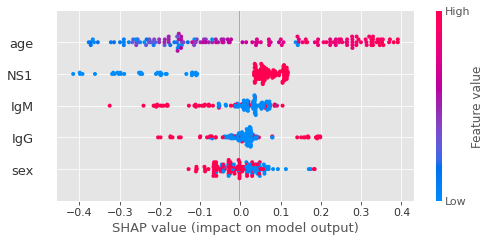

In [151]:
shap.summary_plot(shap_values[0], test.iloc[:,1:6])

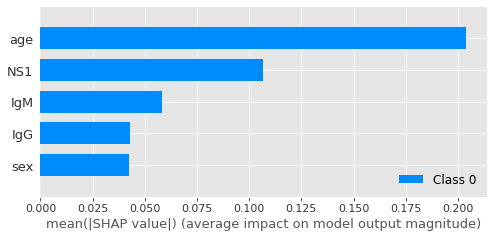

In [152]:
shap.summary_plot(shap_values, test.iloc[:,1:6])

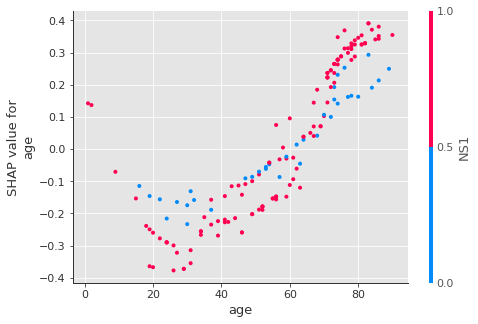

In [153]:
shap.dependence_plot("age", shap_values[0], test.iloc[:,1:6])

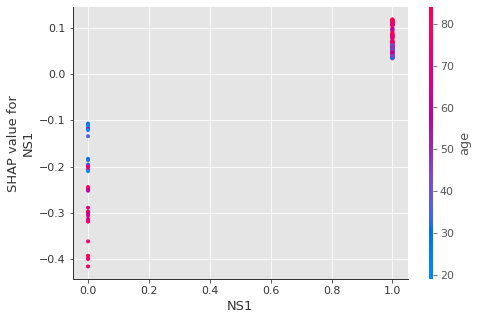

In [154]:
shap.dependence_plot("NS1", shap_values[0], test.iloc[:,1:6])

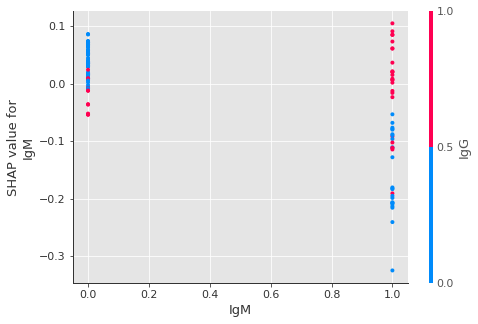

In [155]:
shap.dependence_plot("IgM", shap_values[0], test.iloc[:,1:6])

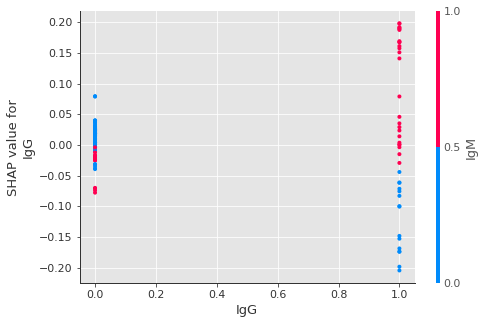

In [156]:
shap.dependence_plot("IgG", shap_values[0], test.iloc[:,1:6])

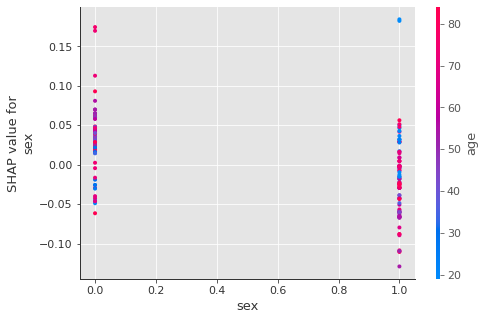

In [157]:
shap.dependence_plot("sex", shap_values[0], test.iloc[:,1:6])

### Concat prediction_proba for each model to test set, save test set

In [184]:
def pred_proba(train_x, train_y, test_x, test_y):
    data=pd.DataFrame()
    data['severity']= test_y

    with open('20200225lr_clf_final_round.pkl', 'rb') as f:
        lr_clf = pickle.load(f)
    lr_clf.fit(train_x, train_y)
    pred_proba_lr = lr_clf.predict_proba(test_x)[:, 1]
    data['lr_pred_proba'] = pred_proba_lr


    with open('20200225rf_clf_final_round.pkl', 'rb') as f:
        rf_clf = pickle.load(f)
    rf_clf.fit(train_x, train_y)
    pred_proba_rf = rf_clf.predict_proba(test_x)[:, 1]
    data['rf_pred_proba'] = pred_proba_rf


    with open('20200225svc_clf_final_round.pkl', 'rb') as f:
        svc_clf = pickle.load(f)
    svc_clf.fit(train_x, train_y)
    pred_proba_svc = svc_clf.predict_proba(test_x)[:, 1]
    data['svc_pred_proba'] = pred_proba_svc

    with open('20200225gbm_clf_final_round.pkl', 'rb') as f:
        gbm_clf = pickle.load(f)
    gbm_clf.fit(train_x, train_y)
    pred_proba_gbm = gbm_clf.predict_proba(test_x)[:, 1]
    data['gbm_pred_proba'] = pred_proba_gbm


    model = keras.Sequential([
      keras.layers.Dense(200, activation='relu', input_shape=(train_x.shape[-1],)),
      keras.layers.Dropout(0.3),
      keras.layers.Dense(150, activation='relu'),
      keras.layers.Dropout(0.3),
      keras.layers.Dense(150, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid')])
      
      
    model.compile(
      optimizer=keras.optimizers.Adam(),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.AUC()])
    model.fit(train_x,train_y, 
          class_weight=class_weights,
          epochs=300, batch_size=20, verbose=2)

    test_probability=model.predict(test_x)
    pred_proba_NL = np.reshape(test_probability,test_probability.shape[0])
    data['NL_pred_proba'] = pred_proba_NL

    return data

In [185]:
data_test=pred_proba(train_Features, train_Label, test_Features, test_Label)

Train on 718 samples
Epoch 1/300
718/718 - 1s - loss: 0.6996 - auc_29: 0.5055
Epoch 2/300
718/718 - 0s - loss: 0.6549 - auc_29: 0.6808
Epoch 3/300
718/718 - 0s - loss: 0.6006 - auc_29: 0.7389
Epoch 4/300
718/718 - 0s - loss: 0.5576 - auc_29: 0.7808
Epoch 5/300
718/718 - 0s - loss: 0.5659 - auc_29: 0.7819
Epoch 6/300
718/718 - 0s - loss: 0.5609 - auc_29: 0.7867
Epoch 7/300
718/718 - 0s - loss: 0.5501 - auc_29: 0.7962
Epoch 8/300
718/718 - 0s - loss: 0.5286 - auc_29: 0.8159
Epoch 9/300
718/718 - 0s - loss: 0.5612 - auc_29: 0.7851
Epoch 10/300
718/718 - 0s - loss: 0.5333 - auc_29: 0.8110
Epoch 11/300
718/718 - 0s - loss: 0.5358 - auc_29: 0.8024
Epoch 12/300
718/718 - 0s - loss: 0.5730 - auc_29: 0.7682
Epoch 13/300
718/718 - 0s - loss: 0.5462 - auc_29: 0.8055
Epoch 14/300
718/718 - 0s - loss: 0.5287 - auc_29: 0.8145
Epoch 15/300
718/718 - 0s - loss: 0.5167 - auc_29: 0.8245
Epoch 16/300
718/718 - 0s - loss: 0.5202 - auc_29: 0.8174
Epoch 17/300
718/718 - 0s - loss: 0.5132 - auc_29: 0.8251
Ep

Epoch 142/300
718/718 - 0s - loss: 0.4544 - auc_29: 0.8633
Epoch 143/300
718/718 - 0s - loss: 0.4414 - auc_29: 0.8651
Epoch 144/300
718/718 - 0s - loss: 0.4575 - auc_29: 0.8552
Epoch 145/300
718/718 - 0s - loss: 0.4439 - auc_29: 0.8646
Epoch 146/300
718/718 - 0s - loss: 0.4685 - auc_29: 0.8453
Epoch 147/300
718/718 - 0s - loss: 0.4509 - auc_29: 0.8607
Epoch 148/300
718/718 - 0s - loss: 0.4491 - auc_29: 0.8576
Epoch 149/300
718/718 - 0s - loss: 0.4436 - auc_29: 0.8615
Epoch 150/300
718/718 - 0s - loss: 0.4589 - auc_29: 0.8525
Epoch 151/300
718/718 - 0s - loss: 0.4461 - auc_29: 0.8636
Epoch 152/300
718/718 - 0s - loss: 0.4474 - auc_29: 0.8620
Epoch 153/300
718/718 - 0s - loss: 0.4433 - auc_29: 0.8649
Epoch 154/300
718/718 - 0s - loss: 0.4392 - auc_29: 0.8644
Epoch 155/300
718/718 - 0s - loss: 0.4576 - auc_29: 0.8561
Epoch 156/300
718/718 - 0s - loss: 0.4554 - auc_29: 0.8530
Epoch 157/300
718/718 - 0s - loss: 0.4563 - auc_29: 0.8554
Epoch 158/300
718/718 - 0s - loss: 0.4419 - auc_29: 0.86

Epoch 281/300
718/718 - 0s - loss: 0.4375 - auc_29: 0.8675
Epoch 282/300
718/718 - 0s - loss: 0.4374 - auc_29: 0.8701
Epoch 283/300
718/718 - 0s - loss: 0.4410 - auc_29: 0.8615
Epoch 284/300
718/718 - 0s - loss: 0.4339 - auc_29: 0.8681
Epoch 285/300
718/718 - 0s - loss: 0.4425 - auc_29: 0.8640
Epoch 286/300
718/718 - 0s - loss: 0.4306 - auc_29: 0.8710
Epoch 287/300
718/718 - 0s - loss: 0.4422 - auc_29: 0.8630
Epoch 288/300
718/718 - 0s - loss: 0.4541 - auc_29: 0.8561
Epoch 289/300
718/718 - 0s - loss: 0.4406 - auc_29: 0.8664
Epoch 290/300
718/718 - 0s - loss: 0.4365 - auc_29: 0.8670
Epoch 291/300
718/718 - 0s - loss: 0.4264 - auc_29: 0.8731
Epoch 292/300
718/718 - 0s - loss: 0.4326 - auc_29: 0.8697
Epoch 293/300
718/718 - 0s - loss: 0.4168 - auc_29: 0.8805
Epoch 294/300
718/718 - 0s - loss: 0.4441 - auc_29: 0.8634
Epoch 295/300
718/718 - 0s - loss: 0.4291 - auc_29: 0.8737
Epoch 296/300
718/718 - 0s - loss: 0.4463 - auc_29: 0.8608
Epoch 297/300
718/718 - 0s - loss: 0.4324 - auc_29: 0.86

In [186]:
data_test

severity  lr_pred_proba  rf_pred_proba  svc_pred_proba  gbm_pred_proba  \
0        0.0       0.225086       0.485778        0.148428        0.160394   
1        0.0       0.059690       0.217881        0.144435        0.051793   
2        0.0       0.372717       0.724221        0.362692        0.534227   
3        0.0       0.160059       0.270408        0.140237        0.180466   
4        0.0       0.048463       0.215034        0.042560        0.087188   
..       ...            ...            ...             ...             ...   
75       0.0       0.012098       0.047497        0.033059        0.009952   
76       0.0       0.412729       0.799834        0.415846        0.507239   
77       1.0       0.594685       0.805426        0.780582        0.582473   
78       0.0       0.001696       0.038177        0.021612        0.013287   
79       1.0       0.053760       0.320646        0.073873        0.057791   

    NL_pred_proba  
0    5.675110e-01  
1    6.153408e-01  
2    6.297552e-01  
3    1.871651e-01  
4    8.940697e-08  
..            ...  
75   8.940697e-08  
76   7.885124e-01  
77   8.999063e-01  
78   0.000000e+00  
79   3.096096e-01  

[80 rows x 6 columns]

In [187]:
test_df2=test_df.reset_index(drop=True)
test_df2['NL_pred_proba']=data_test['NL_pred_proba']

In [191]:
pd.set_option('display.max_columns', None)

test_df2.loc[(test_df2['Severity']==1)&(test_df2['NL_pred_proba']<0.5)]

Severity  sex  age  NS1  IgM  IgG  NL_pred_proba
37         1    0   54  1.0  0.0  0.0       0.423996
56         1    1   70  0.0  1.0  1.0       0.183979
68         1    0   69  1.0  0.0  0.0       0.420870
79         1    0   37  1.0  0.0  0.0       0.309610

In [189]:
data_test.to_csv('test_set_with_predictions.csv')

## Class breakdown per model

In [192]:
def plot_class_breakdown_hist(df, var, var_name, plot_title, xlog=False, ylog=False, **histkwargs):
    df[var][df.severity == 1].hist(alpha=.5, label='Severe', color = "green", **histkwargs)
    df[var][df.severity == 0].hist(alpha=.5, label='Mild', color = "red", **histkwargs)
    plt.xlabel(var_name)
    plt.title(plot_title)
    if xlog:
        plt.xscale('log')
    if ylog:
        plt.yscale('log')
    plt.xlim(xmax=1, xmin=0)   
    plt.ylim(ymax=20, ymin=0)
    plt.legend()
    plt.savefig(var_name + ' Class Breakdown.png');

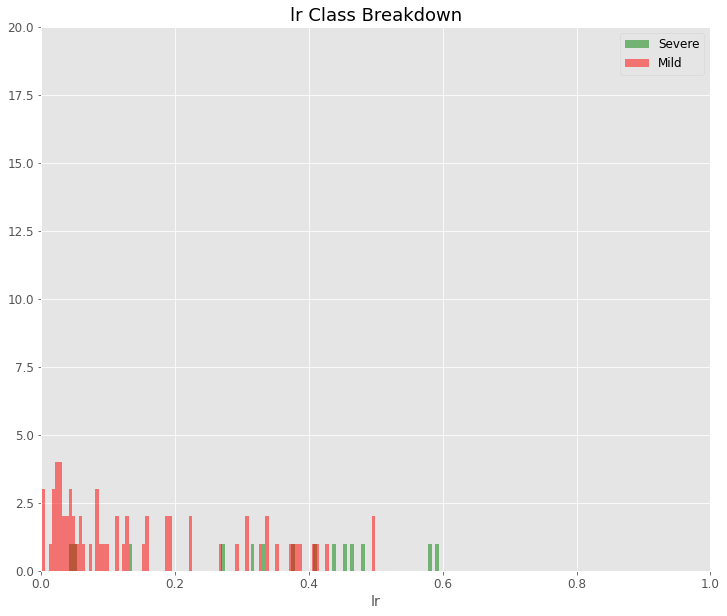

In [193]:
plot_class_breakdown_hist(data_test, 'lr_pred_proba', var_name='lr', 
                          plot_title='lr Class Breakdown', bins=100)

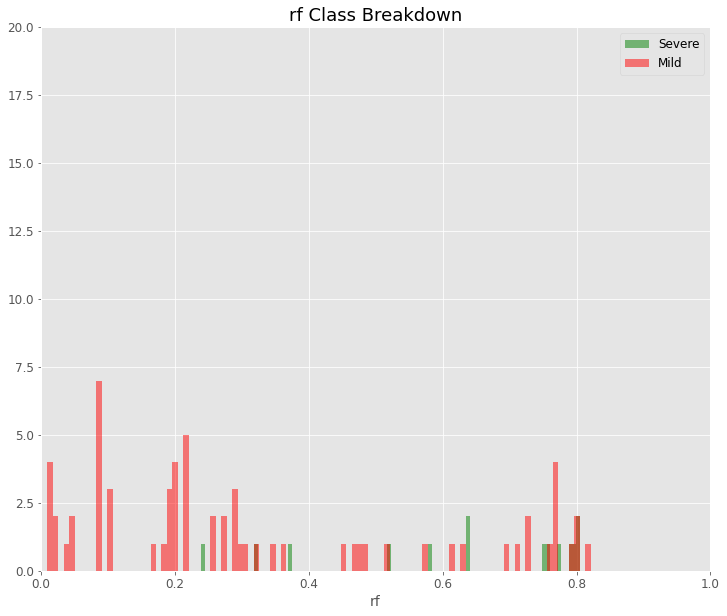

In [194]:
plot_class_breakdown_hist(data_test, 'rf_pred_proba', var_name='rf', 
                          plot_title='rf Class Breakdown', bins=100)

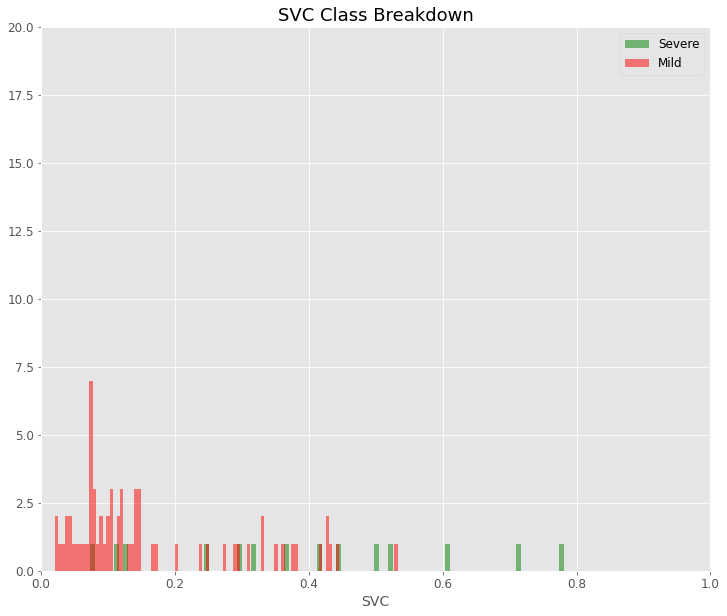

In [195]:
plot_class_breakdown_hist(data_test, 'svc_pred_proba', var_name='SVC', 
                          plot_title='SVC Class Breakdown', bins=100)

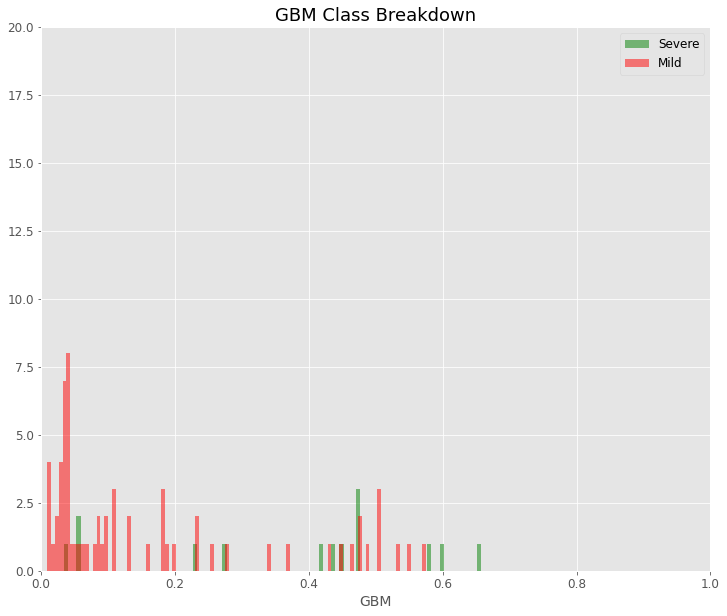

In [196]:
plot_class_breakdown_hist(data_test, 'gbm_pred_proba', var_name='GBM', 
                          plot_title='GBM Class Breakdown', bins=100)

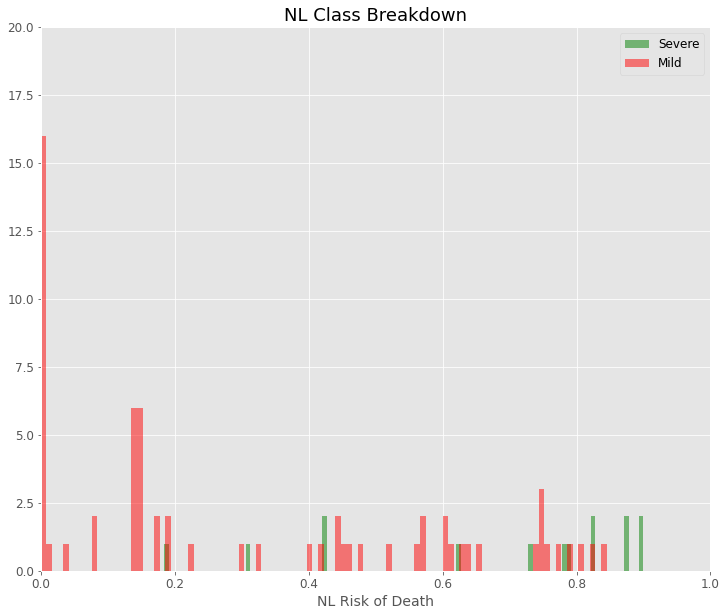

In [197]:
plot_class_breakdown_hist(data_test, 'NL_pred_proba', var_name='NL Risk of Death', 
                          plot_title='NL Class Breakdown', bins=100)

In [198]:
data_test

severity  lr_pred_proba  rf_pred_proba  svc_pred_proba  gbm_pred_proba  \
0        0.0       0.225086       0.485778        0.148428        0.160394   
1        0.0       0.059690       0.217881        0.144435        0.051793   
2        0.0       0.372717       0.724221        0.362692        0.534227   
3        0.0       0.160059       0.270408        0.140237        0.180466   
4        0.0       0.048463       0.215034        0.042560        0.087188   
..       ...            ...            ...             ...             ...   
75       0.0       0.012098       0.047497        0.033059        0.009952   
76       0.0       0.412729       0.799834        0.415846        0.507239   
77       1.0       0.594685       0.805426        0.780582        0.582473   
78       0.0       0.001696       0.038177        0.021612        0.013287   
79       1.0       0.053760       0.320646        0.073873        0.057791   

    NL_pred_proba  
0    5.675110e-01  
1    6.153408e-01  
2    6.297552e-01  
3    1.871651e-01  
4    8.940697e-08  
..            ...  
75   8.940697e-08  
76   7.885124e-01  
77   8.999063e-01  
78   0.000000e+00  
79   3.096096e-01  

[80 rows x 6 columns]

In [199]:
data_all=pred_proba(train_Features, train_Label, X, Y)

Train on 718 samples
Epoch 1/300
718/718 - 1s - loss: 0.6849 - auc_30: 0.5640
Epoch 2/300
718/718 - 0s - loss: 0.6400 - auc_30: 0.7209
Epoch 3/300
718/718 - 0s - loss: 0.5765 - auc_30: 0.7876
Epoch 4/300
718/718 - 0s - loss: 0.5613 - auc_30: 0.7853
Epoch 5/300
718/718 - 0s - loss: 0.5554 - auc_30: 0.7894
Epoch 6/300
718/718 - 0s - loss: 0.5638 - auc_30: 0.7728
Epoch 7/300
718/718 - 0s - loss: 0.5259 - auc_30: 0.8127
Epoch 8/300
718/718 - 0s - loss: 0.5198 - auc_30: 0.8164
Epoch 9/300
718/718 - 0s - loss: 0.5550 - auc_30: 0.7888
Epoch 10/300
718/718 - 0s - loss: 0.5225 - auc_30: 0.8166
Epoch 11/300
718/718 - 0s - loss: 0.5196 - auc_30: 0.8195
Epoch 12/300
718/718 - 0s - loss: 0.5197 - auc_30: 0.8154
Epoch 13/300
718/718 - 0s - loss: 0.5461 - auc_30: 0.7975
Epoch 14/300
718/718 - 0s - loss: 0.5243 - auc_30: 0.8163
Epoch 15/300
718/718 - 0s - loss: 0.5095 - auc_30: 0.8256
Epoch 16/300
718/718 - 0s - loss: 0.4991 - auc_30: 0.8353
Epoch 17/300
718/718 - 0s - loss: 0.5197 - auc_30: 0.8159
Ep

Epoch 142/300
718/718 - 0s - loss: 0.4567 - auc_30: 0.8572
Epoch 143/300
718/718 - 0s - loss: 0.4513 - auc_30: 0.8613
Epoch 144/300
718/718 - 0s - loss: 0.4665 - auc_30: 0.8521
Epoch 145/300
718/718 - 0s - loss: 0.4584 - auc_30: 0.8526
Epoch 146/300
718/718 - 0s - loss: 0.4534 - auc_30: 0.8592
Epoch 147/300
718/718 - 0s - loss: 0.4569 - auc_30: 0.8557
Epoch 148/300
718/718 - 0s - loss: 0.4707 - auc_30: 0.8496
Epoch 149/300
718/718 - 0s - loss: 0.4659 - auc_30: 0.8543
Epoch 150/300
718/718 - 0s - loss: 0.4588 - auc_30: 0.8546
Epoch 151/300
718/718 - 0s - loss: 0.4511 - auc_30: 0.8568
Epoch 152/300
718/718 - 0s - loss: 0.4298 - auc_30: 0.8717
Epoch 153/300
718/718 - 0s - loss: 0.4507 - auc_30: 0.8593
Epoch 154/300
718/718 - 0s - loss: 0.4546 - auc_30: 0.8542
Epoch 155/300
718/718 - 0s - loss: 0.4643 - auc_30: 0.8587
Epoch 156/300
718/718 - 0s - loss: 0.4484 - auc_30: 0.8586
Epoch 157/300
718/718 - 0s - loss: 0.4417 - auc_30: 0.8661
Epoch 158/300
718/718 - 0s - loss: 0.4497 - auc_30: 0.85

Epoch 281/300
718/718 - 0s - loss: 0.4565 - auc_30: 0.8550
Epoch 282/300
718/718 - 0s - loss: 0.4280 - auc_30: 0.8742
Epoch 283/300
718/718 - 0s - loss: 0.4430 - auc_30: 0.8642
Epoch 284/300
718/718 - 0s - loss: 0.4511 - auc_30: 0.8589
Epoch 285/300
718/718 - 0s - loss: 0.4432 - auc_30: 0.8645
Epoch 286/300
718/718 - 0s - loss: 0.4349 - auc_30: 0.8673
Epoch 287/300
718/718 - 0s - loss: 0.4314 - auc_30: 0.8708
Epoch 288/300
718/718 - 0s - loss: 0.4477 - auc_30: 0.8616
Epoch 289/300
718/718 - 0s - loss: 0.4450 - auc_30: 0.8633
Epoch 290/300
718/718 - 0s - loss: 0.4428 - auc_30: 0.8681
Epoch 291/300
718/718 - 0s - loss: 0.4472 - auc_30: 0.8619
Epoch 292/300
718/718 - 0s - loss: 0.4357 - auc_30: 0.8689
Epoch 293/300
718/718 - 0s - loss: 0.4378 - auc_30: 0.8679
Epoch 294/300
718/718 - 0s - loss: 0.4328 - auc_30: 0.8689
Epoch 295/300
718/718 - 0s - loss: 0.4472 - auc_30: 0.8655
Epoch 296/300
718/718 - 0s - loss: 0.4419 - auc_30: 0.8624
Epoch 297/300
718/718 - 0s - loss: 0.4382 - auc_30: 0.86

In [200]:
data_all

severity  lr_pred_proba  rf_pred_proba  svc_pred_proba  gbm_pred_proba  \
0         1.0       0.070334       0.287598        0.166358        0.090501   
1         1.0       0.043787       0.357306        0.093209        0.127999   
2         1.0       0.551784       0.805426        0.718963        0.582473   
3         1.0       0.422526       0.823531        0.449516        0.474338   
4         1.0       0.582010       0.791670        0.711820        0.474338   
..        ...            ...            ...             ...             ...   
793       0.0       0.014386       0.032986        0.032923        0.003451   
794       0.0       0.054152       0.215034        0.048804        0.064802   
795       0.0       0.002706       0.010500        0.020552        0.013287   
796       0.0       0.071239       0.198794        0.066061        0.064802   
797       0.0       0.015354       0.086353        0.057255        0.004393   

     NL_pred_proba  
0     6.527045e-01  
1     4.715248e-01  
2     9.427740e-01  
3     8.244655e-01  
4     8.768299e-01  
..             ...  
793   2.682209e-07  
794   5.900860e-06  
795   0.000000e+00  
796   2.848598e-05  
797   1.340080e-04  

[798 rows x 6 columns]

In [205]:
import seaborn as sns
import matplotlib.pyplot as plt

In [236]:
df_test2=test_df.reset_index(drop=True)
df_test2['NL_pred_proba']=data_test['NL_pred_proba']

plot_test_data=df_test2.loc[(df_test2['Severity']==1)&(df_test2['NL_pred_proba']<0.5)]

In [239]:
df_test2.shape

(80, 7)

In [237]:
plot_test_data

Severity  sex  age  NS1  IgM  IgG  NL_pred_proba
37         1    0   54  1.0  0.0  0.0       0.423996
56         1    1   70  0.0  1.0  1.0       0.183979
68         1    0   69  1.0  0.0  0.0       0.420870
79         1    0   37  1.0  0.0  0.0       0.309610

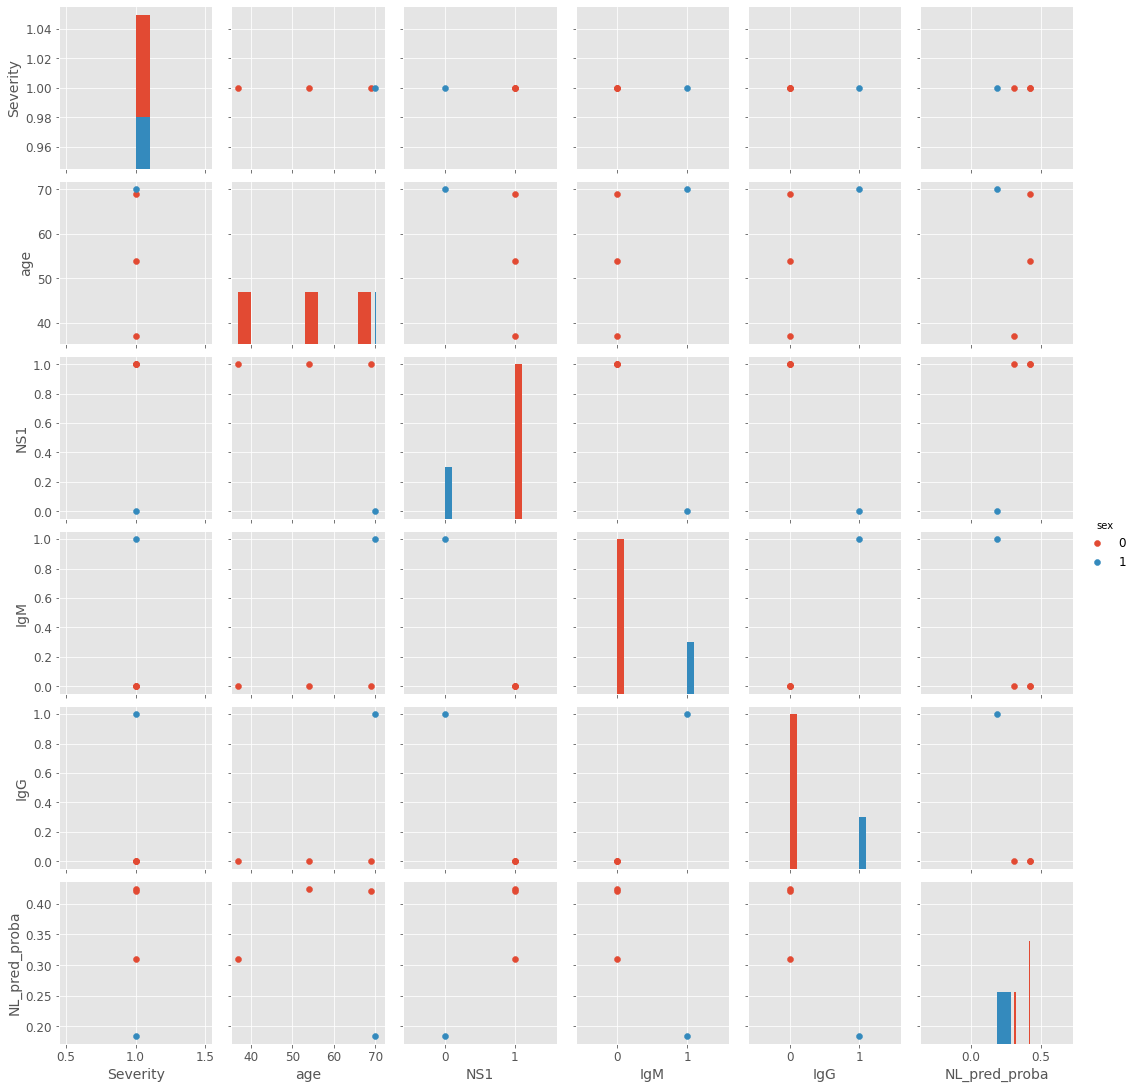

In [229]:
g_test = sns.PairGrid(plot_test_data, hue='sex')
g_test.map_diag(plt.hist)
g_test.map_offdiag(plt.scatter)
g_test.add_legend()

In [231]:
df_test3=test_df.reset_index(drop=True)
df_test3['NL_pred_proba']=data_test['NL_pred_proba']

plot_test_data2=df_test3.loc[(df_test3['Severity']==0)&(df_test3['NL_pred_proba']>0.5)]

In [235]:
plot_test_data2

Severity  sex  age  NS1  IgM  IgG  NL_pred_proba
0          0    0   60  1.0  1.0  1.0       0.567511
1          0    1   76  0.0  1.0  1.0       0.615341
2          0    0   78  1.0  0.0  1.0       0.629755
5          0    1   74  0.0  1.0  1.0       0.558007
15         0    1   78  1.0  0.0  0.0       0.772439
19         0    1   85  1.0  0.0  1.0       0.604967
24         0    0   81  1.0  0.0  0.0       0.803796
34         0    1   73  1.0  0.0  0.0       0.748589
38         0    1   83  0.0  1.0  1.0       0.651895
41         0    1   74  1.0  0.0  0.0       0.754574
43         0    0   72  1.0  0.0  0.0       0.519788
46         0    1   73  1.0  0.0  0.0       0.748589
53         0    1   71  1.0  1.0  1.0       0.825448
58         0    0   79  1.0  0.0  1.0       0.641002
60         0    0   73  0.0  1.0  0.0       0.571114
64         0    0   73  1.0  0.0  1.0       0.607856
67         0    0   78  1.0  0.0  0.0       0.747464
71         0    1   72  1.0  0.0  0.0       0.741103
72         0    0   86  1.0  0.0  0.0       0.844915
76         0    0   80  1.0  0.0  0.0       0.788512

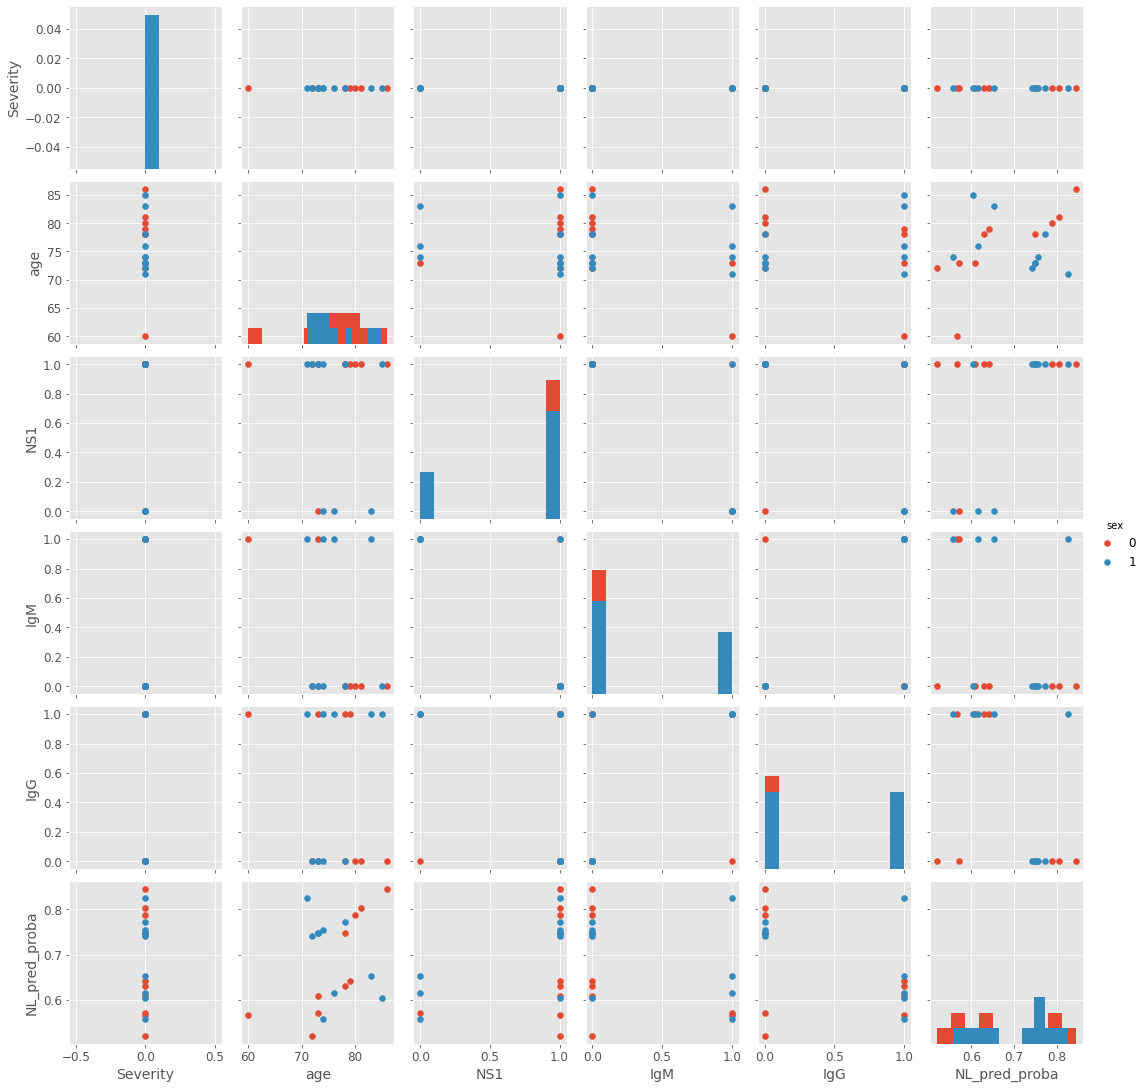

In [232]:
g_test = sns.PairGrid(plot_test_data2, hue='sex')
g_test.map_diag(plt.hist)
g_test.map_offdiag(plt.scatter)
g_test.add_legend()

In [224]:
df_all2=df.reset_index(drop=True)
df_all2['NL_pred_proba']=data_all['NL_pred_proba']

plot_all_data=df_all2.loc[(df_all2['Severity']==1)&(df_all2['NL_pred_proba']<0.5)]

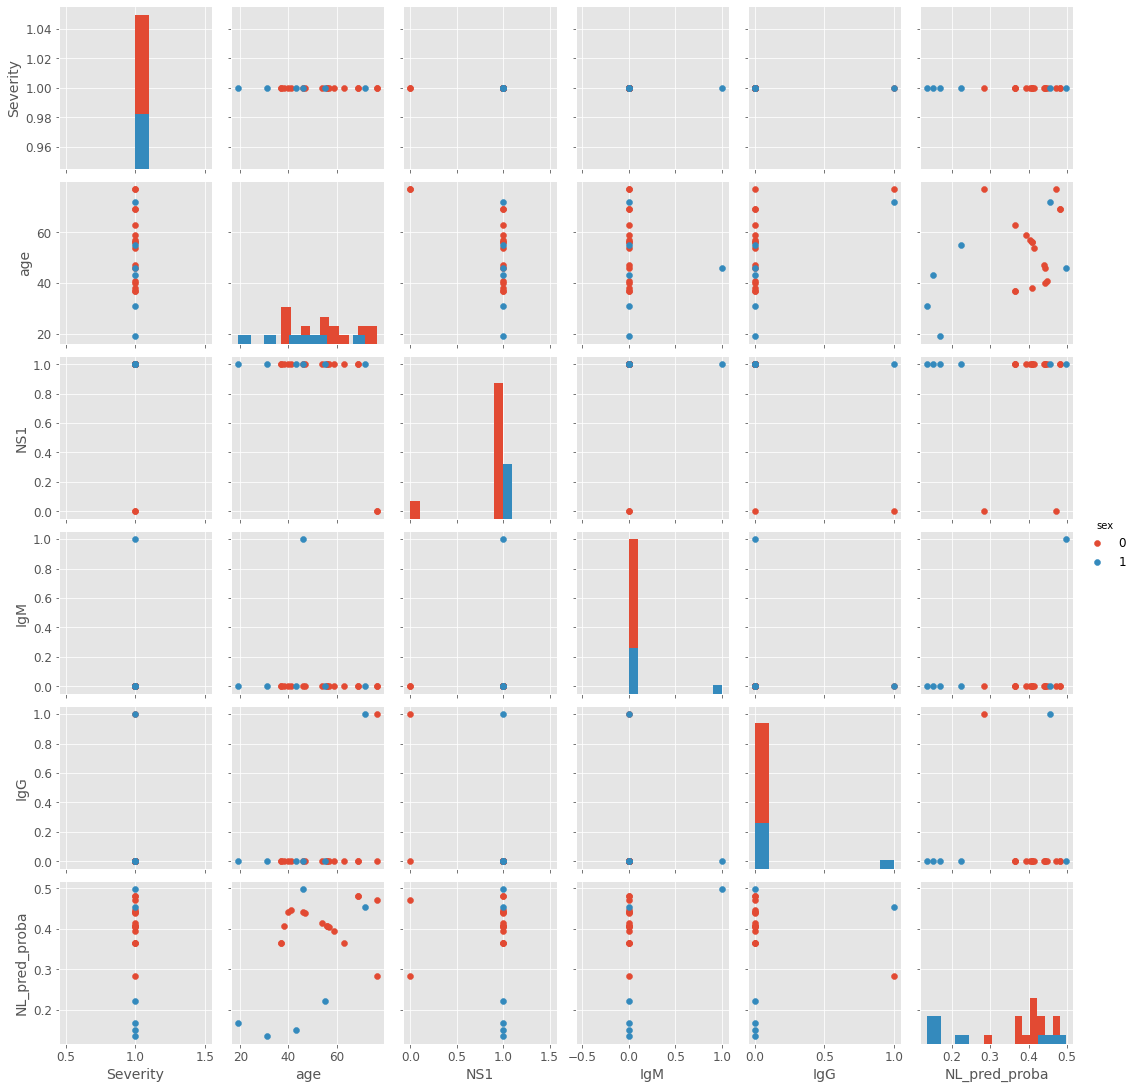

In [228]:
g = sns.PairGrid(plot_all_data, hue='sex')
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()

In [208]:
def plot_class_breakdown_hist2(df, var, var_name, plot_title, xlog=False, ylog=False, **histkwargs):
    df[var][df.severity == 1].hist(alpha=.5, label='Severe', color = "green", **histkwargs)
    df[var][df.severity == 0].hist(alpha=.5, label='Mild', color = "red", **histkwargs)
    plt.xlabel(var_name)
    plt.title(plot_title)
    if xlog:
        plt.xscale('log')
    if ylog:
        plt.yscale('log')
    plt.xlim(xmax=1, xmin=0)   
    plt.ylim(ymax=100, ymin=0)
    plt.legend()
    plt.savefig(var_name + ' Class Breakdown.png');

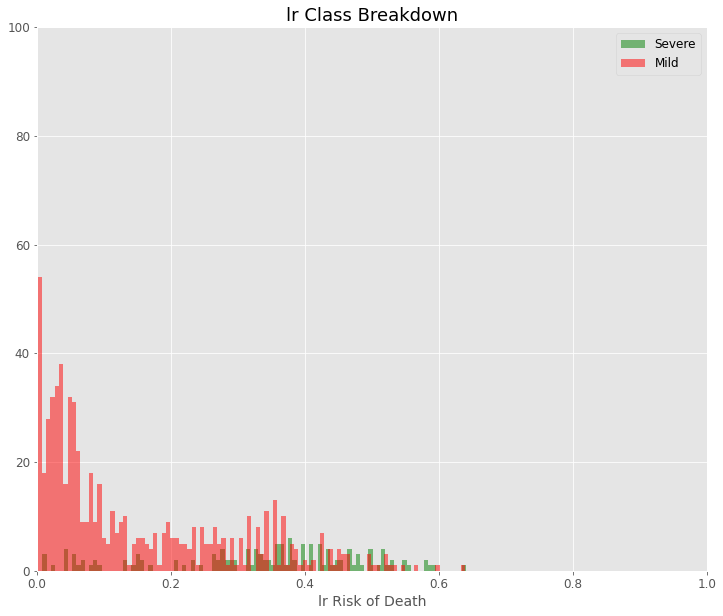

In [209]:
plot_class_breakdown_hist2(data_all, 'lr_pred_proba', var_name='lr Risk of Death', 
                          plot_title='lr Class Breakdown', bins=100)

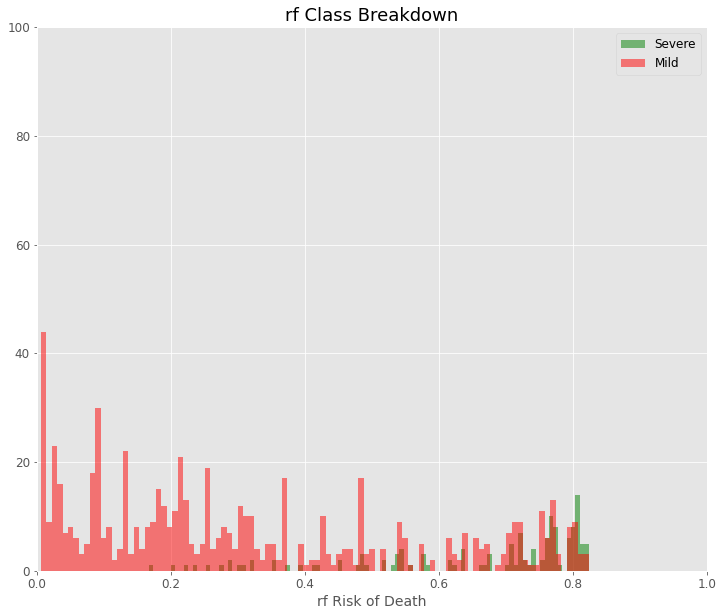

In [210]:
plot_class_breakdown_hist2(data_all, 'rf_pred_proba', var_name='rf Risk of Death', 
                          plot_title='rf Class Breakdown', bins=100)

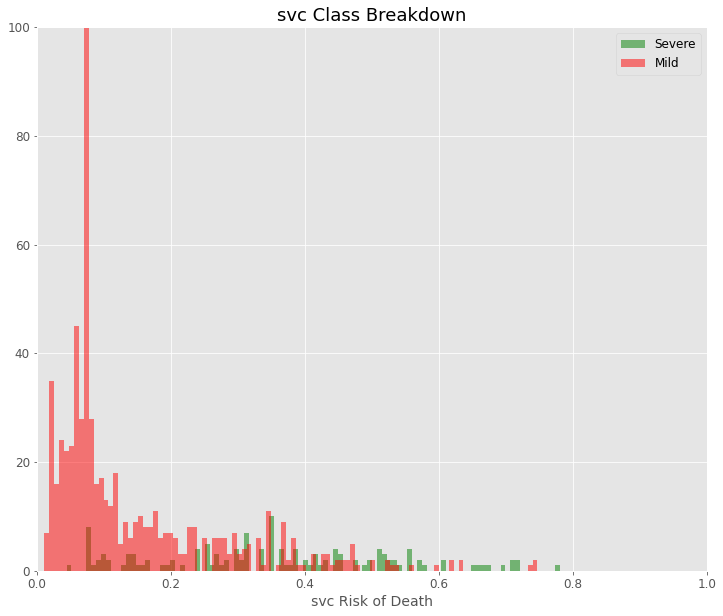

In [211]:
plot_class_breakdown_hist2(data_all, 'svc_pred_proba', var_name='svc Risk of Death', 
                          plot_title='svc Class Breakdown', bins=100)

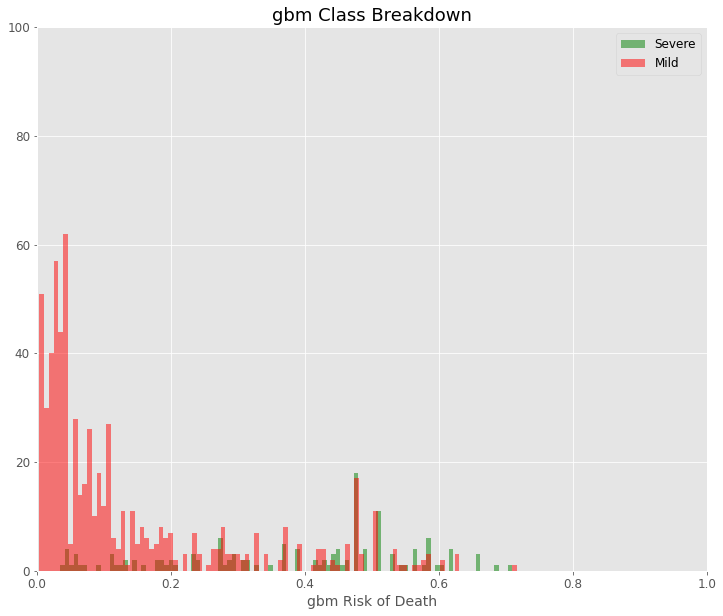

In [212]:
plot_class_breakdown_hist2(data_all, 'gbm_pred_proba', var_name='gbm Risk of Death', 
                          plot_title='gbm Class Breakdown', bins=100)

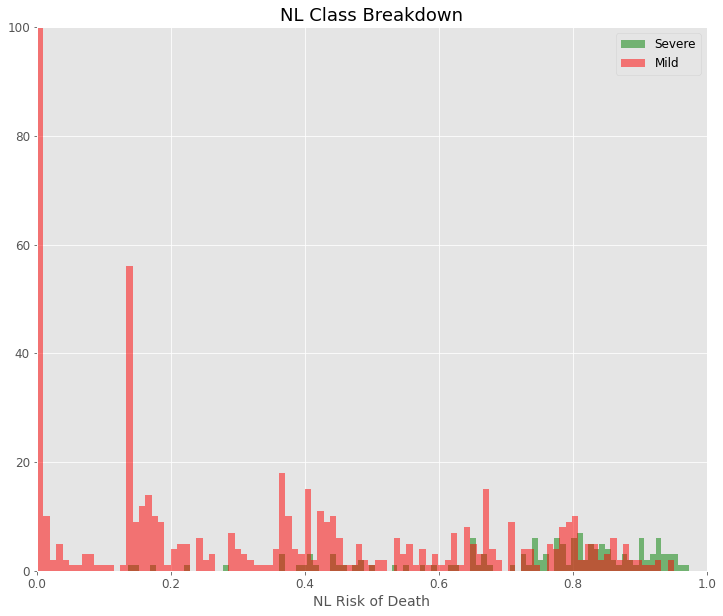

In [213]:
plot_class_breakdown_hist2(data_all, 'NL_pred_proba', var_name='NL Risk of Death', 
                          plot_title='NL Class Breakdown', bins=100)

In [214]:
def curve_analysis_ANN(test_x):
    test_probability=model.predict(test_x)
    pred_proba_NL = np.reshape(test_probability,test_probability.shape[0])
    data['NL_pred_proba'] = pred_proba_NL

    test_probability_ANN=model.predict(X[test])
    pred_proba_ANN = np.reshape(test_probability_ANN,test_probability_ANN.shape[0])

    fpr_ANN, tpr_ANN, thresholds_ANN = roc_curve(Y[test], pred_proba_ANN)
    tprs_ANN.append(interp(mean_fpr_ANN, fpr_ANN, tpr_ANN))
    tprs_ANN[-1][0] = 0.0
    
    roc_auc_ANN = sklearn.metrics.auc(fpr_ANN, tpr_ANN)
    aucs_ANN.append(roc_auc_ANN)
    
    return aucs_ANN
def curve_analysis_ML(test_x):
    test_probability=model.predict(test_x)
    pred_proba_NL = np.reshape(test_probability,test_probability.shape[0])
    data['NL_pred_proba'] = pred_proba_NL

    test_probability_ANN=model.predict(X[test])
    pred_proba_ANN = np.reshape(test_probability_ANN,test_probability_ANN.shape[0])

    fpr_ANN, tpr_ANN, thresholds_ANN = roc_curve(Y[test], pred_proba_ANN)
    tprs_ANN.append(interp(mean_fpr_ANN, fpr_ANN, tpr_ANN))
    tprs_ANN[-1][0] = 0.0
    
    roc_auc_ANN = sklearn.metrics.auc(fpr_ANN, tpr_ANN)
    aucs_ANN.append(roc_auc_ANN)
    
    return aucs_ML

from scipy import interp

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=48)

tprs_ANN = []
aucs_ANN = []
tprs_lr = []
aucs_lr = []
tprs_rf = []
aucs_rf = []
tprs_gbm = []
aucs_gbm = []
tprs_svc = []
aucs_svc = []
mean_fpr_ANN = np.linspace(0, 1, 100)
mean_fpr_lr = np.linspace(0, 1, 100)
mean_fpr_rf = np.linspace(0, 1, 100)
mean_fpr_gbm = np.linspace(0, 1, 100)
mean_fpr_svc = np.linspace(0, 1, 100)


# ANN curve
mean_tpr_ANN = np.mean(tprs_ANN, axis=0)
mean_tpr_ANN[-1] = 1.0
mean_auc_ANN = sklearn.metrics.auc(mean_fpr_ANN, mean_tpr_ANN)
std_auc_ANN = np.std(aucs_ANN)
plt.plot(mean_fpr_ANN, mean_tpr_ANN, color='b',
         label='% s Mean ROC (AUC =  %0.3f $\pm$ %0.3f)'% ('ANN', mean_auc_ANN, std_auc_ANN),  
                     lw=2, alpha=.8)

std_tpr_ANN = np.std(tprs_ANN, axis=0)
tprs_upper_ANN = np.minimum(mean_tpr_ANN + std_tpr_ANN, 1)
tprs_lower_ANN = np.maximum(mean_tpr_ANN - std_tpr_ANN, 0)
plt.fill_between(mean_fpr_ANN, tprs_lower_ANN, tprs_upper_ANN, color='blue', alpha=.2,
                 label=r'$\pm$ ANN 1 std. dev.')
#LR curve
mean_tpr_lr = np.mean(tprs_lr, axis=0)
mean_tpr_lr[-1] = 1.0
mean_auc_lr = sklearn.metrics.auc(mean_fpr_lr, mean_tpr_lr)
std_auc_lr = np.std(aucs_lr)
plt.plot(mean_fpr_lr, mean_tpr_lr, color='g',
         label='% s Mean ROC (AUC =  %0.3f $\pm$ %0.3f)'% ('LR', mean_auc_lr, std_auc_lr),  
         lw=2, alpha=.8)

std_tpr_lr = np.std(tprs_lr, axis=0)
tprs_upper_lr = np.minimum(mean_tpr_lr + std_tpr_lr, 1)
tprs_lower_lr = np.maximum(mean_tpr_lr - std_tpr_lr, 0)
plt.fill_between(mean_fpr_lr, tprs_lower_lr, tprs_upper_lr, color='g', alpha=.2,
                 label=r'$\pm$ LR 1 std. dev.')

#RF curve
mean_tpr_rf = np.mean(tprs_rf, axis=0)
mean_tpr_rf[-1] = 1.0
mean_auc_rf = sklearn.metrics.auc(mean_fpr_rf, mean_tpr_rf)
std_auc_rf = np.std(aucs_rf)
plt.plot(mean_fpr_rf, mean_tpr_rf, color='y',
         label='% s Mean ROC (AUC =  %0.3f $\pm$ %0.3f)'% ('RF', mean_auc_rf, std_auc_rf),  
         lw=2, alpha=.8)

std_tpr_rf = np.std(tprs_rf, axis=0)
tprs_upper_rf = np.minimum(mean_tpr_rf + std_tpr_rf, 1)
tprs_lower_rf = np.maximum(mean_tpr_rf - std_tpr_rf, 0)
plt.fill_between(mean_fpr_rf, tprs_lower_rf, tprs_upper_rf, color='y', alpha=.2,
                 label=r'$\pm$ RF 1 std. dev.')

#GBM curve
mean_tpr_gbm = np.mean(tprs_gbm, axis=0)
mean_tpr_gbm[-1] = 1.0
mean_auc_gbm = sklearn.metrics.auc(mean_fpr_gbm, mean_tpr_gbm)
std_auc_gbm = np.std(aucs_gbm)
plt.plot(mean_fpr_gbm, mean_tpr_gbm, color='purple',
         label='% s Mean ROC (AUC =  %0.3f $\pm$ %0.3f)'% ('GBM', mean_auc_gbm, std_auc_gbm),  
         lw=2, alpha=.8)

std_tpr_gbm = np.std(tprs_gbm, axis=0)
tprs_upper_gbm = np.minimum(mean_tpr_gbm + std_tpr_gbm, 1)
tprs_lower_gbm = np.maximum(mean_tpr_gbm - std_tpr_gbm, 0)
plt.fill_between(mean_fpr_gbm, tprs_lower_gbm, tprs_upper_gbm, color='purple', alpha=.2,
                 label=r'$\pm$ GBM 1 std. dev.')

#SVC curve
mean_tpr_svc = np.mean(tprs_svc, axis=0)
mean_tpr_svc[-1] = 1.0
mean_auc_svc = sklearn.metrics.auc(mean_fpr_svc, mean_tpr_svc)
std_auc_svc = np.std(aucs_svc)
plt.plot(mean_fpr_svc, mean_tpr_svc, color='orange',
         label='% s Mean ROC (AUC =  %0.3f $\pm$ %0.3f)'% ('SVC', mean_auc_svc, std_auc_svc),  
         lw=2, alpha=.8)

std_tpr_svc = np.std(tprs_svc, axis=0)
tprs_upper_svc = np.minimum(mean_tpr_svc + std_tpr_svc, 1)
tprs_lower_svc = np.maximum(mean_tpr_svc - std_tpr_svc, 0)
plt.fill_between(mean_fpr_svc, tprs_lower_svc, tprs_upper_svc, color='orange', alpha=.2,
                 label=r'$\pm$ SVC 1 std. dev.')



plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('models_roc_curve_10folds_20200324.tif', dpi=300)
plt.show()

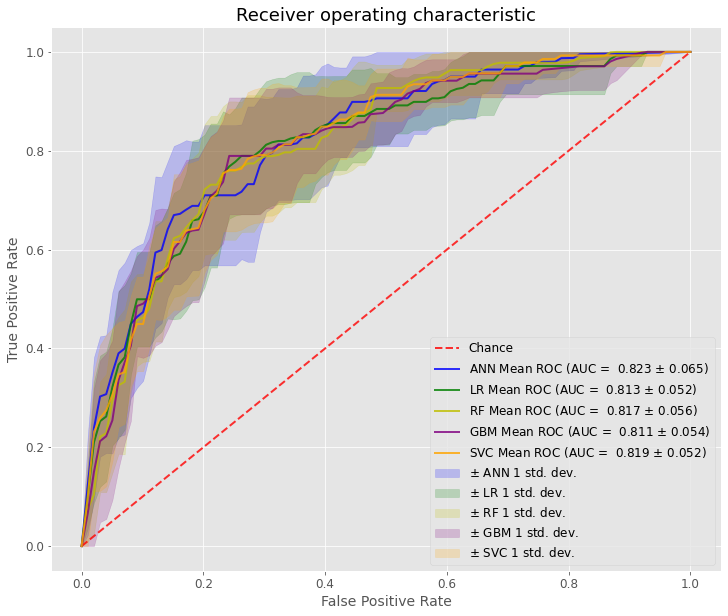

0.7193037974683545
0.8370569620253164
0.7706487341772152
0.8283069620253164
0.7356329113924052
0.5491734966959906
0.5284438036657167
0.491581305826278
0.4905472464883965
0.5237555583101111


In [219]:
# define 10-fold cross validation test harness
from numpy import interp
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=48)

tprs_ANN = []
aucs_ANN = []
tprs_lr = []
aucs_lr = []
tprs_rf = []
aucs_rf = []
tprs_gbm = []
aucs_gbm = []
tprs_svc = []
aucs_svc = []
mean_fpr_ANN = np.linspace(0, 1, 100)
mean_fpr_lr = np.linspace(0, 1, 100)
mean_fpr_rf = np.linspace(0, 1, 100)
mean_fpr_gbm = np.linspace(0, 1, 100)
mean_fpr_svc = np.linspace(0, 1, 100)
accus_ANN=[]
accus_lr=[]
accus_rf=[]
accus_gbm=[]
accus_svc=[]
aps_ANN=[]
aps_lr=[]
aps_rf=[]
aps_gbm=[]
aps_svc=[]
auc_ANN_pr_all=[]
auc_lr_pr_all=[]
auc_rf_pr_all=[]
auc_gbm_pr_all=[]
auc_svc_pr_all=[]

i = 0
for train, test in kfold.split(X, Y):
    # Fit the ANN model
    model = keras.Sequential([
      keras.layers.Dense(250, activation='relu', input_shape=(X_train.shape[-1],)),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(150, activation='relu'),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(300, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid')])
      
      
    model.compile(
      optimizer=keras.optimizers.Adam(),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.AUC()])
    
    unique, counts=numpy.unique(Y[train], return_counts=True)
    severe=counts[1]
    mild=counts[0]
    weight_for_0 = (1 / counts[0])*(counts.sum())/2.0 
    weight_for_1 = (1 / counts[1])*(counts.sum())/2.0

    class_weights = {0: weight_for_0, 1: weight_for_1}
    
    model.fit(X[train],Y[train], 
          class_weight=class_weights,
          epochs=400, batch_size=20, verbose=0)
    
    test_probability_ANN=model.predict(X[test])
    pred_proba_ANN = np.reshape(test_probability_ANN,test_probability_ANN.shape[0])

    fpr_ANN, tpr_ANN, thresholds_ANN = roc_curve(Y[test], pred_proba_ANN)
    tprs_ANN.append(interp(mean_fpr_ANN, fpr_ANN, tpr_ANN))
    tprs_ANN[-1][0] = 0.0
    
    roc_auc_ANN = sklearn.metrics.auc(fpr_ANN, tpr_ANN)
    aucs_ANN.append(roc_auc_ANN)
    
    accu_ANN=accuracy_score(Y[test], model.predict_classes(X[test]))
    accus_ANN.append(accu_ANN)
    
    precision_ANN, recall_ANN, thresholds_ANN = precision_recall_curve(Y[test], pred_proba_ANN)
    auc_ANN_pr=sklearn.metrics.auc(recall_ANN, precision_ANN)
    auc_ANN_pr_all.append(auc_ANN_pr)
    
    ap_ANN= average_precision_score(Y[test], pred_proba_ANN)
    aps_ANN.append(ap_ANN)
    
    # Fit the LR model
    with open('20200225lr_clf_final_round.pkl', 'rb') as f:
        lr_clf = pickle.load(f)
    lr_clf.fit(X[train], Y[train])
    pred_proba_lr = lr_clf.predict_proba(X[test])[:, 1]
    # Compute ROC curve and area the curve
    fpr_lr, tpr_lr, thresholds_lr = roc_curve(Y[test],  pred_proba_lr)
    tprs_lr.append(interp(mean_fpr_lr, fpr_lr, tpr_lr))
    tprs_lr[-1][0] = 0.0
    roc_auc_lr = sklearn.metrics.auc(fpr_lr, tpr_lr)
    aucs_lr.append(roc_auc_lr)
    accu_lr = accuracy_score(Y[test],  lr_clf.predict(X[test]))
    accus_lr.append(accu_lr)
    precision_lr, recall_lr, thresholds_lr = precision_recall_curve(Y[test], pred_proba_lr)
    auc_lr_pr=sklearn.metrics.auc(recall_lr, precision_lr)
    auc_lr_pr_all.append(auc_lr_pr)
    ap_lr= average_precision_score(Y[test], pred_proba_lr)
    aps_lr.append(ap_lr)
    
    # Fit the RF model
    with open('20200225rf_clf_final_round.pkl', 'rb') as f:
        rf_clf = pickle.load(f)
    rf_clf.fit(X[train], Y[train])
    pred_proba_rf = rf_clf.predict_proba(X[test])[:, 1]
    # Compute ROC curve and area the curve
    fpr_rf, tpr_rf, thresholds_rf = roc_curve(Y[test],  pred_proba_rf)
    tprs_rf.append(interp(mean_fpr_rf, fpr_rf, tpr_rf))
    tprs_rf[-1][0] = 0.0
    roc_auc_rf = sklearn.metrics.auc(fpr_rf, tpr_rf)
    aucs_rf.append(roc_auc_rf)
    accu_rf = accuracy_score(Y[test],  rf_clf.predict(X[test]))
    accus_rf.append(accu_rf)
    precision_rf, recall_rf, thresholds_rf = precision_recall_curve(Y[test], pred_proba_rf)
    auc_rf_pr=sklearn.metrics.auc(recall_rf, precision_rf)
    auc_rf_pr_all.append(auc_rf_pr)
    ap_rf= average_precision_score(Y[test], pred_proba_rf)
    aps_rf.append(ap_rf)
    
    # Fit the gbm model
    with open('20200225gbm_clf_final_round.pkl', 'rb') as f:
        gbm_clf = pickle.load(f)
    gbm_clf.fit(X[train], Y[train])
    pred_proba_gbm = gbm_clf.predict_proba(X[test])[:, 1]
    # Compute ROC curve and area the curve
    fpr_gbm, tpr_gbm, thresholds_gbm = roc_curve(Y[test],  pred_proba_gbm)
    tprs_gbm.append(interp(mean_fpr_gbm, fpr_gbm, tpr_gbm))
    tprs_gbm[-1][0] = 0.0
    roc_auc_gbm = sklearn.metrics.auc(fpr_gbm, tpr_gbm)
    aucs_gbm.append(roc_auc_gbm)
    accu_gbm = accuracy_score(Y[test],  gbm_clf.predict(X[test]))
    accus_gbm.append(accu_gbm)
    precision_gbm, recall_gbm, thresholds_gbm = precision_recall_curve(Y[test], pred_proba_gbm)
    auc_gbm_pr=sklearn.metrics.auc(recall_gbm, precision_gbm)
    auc_gbm_pr_all.append(auc_gbm_pr)
    ap_gbm= average_precision_score(Y[test], pred_proba_gbm)
    aps_gbm.append(ap_gbm)
    
    # Fit the svc model
    with open('20200225svc_clf_final_round.pkl', 'rb') as f:
        svc_clf = pickle.load(f)
    svc_clf.fit(X[train], Y[train])
    pred_proba_svc = svc_clf.predict_proba(X[test])[:, 1]
    # Compute ROC curve and area the curve
    fpr_svc, tpr_svc, thresholds_svc = roc_curve(Y[test],  pred_proba_svc)
    tprs_svc.append(interp(mean_fpr_svc, fpr_svc, tpr_svc))
    tprs_svc[-1][0] = 0.0
    roc_auc_svc = sklearn.metrics.auc(fpr_svc, tpr_svc)
    aucs_svc.append(roc_auc_svc)
    accu_svc = accuracy_score(Y[test],  svc_clf.predict(X[test]))
    accus_svc.append(accu_svc)
    precision_svc, recall_svc, thresholds_svc = precision_recall_curve(Y[test], pred_proba_svc)
    auc_svc_pr=sklearn.metrics.auc(recall_svc, precision_svc)
    auc_svc_pr_all.append(auc_svc_pr)
    ap_svc= average_precision_score(Y[test], pred_proba_svc)
    aps_svc.append(ap_svc)
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)
# ANN curve
mean_tpr_ANN = np.mean(tprs_ANN, axis=0)
mean_tpr_ANN[-1] = 1.0
mean_auc_ANN = sklearn.metrics.auc(mean_fpr_ANN, mean_tpr_ANN)
std_auc_ANN = np.std(aucs_ANN)
plt.plot(mean_fpr_ANN, mean_tpr_ANN, color='b',
         label='% s Mean ROC (AUC =  %0.3f $\pm$ %0.3f)'% ('ANN', mean_auc_ANN, std_auc_ANN),  
                     lw=2, alpha=.8)

std_tpr_ANN = np.std(tprs_ANN, axis=0)
tprs_upper_ANN = np.minimum(mean_tpr_ANN + std_tpr_ANN, 1)
tprs_lower_ANN = np.maximum(mean_tpr_ANN - std_tpr_ANN, 0)
plt.fill_between(mean_fpr_ANN, tprs_lower_ANN, tprs_upper_ANN, color='blue', alpha=.2,
                 label=r'$\pm$ ANN 1 std. dev.')
#LR curve
mean_tpr_lr = np.mean(tprs_lr, axis=0)
mean_tpr_lr[-1] = 1.0
mean_auc_lr = sklearn.metrics.auc(mean_fpr_lr, mean_tpr_lr)
std_auc_lr = np.std(aucs_lr)
plt.plot(mean_fpr_lr, mean_tpr_lr, color='g',
         label='% s Mean ROC (AUC =  %0.3f $\pm$ %0.3f)'% ('LR', mean_auc_lr, std_auc_lr),  
         lw=2, alpha=.8)

std_tpr_lr = np.std(tprs_lr, axis=0)
tprs_upper_lr = np.minimum(mean_tpr_lr + std_tpr_lr, 1)
tprs_lower_lr = np.maximum(mean_tpr_lr - std_tpr_lr, 0)
plt.fill_between(mean_fpr_lr, tprs_lower_lr, tprs_upper_lr, color='g', alpha=.2,
                 label=r'$\pm$ LR 1 std. dev.')

#RF curve
mean_tpr_rf = np.mean(tprs_rf, axis=0)
mean_tpr_rf[-1] = 1.0
mean_auc_rf = sklearn.metrics.auc(mean_fpr_rf, mean_tpr_rf)
std_auc_rf = np.std(aucs_rf)
plt.plot(mean_fpr_rf, mean_tpr_rf, color='y',
         label='% s Mean ROC (AUC =  %0.3f $\pm$ %0.3f)'% ('RF', mean_auc_rf, std_auc_rf),  
         lw=2, alpha=.8)

std_tpr_rf = np.std(tprs_rf, axis=0)
tprs_upper_rf = np.minimum(mean_tpr_rf + std_tpr_rf, 1)
tprs_lower_rf = np.maximum(mean_tpr_rf - std_tpr_rf, 0)
plt.fill_between(mean_fpr_rf, tprs_lower_rf, tprs_upper_rf, color='y', alpha=.2,
                 label=r'$\pm$ RF 1 std. dev.')

#GBM curve
mean_tpr_gbm = np.mean(tprs_gbm, axis=0)
mean_tpr_gbm[-1] = 1.0
mean_auc_gbm = sklearn.metrics.auc(mean_fpr_gbm, mean_tpr_gbm)
std_auc_gbm = np.std(aucs_gbm)
plt.plot(mean_fpr_gbm, mean_tpr_gbm, color='purple',
         label='% s Mean ROC (AUC =  %0.3f $\pm$ %0.3f)'% ('GBM', mean_auc_gbm, std_auc_gbm),  
         lw=2, alpha=.8)

std_tpr_gbm = np.std(tprs_gbm, axis=0)
tprs_upper_gbm = np.minimum(mean_tpr_gbm + std_tpr_gbm, 1)
tprs_lower_gbm = np.maximum(mean_tpr_gbm - std_tpr_gbm, 0)
plt.fill_between(mean_fpr_gbm, tprs_lower_gbm, tprs_upper_gbm, color='purple', alpha=.2,
                 label=r'$\pm$ GBM 1 std. dev.')

#SVC curve
mean_tpr_svc = np.mean(tprs_svc, axis=0)
mean_tpr_svc[-1] = 1.0
mean_auc_svc = sklearn.metrics.auc(mean_fpr_svc, mean_tpr_svc)
std_auc_svc = np.std(aucs_svc)
plt.plot(mean_fpr_svc, mean_tpr_svc, color='orange',
         label='% s Mean ROC (AUC =  %0.3f $\pm$ %0.3f)'% ('SVC', mean_auc_svc, std_auc_svc),  
         lw=2, alpha=.8)

std_tpr_svc = np.std(tprs_svc, axis=0)
tprs_upper_svc = np.minimum(mean_tpr_svc + std_tpr_svc, 1)
tprs_lower_svc = np.maximum(mean_tpr_svc - std_tpr_svc, 0)
plt.fill_between(mean_fpr_svc, tprs_lower_svc, tprs_upper_svc, color='orange', alpha=.2,
                 label=r'$\pm$ SVC 1 std. dev.')



plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('models_roc_curve_10folds_20200324.tif', dpi=300)
plt.show()
  
print(np.mean(accus_ANN))
print(np.mean(accus_lr))
print(np.mean(accus_rf))
print(np.mean(accus_gbm))
print(np.mean(accus_svc))

print(np.mean(aps_ANN))
print(np.mean(aps_lr))
print(np.mean(aps_rf))
print(np.mean(aps_gbm))
print(np.mean(aps_svc))

In [220]:
print(np.mean(aucs_ANN))
print(np.mean(aucs_lr))
print(np.mean(aucs_rf))
print(np.mean(aucs_gbm))
print(np.mean(aucs_svc))

0.8223151848151848
0.8118756243756244
0.8154054279054279
0.8092407592407593
0.8178113553113553


In [180]:
agegroup=[]
for i in range(test_df.shape[0]):
    age=test_df.iloc[i,2]
    if age <=30:
        agegroup.append(30)
    elif age <=40:
        agegroup.append(40)
    elif age <=50:
        agegroup.append(50)
    elif age <=60:
        agegroup.append(60)
    elif age <=70:
        agegroup.append(70)
    else:    
        agegroup.append("over 70")  
        

In [181]:
test_df_agegroup=test_df
test_df_agegroup['agegroup']=agegroup


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [182]:
test_df_agegroup

Severity  sex  age  ...  IgM  IgG  agegroup
519         0    0   60  ...  1.0  1.0        60
665         0    1   76  ...  1.0  1.0   over 70
668         0    0   78  ...  0.0  1.0   over 70
272         0    1   56  ...  0.0  0.0        60
656         0    1   78  ...  0.0  1.0   over 70
..        ...  ...  ...  ...  ...  ...       ...
640         0    1   47  ...  1.0  0.0        50
140         0    0   80  ...  0.0  0.0   over 70
30          1    1   86  ...  1.0  1.0   over 70
739         0    1   19  ...  0.0  0.0        30
35          1    0   37  ...  0.0  0.0        40

[80 rows x 7 columns]

In [183]:
agegroup_all=[]
for i in range(df.shape[0]):
    age=df.iloc[i,2]
    if age <=30:
        agegroup_all.append(30)
    elif age <=40:
        agegroup_all.append(40)
    elif age <=50:
        agegroup_all.append(50)
    elif age <=60:
        agegroup_all.append(60)
    elif age <=70:
        agegroup_all.append(70)
    else:    
        agegroup_all.append("over 70")  
        

In [184]:
df_agegroup=df
df_agegroup['agegroup']=agegroup_all

In [185]:
df_agegroup

Severity  sex  age  ...  IgM  IgG  agegroup
0           1    1   79  ...  1.0  1.0   over 70
1           1    0   77  ...  0.0  0.0   over 70
2           1    1   83  ...  1.0  1.0   over 70
3           1    1   79  ...  0.0  0.0   over 70
4           1    1   90  ...  0.0  0.0   over 70
..        ...  ...  ...  ...  ...  ...       ...
838         0    1   50  ...  1.0  0.0        50
839         0    1   80  ...  0.0  1.0   over 70
840         0    1   27  ...  0.0  0.0        30
841         0    1   85  ...  0.0  1.0   over 70
842         0    1   52  ...  1.0  1.0        60

[798 rows x 7 columns]

In [186]:
df_over70=df[(df.age>70)]

In [187]:
df_over70['Severity'].sum()

95

In [188]:
with open('20200225rf_clf_final_round.pkl', 'rb') as f:
        rf_clf = pickle.load(f)
rf_clf.fit(train_Features, train_Label)
pred_proba_rf = rf_clf.predict_proba(test_Features)[:, 1]

In [189]:
pred_rf= rf_clf.predict(test_Features)

In [190]:
pred_rf

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1.,
       1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0.])

In [191]:
# observed mortality vs predicted mortality
# end result: Table with column per model (and true score on the end), rows are age groups
# get list of observed mortality per model (per age group find % mortality)
# then get df of all series together (per model create dict where key = model, vals = mortality)
# Create df from dict

#calculate observed mortality
df_agegroup['Severity'].sum() / len(df_agegroup['Severity'])

# calculate per age group
agegroup_list=['30','40','50','60','70','over 70']
predicted_mortality = []
for group in agegroup_list:
    severe=df_agegroup[(df_agegroup.agegroup == group)]['Severity'].sum()
    case_num=len(df_agegroup[(df_agegroup.agegroup == group)]['Severity'])
    predicted_mortality.append(severe/case_num)
predicted_mortality

invalid value encountered in long_scalars


[nan, nan, nan, nan, nan, 0.3467153284671533]

In [192]:
# create list per model
models = ['lr_pred_proba','rf_pred_proba','svc_pred_proba',
          'gbm_pred_proba','NL_pred_proba','died_hosp']
predicted_mortality_dict = {}
for model in models:
    mortality_by_age_group = []
    for group in age_groups:
        mortality_by_age_group.append(data_test[(data_test.age_group == group)
        & (~data_test[model].isna())][model].sum() / len(data_test[(data_test.age_group == group) 
        & (~data_test[model].isna())][model]))
    predicted_mortality_dict[model] = mortality_by_age_group
predicted_dmortality_dict

# Create df from dict
observed_mortality_by_agegroup_df = pd.DataFrame.from_dict(predicted_mortality_dict)
# add age_group col
observed_mortality_by_agegroup_df["Age group"] = age_groups
# set age_group col as index
observed_mortality_by_agegroup_df.set_index("Age group", inplace=True)
#re-order columns
observed_mortality_by_agegroup_df = observed_mortality_by_agegroup_df[models]
#Rename columns
observed_mortality_by_agegroup_df.rename(columns={'died_hosp':'True Ratio',
                                                  'apache3riskofdeath':'Apache 3',
                                                  'anzrodriskofdeath':'ANZROD',
                                                 'lr_pred_proba':'Logistic Regression',
                                                 'rf_pred_proba':'Random Forest Classifier',
                                                 'svc_pred_proba':'Support Vector Classifier',
                                                 'gbm_pred_proba':'Gradient Boosted Machine',
                                                  'h2o_deep_pred_proba':'Deep Learner',
                                                 'ensemble_pred_proba':'Ensemble Classifier'},
                                        inplace=True)
# Rename Index
observed_mortality_by_agegroup_df.rename(index={'[0, 30)':'0-29',
                                               '[30, 40)':'30-39',
                                               '[40, 50)':'40-49',
                                               '[50, 60)':'50-59',
                                               '[60, 70)':'60-69',
                                               '[70, 80)':'70-79',
                                               '[80,)':'80+'},
                                        inplace=True)
observed_mortality_by_agegroup_df.round(3)

NameError: name 'age_groups' is not defined

In [270]:
# Save output
observed_mortality_by_agegroup_df.to_csv('Observed and Predicted Mortality by Age Group.csv')
observed_mortality_by_agegroup_df.round(3).to_csv('Observed and Predicted Mortality by Age Group (Rounded).csv')

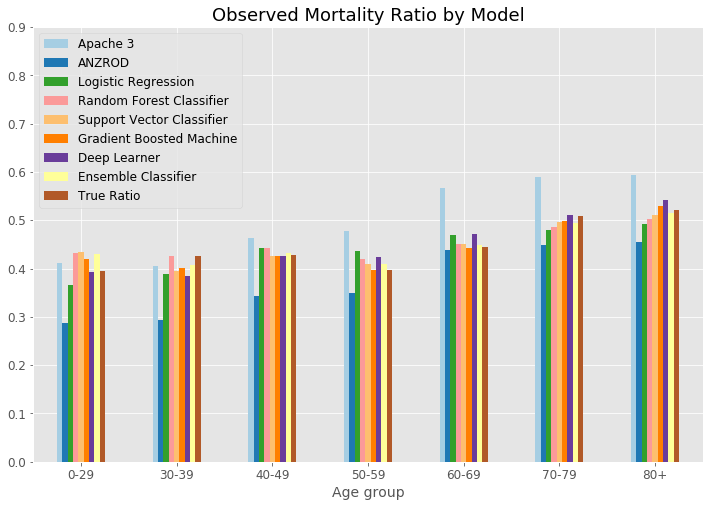

In [271]:
# Create graph
observed_mortality_by_agegroup_df.plot(kind='bar',
                                       ylim=(0,0.9),
                                       rot=0,
                                       title='Observed Mortality Ratio by Model',
                                       colormap='Paired')